In [1]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from string import punctuation
import sklearn.datasets as skds
from pathlib import Path
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
np.random.seed(1237)

Using TensorFlow backend.


In [2]:
train_data_file = 'train/train-1546603042473.csv'
test_data_file = 'test/test-1546603743049.csv'

In [3]:
raw_train_data = pd.read_csv(train_data_file)
raw_test_data = pd.read_csv(test_data_file)

In [4]:
def plt_data(names,values,title):
    plt.figure(1, figsize=(9, 3))
    plt.bar(names, values)
    plt.suptitle(title)
    plt.show()

In [5]:
def cat_value_count(dataFrame,col):
    return dataFrame[col].value_counts()

In [6]:
# lambda function to get NULL values from dataframe
NANS = lambda df: df[df.isnull().any(axis=1)]
NANS(raw_train_data)

,categories,converse
1221,OTHERS,NaN
1632,OTHERS,NaN
4349,OTHERS,NaN
5096,OTHERS,NaN
5808,OTHERS,NaN
5816,JUNK,NaN
9426,JUNK,NaN
11080,OTHERS,NaN
14037,OTHERS,NaN
15549,JUNK,NaN


<class 'pandas.core.series.Series'>


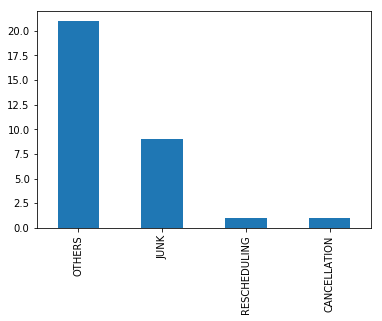

In [7]:
train_nan_df = NANS(raw_train_data)
train_nan_cat_list_cnt = cat_value_count(train_nan_df,'categories')
print(type(train_nan_cat_list_cnt))
train_nan_cat_list_cnt.plot.bar()

In [8]:
train_data = raw_train_data.copy()
train_data.dropna(inplace=True)
test_data = raw_test_data.copy()
test_data.dropna(inplace=True)

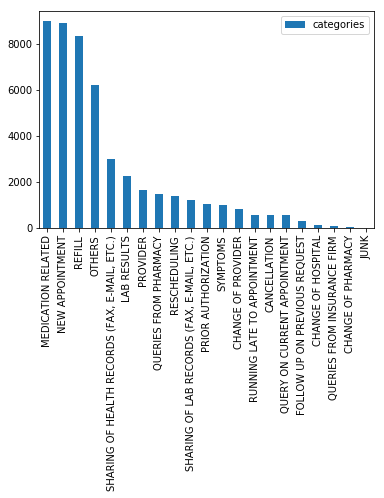

In [9]:
#Plot categories 
test_data_list_cnt = cat_value_count(train_data,'categories')
test_data_list_cnt = pd.DataFrame(test_data_list_cnt)
test_data_list_cnt.plot.bar()

In [10]:
uniq_cat = train_data.categories.unique()
print("Unique values :"+str(len(uniq_cat)))
print(uniq_cat)


Unique values :21
['QUERIES FROM PHARMACY' 'NEW APPOINTMENT' 'OTHERS' 'MEDICATION RELATED'
 'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)' 'REFILL'
 'PRIOR AUTHORIZATION' 'RESCHEDULING' 'SYMPTOMS' 'LAB RESULTS'
 'FOLLOW UP ON PREVIOUS REQUEST' 'PROVIDER' 'CHANGE OF PROVIDER'
 'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)'
 'QUERY ON CURRENT APPOINTMENT' 'RUNNING LATE TO APPOINTMENT'
 'CANCELLATION' 'CHANGE OF PHARMACY' 'QUERIES FROM INSURANCE FIRM' 'JUNK'
 'CHANGE OF HOSPITAL']


# Keras Sequential model

In [11]:
#Preprocessing

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
vocab = train_data.converse.values.tolist()
vocab = [ word_tokenize(line) for line in vocab ]
vocab_set = set()
for line in vocab:
    vocab_set.update(set([lemmatizer.lemmatize(w) for w in line]))
print("No. of words in vocabulary "+str(len(vocab_set)))


No. of words in vocabulary 33734


In [14]:
#remove remaining tokens that are not alphabetic
vocab_set = [word for word in vocab_set if type(word) is str and word.isalpha()]

table = str.maketrans('', '', punctuation)
vocab_set = [w.translate(table) for w in vocab_set]

#filter out stop words
stop_words = set(stopwords.words('english'))
vocab_set = [w for w in vocab_set if not w in stop_words]
# filter out short tokens
vocab_set = [word for word in vocab_set if len(str(word)) > 1]
print("No. of words in vocabulary "+str(len(vocab_set)))

No. of words in vocabulary 33580


In [15]:
def allow_vocab(line):
    word = set([lemmatizer.lemmatize(w) for w in word_tokenize(line)]) 
    word = word.intersection(vocab_set)
    return " ".join(list(word))



In [16]:
train_data['converse_voc'] = train_data['converse'].apply(allow_vocab)

In [17]:
test_data['converse_voc'] = test_data['converse'].apply(allow_vocab)

In [18]:
train_converse, test_converse, train_cat, test_cat = train_test_split( train_data['converse_voc'], train_data['categories'], test_size=0.2, random_state=42, stratify=train_data['categories'])

In [19]:
print("vocabulary:"+str(len(vocab_set)))

vocabulary:33580


In [20]:
#token with digits should be handled
vocab_size = len(vocab_set)
num_labels = 21
batch_size = 32
tokenizer = Tokenizer(num_words = vocab_size,split=' ')
tokenizer.fit_on_texts(train_converse)

x_train = tokenizer.texts_to_matrix(train_converse, mode='tfidf')

x_test = tokenizer.texts_to_matrix(test_converse, mode='tfidf')


encoder = LabelBinarizer()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(train_cat)


In [21]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               17193472  
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                10773     
__________

In [23]:
#max_features = 1024
from keras.layers import Embedding
from keras.layers import LSTM
model_l = Sequential()
model_l.add(Embedding(vocab_set, output_dim=256))
model_l.add(LSTM(128))
model_l.add(Dropout(0.5))
model_l.add(Dense(21, activation='softmax'))

model_l.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_l.fit(x_train, y_train, batch_size=32, epochs=3)
score = model_l.evaluate(x_test, y_test, batch_size=32)

ValueError: Argument must be a dense tensor: (['managment', 'loved', 'filter', 'meter', 'plessinger', 'crean', 'shani', 'valproate', 'betamethosone', 'youwill', 'termors', 'cutting', 'slit', 'risperdol', 'roosevelt', 'reveals', 'meltdown', 'hisher', 'conitnuing', 'dystonic', 'matrix', 'pseudomonas', 'flomax', 'dosage', 'bulid', 'deatails', 'addrees', 'paine', 'qdfluoxetine', 'exasperated', 'convulsive', 'anxiousness', 'abous', 'disporportionate', 'zing', 'inflicted', 'respirator', 'pedspt', 'vandor', 'legt', 'belsomnra', 'dobut', 'candi', 'rathike', 'cavity', 'amn', 'lighter', 'breast', 'rotect', 'waistband', 'pscych', 'feel', 'shaunte', 'josefs', 'vasculitis', 'nelson', 'brittney', 'migrainespressure', 'watson', 'contradicts', 'diarhhea', 'aboug', 'bother', 'mixed', 'neuromodular', 'malaise', 'littte', 'inusrance', 'matthees', 'mitchell', 'depokote', 'lic', 'benfotiamine', 'bottomed', 'mann', 'xd', 'mannagable', 'document', 'improving', 'movesgets', 'addressing', 'nortriptyline', 'ambersol', 'saige', 'reherasal', 'keen', 'reunion', 'preceded', 'surer', 'assoicated', 'amusement', 'smelling', 'udapte', 'warrington', 'mangano', 'autopsy', 'bliss', 'answermachine', 'oh', 'cole', 'mloneal', 'phonefax', 'rebeccalpn', 'ketorlac', 'wellshe', 'reassess', 'cortisporin', 'prison', 'worknote', 'sttart', 'fieldtrip', 'spped', 'pharmact', 'teaspoon', 'cremation', 'ulmonologist', 'kostco', 'irritablity', 'referraltwo', 'bnp', 'underwent', 'district', 'aultcare', 'weekeend', 'reconsderation', 'dabutan', 'agreesive', 'flexarill', 'nephrologists', 'pilairo', 'rinsing', 'nominal', 'perrin', 'moved', 'novant', 'chillsstaying', 'attidude', 'burned', 'yvette', 'backmris', 'lamicatl', 'cheris', 'wgfholly', 'polysomnography', 'plasmapheresis', 'mirage', 'carletta', 'occip', 'gmday', 'stabilizing', 'theoretical', 'unbound', 'terminate', 'comforting', 'ophthamologist', 'cause', 'leadcord', 'blooodwork', 'abl', 'pharmavail', 'cambiamigraines', 'ping', 'rescusitated', 'redid', 'tripan', 'present', 'quotation', 'episode', 'fentenyl', 'nominated', 'diaistat', 'disallows', 'tameisha', 'clyde', 'lubricant', 'escitalopram', 'arsinol', 'clonzapam', 'shavon', 'extention', 'valerie', 'seldom', 'notarized', 'kernodle', 'churce', 'profound', 'painno', 'hs', 'anylonger', 'succesfully', 'szsday', 'consolidate', 'jethro', 'stateing', 'hallucintaions', 'padc', 'jethroperkins', 'exponentially', 'enjoying', 'banged', 'splintingbracing', 'epilepsy', 'gould', 'resultsbloodwork', 'joel', 'colorectal', 'appropiate', 'screaminggritting', 'aggressiveness', 'multifactoral', 'lineagen', 'personnel', 'snorting', 'montly', 'rpt', 'advertisement', 'fot', 'ordersblood', 'activites', 'upward', 'affadavit', 'pikeville', 'rashhives', 'evicoremedicaid', 'devvertigo', 'refaxing', 'wcanadian', 'nuero', 'rozerum', 'wie', 'nemenda', 'schs', 'differace', 'builf', 'studyplease', 'carissa', 'dunbar', 'rex', 'verfify', 'eog', 'meperdine', 'vivians', 'yus', 'ventricular', 'waccredo', 'dakholly', 'aiyana', 'schedulecoordinate', 'reiceved', 'deny', 'mccarthy', 'cignaevicore', 'consern', 'alavnd', 'pancreatic', 'wynne', 'multivitamin', 'addict', 'exempt', 'nippleareola', 'tighteningpressurepain', 'recordi', 'vp', 'holiday', 'allan', 'blunt', 'list', 'reduced', 'valsartan', 'mariah', 'suddenly', 'wmr', 'amoxicillen', 'frail', 'rizotriptan', 'donor', 'recopied', 'immediately', 'omeprazole', 'reevaluation', 'goup', 'whichard', 'styrofoam', 'blackout', 'referrak', 'adnoids', 'db', 'miraculous', 'poqhs', 'kink', 'marshelia', 'atenoolol', 'butalbutal', 'greenstone', 'callinf', 'allow', 'complain', 'quant', 'interprep', 'therafter', 'wadeson', 'rxbin', 'genie', 'repayment', 'servant', 'jackshah', 'chock', 'woking', 'plea', 'callbehavior', 'nauseavomitingvisual', 'nalsund', 'resultsoffice', 'paleness', 'sezure', 'bax', 'wenn', 'ina', 'areaspeech', 'callig', 'unknow', 'spying', 'deana', 'nuru', 'abh', 'strengthweakness', 'retinal', 'phoe', 'uhc', 'millazo', 'lmn', 'lkhelifinc', 'anemina', 'resultssee', 'action', 'managed', 'atlanta', 'blame', 'brokd', 'renally', 'naphe', 'mias', 'clamy', 'dramamine', 'tideland', 'accessory', 'wdaughter', 'johntson', 'shoffner', 'cvall', 'ordersfax', 'preemie', 'varner', 'wellspring', 'seizuresreferringclinton', 'satisfactorily', 'pust', 'margraff', 'buttrams', 'qid', 'downtown', 'clb', 'reapproval', 'robing', 'dx', 'sugguesting', 'background', 'percep', 'chinese', 'physch', 'trileptals', 'cutt', 'cympbata', 'cohen', 'torodol', 'nuerlogy', 'fioricettopamax', 'abominal', 'grande', 'unexpectantly', 'reactive', 'aroundpreventing', 'male', 'insurer', 'assc', 'episoidser', 'rcv', 'poqam', 'feed', 'speciman', 'caus', 'daycare', 'appointmentmrimed', 'mandatory', 'radiology', 'janes', 'onthurs', 'hadam', 'continues', 'responce', 'lians', 'stabbng', 'crushingchewing', 'fallingand', 'ccu', 'refractory', 'dahir', 'discussconfirm', 'vaginosis', 'yearbut', 'weekhad', 'tourette', 'infectionrecent', 'ohter', 'assumption', 'moredefinitive', 'thougth', 'stationed', 'forbes', 'incontinence', 'aci', 'verbalizes', 'glazed', 'scroll', 'free', 'completionso', 'suposed', 'parentcaregiver', 'mgmgmg', 'neurocognitive', 'capcof', 'peoria', 'sat', 'siniment', 'otand', 'cpcp', 'outstanding', 'sec', 'daparrish', 'emergancy', 'locationstatus', 'tough', 'anyday', 'outtriage', 'hptl', 'hysterically', 'keegans', 'coincidental', 'willies', 'anticpates', 'webb', 'centerjessica', 'voluntary', 'mediastinal', 'cheyl', 'elise', 'metacarpo', 'computer', 'notiyfing', 'detailprovider', 'offset', 'mejia', 'irrate', 'myrah', 'clonazepams', 'behavoirwhich', 'hanausea', 'screen', 'dakstacy', 'asapjcg', 'nicholo', 'interx', 'whcih', 'swinging', 'win', 'everyotherday', 'nauseavomiting', 'lawpurv', 'percocetpromethazinelorazepamimitrex', 'ptis', 'sepulveda', 'futrell', 'ganeral', 'snapped', 'hemeonc', 'cracker', 'mead', 'hiim', 'abouts', 'blalock', 'foucs', 'avenu', 'render', 'makeup', 'rovok', 'remembers', 'whirlpool', 'unwanted', 'bombarded', 'courthouse', 'decide', 'fibroid', 'hemotoma', 'sxchedule', 'inthe', 'imiging', 'aukgmentin', 'sutton', 'hemo', 'tighter', 'labral', 'loopiness', 'coates', 'neurosurgon', 'esm', 'husba', 'gray', 'headacheneck', 'everadvised', 'kaitlins', 'armani', 'ble', 'cloud', 'cnat', 'steriods', 'dosedirections', 'inoutddd', 'lemtradatecfidera', 'regestration', 'whenshe', 'volvo', 'contaced', 'inbetween', 'givres', 'backwith', 'iovconcussion', 'relcutant', 'oozing', 'partum', 'arahlyn', 'li', 'advise', 'crysell', 'reliance', 'ocupational', 'ony', 'leila', 'hyperventalating', 'porcsha', 'tonmorrow', 'amonia', 'colletionsbad', 'passcode', 'escalator', 'bg', 'kamini', 'takent', 'nightmorning', 'machined', 'pay', 'particiapate', 'inborn', 'niece', 'wbenefits', 'dermatitis', 'inqui', 'smoothly', 'forwarded', 'cklist', 'xkmtb', 'relistor', 'sampath', 'tabsd', 'command', 'burger', 'psychiatricemotional', 'submiting', 'crousethomasd', 'fatiged', 'hailey', 'meckels', 'revise', 'alternatice', 'breakdownsand', 'indicating', 'variable', 'mesg', 'demanding', 'priscilla', 'distubance', 'olanzatine', 'leggs', 'wsandhills', 'kali', 'spanishplease', 'februaury', 'zarzar', 'verbally', 'aspenison', 'tallez', 'efax', 'slid', 'clonidie', 'resubmitt', 'prevnar', 'cocnerned', 'infiltrated', 'differnt', 'rikkena', 'eleanors', 'renata', 'living', 'fireman', 'alley', 'jelly', 'vibratory', 'quantitative', 'middday', 'headset', 'speece', 'roller', 'csa', 'justins', 'positon', 'roof', 'shoot', 'coq', 'inclusion', 'feces', 'shea', 'overlooking', 'pressure', 'pseudodementia', 'haveing', 'curvy', 'bonne', 'exactly', 'synopsis', 'comorbidities', 'clinidine', 'tye', 'vebalize', 'ween', 'mosteller', 'canewalker', 'gmb', 'backarmslegs', 'maxton', 'pacemaker', 'ptha', 'deeper', 'aford', 'corbier', 'throughcant', 'messagecomplaint', 'fluorescent', 'satisfied', 'briefly', 'frankensense', 'nonverbal', 'liquid', 'irritating', 'defer', 'alternative', 'addresseassd', 'antiviral', 'latest', 'nevere', 'punkprincesi', 'unbfree', 'primodone', 'ner', 'gavin', 'cederhurst', 'adhdpt', 'disabilites', 'prefect', 'veeg', 'pleasefax', 'kineret', 'krisna', 'adcock', 'justifying', 'mhau', 'hodges', 'dfor', 'fatigueweak', 'detachment', 'folbic', 'explaind', 'interfer', 'vailable', 'pegram', 'christine', 'fixable', 'cpht', 'ispoke', 'seratonin', 'reviewupdate', 'gladys', 'topamac', 'mckenzees', 'mhy', 'alina', 'addedum', 'whay', 'upswinging', 'egale', 'type', 'straining', 'learns', 'wne', 'nauseavomitting', 'recently', 'nppas', 'surger', 'sarithawife', 'referrence', 'foraminal', 'maiden', 'receivd', 'shifting', 'exploding', 'dor', 'diazide', 'medstaken', 'congruent', 'vet', 'nw', 'mouht', 'checkingon', 'hoping', 'thhen', 'childrens', 'wp', 'chaged', 'antiepileptic', 'specification', 'bottle', 'havr', 'copaxoneverbal', 'meralgia', 'wferrell', 'whenw', 'swirly', 'held', 'gresham', 'metoproplol', 'gallian', 'repositioning', 'comparator', 'actiivity', 'waxing', 'deminished', 'starter', 'chassity', 'damage', 'tischner', 'supine', 'pharmacisist', 'mmz', 'dimmer', 'princeton', 'pks', 'dying', 'citolapram', 'sit', 'vng', 'slide', 'motorcycle', 'subsequant', 'subscriber', 'hockey', 'registered', 'grandson', 'billable', 'calciumcreatinine', 'weaknesstingling', 'raleighdr', 'propraolol', 'thereapy', 'wgabr', 'inflaation', 'flarecant', 'modanfil', 'bodenstine', 'responde', 'binford', 'ingles', 'southlight', 'beachfla', 'depakotetegretol', 'wear', 'peter', 'lobo', 'reopened', 'nycenta', 'shcld', 'watlington', 'mccain', 'neuropsy', 'printingfaxing', 'bruised', 'dialed', 'olive', 'uterine', 'toileting', 'silverman', 'mine', 'addressl', 'oxybutynin', 'kirksusannah', 'karate', 'continuum', 'latimer', 'weel', 'doucett', 'strengthbenadryl', 'restsleep', 'chamblee', 'tangle', 'pymts', 'greensboro', 'neuologist', 'pillowsm', 'receiption', 'medicate', 'coctail', 'relay', 'net', 'amitriptyline', 'suggested', 'chronically', 'occurances', 'encouring', 'backhip', 'hittingcrying', 'suie', 'arne', 'millilit', 'normalized', 'quiet', 'medicationtoradol', 'tashoy', 'peyton', 'strength', 'wouldlike', 'resulst', 'dmv', 'crane', 'casl', 'anly', 'tweaked', 'limted', 'httpsicc', 'lou', 'meghans', 'exceptionally', 'npt', 'enhancement', 'clarke', 'staying', 'ariel', 'shumate', 'oppositional', 'starness', 'relief', 'anticipating', 'weakand', 'ignore', 'triagese', 'tensed', 'idf', 'thigh', 'uf', 'addicted', 'sydney', 'antibodic', 'luxury', 'spining', 'thyroidvitamin', 'price', 'sharpness', 'regualrly', 'somnoguard', 'jos', 'glycogen', 'rvcd', 'vocemail', 'acquaintance', 'load', 'mill', 'assure', 'provide', 'medicai', 'tounge', 'headphone', 'tegretollamictal', 'transported', 'proof', 'es', 'glassy', 'noticied', 'ntpmg', 'benzotrapine', 'recalled', 'patinet', 'massage', 'financilal', 'rituximab', 'gender', 'iesha', 'makais', 'medicationsno', 'rexa', 'ahold', 'outing', 'plainly', 'community', 'umm', 'wednesdaythrusday', 'claustrophopia', 'integrity', 'neurologist', 'tracy', 'decemeber', 'cleeff', 'psk', 'digging', 'meigies', 'significance', 'delinquent', 'kimberly', 'stickerhangar', 'miya', 'aspartate', 'copious', 'reread', 'parekh', 'ashford', 'waiting', 'zarontin', 'chery', 'afghanistan', 'bite', 'aparatus', 'ciropractic', 'wembley', 'earsnumbnessloss', 'al', 'refrain', 'software', 'ptsd', 'alejandre', 'tocome', 'churchland', 'unbeknownst', 'infina', 'duskn', 'frankly', 'neruologist', 'grunted', 'faxmailportal', 'national', 'zaje', 'ntoifed', 'experenced', 'ribofavin', 'barnes', 'appendecitis', 'bachiochi', 'previleges', 'acreddo', 'injectons', 'wonderfully', 'mvas', 'wellbutrin', 'stenois', 'parkinsonian', 'seal', 'duopa', 'knwo', 'caregiver', 'vector', 'tinglingsobjaw', 'recient', 'fl', 'internal', 'resultsmri', 'hubby', 'erosive', 'metabolizer', 'fingersunable', 'numbed', 'spoken', 'combo', 'acceptable', 'epideral', 'desired', 'migrianes', 'advsie', 'entrance', 'joselle', 'thirst', 'unavailable', 'avoided', 'pretty', 'sticking', 'oversedation', 'tohis', 'aroung', 'reques', 'monring', 'winfred', 'weaknessnumbness', 'norethindrone', 'scheduer', 'declinedplease', 'tamsulosin', 'privately', 'gilliam', 'fullbody', 'fiill', 'excision', 'alleviated', 'caqjr', 'ptdawn', 'spacing', 'wcase', 'wbjr', 'packmaintence', 'aaa', 'oversight', 'willl', 'neede', 'catherization', 'starks', 'membe', 'exalgodilaudid', 'numbingagent', 'quesions', 'rebrain', 'ntpdoxepin', 'migra', 'interactive', 'follwoling', 'weatherhed', 'garncer', 'svhedule', 'clairs', 'requestng', 'rpr', 'prickling', 'zaytoun', 'connelly', 'martinez', 'drunken', 'refresher', 'exposure', 'edgewater', 'hemorrhagic', 'defibrillator', 'mysolin', 'headachestreatment', 'refillneuropsych', 'doclofenac', 'athens', 'daiily', 'emergently', 'utc', 'hernaitaion', 'diabilty', 'delrioa', 'antidepressant', 'nancy', 'worseand', 'roiurgent', 'irrational', 'mramri', 'recommends', 'intercomm', 'speechot', 'jerky', 'jearking', 'incompletely', 'hampton', 'anpyra', 'lmtcb', 'pounding', 'noticeable', 'lizpky', 'mdp', 'sait', 'butorphanol', 'joking', 'cytoplasmic', 'worsend', 'wikons', 'dizzinessnumbnesstingling', 'changelvm', 'hydroxyzineclonidine', 'hazel', 'prospective', 'submitted', 'stabdpoint', 'nucynta', 'rishon', 'siler', 'rrad', 'ofelia', 'basilar', 'presribed', 'resultsreturned', 'nystatin', 'reolved', 'activityappt', 'psgctt', 'believing', 'aware', 'primidone', 'hemorrhage', 'anna', 'occurance', 'dropping', 'ulcer', 'boxing', 'valled', 'cancer', 'individual', 'attendance', 'summarizing', 'opinon', 'settingssupplies', 'incorrectshe', 'naptime', 'weighs', 'cuneo', 'download', 'ship', 'referable', 'walnut', 'parlysis', 'neurosurery', 'sice', 'rsolve', 'lighten', 'kepprasz', 'lucid', 'swaying', 'borderline', 'cuff', 'inappropriate', 'coldtysabri', 'craniotomy', 'czpalways', 'excused', 'strayer', 'axert', 'increaing', 'soap', 'icnsh', 'workout', 'ness', 'contiues', 'wnat', 'methylcarbomol', 'patching', 'completly', 'fizharris', 'orderletter', 'bushra', 'hac', 'overwhelmed', 'reappt', 'hillary', 'capt', 'cephaly', 'floatersnausea', 'ellen', 'ptnew', 'salivating', 'covel', 'relaxant', 'lr', 'apptworkers', 'confimring', 'israel', 'clasutro', 'notifioed', 'emedications', 'therapuetics', 'micardis', 'midlevel', 'septal', 'variant', 'revied', 'aternate', 'blurr', 'numb', 'inital', 'studypreauth', 'underdiagnosed', 'advilapapbenadryl', 'tabstabs', 'wstk', 'foward', 'clicked', 'iovsyncope', 'stohler', 'rfa', 'overly', 'pingrams', 'resubmit', 'seizuresoperator', 'namedob', 'gladl', 'subarachnoid', 'nofified', 'deepest', 'pancreas', 'tamia', 'harleysville', 'craig', 'sentpt', 'bedwoke', 'dev', 'careless', 'grabbed', 'freds', 'loree', 'tolman', 'titraton', 'phiilis', 'arrangementsappt', 'holloway', 'southern', 'mpossible', 'liebowitz', 'navinet', 'chlordiazepoxide', 'ange', 'sheri', 'brucejr', 'occurse', 'neromusclar', 'survival', 'tizanidan', 'zajic', 'masknasal', 'resultand', 'graduated', 'antibx', 'skipping', 'stereotypic', 'acitivities', 'aspenson', 'assessmentplan', 'encephalopathic', 'protruding', 'der', 'stewert', 'wash', 'risperdal', 'judith', 'regimenkeppra', 'triptans', 'carbi', 'hypotemia', 'allcare', 'rovbotox', 'stack', 'tabot', 'apda', 'tld', 'proceeed', 'anyother', 'kolappa', 'capsulesday', 'meshed', 'centinneal', 'feever', 'nedd', 'umr', 'curascript', 'vr', 'incomplete', 'takin', 'levetiracetam', 'fluttery', 'medpeds', 'maximus', 'offline', 'forus', 'schedulefd', 'neurodevelopmental', 'problemsbut', 'ivc', 'christin', 'precedence', 'sherrie', 'pd', 'nda', 'itll', 'mangable', 'margie', 'discu', 'coralville', 'cdls', 'benifets', 'boat', 'beckett', 'orthoped', 'alot', 'secure', 'rotenberry', 'inits', 'sexual', 'schwirzinski', 'kritsy', 'dissolve', 'mcdermott', 'pencil', 'tremorsnumbnesstingling', 'manifestation', 'strart', 'cancilation', 'benifiting', 'parasomnia', 'abn', 'tfw', 'amitiptiline', 'infantile', 'notespt', 'locked', 'dosgae', 'lethary', 'failing', 'vivanse', 'deltoid', 'stoppped', 'gad', 'yasheka', 'grandfathergaurdian', 'biotene', 'production', 'amt', 'odontoid', 'beofre', 'jasien', 'appproved', 'beneficialstable', 'muchmetazalone', 'radford', 'establishes', 'bag', 'specifyevolv', 'requestaptiom', 'patellar', 'whentransfer', 'ssdi', 'gloira', 'halitosis', 'scissors', 'avance', 'bowmam', 'anytihng', 'wallmart', 'sia', 'macrobid', 'noah', 'headdpain', 'forestpines', 'username', 'upconvertible', 'fie', 'fuov', 'addit', 'szvns', 'austin', 'weakened', 'iver', 'wheelock', 'alazpram', 'distribution', 'rubber', 'foundation', 'neuorlogic', 'arseniu', 'schedued', 'sharone', 'reusts', 'novemberdecember', 'member', 'glatopa', 'cue', 'reactivated', 'ivsuite', 'worrker', 'mainedtr', 'dopamine', 'alliiance', 'labworkmri', 'prescribe', 'programming', 'honored', 'accuracy', 'methylin', 'chinstrap', 'ocstrei', 'charlotte', 'giles', 'nursema', 'rawshe', 'amelia', 'dirorder', 'nursetisha', 'acne', 'least', 'craigrobertson', 'careemergency', 'haviing', 'mscraleigh', 'equp', 'optionsadjustments', 'planned', 'megan', 'settled', 'contnues', 'beeng', 'durng', 'advismentrecommendations', 'compete', 'taulbee', 'natalie', 'courtdate', 'clonazpam', 'hbr', 'releif', 'hypermanic', 'nures', 'mame', 'consistant', 'seemed', 'wr', 'combining', 'neuragia', 'iser', 'antinatalizumab', 'window', 'pu', 'concenrta', 'lucy', 'discussexplain', 'overheat', 'divalproix', 'disney', 'toxic', 'realistically', 'debras', 'neuropsycmmse', 'botten', 'riot', 'requrest', 'awaness', 'bps', 'thrombocytopenia', 'postpartum', 'mdshe', 'crest', 'fitted', 'forwar', 'ptsm', 'apptrefrecords', 'statue', 'aprrox', 'margo', 'occulta', 'denie', 'forpick', 'sewed', 'whenasap', 'mot', 'brushing', 'idm', 'morganti', 'tissyallen', 'mlml', 'abnormlality', 'enjoli', 'hydrocodoneambienimitrex', 'oximetry', 'untreated', 'pw', 'cteeg', 'lonnieand', 'dialated', 'lymphocycet', 'prescribtion', 'ray', 'bfolate', 'mattered', 'pocketbook', 'frazelle', 'infuison', 'neuroscience', 'granisetron', 'rnawgf', 'differentiated', 'doxy', 'presribe', 'mais', 'spuose', 'hollysprings', 'mammogram', 'incapacitation', 'symptomschanges', 'theraccess', 'beltbut', 'tizandine', 'notefaxed', 'liverman', 'juliette', 'nortriptyl', 'curtismalachia', 'wked', 'diamox', 'unapprove', 'asher', 'wwo', 'guillian', 'sagharry', 'slight', 'dmr', 'carafate', 'byt', 'jhreskeaol', 'conduciton', 'massenburg', 'iacs', 'nightsunday', 'getign', 'plmsmild', 'keppa', 'oster', 'feldman', 'refilltopamax', 'wmcary', 'gittery', 'solumedrol', 'zombie', 'sampson', 'verbals', 'tc', 'fpr', 'hallcinations', 'dizzyness', 'suresteps', 'formualry', 'click', 'freq', 'lipid', 'terrified', 'nevermind', 'absenteeism', 'numerous', 'proximal', 'kmcs', 'tacking', 'weeknight', 'shelia', 'mribrach', 'clinician', 'hardcopy', 'baylee', 'contoinue', 'autoimmune', 'argumentive', 'di', 'maile', 'upda', 'wsusanna', 'maury', 'perampanel', 'injurybut', 'addendum', 'declinedrx', 'greulich', 'intended', 'pallative', 'whack', 'keept', 'ordersdemographics', 'precedues', 'addfocus', 'saus', 'megans', 'stabilization', 'act', 'orndoff', 'bactrimcopaxone', 'idec', 'forestville', 'situated', 'backline', 'echobubble', 'aubrey', 'tremor', 'decinding', 'studied', 'medicat', 'underneath', 'thrombis', 'diffusion', 'unites', 'medappt', 'apparantly', 'bross', 'ua', 'livea', 'labile', 'quietly', 'patchesflushing', 'andminimizing', 'ir', 'voltaren', 'reoccurence', 'sen', 'healthwellfoundation', 'cordination', 'referance', 'medicationcarbidopa', 'levoxyl', 'epolamine', 'wetting', 'citalopramlyrica', 'flexiril', 'comparrison', 'proctorjamesw', 'vernon', 'invensys', 'kaylie', 'relpaxfrova', 'mckoy', 'ncsemf', 'amanca', 'barry', 'sts', 'accomadate', 'sarainezpotter', 'worsenend', 'soeak', 'landry', 'testingand', 'apena', 'latelty', 'disturbanceref', 'febrile', 'average', 'medicad', 'intermediate', 'pammom', 'percieve', 'estadoil', 'tomoroow', 'nilova', 'bright', 'mornng', 'dunaway', 'resnik', 'operation', 'hydroxy', 'college', 'reocurr', 'lvmcb', 'unhappy', 'washburn', 'idler', 'botoxcontinuing', 'lendew', 'musclar', 'mriand', 'takingshe', 'rhett', 'sunset', 'nameneda', 'springmoore', 'apprehensive', 'benefitting', 'watery', 'malformationref', 'metastatic', 'lissette', 'yesterdaybut', 'topamaxmaxalt', 'chiropractic', 'anesa', 'plentiful', 'reinforced', 'procedure', 'intracranial', 'recordswill', 'mcelroy', 'ggt', 'opioids', 'mailing', 'tapred', 'ctsmild', 'endochronologist', 'qamdiastat', 'oncall', 'stte', 'tree', 'lillians', 'weakiness', 'meyring', 'legleft', 'whintey', 'tartrate', 'jaydoris', 'homeservices', 'retire', 'grope', 'divorce', 'hugh', 'diguilio', 'disparity', 'one', 'wrote', 'read', 'ethier', 'visionand', 'deterioration', 'detroll', 'tremored', 'machinesupplies', 'notept', 'develoment', 'preliminary', 'stormiebaker', 'sufficient', 'choking', 'traffic', 'straight', 'senior', 'msge', 'winsor', 'ac', 'edsfatigue', 'eds', 'accompany', 'yeary', 'show', 'blank', 'village', 'oftrazodone', 'calender', 'jointes', 'dory', 'surgeonanesthesiologist', 'iinsurance', 'pdf', 'itmake', 'tingly', 'liothyronine', 'rheumotology', 'rotate', 'city', 'pharmcist', 'carrilon', 'chlordiazopoxide', 'diffiuculty', 'twalker', 'infectionbut', 'jcg', 'usally', 'sugessted', 'arabic', 'cou', 'ckd', 'bloodurine', 'kittel', 'pjs', 'stribild', 'triggering', 'gower', 'rzimi', 'neelamegan', 'resuce', 'volunteering', 'ctmri', 'eto', 'weighting', 'abrupt', 'fluconazole', 'rehabilitate', 'flls', 'ppsd', 'dulls', 'phenyleph', 'wanted', 'problaby', 'dd', 'vestibular', 'szs', 'bedttime', 'georgoiu', 'perscrption', 'logged', 'butran', 'whitfield', 'resturant', 'depressing', 'monthly', 'whiteville', 'camilles', 'wiht', 'regad', 'colita', 'hypersensitivity', 'inoutradiculopathic', 'comourstaff', 'nr', 'ifuse', 'spontaneous', 'jiuce', 'goo', 'spineabdomen', 'ltr', 'mgact', 'headachex', 'withdrawing', 'shouting', 'efectiveness', 'wakeer', 'camera', 'juanitar', 'lc', 'possilby', 'atenololto', 'servicesgetting', 'trximet', 'herman', 'populating', 'label', 'dowdall', 'ethosuximide', 'tiffany', 'effected', 'stateds', 'frova', 'russell', 'hole', 'reodered', 'ballance', 'readable', 'calculate', 'requestbad', 'delivers', 'plegridyavonex', 'gammunex', 'neuron', 'flaking', 'qmidday', 'artery', 'raging', 'billed', 'insurane', 'tueswed', 'efficient', 'southwick', 'dublin', 'insurancemedication', 'derek', 'hypotensive', 'daugherty', 'tommmorow', 'card', 'grandma', 'tendecies', 'transp', 'tlso', 'blackgreen', 'trialed', 'wbc', 'qdbut', 'roberton', 'musselman', 'referralappt', 'todayshe', 'titled', 'valerate', 'hoover', 'oduok', 'mestinom', 'volteran', 'shekera', 'underst', 'nebu', 'eyed', 'employeer', 'onbtpis', 'wednesday', 'buzz', 'fendi', 'responds', 'tbd', 'wglenn', 'manne', 'congitive', 'satruday', 'charted', 'monobut', 'negotiate', 'omniplus', 'cardiac', 'infuses', 'lurch', 'op', 'accomodating', 'redrawn', 'stint', 'issuestear', 'insuramce', 'dpk', 'bykmc', 'shefali', 'hydrocodoneacet', 'legionaires', 'limbonis', 'mehta', 'applianc', 'lamisil', 'unforeseen', 'meg', 'neurolabs', 'chris', 'neuropsychitry', 'beleive', 'yang', 'bloating', 'impairment', 'karlene', 'tthere', 'mayku', 'rescheudled', 'transd', 'migraineshas', 'modulating', 'stranger', 'joyners', 'sneeze', 'thinnerantiplatelet', 'hal', 'fsa', 'array', 'relapsingremitting', 'reviewcorrection', 'upok', 'investigation', 'lymphocytic', 'canellation', 'johnson', 'gavapentin', 'discussabove', 'copaypatient', 'epstein', 'ddint', 'mailes', 'sunny', 'undefine', 'kenansville', 'anywhere', 'focus', 'jayden', 'parentteacher', 'btr', 'daydreaming', 'intercepted', 'rather', 'jill', 'mcardle', 'sense', 'stretchespulling', 'autismref', 'usure', 'scheduledbut', 'incontinece', 'graduate', 'uncontroled', 'revieweing', 'sager', 'adnoma', 'blanca', 'rotating', 'helpline', 'resending', 'palpation', 'prns', 'amos', 'walsh', 'grandmalfull', 'towm', 'victoria', 'maxalt', 'perrla', 'clauson', 'bigloud', 'mmigraine', 'quillinvant', 'esirov', 'pyschologist', 'gabriel', 'examinediscuss', 'freind', 'indicated', 'myelogra', 'suppresses', 'ere', 'blanco', 'elizabethbynum', 'possibliy', 'triagept', 'upside', 'treatmentptions', 'southside', 'blessing', 'dilium', 'greatha', 'haveshes', 'treamtment', 'studyapnea', 'anitbodies', 'quinine', 'soct', 'inheriatnce', 'backself', 'genereallyu', 'druged', 'bwilson', 'noziglia', 'eastpointe', 'hammil', 'rearrange', 'autotitrate', 'argue', 'connell', 'yestreday', 'pleasel', 'spts', 'idunnowhat', 'regulation', 'disc', 'unchanged', 'vessel', 'tthey', 'andrial', 'conversion', 'releaseexchange', 'cassandra', 'topped', 'relapsed', 'cefd', 'availabe', 'effectsof', 'culprit', 'nctrack', 'havign', 'gurling', 'beh', 'hperintensities', 'heh', 'fmla', 'arm', 'jaffe', 'isues', 'ptmom', 'otcs', 'whatsoever', 'vausea', 'moss', 'whenit', 'staleva', 'nakia', 'speacilist', 'secretion', 'zonagram', 'borther', 'daniellebrewer', 'chose', 'powerade', 'vapcp', 'carnestp', 'tanisha', 'wheelchair', 'copaxon', 'sharp', 'vaccin', 'inspector', 'drag', 'disucssed', 'usher', 'chickman', 'needsschedule', 'staffing', 'professor', 'winter', 'alberto', 'walkinghe', 'mesaage', 'giant', 'guage', 'gleaned', 'totally', 'interim', 'craniopharyngeal', 'oin', 'brianca', 'chetty', 'injurysz', 'htatthe', 'reqeusting', 'tanyas', 'clothes', 'simenetsister', 'conscious', 'restart', 'requestmd', 'wcherie', 'interpreting', 'reassure', 'pamkarla', 'davidwidman', 'orthopedic', 'mriaeeg', 'fb', 'rehab', 'rwgstacy', 'welbutrin', 'aadefdaaebbcfac', 'bodily', 'contasted', 'chevre', 'mit', 'sugary', 'uneffective', 'accoridng', 'wopen', 'deletion', 'drwsiness', 'klonepin', 'doxepingabapentin', 'pjhamilton', 'opinionobtaining', 'contine', 'ruined', 'spit', 'smullj', 'migrainesreferringdr', 'glennearl', 'jseith', 'gleen', 'authorize', 'difficutleis', 'harmony', 'prac', 'regression', 'premeire', 'comptan', 'untll', 'babysitter', 'informaation', 'ashley', 'importantly', 'initating', 'carnestracey', 'refusal', 'troubling', 'notifiied', 'disorted', 'nerviousness', 'boyland', 'kmarts', 'muncie', 'apptdiff', 'blackmon', 'triazalam', 'loike', 'iif', 'rosenblitt', 'acudial', 'exercise', 'finished', 'highcroft', 'peytons', 'witch', 'apptconcussion', 'yehmonei', 'triton', 'pat', 'chaser', 'ridge', 'mckenna', 'buzzing', 'echo', 'formnoteletter', 'treated', 'optica', 'waititng', 'morse', 'accepts', 'stripped', 'pdmemory', 'refilluntill', 'starting', 'reported', 'sw', 'dont', 'clairfy', 'habitas', 'carina', 'szpossibly', 'matin', 'reschd', 'aba', 'bertha', 'bank', 'loudly', 'headachesblurriness', 'spive', 'leander', 'boodah', 'nbeyes', 'exists', 'connect', 'painthrobbing', 'little', 'gralsie', 'hospita', 'select', 'cidd', 'cerebellar', 'trlleptal', 'knc', 'pho', 'hah', 'fluappt', 'harristeeter', 'mont', 'encouragement', 'brsc', 'assoc', 'cable', 'messaged', 'stbing', 'flying', 'fifth', 'david', 'tripping', 'apptinsurance', 'unnessary', 'charity', 'paraparesis', 'suddent', 'robably', 'roberta', 'reasonably', 'sionce', 'thumping', 'wca', 'muff', 'nare', 'lisdexamfetamine', 'homocysteine', 'cmpcbc', 'comparision', 'justed', 'antianxiety', 'versed', 'thank', 'hyperventilate', 'asdvised', 'despite', 'prednisone', 'keegan', 'neruopathy', 'curse', 'formal', 'buncreat', 'armand', 'goody', 'migrainesselfold', 'depacote', 'thtas', 'anxietywellness', 'chgd', 'clarifiedconfirmed', 'rexchange', 'singh', 'infude', 'wane', 'identfiiers', 'cocnerns', 'emotion', 'contrubiting', 'writes', 'hydrobromide', 'datetimemonday', 'pappalardi', 'doc', 'esis', 'volunteer', 'whenwith', 'yard', 'morbid', 'dialy', 'schedulin', 'convulsionseyes', 'brock', 'wam', 'instrcutions', 'hickorync', 'patricias', 'fentanyhl', 'jrbrundidge', 'false', 'trokendixr', 'donation', 'infusin', 'increaseeeg', 'ramelteon', 'conc', 'lateness', 'tellingabout', 'pneumomia', 'rytaryreturn', 'sick', 'commented', 'lumbar', 'phyillis', 'treat', 'dbebfacef', 'medicationdiclofenac', 'account', 'notanimer', 'strong', 'letheragy', 'mobilty', 'detour', 'bookcase', 'robert', 'cardiologist', 'migrainesand', 'desk', 'wil', 'sedentary', 'limbemg', 'waffle', 'nri', 'actully', 'edwin', 'brittneyscagnelli', 'prince', 'jaimie', 'vission', 'apixaban', 'elctrodes', 'enter', 'marcaine', 'effectha', 'recordstest', 'mahmoud', 'attachd', 'quillivanthold', 'wheeler', 'distended', 'fraller', 'immunomodulatory', 'alrighty', 'travel', 'inouthx', 'clausrohobic', 'toridol', 'fddcaabdffedfaaea', 'kamiahs', 'writ', 'stacie', 'incresed', 'wacky', 'conventent', 'malate', 'popsicle', 'theya', 'colon', 'substantially', 'pursued', 'normalsbehaviors', 'alendronate', 'injuryno', 'forgeting', 'helpthank', 'hmm', 'recycled', 'rlu', 'tpi', 'basiccoventry', 'upto', 'thather', 'chewed', 'colin', 'colonial', 'shouls', 'timesyr', 'emc', 'series', 'pmpm', 'generlized', 'supplier', 'klonopintylenol', 'tolerance', 'dalfampridine', 'reneka', 'refull', 'flareinvoluntary', 'squad', 'sometimes', 'capability', 'aprias', 'voided', 'xrbut', 'kiesha', 'repaired', 'latanja', 'calming', 'planitis', 'prescript', 'vesicare', 'malfuntioning', 'lpm', 'infinaconnec', 'pledgridy', 'declining', 'statesville', 'icreasesing', 'niacin', 'gerone', 'gving', 'sharon', 'benadry', 'loginnamepatientemailpatient', 'bidcyproheptadine', 'unluckly', 'everyoone', 'mintues', 'regaurds', 'roadside', 'corporate', 'erx', 'outreach', 'supose', 'carrington', 'resolvement', 'joseffs', 'oxycointin', 'regareding', 'swalllow', 'psychoeducational', 'optometrist', 'wenhart', 'exercised', 'wakemed', 'taxed', 'surgeryoncology', 'lawsuit', 'ezilect', 'aggitated', 'spouse', 'sanda', 'nystagmusref', 'riboflaving', 'oversedated', 'qdaystarted', 'criterion', 'aboveis', 'provides', 'woffice', 'probelms', 'percocett', 'pozas', 'clonasepam', 'symtoms', 'bmi', 'woperator', 'chawn', 'noptified', 'couponspatient', 'beverage', 'smfhhl', 'toradolreglanbenadryl', 'lastered', 'authpre', 'thinkingand', 'sioux', 'wherever', 'leaving', 'degeneration', 'bunnlevel', 'burlington', 'brush', 'packshes', 'healthpark', 'brused', 'recived', 'pateint', 'excedrine', 'brenda', 'nuvgil', 'drake', 'spray', 'july', 'troubleshooting', 'forcasted', 'apptprinted', 'aggronox', 'suncreen', 'flordia', 'cyring', 'thth', 'assessed', 'pap', 'verster', 'avent', 'jonny', 'disturbing', 'enforcement', 'cbarg', 'laurarn', 'lamcital', 'rdi', 'preventaive', 'refused', 'bsc', 'manipulation', 'intercede', 'hazy', 'epidermoid', 'collection', 'morningplease', 'dada', 'seans', 'bayer', 'hg', 'quits', 'andg', 'polly', 'dreaning', 'disassociative', 'conventional', 'communcating', 'evetta', 'marlena', 'neruosurgery', 'first', 'mixing', 'hysinglar', 'ferrell', 'professional', 'allowed', 'joycern', 'tolerate', 'martinsville', 'lovastatin', 'facial', 'kullmanns', 'stimming', 'datetime', 'submit', 'popolizio', 'nelnet', 'ute', 'performs', 'painting', 'wkonanc', 'inquirng', 'mirena', 'herkenslong', 'floro', 'violence', 'heavyweak', 'subjective', 'mentock', 'inch', 'administ', 'comfortably', 'breakage', 'markeita', 'intially', 'print', 'skye', 'excited', 'chs', 'ots', 'tirage', 'awakeasleep', 'recative', 'ticsreferringbuck', 'believed', 'clarification', 'shs', 'loses', 'complety', 'latetraffic', 'ow', 'tabls', 'toddler', 'clorazepam', 'phy', 'reddened', 'polyphagia', 'raleigh', 'secreations', 'wpcarnes', 'unableto', 'depressionrequest', 'autismlack', 'figure', 'floating', 'awre', 'saysn', 'ovsleep', 'meymandi', 'persistence', 'olfactory', 'gem', 'mdcr', 'sxhedule', 'marjorie', 'crutch', 'daytime', 'anesthesia', 'cramping', 'gross', 'carcinogenic', 'waysunable', 'wanders', 'surgical', 'lfalk', 'hyponatremia', 'finlayson', 'capparelli', 'inconsistently', 'ordinary', 'verfied', 'afgain', 'ened', 'wantes', 'startcomplete', 'corey', 'gabpentin', 'basis', 'dehydrate', 'sendyouremailtome', 'hirschman', 'snowstorm', 'baianonie', 'eitheror', 'cen', 'panps', 'sinking', 'philsnails', 'side', 'implanted', 'amlodipine', 'fatiguedepression', 'wcpss', 'psychatrist', 'emergent', 'overturned', 'horribly', 'tyreks', 'baby', 'reassurrance', 'infection', 'beary', 'watching', 'shewould', 'qestions', 'corner', 'refillsto', 'cubicle', 'relocated', 'mayth', 'fatherdr', 'drain', 'pale', 'responsiblity', 'anxietydecreased', 'sophies', 'numbessor', 'alont', 'requst', 'ectopic', 'healthsource', 'cignacare', 'respecfully', 'ineeg', 'mgi', 'jtube', 'plegridy', 'eats', 'encephalomalasia', 'vomitinglightheaded', 'pughcustombuilders', 'dulled', 'ellie', 'appointmentmedication', 'thakn', 'hydrocortisone', 'daughterlisa', 'rating', 'finanical', 'bcbsanthem', 'enrolled', 'verable', 'complaintpainfall', 'luchema', 'estimation', 'bidfludrocortisone', 'consuming', 'ptleft', 'arthrotech', 'wyou', 'ellergy', 'ralrad', 'recieves', 'vestibuilar', 'rehad', 'writtin', 'myoclinic', 'pelted', 'hadden', 'feverchills', 'principal', 'workcomplete', 'maroof', 'drilling', 'legalized', 'serving', 'octnov', 'himselfover', 'sharper', 'thingling', 'conf', 'curtis', 'neurofibromatosisreferring', 'carilion', 'relaxer', 'tonsil', 'intensifies', 'actioned', 'ribo', 'prichards', 'office', 'advisable', 'rth', 'physicianraleigh', 'instructons', 'levle', 'ard', 'inout', 'jaquan', 'allowable', 'contactschedule', 'chartwcb', 'mohs', 'alkadhi', 'headche', 'julyst', 'mute', 'reproduce', 'coulod', 'emh', 'dc', 'prfile', 'nursse', 'listles', 'discision', 'cxlationswhat', 'knonw', 'uricalm', 'paraplegia', 'martina', 'versa', 'os', 'maskmachine', 'solving', 'volitile', 'ciproheptadine', 'cty', 'kadlec', 'paralegal', 'lovshe', 'transgender', 'performing', 'interesed', 'walton', 'ggp', 'minton', 'py', 'pahrm', 'oconnor', 'ovn', 'goshen', 'cheeeks', 'assignmentslater', 'adequately', 'century', 'scarred', 'resonate', 'nauseahablurred', 'submerged', 'rage', 'wallace', 'audra', 'keepra', 'safer', 'hemaonc', 'august', 'potruparvatid', 'mebhj', 'seizureaura', 'willpay', 'vidas', 'ban', 'bedputting', 'everyday', 'quality', 'jessie', 'creative', 'bradjen', 'duckett', 'tonja', 'glaucoma', 'humanas', 'sears', 'oasis', 'claimed', 'erform', 'amending', 'suggestion', 'bennett', 'withdaughter', 'haywire', 'pttecfidera', 'ch', 'trembling', 'semthill', 'occassion', 'cardizem', 'oxicodone', 'interrupted', 'ssb', 'differently', 'rare', 'crampsweaknesslow', 'regressionok', 'flowerty', 'wreck', 'contracted', 'location', 'fetus', 'ld', 'urione', 'headshoulder', 'cardiovascular', 'wgarner', 'carseat', 'braking', 'stuffiness', 'wisp', 'bradycardia', 'myrbetric', 'display', 'seizureswe', 'meldrums', 'agitiated', 'tecfideraif', 'fiew', 'regardng', 'faxe', 'pred', 'herbin', 'endocronologist', 'mailedto', 'amkes', 'solomans', 'bluemediciare', 'suppl', 'perez', 'rocking', 'wilkins', 'firmly', 'shell', 'elbowed', 'leahs', 'abxs', 'intractible', 'perscribed', 'increassed', 'foott', 'museum', 'cna', 'switch', 'lanier', 'medswhich', 'updrop', 'dermatologist', 'painpatient', 'georgetowntx', 'diclfenac', 'turnover', 'msthat', 'delivey', 'eecc', 'mana', 'enass', 'avis', 'raube', 'judgementcognition', 'headaphones', 'sib', 'carolina', 'duloxetine', 'signedclarified', 'drug', 'neuropysch', 'isout', 'aqua', 'larynx', 'lisakhuber', 'handwashing', 'wfax', 'scope', 'kevisia', 'kirby', 'pakinsons', 'avised', 'provigil', 'taisha', 'shoe', 'reroute', 'titation', 'quadriplegic', 'spea', 'jsalhoff', 'fioric', 'doubting', 'manufacture', 'cfuml', 'shondra', 'rant', 'clldl', 'atenelol', 'zipple', 'urinates', 'toney', 'deliver', 'awsome', 'randhawa', 'nec', 'sayre', 'smoked', 'retd', 'escorted', 'diagnoised', 'febbcfcbaeecee', 'evelaute', 'skeen', 'repeat', 'weatherwill', 'marinol', 'packing', 'equates', 'becaushe', 'elect', 'verifty', 'comfirmed', 'prasozin', 'evict', 'amputation', 'helpdesk', 'rady', 'zoned', 'submittinga', 'monotor', 'bare', 'asv', 'datetimestarted', 'bidclonidine', 'appointent', 'desnt', 'laceup', 'printed', 'nancyricks', 'extensively', 'radiologis', 'thrower', 'ey', 'gaurd', 'preston', 'claify', 'oder', 'pusuing', 'looksl', 'chx', 'today', 'appologised', 'hawkins', 'disconjugate', 'paramedian', 'wl', 'callletter', 'sufferig', 'utero', 'ipt', 'downsize', 'alternatve', 'negatively', 'see', 'business', 'indometh', 'upsetrude', 'kaitlyn', 'cisplatin', 'momellen', 'writted', 'understandin', 'sy', 'glilenya', 'americare', 'eardrop', 'bevhavoir', 'eatten', 'rolesville', 'agaf', 'fnp', 'articulation', 'rebmon', 'undergo', 'confrim', 'sepawk', 'tryhave', 'zpack', 'remainded', 'paul', 'impt', 'distal', 'recognize', 'rusty', 'donate', 'stingingand', 'bookshelf', 'sciatica', 'reinforcing', 'idiopathic', 'bereman', 'clearedins', 'conclusion', 'aaron', 'statewide', 'white', 'lo', 'buti', 'hyslinga', 'medsmri', 'shama', 'gylenya', 'asapmom', 'disgard', 'qdshe', 'sheduled', 'untill', 'twitchy', 'critz', 'traetment', 'aminoacids', 'tecfideramri', 'accelerated', 'trileptalfaxed', 'jsee', 'examiner', 'coin', 'ihas', 'lamotrigineguanfacine', 'ayscue', 'inyection', 'opthamalogist', 'pharmatrish', 'outside', 'omars', 'dusti', 'roxicet', 'hopkins', 'adise', 'fromed', 'mouthpiece', 'crea', 'extending', 'afanador', 'ptinr', 'orderwaiting', 'youto', 'colorsize', 'jeannie', 'served', 'fatgued', 'wakegarner', 'njr', 'derrick', 'worsenes', 'upd', 'tecnique', 'standasymetrical', 'jumpingjetters', 'install', 'dense', 'tramodol', 'dockside', 'tall', 'relnal', 'ministry', 'determination', 'phoned', 'pr', 'piece', 'healther', 'koontz', 'hotel', 'parham', 'regcontacts', 'ahd', 'drowsywobbly', 'blowing', 'tar', 'provided', 'colonscope', 'reordered', 'arises', 'locker', 'interesting', 'mgiraine', 'methylphenadate', 'durring', 'betsys', 'awaiting', 'albuterol', 'harmacy', 'reinjuried', 'gwen', 'kerry', 'aflac', 'topamax', 'renee', 'medcosts', 'waller', 'shasa', 'kindergarten', 'observer', 'testtests', 'sedgewick', 'ranitidine', 'upcompng', 'counteract', 'tucker', 'antibotic', 'wwords', 'vmx', 'sd', 'lct', 'steriod', 'genia', 'ligation', 'devine', 'sheena', 'gnight', 'xrayand', 'hyman', 'concerend', 'world', 'obrein', 'spellsabsent', 'pleaseadvise', 'alled', 'intrested', 'pulminary', 'pet', 'medtronic', 'thyroxine', 'ofter', 'spok', 'westbrook', 'fur', 'behaviour', 'rendered', 'simalar', 'healh', 'edwje', 'patella', 'dna', 'visa', 'tenex', 'rytari', 'whinyness', 'kalpana', 'clonazapam', 'strict', 'fenofibarate', 'authorizes', 'impairmentearly', 'sherrietprice', 'katrices', 'lkuioyhihljy', 'verbiage', 'sereens', 'chiavetta', 'sha', 'refferal', 'instructionshe', 'cometimes', 'hydromorphine', 'barometric', 'sherry', 'wendy', 'headed', 'hoarding', 'universally', 'interlaminar', 'jackson', 'leola', 'senitive', 'meetingappt', 'reills', 'costly', 'heugly', 'qodx', 'achamma', 'equilibrium', 'seizuresbab', 'keitha', 'sa', 'tong', 'lewis', 'watch', 'minocycline', 'ptot', 'boykin', 'dependence', 'givethe', 'joesfs', 'comingback', 'vaccine', 'rang', 'institue', 'carefully', 'caridopa', 'changing', 'gosh', 'parasitic', 'locationdatestimes', 'keeper', 'abroad', 'steroidsand', 'isaiah', 'enclosed', 'cnuvulsions', 'abington', 'voluntariyl', 'torequest', 'maintain', 'ddaniels', 'butor', 'glare', 'aero', 'printedplaced', 'choke', 'coud', 'listening', 'anticiapted', 'easing', 'jeopardize', 'advancement', 'spellsreferringwestern', 'pharmaciset', 'breakthough', 'escalated', 'smithwebb', 'ressults', 'demongraphics', 'coveragepaying', 'wincreased', 'contraindicated', 'hind', 'ferrera', 'prefers', 'reaults', 'deceased', 'notriptyline', 'medciation', 'accident', 'unfortunately', 'opeing', 'issuespt', 'ptt', 'dlewis', 'upgraded', 'arlene', 'benzoate', 'bedtimeon', 'debbies', 'drew', 'paperworkstart', 'store', 'hell', 'ntpmdp', 'arthritic', 'deodatus', 'approaching', 'donated', 'tyler', 'xweekly', 'effectreferral', 'tying', 'eson', 'stomack', 'omha', 'pleaes', 'offense', 'induced', 'oxycodoneapap', 'maternity', 'whitney', 'immobile', 'baily', 'rni', 'impingement', 'drowning', 'outway', 'unaware', 'advisment', 'neural', 'history', 'fierce', 'scotoma', 'oatient', 'wwere', 'maxner', 'candices', 'efficacy', 'aunt', 'asheley', 'ified', 'upton', 'katsar', 'intentionally', 'neuo', 'normalasymptomatic', 'tizanadine', 'fioricetcodeineinsurance', 'inappropriately', 'dietexercise', 'representive', 'gel', 'cordinated', 'faircloth', 'reauthorization', 'brought', 'creatinine', 'parkway', 'staes', 'wwmc', 'wooziness', 'tpoamax', 'okok', 'rotc', 'neckshoulders', 'sheffer', 'bruce', 'dificulty', 'nunez', 'cayes', 'patinets', 'meclinzine', 'tire', 'dante', 'columbus', 'lp', 'mallorys', 'rheumat', 'revisedcorrected', 'trileptal', 'sitter', 'yellowish', 'gentry', 'doband', 'teen', 'plantar', 'vuy', 'pruritis', 'technology', 'cannal', 'alleviate', 'added', 'gottten', 'jones', 'macula', 'hayworth', 'availableuntil', 'parathesia', 'solved', 'physican', 'updatetenexlexapro', 'aditional', 'charliefoundation', 'mccrimmon', 'mgone', 'arthrits', 'weekthey', 'craigpt', 'rxlamictal', 'fraxed', 'stimulation', 'rahter', 'rhyming', 'gram', 'nromal', 'neurologistradiologist', 'offer', 'upsetscreamingcussingcrying', 'vargas', 'stitchesher', 'nueropathy', 'morningwith', 'jaydyns', 'kiron', 'angelette', 'aiyanna', 'straw', 'hospital', 'seasonal', 'desjardin', 'welcome', 'azirana', 'jason', 'quesiton', 'shunting', 'bown', 'drama', 'hold', 'approximately', 'candler', 'filsteen', 'unobserved', 'kbyrdmjt', 'prescrib', 'elude', 'driving', 'opanadilaudid', 'gasbapentin', 'qdvyvanse', 'earnest', 'kisore', 'mood', 'abundance', 'confirmdeny', 'undc', 'vn', 'healthand', 'tip', 'resultsnumbness', 'ada', 'aaliyahs', 'ibuprofenapap', 'reestablish', 'deu', 'counselor', 'pharmacodynamics', 'skillet', 'questionai', 'denver', 'radologist', 'cryptococcal', 'obtained', 'worsebut', 'lorenz', 'income', 'ferris', 'latecoming', 'dispatch', 'yelling', 'diability', 'wiling', 'phsychiatrist', 'tabletsbut', 'regionals', 'glucose', 'pearce', 'consecutive', 'whenever', 'refraining', 'medicinepharmacy', 'warm', 'pored', 'latter', 'imagin', 'spooke', 'technologist', 'wilson', 'unsucessful', 'fourth', 'makarios', 'flexing', 'overwrote', 'melox', 'epilleptic', 'vyanse', 'pocpcp', 'advies', 'canceling', 'stutus', 'eveyr', 'yearrequest', 'symptomsquestions', 'mgmtref', 'deliv', 'drift', 'balsava', 'dest', 'aspap', 'bldwk', 'giska', 'rhondascheduler', 'extensive', 'appontment', 'varied', 'shellylisa', 'hd', 'rlsref', 'kilgore', 'fond', 'deceiving', 'officenotesjs', 'segmia', 'labored', 'ladder', 'macrocephalyplagiocephaly', 'bld', 'sopke', 'malformation', 'becaus', 'imbursement', 'cheree', 'terrupted', 'wednesay', 'afriaid', 'debbieparker', 'something', 'dicucssion', 'cert', 'prosthetic', 'maxalttylenolibuprofen', 'wwooten', 'swing', 'valdez', 'mirtazipine', 'disappointing', 'takehold', 'camile', 'transer', 'gabapentin', 'towne', 'tracked', 'inbox', 'loopy', 'corvel', 'pregnancy', 'zaleplon', 'messaqge', 'mcn', 'ould', 'diastolic', 'pissed', 'todder', 'latta', 'eva', 'microarrayfragile', 'methylcobalamin', 'zonegram', 'dairy', 'continuous', 'principle', 'vyvnase', 'cyproheptadine', 'carisoprodol', 'orderpt', 'tra', 'trixielaniergmail', 'mask', 'crisis', 'gradual', 'headachereferringraleigh', 'applied', 'fully', 'discombobulated', 'medsfalls', 'narcalepsy', 'touse', 'zureikat', 'seizureon', 'officecary', 'inportant', 'encounter', 'kendras', 'klonopinincrease', 'quoitent', 'momments', 'suited', 'wcoors', 'heterogenous', 'treating', 'tray', 'nees', 'acardia', 'cincinnatioh', 'buising', 'menard', 'recommendationsguardianship', 'prespective', 'norfolkvirginia', 'main', 'gout', 'murdockmshandoutjul', 'interval', 'unemployment', 'ittle', 'distub', 'eaten', 'holden', 'dedesma', 'timegiven', 'tad', 'xanex', 'lookout', 'staffed', 'opeend', 'tks', 'ky', 'alternated', 'phasebut', 'icreased', 'caresh', 'approve', 'humayuns', 'wmfp', 'availablilties', 'tampon', 'gery', 'finale', 'weigned', 'occured', 'engage', 'hpi', 'prescribedmac', 'freetotal', 'exported', 'ealier', 'wcpap', 'eaaefebe', 'doar', 'belonging', 'mastoiditis', 'yerramsetti', 'girfriend', 'wireless', 'orientated', 'kinda', 'disicuss', 'represent', 'thickness', 'roshanda', 'dislocation', 'reinderal', 'triagema', 'errand', 'midst', 'shop', 'offfce', 'ivmp', 'cerasi', 'psychiatristmedical', 'compeltion', 'diazepam', 'subdural', 'eisenbeif', 'wdennis', 'gatti', 'rytarys', 'alreadyheard', 'beene', 'bret', 'unravel', 'acetazolomide', 'intellectula', 'frovas', 'generic', 'navigate', 'workstation', 'authorizaion', 'houston', 'abnormalitie', 'relocating', 'ton', 'flexablitiy', 'meghan', 'cautioned', 'headachesmigraines', 'wisdom', 'xanaxlexapro', 'vomitingappt', 'spear', 'hillsboro', 'semd', 'lantus', 'headgear', 'eleven', 'nauseatedvomiting', 'size', 'cta', 'anexpirement', 'pathology', 'pulling', 'destifano', 'willetson', 'die', 'personallity', 'sealey', 'referringmayer', 'mcraarp', 'prefil', 'cant', 'maaxalt', 'sharrlee', 'melba', 'lied', 'oxy', 'sarawtp', 'carrina', 'accounting', 'flew', 'pres', 'eyesself', 'presentation', 'dang', 'airsense', 'electrodx', 'issuesn', 'otpt', 'hcldoesnt', 'mesalamine', 'sentthe', 'bending', 'aed', 'cogitive', 'laclair', 'angular', 'conduction', 'bayar', 'nymber', 'drs', 'twin', 'mtjack', 'pthusband', 'upswings', 'heavy', 'naive', 'pregenant', 'continueously', 'impulse', 'reagan', 'schiffman', 'limitation', 'jut', 'dah', 'shipyard', 'testim', 'narron', 'aspirin', 'lindane', 'eligiiblity', 'whitnessed', 'creatininebun', 'initation', 'cornea', 'campos', 'reassessed', 'vertigoringing', 'harnett', 'afford', 'frid', 'fyou', 'invesigation', 'xrem', 'functionally', 'terrilble', 'curr', 'opportunity', 'grmshaffer', 'jumped', 'somehting', 'kyphoplasty', 'inputted', 'req', 'kilmon', 'pring', 'alterative', 'kid', 'understandng', 'rochesterminn', 'different', 'owes', 'nortriptline', 'erweight', 'felony', 'spain', 'munday', 'daugter', 'tove', 'shaneika', 'mario', 'dysplasia', 'putting', 'lep', 'transporting', 'cataflam', 'infussed', 'boyces', 'cop', 'jefferey', 'grealis', 'makati', 'smaples', 'envi', 'numbr', 'tazadiane', 'corinth', 'fast', 'zahid', 'tio', 'pateints', 'grouppt', 'stallsdan', 'dent', 'pricing', 'marleen', 'imperial', 'comply', 'alzeheimers', 'inin', 'dierected', 'manually', 'hydroxizine', 'isin', 'taber', 'geropsych', 'informationguidelines', 'miscalculated', 'ressure', 'psychogenic', 'asia', 'casin', 'tao', 'occassionally', 'determining', 'lenght', 'constriction', 'studyrna', 'pyridxine', 'wmaureen', 'guarantee', 'competition', 'ocer', 'utensil', 'prescri', 'advisementrecommendation', 'ondansetron', 'icd', 'noticable', 'concussive', 'copoxone', 'painin', 'vacation', 'momdad', 'appropriately', 'appatie', 'parotid', 'spanishneeds', 'questionlabs', 'hydroco', 'sensationdizziness', 'recommmendations', 'savanna', 'trihexyphenidylhe', 'afo', 'inaporopriate', 'dnet', 'youlast', 'darker', 'knott', 'sating', 'audiologist', 'iff', 'piemond', 'overbooks', 'mellow', 'adversely', 'nice', 'hlth', 'weaningchanging', 'plymouth', 'ford', 'cmn', 'agrees', 'yawning', 'pneumobax', 'questioed', 'hurried', 'substitution', 'returrning', 'iovtoday', 'trinity', 'ita', 'marcia', 'jillayne', 'zzolot', 'prventitive', 'tronic', 'rjc', 'gaitbalance', 'cmtv', 'arch', 'methocarb', 'missing', 'diazpam', 'patst', 'pharmaceutical', 'potentail', 'diagnostics', 'restlessnot', 'clarificationacthar', 'aqueductal', 'acidic', 'completion', 'nformation', 'panicky', 'kirkrn', 'abmulatory', 'neuropsycological', 'carmen', 'supply', 'emanuel', 'funding', 'waining', 'idg', 'myrrh', 'graying', 'unlkley', 'opioid', 'mentionend', 'oquinn', 'killino', 'seacey', 'betersaron', 'almance', 'prune', 'ulcerative', 'andrawes', 'tippi', 'impressed', 'listed', 'shooting', 'benefitsetc', 'esteps', 'better', 'magellan', 'osvaldo', 'confirmation', 'dug', 'insufficent', 'capsulespt', 'byron', 'occasion', 'headarms', 'burretta', 'verneda', 'refiills', 'presbyterian', 'shoulld', 'modifiied', 'painnumbness', 'realm', 'appealsuch', 'naslund', 'booth', 'ga', 'suddengradual', 'jeryl', 'hpts', 'patientclient', 'relese', 'haswollen', 'urin', 'citalopram', 'kmcholly', 'signifigant', 'mastoor', 'frustation', 'weeknd', 'substitute', 'raise', 'monaghan', 'actmfm', 'medsolutins', 'investigated', 'regaring', 'experincing', 'cancellled', 'hings', 'widowed', 'pcpwill', 'calm', 'deal', 'seasoned', 'xarelto', 'diffused', 'hed', 'apartment', 'appoinmtent', 'amconfusion', 'peterlinalbert', 'te', 'bouchard', 'kritzs', 'manip', 'focusing', 'shirt', 'remstar', 'trade', 'lsited', 'contains', 'goodson', 'epsiodes', 'namendayes', 'brady', 'hios', 'junejuly', 'lolley', 'carmine', 'weinstein', 'doxepin', 'wakefulness', 'blaming', 'app', 'dermatology', 'grant', 'sumbitted', 'violent', 'kriksusannah', 'hairline', 'counsel', 'azor', 'phon', 'wayne', 'arouns', 'mdspouse', 'thatt', 'nuedextra', 'butlaasacaff', 'ibuprofenadvil', 'hpt', 'kheewong', 'irritable', 'cloins', 'salstoncenturylink', 'marybeth', 'twinpack', 'fiance', 'oral', 'molinari', 'nguyen', 'frey', 'startes', 'next', 'hyperfocused', 'clayton', 'borrero', 'speakwith', 'sedepap', 'latey', 'mcclare', 'autoset', 'burnt', 'mist', 'horizont', 'gil', 'butalbitall', 'wkrompecher', 'ativan', 'ucb', 'ddition', 'stro', 'abruptly', 'clonazepan', 'chlorben', 'osorio', 'sluggish', 'hulkas', 'carlton', 'rsweinman', 'frhowell', 'tamiflu', 'dcan', 'undiagnosed', 'extermities', 'ahv', 'headachesselfpt', 'onsetdurationlocation', 'lept', 'citralopram', 'cmas', 'serrano', 'physiotherapy', 'response', 'man', 'creal', 'rosa', 'painseen', 'phonescomputersvideo', 'brintellex', 'figured', 'upwards', 'orig', 'seenhave', 'fantastic', 'unanswered', 'torodal', 'accounted', 'migrainesold', 'pantoprazole', 'kin', 'mvmt', 'nasland', 'necci', 'hurtingpainful', 'ineffectiveness', 'depakdote', 'notifed', 'inge', 'codiene', 'drinkeat', 'fmsclinton', 'gillian', 'foclai', 'ines', 'marbo', 'wschedule', 'cision', 'lone', 'mm', 'clorazepat', 'refillchange', 'eligauth', 'cather', 'daysshes', 'iwth', 'wkins', 'educational', 'asct', 'rivastigimine', 'apri', 'assumed', 'reske', 'cdld', 'rear', 'sq', 'ptpts', 'viitamin', 'obstructive', 'uenking', 'heshed', 'flexion', 'wheny', 'appointmnet', 'priviously', 'understandable', 'tegratol', 'sedmed', 'familiar', 'retaining', 'susheel', 'squishing', 'updateschangees', 'morbidity', 'hospiitalfu', 'losing', 'musclesborderline', 'catheterized', 'nunes', 'enabled', 'angiotensin', 'underweight', 'indicator', 'fleming', 'protocall', 'contract', 'vgcc', 'breathtaking', 'morrison', 'wjrs', 'cmarler', 'conroy', 'wgeneral', 'investigationalexperimental', 'methylpheinidate', 'zamires', 'harrassed', 'taxi', 'premedication', 'legalistic', 'semister', 'saunders', 'longs', 'heaven', 'cyclobenaprine', 'lamicatal', 'conceal', 'exempted', 'nomal', 'heterotopiaself', 'fussy', 'diwscuss', 'movius', 'cancleations', 'lcp', 'crash', 'daysmonth', 'nortript', 'doxycyline', 'medicationi', 'bryce', 'zng', 'antigen', 'servicing', 'frustrated', 'maryams', 'promptly', 'jasmin', 'sedate', 'revsit', 'ccd', 'exophoria', 'jashonda', 'inpatient', 'sundau', 'aripiprazole', 'messer', 'pactice', 'slade', 'midodrin', 'creekstone', 'sicknessdizziness', 'tachianna', 'ashlyn', 'twice', 'yestersday', 'unihealth', 'blah', 'mradoppler', 'timesday', 'temporrarly', 'misc', 'fewer', 'adivising', 'louisburg', 'penality', 'dexamthasone', 'afterhours', 'numbnessprickling', 'kaye', 'kmcginger', 'valtrex', 'treatent', 'intraparenchymal', 'kritz', 'rtw', 'adviseassist', 'torn', 'capitol', 'thakkar', 'knwoif', 'nuedesta', 'taht', 'addyson', 'disposable', 'seeen', 'minus', 'zyrem', 'aswell', 'pukc', 'willimington', 'artis', 'abagia', 'orderschedule', 'microhemorrhages', 'qullivant', 'pleasesamples', 'lasted', 'everday', 'recital', 'zomig', 'prescrptions', 'wereshort', 'dosemlml', 'behav', 'satisfy', 'causing', 'authtrokendi', 'hyperagressive', 'unplugged', 'ofher', 'caterpil', 'optimism', 'burroughs', 'biphasic', 'cofnusionright', 'slateratt', 'sson', 'nathison', 'compleed', 'sedds', 'paperworkplease', 'transplant', 'fatigued', 'overlying', 'informrwg', 'touch', 'blacking', 'cpapsupplyusa', 'brookridge', 'siad', 'echolalia', 'timed', 'erica', 'hate', 'dwayne', 'swallowingsobstumbling', 'rhondathank', 'requestx', 'isi', 'justina', 'letter', 'spose', 'weekincrease', 'cheryls', 'sewer', 'discom', 'mara', 'neurosurger', 'reeat', 'losscheck', 'miaugust', 'mad', 'cynthian', 'inoutrule', 'thta', 'shunt', 'sessioneval', 'relaps', 'percoce', 'precautionarty', 'sllep', 'commute', 'scheduling', 'sumpatriptan', 'tenn', 'kmart', 'evidenced', 'httpapnicure', 'expiredrecords', 'rel', 'heart', 'incorporating', 'imbalance', 'toxicity', 'signficantly', 'phenobarbital', 'sport', 'immobilize', 'diarreah', 'gamaguard', 'awesome', 'hotline', 'marge', 'drawns', 'jermaine', 'abnormality', 'mpt', 'sprots', 'pasis', 'migrainetriage', 'neuroopthology', 'rcx', 'insomnia', 'todat', 'effectively', 'addet', 'whit', 'reviwed', 'mups', 'grapewood', 'nap', 'thereby', 'namenumber', 'sunita', 'boo', 'fogginess', 'saadiaaahmed', 'courrt', 'outloud', 'aneurysm', 'rechallenge', 'melton', 'gilligan', 'admn', 'catarman', 'bs', 'beirn', 'medciations', 'belhorn', 'appearance', 'nita', 'capacity', 'mtwednesday', 'bgs', 'wingette', 'lived', 'unchaneged', 'ifor', 'asymmetry', 'melisaa', 'rnrefaxed', 'simplify', 'exposed', 'rosemary', 'dyshpagia', 'ewill', 'norcorna', 'sartschev', 'dukesevere', 'lavbs', 'nonspecifc', 'keri', 'jenniferrn', 'cae', 'yoga', 'tinglingweakness', 'therapy', 'hshould', 'cessation', 'tromethamine', 'benzocaine', 'reese', 'portal', 'mly', 'lenexa', 'compress', 'coordinatorcarol', 'toll', 'ake', 'tubing', 'brainpituitary', 'chandradaugher', 'piills', 'forsythe', 'santa', 'renaln', 'gettting', 'rick', 'rise', 'shld', 'unknown', 'arrived', 'evaluatin', 'bil', 'proponent', 'writst', 'promote', 'donepizil', 'inqured', 'upping', 'steadily', 'formulating', 'fayettville', 'unusually', 'ingredient', 'sedimentation', 'suppos', 'shifted', 'schedled', 'intellectual', 'lawson', 'sagging', 'closet', 'lively', 'goff', 'gaertner', 'antiacid', 'donnie', 'vzv', 'wpseudotumor', 'greenish', 'severve', 'sartchev', 'condiiton', 'smoothy', 'pharmcay', 'supplemented', 'patsy', 'tendency', 'referralheadache', 'neuropsychometric', 'deak', 'tysabri', 'remarkable', 'un', 'weakdizzy', 'anp', 'object', 'righsource', 'dilaudidoxycontin', 'ruptured', 'chlordiazpoxide', 'namendaand', 'congestionswollen', 'roadtrip', 'jerking', 'motheron', 'dermatome', 'appliance', 'xm', 'lapse', 'avm', 'roaming', 'hyoscyamine', 'stanley', 'medicareoxycontin', 'bilatreferred', 'autofill', 'actual', 'msg', 'erling', 'hearback', 'withupdate', 'neurotherapist', 'expand', 'came', 'headstraps', 'doug', 'jillmreavesgmail', 'moreexcited', 'became', 'irratating', 'lashelle', 'notegabapentin', 'oxyen', 'maletonin', 'ormond', 'usuallly', 'samar', 'interference', 'itiching', 'acute', 'perpetuated', 'schmitt', 'bugged', 'mediclation', 'lacosamide', 'chirpropratic', 'wwakebrook', 'liable', 'spoke', 'esiappointment', 'integration', 'mailed', 'iva', 'chiroractor', 'slowing', 'febuary', 'lowering', 'pleocytosis', 'tempered', 'nightshift', 'lutheren', 'vinpat', 'disturbed', 'provoking', 'privigen', 'flores', 'rovhf', 'patientmemory', 'std', 'subcutaneous', 'richardson', 'reapply', 'traingle', 'relects', 'optionsbotox', 'ntry', 'wstacey', 'triazolam', 'sidneydalis', 'dilantin', 'angelique', 'anyways', 'imar', 'coordinated', 'sinc', 'composed', 'rembursment', 'nicolept', 'raven', 'jamescrystalyahoo', 'tumorsaneurysms', 'na', 'workingand', 'unassigned', 'soundly', 'couriered', 'disbelief', 'ptskilled', 'rcvd', 'expressive', 'goli', 'informed', 'johnette', 'crawled', 'dhr', 'clarificiation', 'shew', 'islas', 'oatmeal', 'hydro', 'et', 'clorazapate', 'iron', 'sizure', 'meditation', 'siting', 'carbon', 'disruted', 'inaccuracy', 'feedingref', 'agagin', 'endorse', 'avents', 'slighly', 'resteril', 'si', 'rotation', 'npspas', 'incl', 'vstewart', 'infant', 'woosy', 'obtaned', 'retrieved', 'ethan', 'burningthrobbing', 'abb', 'occupy', 'suggestionadvisement', 'dogwood', 'predict', 'dataresults', 'occur', 'approved', 'woodardpa', 'kgerald', 'soonest', 'wnls', 'foot', 'eager', 'bethanngunst', 'autumn', 'trexamet', 'benson', 'true', 'mdc', 'bear', 'intent', 'bend', 'comletely', 'booked', 'azlict', 'knoe', 'extrastength', 'multlple', 'withginger', 'detox', 'rafaxed', 'progessively', 'nistructed', 'usemonth', 'dt', 'kidz', 'wgfs', 'imdur', 'parafon', 'replace', 'meltdownsscreamingkicking', 'accompanied', 'hatley', 'ssd', 'upload', 'ready', 'gliosis', 'hernandezcatedral', 'pleasse', 'reauth', 'dorothys', 'herpetic', 'withe', 'tile', 'januar', 'apptontment', 'beaten', 'agin', 'west', 'sandri', 'lmvom', 'errkly', 'flurry', 'mnths', 'unfortunatley', 'comlete', 'evaltest', 'todaylast', 'dextroamphetamine', 'gf', 'summary', 'avoiding', 'ini', 'usuaually', 'igns', 'disrepectful', 'currently', 'carollo', 'sinem', 'shelleyphdwalden', 'abnormals', 'lossincrease', 'lialda', 'acclimated', 'soluble', 'limiations', 'thrombosed', 'cleff', 'oxygenator', 'hopsitalizaton', 'gaurdianship', 'foreign', 'weakening', 'donne', 'mahendra', 'recomends', 'xrf', 'breathrough', 'regularly', 'primetime', 'gamblek', 'dail', 'dced', 'processing', 'montgomery', 'understaniding', 'wpeak', 'lowm', 'distant', 'schedueld', 'sustain', 'inattentive', 'metabolism', 'dotors', 'rtc', 'resource', 'shp', 'seaveys', 'fore', 'discharging', 'tolsd', 'lynchburg', 'assistnace', 'mesages', 'bored', 'dilator', 'apptpreferably', 'kadian', 'dsieregard', 'evreywhere', 'narratriptanand', 'tke', 'occassionaly', 'caughter', 'intend', 'adamant', 'linares', 'miserablebut', 'radiooogist', 'membrane', 'shte', 'resposes', 'availble', 'wadmit', 'willll', 'pneumococcal', 'neckback', 'rher', 'alcohol', 'adsvises', 'cosst', 'loosen', 'lifelong', 'foreward', 'turlington', 'kaylees', 'ptx', 'adequatenot', 'pitt', 'woukld', 'dimethyl', 'buckingham', 'brinson', 'atomoxetine', 'thickening', 'crystalized', 'spirit', 'flared', 'segmenting', 'aboiut', 'follow', 'herback', 'reinject', 'herriot', 'serious', 'enormous', 'noteable', 'inexpensively', 'ascricco', 'refif', 'tasha', 'waveland', 'disorderok', 'wmral', 'mgkg', 'regarding', 'social', 'scheve', 'st', 'mega', 'arterial', 'excrete', 'btbrown', 'drwosiness', 'difficulty', 'reqesuting', 'boyscouts', 'physically', 'fayetteville', 'rebifshe', 'operate', 'praveen', 'grabbing', 'vester', 'stefanie', 'hseizures', 'colleen', 'addiitonal', 'toast', 'flexibility', 'shorter', 'horton', 'grandfatherlegal', 'bruckert', 'jozewicz', 'unspecified', 'benefical', 'remains', 'dexa', 'digressive', 'abnormalityseflpt', 'escitalipram', 'glenda', 'airy', 'pcn', 'tecifedra', 'oval', 'dizzinessheadachesref', 'timeplease', 'ih', 'carolia', 'vomitingnausea', 'feill', 'unified', 'bruehl', 'paralyzed', 'interpret', 'hospitilization', 'precocet', 'supervise', 'directory', 'proir', 'mbell', 'willer', 'hit', 'providerpractice', 'koshy', 'vms', 'banzel', 'calling', 'tessas', 'mefloquine', 'recoded', 'xday', 'intstructions', 'procentra', 'rnp', 'utikidney', 'retardationref', 'weiwei', 'thalamus', 'edmundson', 'weekendshe', 'angelic', 'medicade', 'curved', 'cla', 'fear', 'mramrv', 'conway', 'obtainment', 'elissa', 'marilu', 'gcps', 'requestiong', 'litchfield', 'bph', 'scand', 'tach', 'mailorder', 'pravastatin', 'listeningnot', 'ambulating', 'pouch', 'headachesconcussion', 'compliant', 'progin', 'vaccinationphysical', 'increaseing', 'feetankles', 'fxtuh', 'qamnoon', 'conders', 'tramadolcausing', 'santapete', 'wendall', 'notesappends', 'mvi', 'melisa', 'shantell', 'patiet', 'transformainal', 'adderall', 'appy', 'schedue', 'ophthamology', 'msc', 'receiver', 'servisces', 'acoustic', 'dramtically', 'resultsleg', 'vooren', 'europse', 'azathiopine', 'heritage', 'serum', 'fromxray', 'objective', 'septocaine', 'tinglingref', 'donewould', 'shoult', 'avonexcopaxone', 'grad', 'mobic', 'incidentally', 'stalevo', 'letdown', 'midlevels', 'carcinomatous', 'listened', 'popularity', 'focalinprozac', 'data', 'breif', 'eluie', 'coffee', 'brainmra', 'thyroid', 'sfter', 'conmag', 'occiptal', 'gururangan', 'iwll', 'announce', 'cathing', 'row', 'numbnees', 'hivesrash', 'houng', 'sidel', 'cambria', 'personailty', 'restroom', 'initiate', 'diagnosis', 'clldto', 'verizon', 'slighlty', 'beckers', 'lette', 'tractor', 'toss', 'dizzyand', 'waitint', 'bennedicts', 'zapping', 'wakefield', 'current', 'eligibility', 'undefined', 'cebbcfdbccbc', 'division', 'patric', 'pkyholly', 'comparable', 'asheville', 'karams', 'affair', 'endocrine', 'reglan', 'tranzodone', 'aubigao', 'befor', 'scheuler', 'pecan', 'shiann', 'ultra', 'emma', 'ation', 'mcardles', 'picking', 'prescrition', 'operator', 'bowling', 'woodard', 'shavawn', 'sinclair', 'ssq', 'mbruns', 'compulsively', 'holdaway', 'palsyshe', 'schd', 'lof', 'diffiuclty', 'beeen', 'perterbed', 'disgarded', 'requeseted', 'together', 'schoo', 'gatoraide', 'twicenight', 'sleepingselfpt', 'downstairs', 'krogers', 'jyu', 'llc', 'addanxiety', 'avise', 'bynum', 'nurser', 'loris', 'hannah', 'roc', 'hallway', 'directionstakes', 'recommendationgenetic', 'retuning', 'aton', 'wedthurs', 'dizzylightheaded', 'exerted', 'par', 'bu', 'vasculera', 'gastric', 'privledges', 'evalution', 'installing', 'hydrocodonefentanyl', 'automated', 'dopa', 'blew', 'georgia', 'latosha', 'clorazepate', 'mondaythursday', 'bicycle', 'cergiver', 'pheresis', 'erslp', 'docuements', 'addadhd', 'available', 'hmmmmmm', 'dianna', 'desloratadine', 'look', 'oxydocodone', 'rept', 'avial', 'metric', 'jibberish', 'arthiritis', 'horrendous', 'referreal', 'cypress', 'bhupendra', 'evicted', 'tool', 'autonomic', 'medicinestreatment', 'forward', 'husbandpatient', 'stamped', 'wkns', 'cancellelation', 'vineland', 'hv', 'haver', 'wayfarn', 'retro', 'penbrooke', 'alprozolam', 'butterfly', 'trfr', 'shift', 'dwsdolphins', 'pneumonia', 'aes', 'reffered', 'jartjacobson', 'happy', 'spondylosis', 'zfonline', 'daughterdriver', 'idea', 'near', 'tamba', 'cupping', 'mush', 'option', 'referring', 'mick', 'beyond', 'cassie', 'contest', 'rigght', 'listlessness', 'pardo', 'pri', 'eller', 'fascisulations', 'masood', 'narratriptan', 'respirdone', 'dawson', 'gluten', 'progressing', 'hamilton', 'able', 'katbennett', 'theme', 'idinfo', 'vise', 'tinzanidine', 'subsection', 'unplugging', 'subdude', 'esau', 'efects', 'reestable', 'petschke', 'equina', 'lymphocyte', 'gerd', 'wonderinf', 'kellie', 'gesture', 'thingsjumping', 'montior', 'destroyed', 'vommiting', 'mare', 'od', 'chemotherapy', 'aking', 'schmidt', 'frontotemporal', 'owork', 'developmental', 'flash', 'ehr', 'military', 'investgate', 'dizz', 'stowe', 'spellsref', 'jazlyn', 'gracehudson', 'reeval', 'migraies', 'mallette', 'length', 'facebook', 'lashing', 'bullock', 'secured', 'spgs', 'contineu', 'klinefelter', 'seroquesl', 'clonopin', 'hilltop', 'believe', 'washing', 'crosse', 'doublebooking', 'island', 'gastroparesis', 'poa', 'lavrack', 'chandra', 'malloney', 'rosalie', 'cleaned', 'hoda', 'malinda', 'clot', 'cxd', 'clarfication', 'prestique', 'diziness', 'rettinger', 'locally', 'protective', 'quon', 'lyme', 'oneil', 'childhood', 'dissovable', 'highpoint', 'doyen', 'dcrease', 'mrashe', 'neurologyst', 'pkyginger', 'alert', 'hardcopies', 'unresolved', 'letterorder', 'condensation', 'hemaoncology', 'feetshe', 'jdwshes', 'thur', 'controled', 'bulge', 'mirabegron', 'aprroved', 'camacho', 'eugene', 'mannpt', 'cryoglobulin', 'pleasenov', 'pian', 'nreves', 'othersee', 'alabama', 'sleeo', 'medicationreport', 'copa', 'florentino', 'meat', 'lae', 'narrow', 'apptshed', 'lumbosacral', 'officecancelation', 'ghalelowe', 'startle', 'logan', 'matthis', 'cme', 'reqing', 'rquest', 'zonisimide', 'alexa', 'interaction', 'jeane', 'annanealb', 'jullian', 'awful', 'initated', 'bacterial', 'reactionto', 'coord', 'pharmacymoms', 'estrad', 'perked', 'recommendationsplan', 'fifteen', 'lamiictal', 'seizrue', 'noncompiant', 'omar', 'withnote', 'handarmfoot', 'sympathized', 'lmovtmcb', 'robohn', 'adjustement', 'xyr', 'corinnes', 'buying', 'hiome', 'rxz', 'erratic', 'nsr', 'imagingpt', 'weekurinary', 'mohameds', 'methlprednisone', 'stempler', 'sharing', 'dipped', 'garcia', 'melindas', 'jballentine', 'afterschool', 'introducing', 'qamqhskeppra', 'cahnged', 'diametier', 'orde', 'parcher', 'aimee', 'authorizied', 'emgncs', 'notesrecords', 'holly', 'appointme', 'retrial', 'doughertys', 'bjr', 'swollen', 'niether', 'update', 'pressured', 'fluoxeting', 'pitavastatin', 'marose', 'oxytrol', 'oxygen', 'formsstart', 'requestmri', 'denture', 'todya', 'furthermore', 'boretti', 'building', 'bypap', 'elba', 'marah', 'fiorecet', 'craned', 'limping', 'network', 'omnicare', 'soccer', 'ascriptin', 'freezing', 'outubursts', 'grandchild', 'training', 'driven', 'suicidality', 'thatshe', 'mechanical', 'buspirone', 'iso', 'cbcdiff', 'sumatriptans', 'neededpcp', 'fetkos', 'linving', 'moreshed', 'instuction', 'changecant', 'pha', 'milian', 'evalstestingschool', 'interferon', 'sleepstudy', 'headachesvertigo', 'hasother', 'endpoint', 'coded', 'okat', 'depressd', 'pumping', 'nsgy', 'enopoint', 'affect', 'shallow', 'unware', 'serono', 'gingerwood', 'samewithdrawn', 'manhattan', 'scansbloodwork', 'imitrex', 'gmj', 'optomologist', 'petersburg', 'fastest', 'lingered', 'cyproheptidine', 'caretaker', 'sitll', 'altmanmonicawillard', 'mononucleosis', 'inlcuded', 'involunatry', 'migriane', 'meaninfuls', 'denise', 'leah', 'needsto', 'aircurves', 'inceased', 'regimin', 'llmor', 'ppcs', 'structured', 'overheats', 'vickie', 'temporale', 'fromt', 'amedisis', 'chrsitina', 'veriant', 'born', 'mdo', 'cx', 'shiningoaks', 'ptbalance', 'advisor', 'sleepbecause', 'pattern', 'tappered', 'worsensnew', 'hwen', 'typing', 'irole', 'casuing', 'wellnot', 'moldable', 'rxcvsd', 'versus', 'paola', 'retina', 'unresponsive', 'alwood', 'benita', 'larson', 'resultsfollow', 'solumetrol', 'tirated', 'tranfer', 'contradicted', 'farmington', 'retreived', 'correlated', 'soc', 'lcswmsw', 'topriramate', 'pavan', 'slug', 'bianco', 'tegetrol', 'myobloc', 'excedrin', 'nstemi', 'facililty', 'soni', 'hay', 'year', 'szbut', 'jitter', 'harvey', 'migrainevision', 'seizuresmacrocephalyref', 'domingo', 'ophth', 'klonopin', 'douglas', 'arent', 'hematocrit', 'goodman', 'watt', 'raleighnc', 'northridge', 'flovent', 'deographics', 'dianosis', 'quary', 'precert', 'sherris', 'hangover', 'doctorwork', 'syrgical', 'languagebut', 'advance', 'recordsletter', 'begging', 'inreased', 'sleepnerve', 'hoe', 'gastroenterologist', 'evaluat', 'aqdvises', 'apptvalium', 'vaginitis', 'fiil', 'ibs', 'rusing', 'psych', 'atemp', 'timref', 'atleast', 'edema', 'newbern', 'gtube', 'nadeau', 'bee', 'discounting', 'calendar', 'mevel', 'osa', 'rewirte', 'activty', 'mouthlips', 'ordr', 'suh', 'intract', 'uestions', 'shouldcould', 'wkathy', 'pediatricsref', 'vitals', 'shiped', 'prostatectomy', 'callsbun', 'uinalysis', 'steph', 'heavily', 'baglio', 'rege', 'preferrs', 'happeds', 'spritko', 'parmar', 'sonya', 'reschedules', 'treatmentsappointments', 'responsive', 'pseudoepedrine', 'whenif', 'bree', 'cisneros', 'shay', 'visitthen', 'hollly', 'rxpa', 'merz', 'authroized', 'theis', 'taw', 'regardiing', 'smas', 'gralise', 'louann', 'cameron', 'ecko', 'debated', 'complexity', 'contributing', 'prepped', 'dhhs', 'prium', 'misread', 'rawls', 'vasanth', 'affecting', 'tee', 'computerized', 'parieto', 'herritage', 'qm', 'startled', 'hysterical', 'peroneal', 'rfills', 'patty', 'zonisamde', 'paperworkcertification', 'probiotic', 'reagarding', 'impression', 'reiterated', 'qd', 'offner', 'osteoporesis', 'fiancial', 'television', 'queston', 'tide', 'atkins', 'takeing', 'sepi', 'conjunction', 'thena', 'trazidone', 'rhona', 'radiologst', 'lutenegger', 'glennda', 'initialize', 'assurant', 'bioservices', 'marissa', 'roselyn', 'availability', 'um', 'fater', 'reading', 'disagreeable', 'phonemother', 'mdharry', 'recd', 'nk', 'ara', 'massize', 'hypoglossal', 'deta', 'owed', 'michaelbereman', 'depomedrol', 'kup', 'doubleboo', 'contradiction', 'companion', 'doubted', 'asnomia', 'mcconnaughey', 'upcomng', 'football', 'flexeril', 'calllm', 'enlarging', 'navel', 'wsag', 'connerrhonda', 'flma', 'dtrpoa', 'tan', 'remined', 'dentisit', 'brusing', 'zanaflex', 'specialtyswitch', 'lizard', 'conditi', 'ineither', 'echodoppler', 'clanazapem', 'met', 'compression', 'addl', 'jonestown', 'melendez', 'plz', 'pendingimpax', 'endif', 'cellphone', 'cc', 'roger', 'foam', 'radiologist', 'restless', 'wakmed', 'blockbuster', 'prescritption', 'varying', 'rico', 'alg', 'contracture', 'reqeusts', 'verifyied', 'phenobarb', 'tgoodell', 'removal', 'anomalous', 'alana', 'immitrex', 'anticipates', 'discussion', 'donepe', 'sching', 'gsw', 'genreric', 'darrell', 'fraction', 'andracchis', 'send', 'pattie', 'luann', 'offoce', 'narco', 'pjharmacy', 'misten', 'mvmtabnl', 'downhill', 'markham', 'thag', 'batts', 'avon', 'cigna', 'tecfiedra', 'referralauthorization', 'susannal', 'outburts', 'thearpy', 'neckcervical', 'become', 'ariceptincrease', 'historically', 'belive', 'metal', 'cialis', 'nervous', 'goodowski', 'beer', 'chromo', 'happens', 'clemmons', 'barely', 'foggy', 'carefirstcaremark', 'inconsistent', 'askew', 'comitant', 'shocky', 'wakeforestdrug', 'agowhat', 'mglast', 'ampm', 'crumpler', 'contast', 'approach', 'tetnus', 'continious', 'findingsbring', 'briar', 'advses', 'persisted', 'oke', 'inderalpropranolol', 'becky', 'complusion', 'equipiment', 'lrn', 'sunn', 'jkakyar', 'sweaty', 'oil', 'eighty', 'calledpaged', 'shenoy', 'plain', 'questioning', 'boost', 'deposition', 'fund', 'mitch', 'lotr', 'hemangioma', 'minivelle', 'diminished', 'lupron', 'clautro', 'aboutmedication', 'ptsmom', 'glassed', 'outof', 'releaseinfo', 'mouth', 'questons', 'profiiciency', 'grouchy', 'lexipro', 'orderappt', 'headiness', 'tryfail', 'scan', 'formul', 'scanlan', 'coffe', 'reprint', 'orhto', 'menory', 'vehemently', 'taller', 'imatrex', 'tinh', 'lacing', 'used', 'injctions', 'pepper', 'percocoet', 'informationprinted', 'mononeuritis', 'mcnulty', 'tabb', 'bryners', 'rambunctious', 'breath', 'garypt', 'doubling', 'diatstat', 'inferior', 'procedue', 'bet', 'zomorodi', 'routinely', 'ramsgate', 'attachedprinted', 'perkins', 'transcribe', 'syring', 'itchinessurinary', 'marcy', 'topamex', 'dee', 'couponbut', 'doubtful', 'gollehon', 'jerkingspasming', 'leading', 'poole', 'subcoritcal', 'lisamaygina', 'lft', 'prague', 'tappering', 'witnessed', 'weeen', 'template', 'sarcastically', 'song', 'sorrellbrook', 'bypass', 'passageway', 'refd', 'sublingual', 'voming', 'viibryd', 'garden', 'cambio', 'clinically', 'beat', 'scaned', 'cracked', 'ncplease', 'eegpossible', 'apptconfirmation', 'utilization', 'midatlantic', 'syptoms', 'respect', 'tylenon', 'suppo', 'fingersref', 'pdpind', 'zavi', 'woild', 'louisberg', 'hemorrage', 'entwill', 'gyns', 'manipulating', 'write', 'intermediting', 'expiring', 'edge', 'variat', 'resperdone', 'radiate', 'samelia', 'vebalized', 'kles', 'exta', 'litem', 'eliza', 'brucella', 'refilland', 'diovan', 'evals', 'preperation', 'handle', 'mateus', 'metheney', 'ngml', 'liking', 'armor', 'everyone', 'effectsnot', 'endometrial', 'titartion', 'migrating', 'chearleading', 'accessibility', 'clause', 'wmeckles', 'cd', 'disassociation', 'ecg', 'mcgpt', 'scooted', 'brother', 'penni', 'ecripts', 'butterbur', 'statment', 'yearwood', 'informremind', 'incoherent', 'retention', 'daysthen', 'tantrum', 'duty', 'methocarbamol', 'elongation', 'phammacy', 'etiologyref', 'seizuremed', 'informing', 'plummer', 'pkyatp', 'leighanna', 'npsg', 'melody', 'carbamazepinetegretol', 'lightheadness', 'singularly', 'inspiration', 'paper', 'medox', 'tfitting', 'hayne', 'invega', 'greyson', 'moon', 'leanna', 'lawandanewkirk', 'greatfull', 'furov', 'dismuke', 'pahrmacy', 'massive', 'bain', 'haire', 'convinved', 'almands', 'mcdonaldpac', 'sche', 'appalachian', 'spoeak', 'congnitively', 'kesselring', 'aeaedeabf', 'todayrx', 'terena', 'miraine', 'tripped', 'pace', 'therapath', 'rbd', 'wmcs', 'millilite', 'somplete', 'claim', 'neuropsychaitry', 'thwe', 'shawn', 'tecfideratheyd', 'headpressur', 'middle', 'cream', 'stable', 'oxycodonemorphine', 'motherhippa', 'qued', 'worried', 'chh', 'comparison', 'britt', 'expired', 'reimaging', 'hemp', 'ent', 'vaction', 'beech', 'ivettkaczmarski', 'copy', 'cine', 'experience', 'dulera', 'thankyou', 'testingscreening', 'krpger', 'hollie', 'mti', 'seltzer', 'oob', 'callinng', 'ambulates', 'dvt', 'headachesblurred', 'colordo', 'uscheduled', 'pot', 'kapvayshe', 'sleeve', 'relieving', 'borned', 'ofr', 'layed', 'amiodane', 'feasterminnier', 'autistic', 'tuberosity', 'lesser', 'qhsquillivant', 'cmclamb', 'visionfalls', 'inquire', 'labworkncs', 'wan', 'aubigo', 'drained', 'clenched', 'sends', 'morcom', 'utility', 'widely', 'intramuscular', 'hikiing', 'armchair', 'hooker', 'ginasusannahmyself', 'import', 'involved', 'eariler', 'frustarted', 'laid', 'effectallergic', 'leaf', 'behavoirtouching', 'purpose', 'hedgepth', 'oiut', 'riccobene', 'qweek', 'macati', 'faclity', 'psgeegmri', 'kinniburgh', 'shortest', 'authorizationand', 'pharamacies', 'greay', 'stern', 'realtion', 'shear', 'alboniga', 'inter', 'treatmentprescriptions', 'oftown', 'candy', 'uncooperative', 'neack', 'acy', 'wbertics', 'dfaaacad', 'nugivil', 'soma', 'insit', 'bryson', 'antihistamine', 'garcialopez', 'feature', 'comazine', 'inbound', 'mustian', 'isaac', 'propblmes', 'enjoyed', 'botos', 'rottenbury', 'pspivey', 'loo', 'drool', 'urgentplease', 'rees', 'effectiveness', 'fiasco', 'cignaand', 'imrpove', 'loyal', 'sandpaper', 'wto', 'therapsit', 'halifax', 'heead', 'pls', 'protected', 'wityh', 'dbl', 'ambulance', 'exact', 'chmeleswski', 'spasmsseizure', 'wspouse', 'cxr', 'adult', 'rhythm', 'bldg', 'doherty', 'pol', 'rxinformed', 'hundred', 'lockamy', 'ariels', 'controll', 'fletcher', 'especially', 'halcion', 'gannon', 'twitchingshakingjumping', 'aroused', 'lei', 'gurley', 'bullard', 'wootensem', 'sdh', 'nation', 'jjoplin', 'marble', 'callplease', 'adjustemnt', 'incrse', 'reconnect', 'deficient', 'bkmsneal', 'atorvastatin', 'cred', 'cat', 'jersey', 'courier', 'tameka', 'sewcond', 'cacbdfbabcbd', 'okoye', 'smoking', 'alcoholism', 'assistant', 'sag', 'migrainosus', 'drove', 'reinjured', 'sae', 'appeal', 'methylprednisolone', 'waitlist', 'injury', 'shcould', 'wgado', 'sezuire', 'hadizzinessreferring', 'chanda', 'kawaljit', 'practitoner', 'heltons', 'htanks', 'recpt', 'saracelli', 'engaged', 'resmed', 'sore', 'hollandbenjamine', 'orally', 'bottome', 'ov', 'lanette', 'zantac', 'freddies', 'denises', 'shedule', 'oxyvaliumlor', 'sunday', 'comer', 'public', 'exchangesweek', 'foxjonathangalen', 'vimpatoxcarbazepine', 'pamplet', 'powered', 'casey', 'flop', 'neuropsychologist', 'simpl', 'diahhrea', 'underarms', 'atrovent', 'risperdalrisperdone', 'presciption', 'psychosis', 'subject', 'brammer', 'sharice', 'coveredcoded', 'charlie', 'vac', 'mitoxantrone', 'agitated', 'kitty', 'notesletter', 'madhvi', 'deannas', 'numbnesstinglingweakness', 'fri', 'williamsboro', 'displaced', 'cholecalciferol', 'additonal', 'benzos', 'mobile', 'ebough', 'retain', 'reissue', 'mrytle', 'chronic', 'cpeo', 'ibprofen', 'notifiy', 'repaied', 'achy', 'malfunction', 'citra', 'concertafluoxetine', 'thu', 'cousin', 'pravachol', 'authd', 'mushy', 'changed', 'swithch', 'presidence', 'readback', 'aubagionot', 'workmri', 'exerting', 'markedly', 'healthy', 'erythema', 'synkinesis', 'medicatiopn', 'distractable', 'dilaudidativan', 'tox', 'tiffanie', 'keyboarding', 'rmeds', 'gained', 'higgins', 'aval', 'bureau', 'sequel', 'brandgeneric', 'refc', 'phenerigan', 'chromosomal', 'paste', 'ddrowsiness', 'shin', 'articulate', 'sxs', 'awak', 'retarded', 'de', 'sterotypic', 'fenatyl', 'tendenciesref', 'impluses', 'cellular', 'fi', 'chang', 'failry', 'requesed', 'neurorad', 'miralax', 'exercising', 'serina', 'whoozy', 'aggrenox', 'interdisciplinary', 'pinehurst', 'eastpoint', 'awaitng', 'big', 'officee', 'undersand', 'uptitration', 'resterill', 'keiser', 'nunallee', 'verelan', 'communictaion', 'anonymous', 'practicerx', 'headpain', 'forme', 'hypogammaglobulinemia', 'intermittant', 'shannon', 'agreen', 'likelihood', 'appoints', 'distributed', 'formulated', 'opened', 'endorses', 'accommodate', 'workup', 'conserns', 'shanita', 'vj', 'imitrexnot', 'deployed', 'wellstable', 'infared', 'incidental', 'bidprn', 'armour', 'mydevinepurpose', 'lateno', 'labcop', 'practicioner', 'backappt', 'devitace', 'drisdol', 'vpa', 'tamer', 'methylphenedade', 'hiral', 'zonengran', 'expeditite', 'muffled', 'problemdr', 'tweak', 'leeann', 'equipt', 'recur', 'redacted', 'gr', 'color', 'schedule', 'pathway', 'encopresis', 'canariosanchez', 'expediency', 'fina', 'adminsitered', 'chge', 'mindful', 'sedates', 'toleratingdismissing', 'italy', 'equal', 'jacoba', 'noteslabwork', 'receivedsigned', 'gilford', 'vomitingunable', 'acetate', 'alright', 'worded', 'migrainespts', 'rwinneberg', 'rig', 'strike', 'bfolic', 'collar', 'nuse', 'kernersville', 'habit', 'breakfeast', 'inquired', 'ordor', 'jawmouth', 'common', 'medronics', 'aurano', 'claustorphobic', 'hivesswollen', 'drowisness', 'horizon', 'intepreter', 'citrate', 'standing', 'nauseadizzinessnumbnesstingling', 'manufacturing', 'remark', 'countypt', 'sinus', 'appreciated', 'composure', 'jameah', 'episides', 'rhumatology', 'ptchoking', 'wallet', 'rude', 'disorientationlost', 'apptointment', 'shuman', 'instructionswearing', 'effectsgilenya', 'fitting', 'nebraska', 'valarien', 'abc', 'crm', 'neutrophil', 'come', 'anitra', 'froms', 'admission', 'validity', 'matthi', 'arthritisbut', 'ish', 'regiment', 'gahollins', 'jeffreygramm', 'droop', 'selling', 'performace', 'injcetions', 'extremitieschapel', 'sack', 'rizatriptran', 'overdid', 'licensed', 'magnetic', 'fainting', 'indicates', 'ivsm', 'forever', 'blocker', 'klompstra', 'downside', 'collis', 'ppo', 'arianna', 'strenuous', 'turned', 'bryner', 'smfwould', 'enti', 'durhamprinted', 'kolonapin', 'beth', 'homeaide', 'ineffec', 'structiural', 'functional', 'fell', 'hillsbrough', 'cignas', 'retained', 'richardpt', 'nortripline', 'teatcher', 'olivia', 'telkamp', 'ginasusannah', 'gails', 'naltrexone', 'stapled', 'referal', 'evenly', 'maynards', 'becca', 'pcarnes', 'addy', 'vivd', 'presription', 'placing', 'progrm', 'equipment', 'horrified', 'spencer', 'shev', 'noctornal', 'schdler', 'tibc', 'depos', 'legsfeet', 'img', 'ginger', 'thanksgiving', 'weight', 'stadol', 'woker', 'nauseaus', 'uninate', 'cognitive', 'begigning', 'twicw', 'reaction', 'minn', 'sup', 'creedmoormillbrook', 'avaiablity', 'misinterepted', 'refillsgave', 'stomache', 'creedmoor', 'fails', 'withdraws', 'pleqase', 'nana', 'namehe', 'shanklin', 'timely', 'lessened', 'sjogrens', 'crichton', 'apprecitive', 'mornig', 'sun', 'dollywood', 'mised', 'qtr', 'stacey', 'clinicals', 'vicky', 'prompted', 'alittle', 'calan', 'sentara', 'employment', 'brained', 'neurocognitvie', 'diet', 'constraint', 'overcall', 'vent', 'calmy', 'ached', 'looling', 'abigails', 'packetnd', 'stage', 'tap', 'colleague', 'othernumber', 'shelbies', 'wooten', 'kub', 'tranfser', 'effectreaction', 'trantrums', 'sg', 'omnicef', 'gently', 'filed', 'mallard', 'dokee', 'optimize', 'food', 'inspite', 'tid', 'affidavit', 'lapinski', 'wanita', 'initally', 'rcresults', 'chekc', 'samreen', 'prednisonerx', 'ownwith', 'ginabellaol', 'dish', 'happily', 'dealth', 'butner', 'dermatiologist', 'unsurebut', 'carlson', 'hyrdocodone', 'active', 'slept', 'rested', 'lennon', 'registraion', 'appropriate', 'merke', 'mastoors', 'inoutcord', 'relapseexacerbation', 'kanishaben', 'singed', 'headlightheadedself', 'mt', 'healthkey', 'cosign', 'issuesconcerns', 'ammunition', 'dizanidine', 'chaned', 'itl', 'unattached', 'healthare', 'fuanytime', 'recurring', 'ivaps', 'nosebleed', 'acicept', 'apptsays', 'jello', 'smoke', 'jen', 'dalas', 'triggered', 'kara', 'obtainig', 'menapausal', 'alfaro', 'kadumpalli', 'wm', 'pulled', 'losschange', 'congratulation', 'vicki', 'pushbuttons', 'enz', 'paigept', 'electronically', 'deteriorates', 'biocleanse', 'sporatically', 'rachael', 'extermity', 'remodeling', 'orthodonist', 'officehe', 'romano', 'wokr', 'tpionb', 'compressible', 'maintenance', 'noight', 'cf', 'opppose', 'angelgirl', 'deteriorating', 'sasha', 'mudvari', 'king', 'cameronfoster', 'powd', 'aetna', 'schoolwitnessed', 'sucess', 'content', 'roseville', 'reguard', 'routed', 'brielle', 'spontaneously', 'misseed', 'disco', 'ulracet', 'alreaady', 'bitter', 'harold', 'multipleshort', 'heparin', 'depacon', 'dotay', 'lessening', 'academic', 'milabel', 'possile', 'pocket', 'joanie', 'tysabrished', 'cleaning', 'persimmon', 'stillhave', 'alone', 'printout', 'exhaused', 'lob', 'infusion', 'trianlge', 'puppy', 'snug', 'involve', 'narcoticdrug', 'struyk', 'huusband', 'produce', 'marshall', 'horizant', 'flyte', 'custody', 'witness', 'moist', 'apnicure', 'gardisil', 'cynicism', 'ridgley', 'proventil', 'knowlege', 'turning', 'postmaster', 'onlycma', 'gbp', 'scarbelnc', 'derpartments', 'scaring', 'angi', 'suggst', 'secondsmild', 'nupro', 'lee', 'fuse', 'cabacceecaac', 'armsref', 'ferzli', 'rocedure', 'memeory', 'keyna', 'apria', 'wetmore', 'dyas', 'redone', 'swamped', 'wich', 'measuring', 'heat', 'persistt', 'submitteed', 'vinsant', 'zero', 'maryann', 'piriformis', 'disloves', 'optokinetic', 'attahcment', 'effecacy', 'reportedd', 'hypoglycemia', 'degen', 'friendcaregiver', 'perinatal', 'ftd', 'valim', 'somone', 'simms', 'top', 'bactrim', 'yestaerday', 'pressleys', 'warn', 'sleepmind', 'shaleena', 'abv', 'palmer', 'insur', 'redevelop', 'medicaition', 'prayer', 'rashmedication', 'hosp', 'buprion', 'boykins', 'dilauidid', 'madesigned', 'delores', 'phamracy', 'phylis', 'hism', 'morgan', 'wfr', 'causingeffecting', 'tsh', 'venus', 'spkwith', 'referralnotes', 'pharynx', 'mcamcaid', 'systemic', 'taillight', 'spokent', 'seenpatient', 'jaems', 'bilbros', 'mind', 'spellspt', 'tobler', 'collapsepost', 'fro', 'humana', 'agitation', 'running', 'manual', 'deicison', 'tatum', 'coke', 'tech', 'carbamezpine', 'crucial', 'recenty', 'nomination', 'bppulse', 'simming', 'nreve', 'profilepcp', 'ear', 'limited', 'cbrowncom', 'vomitted', 'finsel', 'aplat', 'detailing', 'bt', 'stragic', 'bonnie', 'ptshe', 'donpezil', 'medicationstx', 'previiously', 'uncrecommendations', 'appels', 'wpatients', 'recoomendation', 'infectioninfection', 'territory', 'rrequest', 'periodontist', 'copyplease', 'startin', 'havingwithdrawl', 'questioon', 'spreadsheet', 'checkin', 'organ', 'supervisor', 'traceydr', 'incompetence', 'reliant', 'faintingsyncope', 'moe', 'otrepresentative', 'increaseof', 'austim', 'tratrums', 'flucticasone', 'complimentarily', 'juneinto', 'zip', 'seiziung', 'paks', 'brkoe', 'thereas', 'speach', 'idrissi', 'meijer', 'resulted', 'scenario', 'angelareece', 'giuliana', 'charlespt', 'park', 'wall', 'requestlp', 'joseph', 'hst', 'lastnightdoesnt', 'comingand', 'affordability', 'etoh', 'eckart', 'worsens', 'chiquita', 'collateral', 'broner', 'colubmus', 'wfgstacy', 'cytoxan', 'landmark', 'methdone', 'pectoral', 'inury', 'remake', 'careed', 'cried', 'brining', 'anticentromere', 'pediatricain', 'uncompleted', 'sleepsleep', 'converesion', 'qamintuniv', 'hypotension', 'headachesrs', 'caloric', 'affraid', 'hasreferring', 'saturdaywith', 'tfor', 'principe', 'autotrial', 'spanishself', 'menitioned', 'crtieria', 'rice', 'emegencies', 'pst', 'harnas', 'rcommendations', 'foramainal', 'elviteg', 'ori', 'wginger', 'atnea', 'epc', 'debby', 'demeral', 'midget', 'retrospect', 'campus', 'vasoconstriction', 'imitrexbenadrylreglan', 'refractor', 'rx', 'weakest', 'fep', 'sold', 'amlasted', 'neve', 'mccollough', 'flashback', 'caltrate', 'visible', 'callsshunt', 'haggerty', 'bring', 'sorted', 'demaria', 'filenew', 'havnt', 'couponcopay', 'brenneman', 'checkc', 'dva', 'braincspine', 'jon', 'woic', 'referralthis', 'uanble', 'cooner', 'pgallaher', 'lamitcal', 'glitch', 'hastrigeminal', 'eccentric', 'plg', 'ewends', 'rubbed', 'enabling', 'dlivered', 'beneficially', 'enablex', 'justify', 'recordsreport', 'apss', 'doe', 'ann', 'allotment', 'sthat', 'lindsey', 'manufacs', 'durh', 'foul', 'kopecky', 'ersults', 'surprised', 'trudyfranks', 'ahving', 'grandaughter', 'shown', 'sleepysleep', 'salston', 'troiano', 'considerable', 'lorzepam', 'perip', 'kishore', 'velarium', 'ridden', 'lesionectomy', 'melantoin', 'chelsea', 'catlett', 'lcasey', 'efudex', 'spasmdiscomfort', 'sthrower', 'somedays', 'vcs', 'carson', 'prov', 'masssage', 'malignancy', 'participation', 'apptheadaches', 'psychiatry', 'receipt', 'psa', 'lightsound', 'tenexstrattera', 'hypodermic', 'extropia', 'anohter', 'appmt', 'teaching', 'sawdr', 'acronym', 'visable', 'decreassing', 'conteract', 'rnpkn', 'stiff', 'atarrti', 'woould', 'certain', 'fdp', 'fingolimod', 'compass', 'sorta', 'lamictallamotrigine', 'copd', 'core', 'sacroilliac', 'desipramine', 'agusut', 'robottoms', 'respironics', 'replying', 'acffbedcadc', 'writtein', 'lincoln', 'aroundpulling', 'boone', 'repsiratory', 'rollator', 'jme', 'mycophenolic', 'place', 'eta', 'united', 'faire', 'flush', 'gentex', 'instance', 'statement', 'hartman', 'wantded', 'iq', 'unbeneficial', 'lowered', 'despense', 'wilsonbar', 'ocoee', 'raymond', 'spike', 'nmae', 'studyha', 'pepcid', 'lalready', 'sherie', 'excite', 'trip', 'hook', 'sans', 'oth', 'lvms', 'lossing', 'outbreak', 'grayout', 'rxcitalopram', 'intractbl', 'sarcoidosis', 'blankly', 'xrgeneric', 'migrainesjeffers', 'usecontrol', 'konopin', 'sewlling', 'dilate', 'unexcused', 'relook', 'pifers', 'jenniifer', 'possibilityand', 'comprehensive', 'whendr', 'kenya', 'back', 'wrap', 'turne', 'suing', 'pernicious', 'critical', 'kat', 'wrex', 'probability', 'linton', 'signfax', 'ginadr', 'terio', 'pellet', 'dorsey', 'burtans', 'warrenton', 'gve', 'realldy', 'brow', 'napping', 'compact', 'hypersomnia', 'fighting', 'neccesarily', 'dependent', 'feetmuscle', 'adjust', 'denying', 'ledgible', 'levitt', 'hf', 'dysfunction', 'spartanburg', 'equilavant', 'stacybunn', 'lactating', 'requestprovide', 'thobbs', 'theraputic', 'tamatha', 'yudelka', 'docctors', 'gt', 'respond', 'poe', 'respective', 'instructionsprevious', 'tyson', 'thhinh', 'remained', 'quanitity', 'shakingvomiting', 'callpt', 'properly', 'quantitydx', 'woulld', 'hide', 'proportion', 'qty', 'ding', 'irritability', 'sorr', 'ferratin', 'breeze', 'currrently', 'unfortunetly', 'msgattachment', 'excess', 'palliative', 'migrainesref', 'france', 'smear', 'pig', 'decesion', 'concentrated', 'rxverbal', 'beaver', 'smiling', 'wrestling', 'minhrs', 'autotitrating', 'hadhas', 'flexable', 'occiputal', 'birthcontrol', 'freaking', 'thelast', 'administrative', 'rett', 'faxcom', 'scale', 'krik', 'measurable', 'reasonible', 'concerta', 'paulina', 'kourtneis', 'coworker', 'gag', 'medaiction', 'tabltes', 'murray', 'margot', 'recurrance', 'conder', 'ibupro', 'zillion', 'attributed', 'reccomend', 'deductibleco', 'overexertion', 'matterno', 'therapybehavior', 'bernard', 'purchase', 'fetzima', 'hirt', 'williamref', 'lucie', 'traction', 'syringeneedle', 'gina', 'grin', 'smithfiels', 'tremorsshaky', 'institute', 'tom', 'schduled', 'requestms', 'beneficiary', 'stay', 'posterior', 'gunafacine', 'fyiboyfriend', 'fatugue', 'leo', 'continuted', 'apptreferral', 'pav', 'reall', 'height', 'simpson', 'naturally', 'solu', 'visionetc', 'synthroid', 'ileana', 'mycophenolate', 'medsmorphinepercocet', 'soonerplease', 'disabiltiy', 'birthday', 'maxof', 'everyhwere', 'lmtcbx', 'pqhainesgmail', 'deese', 'elderly', 'thathopefully', 'justyn', 'reconcile', 'open', 'campbell', 'anody', 'rinchen', 'ifg', 'pac', 'reconstruction', 'pharmacist', 'sleepyfatigued', 'metamucil', 'sameones', 'cpapsleep', 'providerhealth', 'inlet', 'convusions', 'medicinept', 'antibotics', 'circuit', 'againg', 'nebivolol', 'joche', 'drayerpt', 'mvaref', 'bisulfate', 'lamacital', 'steroid', 'gonb', 'tgat', 'fbs', 'bo', 'recreational', 'migrainesselfpt', 'tummy', 'postal', 'klonipin', 'nephew', 'iw', 'dehydrationhypotension', 'gey', 'kindinga', 'sedating', 'bbnt', 'polycythemia', 'decreas', 'calf', 'timer', 'swindell', 'ru', 'espisode', 'cutomer', 'grove', 'hester', 'emmas', 'imagining', 'attys', 'jamacia', 'mnot', 'gluteas', 'epiodes', 'infomration', 'guaranteed', 'onabout', 'hromones', 'jokingly', 'ruth', 'pretreated', 'parente', 'gschuetz', 'sickfever', 'bioxin', 'headness', 'inorder', 'figety', 'ifthe', 'herfiancee', 'bfbdbacddcbaabd', 'scoliosis', 'formletter', 'bsbs', 'latasha', 'letterstatement', 'bowelbladder', 'drl', 'dimesylate', 'drooping', 'spelt', 'keloid', 'adverse', 'mvap', 'forbidden', 'symptomalogy', 'thuesday', 'liaison', 'pickuppts', 'hunt', 'havener', 'largest', 'janae', 'govcontentpwkstransitdocumentsaccessibleraleightransportationtieriiappl', 'jennifer', 'pheytoin', 'labtype', 'ordere', 'limp', 'percoset', 'wanting', 'saurabh', 'explain', 'crist', 'arenot', 'glendas', 'speacialist', 'volume', 'mucous', 'wral', 'delayed', 'bulking', 'plegrity', 'juliet', 'audited', 'kapps', 'dawkin', 'ashleys', 'balled', 'noni', 'orderreferral', 'kaufer', 'possibly', 'mallory', 'mor', 'heleen', 'lightheadednessdizziness', 'somethine', 'approximate', 'crain', 'patientwife', 'conderned', 'ayuah', 'bw', 'provi', 'msas', 'medcost', 'ideashelp', 'related', 'juli', 'verizion', 'hemiplegia', 'rquesting', 'illneedy', 'stubborn', 'trace', 'datetimeduration', 'evalhere', 'disturbance', 'evident', 'herniated', 'frequesntly', 'mgqhs', 'recievd', 'heparing', 'gilenyaout', 'clamed', 'dispensing', 'patientmail', 'intil', 'mix', 'changesstopped', 'ophthalmic', 'pituitarypls', 'lesane', 'meloxicam', 'srugery', 'grid', 'jewelry', 'executive', 'sxg', 'therfore', 'charm', 'benefitspayment', 'qpmpm', 'unfair', 'bjrginger', 'doublke', 'undoubtedly', 'pleaese', 'manciaduarteg', 'responsibility', 'keppras', 'visionno', 'taker', 'letterpt', 'opinionmore', 'synptoms', 'brookdale', 'cupcake', 'sharons', 'concsiousness', 'rnshe', 'rationale', 'arrangement', 'maxalts', 'maintaince', 'veri', 'paxil', 'uncrex', 'mriradiology', 'clasutrophobia', 'bockmiller', 'cryin', 'education', 'breather', 'alishia', 'probational', 'iep', 'hoop', 'infectious', 'ptjavaughn', 'spent', 'referralscheduling', 'biggs', 'manageable', 'windshield', 'accessing', 'bundick', 'brand', 'appreciate', 'peterson', 'absolutely', 'machinery', 'disorderreferring', 'dissolved', 'reampyra', 'pfarmer', 'fsince', 'xhr', 'theypoalawyer', 'nutrittional', 'ropinrole', 'redd', 'prep', 'adl', 'gayle', 'forgottento', 'bulbous', 'terribly', 'rowle', 'lorettalynneholly', 'releated', 'psl', 'qt', 'golf', 'unbalance', 'migrainesolumedrol', 'rehabe', 'buckmire', 'fyifamily', 'tendall', 'whacked', 'malfunctioned', 'diagnositcs', 'rina', 'arrythmias', 'biggern', 'rxrf', 'substituted', 'appointsments', 'vivelle', 'quantiy', 'cocktail', 'headachesmigraine', 'insurnew', 'del', 'artane', 'academy', 'beatty', 'redad', 'coccyx', 'shiver', 'levelsand', 'perceived', 'unorthodox', 'wierd', 'whenm', 'pvc', 'bobby', 'beterson', 'perkinson', 'happaned', 'reesi', 'retuxen', 'lozano', 'auths', 'ronald', 'degloriouscase', 'barrett', 'langcognitive', 'coule', 'chatterjee', 'tefidera', 'sript', 'jeffers', 'renewing', 'pleaseschedule', 'rxcomplete', 'shepard', 'oxycotin', 'fla', 'ryarty', 'applie', 'deduct', 'bc', 'siverscript', 'deb', 'satus', 'nope', 'statusref', 'lvmtrc', 'passing', 'bilingual', 'infor', 'januaray', 'specific', 'care', 'requsted', 'failure', 'forgot', 'sedation', 'marsalo', 'manteo', 'wu', 'id', 'pavilion', 'requesting', 'spotted', 'credit', 'ferrex', 'jonette', 'schmoeger', 'recalll', 'snot', 'exposres', 'echocarotid', 'randall', 'fadrienne', 'stuck', 'ordersinstructions', 'ypwj', 'stahl', 'bit', 'photo', 'pursue', 'tendernessyeast', 'plex', 'rica', 'abust', 'refers', 'aqueduct', 'chiropractormri', 'ipratropium', 'percocetultraalprazolam', 'mangament', 'ntoify', 'teir', 'momday', 'pitched', 'sx', 'fruit', 'mg', 'pcc', 'outgoing', 'vtphilk', 'lowery', 'eready', 'erhand', 'sezures', 'chloe', 'ajay', 'filling', 'oka', 'trash', 'medic', 'track', 'nortripty', 'weise', 'paperowork', 'stereotypical', 'jonathan', 'lav', 'trysomething', 'lugar', 'tcmom', 'shortage', 'wirtten', 'callms', 'nighttime', 'metab', 'tamala', 'incompetency', 'xulane', 'kuzman', 'subspecialty', 'pooped', 'mwilliams', 'implied', 'anymeds', 'sleepong', 'bridge', 'instantaneous', 'tey', 'reviewevaluate', 'unbelievable', 'sse', 'reliable', 'housing', 'markovic', 'postponing', 'ice', 'hositpal', 'paralisys', 'hallucintions', 'iology', 'rebifplease', 'harmohinder', 'ncsy', 'intravenously', 'revo', 'reccomended', 'flutter', 'phrenic', 'carblevo', 'naratriptannd', 'excruitating', 'rxrfativan', 'gaddy', 'consulted', 'pillshrs', 'zeldivars', 'actiually', 'estimate', 'covert', 'aprial', 'mullin', 'choses', 'baldder', 'blurry', 'oak', 'quillivant', 'relpy', 'rls', 'quantiferon', 'bid', 'workurine', 'pertain', 'promethegan', 'played', 'scriptscaremark', 'quetiapine', 'fluvoxamine', 'jenniferwas', 'gathered', 'oms', 'fender', 'medically', 'cellhome', 'memantine', 'detroamphetamine', 'duragesic', 'relapsing', 'eatinghvng', 'incease', 'lorena', 'qhours', 'afterno', 'piroxicam', 'nonexistent', 'healhcare', 'acylcaritine', 'daynot', 'poned', 'knowledgeable', 'woccasional', 'rpd', 'acknowledged', 'hulka', 'carbs', 'sctripts', 'salt', 'expalined', 'hospitalcall', 'confrimed', 'wcbx', 'catheter', 'opponent', 'singapore', 'alleviates', 'rheumatolgy', 'caplet', 'abort', 'tinglingheavy', 'updating', 'propped', 'brat', 'daffodil', 'rowley', 'insistence', 'christmas', 'celexastart', 'lyrica', 'shaquita', 'duane', 'frustrating', 'symptomatic', 'millbrook', 'tongiht', 'likelly', 'napkin', 'stability', 'primarily', 'att', 'dxcondition', 'hernandez', 'momwant', 'league', 'optomistic', 'cfp', 'djang', 'bethlindsey', 'inflammatory', 'lobe', 'cosco', 'crp', 'ressed', 'worm', 'clipping', 'terror', 'namedna', 'several', 'necess', 'benefiber', 'elaborate', 'intire', 'apptok', 'paperworl', 'klmjcg', 'resh', 'multicolored', 'surroundings', 'illnessshe', 'fasciitis', 'wilsden', 'frequently', 'interupted', 'readyfor', 'formula', 'waddendum', 'rxrrf', 'lighted', 'lotion', 'vip', 'von', 'aminopyradine', 'jennyaps', 'sacroiliac', 'adjustable', 'dolophone', 'eligibilty', 'morni', 'jelic', 'laxative', 'schoolfocalin', 'ella', 'barton', 'sxld', 'tysbri', 'mediaction', 'cerebral', 'levodopa', 'shoppe', 'famiy', 'jma', 'email', 'chip', 'worsening', 'groogy', 'weekend', 'flareup', 'felt', 'nte', 'manuel', 'angered', 'annoyed', 'pediatricianahoskie', 'phytanic', 'recevied', 'shiptment', 'hopept', 'mobility', 'hippa', 'withi', 'violated', 'rutherford', 'surveillance', 'mygirls', 'forgiven', 'insufficiency', 'diffuclty', 'tryon', 'shallotte', 'perkinskirk', 'yearly', 'morning', 'mediation', 'summarized', 'stinging', 'signatureplaced', 'mets', 'freak', 'futoo', 'capsle', 'tdominguez', 'galbreath', 'boy', 'retraining', 'ayana', 'apple', 'mayve', 'ovedue', 'polsky', 'inpresssion', 'trim', 'milestonespt', 'marking', 'experiencing', 'tesla', 'availlable', 'aggravants', 'behaviorref', 'priced', 'password', 'wihtout', 'edsnarcolepsy', 'bisacodyl', 'adapting', 'relapse', 'quanity', 'accredo', 'vaughns', 'checkedcleaned', 'dmo', 'carbidopa', 'sednt', 'centerref', 'falk', 'tysbari', 'tommorow', 'candiate', 'jnelmsbellsouth', 'restr', 'wrong', 'rem', 'ivf', 'kaitlyns', 'issuesappt', 'butal', 'relax', 'combativeness', 'heartsfield', 'hippaa', 'washin', 'salcedonunez', 'claustrophobic', 'denied', 'support', 'helpedbut', 'spinethoracic', 'fayer', 'dib', 'refeeral', 'front', 'bullying', 'edgar', 'roxy', 'itchy', 'ngt', 'headacheshewett', 'optice', 'ad', 'tegretal', 'lieu', 'priviate', 'trimester', 'receeived', 'klhvsunc', 'aspergers', 'formsz', 'fogginessdizzy', 'contra', 'syncopept', 'restort', 'waving', 'congenital', 'ashworth', 'susanah', 'tugwell', 'remicaide', 'cancelled', 'needa', 'andrea', 'trenton', 'harmless', 'belsomra', 'accurately', 'moday', 'thoughs', 'aggressive', 'dilvery', 'implementing', 'occurane', 'facal', 'boortx', 'neckheadache', 'sod', 'headband', 'bus', 'brace', 'miscellaneous', 'tthe', 'permissible', 'josh', 'insuranceprime', 'lymphadenopathy', 'rdiahi', 'neuropshcy', 'orderauth', 'uneven', 'blinson', 'cmc', 'supposedly', 'dicofenac', 'alchohol', 'bacvk', 'eligible', 'intack', 'requets', 'contussion', 'requestingattending', 'irma', 'tennessee', 'nrem', 'downgraded', 'chappel', 'swears', 'wking', 'femur', 'folder', 'disregarding', 'mumbling', 'basline', 'instute', 'susannahdurham', 'refreshed', 'lamotragine', 'biose', 'carecontinued', 'janiss', 'phenylephrine', 'drastic', 'pizza', 'macro', 'mccommons', 'unhapy', 'nceent', 'alzheimers', 'faciilty', 'processsing', 'southportnc', 'tonyas', 'created', 'wekness', 'dakstacey', 'thinhs', 'eent', 'occlusion', 'balentine', 'toshow', 'triangleneuropsych', 'ater', 'cortizone', 'gfor', 'temporarly', 'beginning', 'virsus', 'surgically', 'landed', 'settling', 'fist', 'followq', 'chasity', 'hospitialized', 'porta', 'pain', 'lmovms', 'woodsonjr', 'egh', 'regenerate', 'adjustmentrx', 'judd', 'recall', 'padgette', 'rna', 'penalty', 'palm', 'swiner', 'movementsmed', 'stiffeness', 'attacking', 'diagnosismeds', 'clairified', 'choosen', 'raleighbut', 'seding', 'machineshe', 'pelvic', 'amputated', 'patieht', 'muttering', 'partner', 'elaine', 'cherylpearce', 'orthopaedistpt', 'intinally', 'undergoing', 'plaque', 'patientwho', 'hilal', 'worl', 'precribing', 'quans', 'neon', 'refils', 'dyslexia', 'cyanocobalamin', 'pinkstonwake', 'meteadate', 'shattering', 'vertio', 'usable', 'dallas', 'aileen', 'pttw', 'careful', 'awiat', 'amand', 'jaciel', 'comprehend', 'worker', 'ordred', 'crc', 'bilateral', 'immunology', 'respiratry', 'fiorinol', 'acylcovir', 'headahes', 'sz', 'lama', 'mgkgday', 'disordermcbride', 'increae', 'superior', 'neurologypt', 'amatadine', 'xouris', 'modem', 'levetiractam', 'mohter', 'dorfman', 'rosaline', 'ritalinprovigil', 'probably', 'verifed', 'wnu', 'transition', 'amoxicillan', 'polyneuritis', 'transpostion', 'respiradol', 'orange', 'schooltelling', 'reqesting', 'dcing', 'clyton', 'alz', 'paroxysmal', 'topirimate', 'cathy', 'unm', 'tewanna', 'mracspine', 'mysthenia', 'saturday', 'tanya', 'unti', 'nervousness', 'tripatans', 'bea', 'coverpage', 'spactic', 'athleti', 'tpisonb', 'saurday', 'briova', 'rnstacey', 'postitive', 'zomignaproxen', 'baldwin', 'mompt', 'evaluating', 'rightsourse', 'lvm', 'generation', 'statterra', 'dizzinessnausea', 'recovering', 'leave', 'mr', 'shamira', 'wrm', 'wmask', 'adjuster', 'wouild', 'activated', 'bronecs', 'jackvaldes', 'psysch', 'comfort', 'wmake', 'tekeyla', 'adviserx', 'vickilynn', 'butalb', 'taxing', 'frequency', 'kquirk', 'tuefri', 'mskavroneck', 'cbctsh', 'bubbling', 'dxs', 'spasmsmed', 'leann', 'considrered', 'kosis', 'perocet', 'conflincting', 'lester', 'hysterectomy', 'tlspine', 'uiuml', 'introduction', 'oncologyhematology', 'beery', 'nmo', 'collaberate', 'reappealed', 'medscripts', 'bradsher', 'somnambulims', 'noted', 'purplish', 'sleepiness', 'cincinnati', 'consitantly', 'transitioning', 'trent', 'bay', 'norvasc', 'wile', 'gathering', 'apa', 'staets', 'dispence', 'todboudahnc', 'ref', 'carver', 'kelli', 'srtoke', 'exalgo', 'dgtrr', 'cascade', 'turcica', 'geminie', 'adevised', 'equalivant', 'explaine', 'urinary', 'chalet', 'enable', 'dexameth', 'ferrellkirk', 'wf', 'dietician', 'dizzinessweak', 'hartwell', 'tempur', 'michele', 'baffling', 'concussio', 'nevered', 'headedness', 'treatmentworkup', 'ned', 'deqyahoo', 'breakable', 'anxious', 'surance', 'excelon', 'vertebraes', 'potential', 'jenese', 'pontine', 'dodd', 'achthar', 'myelography', 'epitol', 'suction', 'yheaded', 'mathur', 'flank', 'bulg', 'protracted', 'attnclaim', 'loratidine', 'tomasa', 'thebrand', 'asssistance', 'liter', 'mcgees', 'optomologiest', 'fredrick', 'abouit', 'starkenburgs', 'invol', 'carbadopa', 'bella', 'gallentine', 'gev', 'restoril', 'qafternoon', 'franklinton', 'seemingly', 'volleyball', 'priortize', 'adjuested', 'deteriorate', 'wi', 'smelly', 'poorly', 'njshabrack', 'tint', 'grunting', 'analyze', 'currin', 'steffen', 'anyquestions', 'supp', 'frobinson', 'agingu', 'crackinging', 'outburtshitting', 'conjunctivitisstye', 'iii', 'toppmax', 'ptto', 'typo', 'wasted', 'crowd', 'steep', 'janels', 'laquita', 'progressed', 'enapril', 'meq', 'chlorbenadryl', 'refillwellbutrin', 'callx', 'nugget', 'legknee', 'belongs', 'theappt', 'rnjrs', 'callingto', 'concerted', 'terrrified', 'agressive', 'worseshes', 'wmilowic', 'asisstance', 'dragfoot', 'batch', 'require', 'refillls', 'allen', 'nightingale', 'alesse', 'aic', 'conmed', 'proc', 'rrpt', 'visualize', 'rigid', 'neuralgia', 'newtork', 'observat', 'teesting', 'poweder', 'brilinta', 'mshakir', 'speller', 'appreciable', 'intouch', 'clarence', 'pertaininng', 'weecare', 'holland', 'wher', 'dxing', 'activwe', 'clling', 'yrly', 'slothing', 'releted', 'lorraine', 'compasshmo', 'trea', 'nort', 'luminocity', 'exhange', 'wellbrutrin', 'physcially', 'hsx', 'remembersevere', 'proabbly', 'pyschology', 'spokediscussed', 'valiumtics', 'prited', 'mgd', 'culturelle', 'everythin', 'karissia', 'cutaneous', 'havingand', 'thios', 'novartis', 'evoked', 'datestime', 'poq', 'wup', 'medicaiton', 'feverno', 'mgb', 'concurrently', 'clarificqation', 'answerer', 'discharg', 'steady', 'reschedule', 'pemf', 'alte', 'writt', 'atrough', 'dosesd', 'abotu', 'greenlevel', 'hallucinated', 'couture', 'adriane', 'headace', 'fussed', 'strange', 'becomming', 'betty', 'capnographyslp', 'pmrovhf', 'collins', 'autheligibility', 'heaachesselfpt', 'noodle', 'ith', 'untl', 'recsll', 'insertion', 'odd', 'squire', 'rispoerdal', 'weve', 'hypertrophy', 'trimethoprim', 'diclofenic', 'cha', 'valve', 'peeling', 'wkup', 'clarifiaction', 'careene', 'woman', 'ace', 'unload', 'apprhs', 'inflamed', 'compount', 'pcomer', 'permanently', 'dilaudidopana', 'dysphonia', 'pamela', 'fyipt', 'thery', 'penalized', 'sand', 'appoint', 'sentfaxed', 'unavailability', 'neurposych', 'healthwell', 'stand', 'drainage', 'vocal', 'lidoderma', 'initiative', 'mhbginger', 'upcoming', 'inject', 'exchage', 'nader', 'pck', 'trialwater', 'extracted', 'lansoprazole', 'flagging', 'rosalua', 'raising', 'tv', 'dominic', 'mollyfenn', 'landlord', 'anxietyref', 'infored', 'couwenhoven', 'tobias', 'eulie', 'formrx', 'undefi', 'incident', 'extra', 'sleepinessdizziness', 'cortex', 'nord', 'player', 'wkcarnes', 'definition', 'lan', 'requees', 'oftne', 'woff', 'mayr', 'dengerative', 'bromide', 'lighting', 'evans', 'amneal', 'biyce', 'cursing', 'emeral', 'immunofix', 'carbomethabal', 'jaclynn', 'totalled', 'waned', 'billpillarandsons', 'sherrell', 'quarter', 'yazmine', 'donezpezil', 'press', 'neruopsych', 'recipient', 'calicum', 'daddymail', 'avaliable', 'ment', 'bargaining', 'pitu', 'glen', 'iinstruction', 'detention', 'lillan', 'wyatt', 'genetic', 'fryman', 'marthas', 'reminder', 'roseanne', 'callunc', 'tense', 'cu', 'welch', 'seizurehas', 'unfortuantely', 'duaghter', 'signdate', 'punch', 'oi', 'zmt', 'whne', 'reporting', 'firsthand', 'increaseand', 'xrshe', 'splint', 'rslts', 'upsetting', 'glaxo', 'neurogolist', 'bethvacher', 'infusionshotvisit', 'overalll', 'temporary', 'rital', 'bluriness', 'swap', 'caffeinated', 'pharmacistpharm', 'roxycodone', 'lumberton', 'xweeks', 'progessed', 'wakfield', 'opresently', 'kristy', 'hydrocodoneduragesic', 'someth', 'somethig', 'laterna', 'vimpatlamictal', 'reflects', 'nov', 'consistnet', 'wrist', 'terminating', 'augmentin', 'minutesfull', 'movementsref', 'sheryl', 'neuroophthamologist', 'injectionsprocedures', 'bobbi', 'hime', 'ordereddate', 'butalbitalcodeine', 'clarified', 'pose', 'migaine', 'amantadine', 'helton', 'marketplace', 'linnie', 'canal', 'excessively', 'stictches', 'joanna', 'dehiscence', 'cement', 'diluent', 'jump', 'desating', 'avalible', 'flashed', 'jern', 'plavix', 'glich', 'notable', 'denerative', 'cisternotram', 'beatrice', 'admmission', 'payheadaches', 'benign', 'mira', 'rope', 'cacellations', 'wherewho', 'disposition', 'prinitesd', 'clonic', 'travturner', 'developing', 'schmorls', 'gintivia', 'neglected', 'stoner', 'effexor', 'backtecfidera', 'mkd', 'imatrix', 'deadweight', 'parnell', 'cottage', 'thoart', 'teadrow', 'furnish', 'increaserheum', 'dupuy', 'tehn', 'naomipt', 'maep', 'supplementthey', 'meninges', 'afebrile', 'colitis', 'deliverymail', 'unopened', 'notion', 'rennew', 'twayla', 'strait', 'wmmssyahoo', 'ttks', 'unchanging', 'brezeale', 'book', 'posture', 'ironferritin', 'goodness', 'nother', 'ebstein', 'chagning', 'ffm', 'vivya', 'tome', 'lynbcky', 'uncoordinated', 'cisterna', 'rexanne', 'coutney', 'result', 'wharry', 'debilitiating', 'dystrophy', 'elice', 'delray', 'actute', 'migrinal', 'specailty', 'ddedddbaeda', 'scandanavia', 'maxium', 'contraindicatied', 'tihexphenidyl', 'trasported', 'dictating', 'gmkgper', 'swtich', 'bartell', 'gail', 'megestrol', 'emerald', 'anemic', 'dilaudud', 'drugname', 'ochsner', 'kathresal', 'doubleblurred', 'bloody', 'ntp', 'adj', 'anticipation', 'cardica', 'suggeted', 'brighter', 'com', 'issuesword', 'consciousness', 'andyacp', 'womble', 'testingprocedures', 'none', 'instructionscompare', 'questionable', 'crendentialed', 'herviol', 'avoidance', 'dressing', 'complany', 'sleep', 'jeff', 'mf', 'chartplease', 'ganglion', 'notesand', 'daw', 'backpt', 'oxycodoneadderall', 'nowell', 'adamantly', 'overrall', 'schedul', 'manufact', 'sinka', 'fyivision', 'contortion', 'nodule', 'pmdd', 'dividing', 'prednasone', 'dat', 'transient', 'letterinformation', 'doran', 'madelinelpz', 'chilled', 'twitzy', 'expense', 'explainedmany', 'ripserdal', 'possibley', 'aundrea', 'assume', 'lhip', 'bev', 'oxycodoneoxycontin', 'herb', 'pherngan', 'dear', 'ques', 'lazy', 'seizurespt', 'complication', 'town', 'findssearchesmusic', 'discovery', 'bk', 'adfvise', 'undelying', 'jewish', 'spilled', 'difficultly', 'cierra', 'musty', 'catilina', 'pre', 'syncope', 'fly', 'grown', 'klnow', 'goodrx', 'rooom', 'carbonated', 'freedman', 'use', 'trampalin', 'cellcept', 'hrdeocodone', 'wgfrhonda', 'waaiting', 'involuntarily', 'luba', 'pledrigy', 'trach', 'injuryposs', 'swich', 'lighheadedness', 'callstates', 'acupuncture', 'oly', 'ggilenya', 'tammymom', 'tiered', 'radar', 'kasandra', 'niralipt', 'austism', 'bass', 'dayvayarin', 'huff', 'chet', 'ebcffaddaefef', 'wilth', 'nuerosurgery', 'jogging', 'lawanda', 'coldheat', 'thoroughly', 'stat', 'brandon', 'cordinate', 'inez', 'pittsburg', 'quillivan', 'jumbled', 'modafinal', 'lidocaine', 'majana', 'communicating', 'informexplain', 'etail', 'reportsbe', 'medicationlabs', 'onl', 'quail', 'improvemt', 'ncrease', 'autotitration', 'daphne', 'pinnacle', 'bridgette', 'whitehurst', 'northe', 'troublesome', 'supplty', 'thingshittingvery', 'reveiwed', 'topapax', 'lose', 'developement', 'salem', 'whell', 'uch', 'backside', 'graney', 'midmorning', 'uncle', 'fingershands', 'externally', 'vaccination', 'serge', 'betaserone', 'scratched', 'herpharmacist', 'symptomsand', 'studyreferral', 'charvetta', 'hhl', 'talking', 'thanksmcl', 'ehre', 'levonox', 'mzs', 'painpressuure', 'galantamine', 'mgtab', 'whipple', 'availabilty', 'jamies', 'initiating', 'esselborn', 'grudgingly', 'changeadjust', 'gainsville', 'counselling', 'rule', 'umesh', 'incerase', 'reevualte', 'shaven', 'pharmneed', 'monthy', 'walkingstanding', 'wbowman', 'predniosne', 'parekhs', 'blown', 'kathyizzo', 'sadiation', 'dicyclomine', 'unwell', 'multivitaminsiron', 'devlopment', 'therapymanipulation', 'glucophage', 'conditionand', 'karen', 'choked', 'prevoius', 'qdayy', 'obusive', 'cap', 'caitlynn', 'handsneckmom', 'gene', 'referencedocumentation', 'perimeter', 'rovmri', 'maleate', 'szing', 'wpatient', 'disabled', 'opffice', 'fellhas', 'gonzalez', 'spou', 'montano', 'cpnp', 'pulmonology', 'keithkinlawyahoo', 'buttock', 'administer', 'ccc', 'febhas', 'oops', 'ppx', 'symptomsfatigue', 'divided', 'followupby', 'divsision', 'exisiting', 'vigabatrin', 'lle', 'dontwont', 'forgiveness', 'refe', 'malformationselfpt', 'occursas', 'decsions', 'carvedilol', 'lacey', 'tabsnaratriptan', 'decling', 'presumably', 'registratio', 'grandmother', 'interact', 'emilie', 'secondary', 'hydrocod', 'mll', 'jeffery', 'instructiosn', 'moneghan', 'tramadolnorco', 'pedical', 'klein', 'consulate', 'confirmatory', 'forgetfullness', 'consequetive', 'wstatus', 'maximun', 'slp', 'blistering', 'continuance', 'electrode', 'omperazole', 'nortonf', 'medicationsor', 'bodynumbness', 'fus', 'pmd', 'adcvise', 'daugher', 'disorientation', 'denaria', 'szsmed', 'parasellar', 'leftl', 'ibeprofen', 'container', 'alexia', 'lorazapam', 'lisadr', 'sallyrn', 'hyperlipidemia', 'nauseaious', 'rosland', 'phosphorus', 'averys', 'kickball', 'paprx', 'medicationshe', 'absortion', 'disgreivances', 'abstral', 'startup', 'witnessing', 'spouce', 'supervisior', 'yell', 'georgiou', 'whethe', 'meltdownmom', 'anoth', 'scary', 'unwilling', 'pad', 'hyperhydrosis', 'likebefore', 'gallstone', 'aruge', 'excerbation', 'grover', 'dresser', 'pustule', 'pseudoseizures', 'literature', 'intake', 'precautionary', 'younger', 'contributes', 'kabir', 'recommend', 'jessicas', 'river', 'fugax', 'experimental', 'expensive', 'carbido', 'interacted', 'jude', 'ltc', 'marina', 'deformation', 'spip', 'hereditary', 'husbandhe', 'cervicalgia', 'awoke', 'thomas', 'asssisted', 'paincb', 'nonsurgical', 'alzh', 'headeye', 'statin', 'lce', 'silvadene', 'apptits', 'mail', 'robottom', 'faintied', 'zanflex', 'blinkiing', 'retail', 'prevacid', 'backon', 'greenyellow', 'reco', 'klab', 'lesie', 'noteorder', 'anxous', 'teacherlasted', 'detuctable', 'ambulation', 'miller', 'chemistry', 'usbioservice', 'ddi', 'tube', 'sfrom', 'norm', 'magnified', 'celestone', 'convalescent', 'downcoded', 'fn', 'wheather', 'allternative', 'acth', 'whx', 'meloxciam', 'bvurton', 'ted', 'thurs', 'hfupt', 'hvae', 'nl', 'valeriedr', 'hypoventilation', 'statse', 'fibromyalg', 'dialyze', 'ncic', 'dvw', 'ldnaubagio', 'enjoy', 'waltonberger', 'fvm', 'pointy', 'gatorade', 'fuch', 'gold', 'occuring', 'numbe', 'tenormin', 'docotr', 'vimpatkeppra', 'printing', 'accepted', 'interuppting', 'harmful', 'venture', 'ivy', 'receibed', 'xyrs', 'nfc', 'divalproex', 'sean', 'persist', 'partents', 'diving', 'tlrinok', 'presume', 'delaneky', 'neurosurgeon', 'earache', 'yest', 'tender', 'obatain', 'forced', 'observing', 'rowly', 'readdress', 'minor', 'reqd', 'georgetown', 'faciltiy', 'sock', 'design', 'blockade', 'burial', 'kayle', 'street', 'uncomfortable', 'appointed', 'attentionspaced', 'snake', 'ozie', 'anytime', 'trasitioned', 'resultspt', 'igm', 'lott', 'compatable', 'tonignt', 'ghj', 'acheing', 'reflected', 'vioma', 'opts', 'changeswith', 'receptosactelion', 'wain', 'play', 'whoever', 'murphy', 'chettys', 'lidan', 'en', 'burping', 'wifelynn', 'askign', 'antimicrosomal', 'callper', 'underdosing', 'relaxantshes', 'greystone', 'nausaeous', 'debbied', 'fp', 'jamestown', 'called', 'drov', 'nml', 'felbamate', 'elected', 'thomasina', 'treatening', 'reboud', 'reappleid', 'informationappointment', 'blinkingrr', 'shenoid', 'cindy', 'wndering', 'intranasally', 'overread', 'learn', 'mgparents', 'flashing', 'wokins', 'ncdaughter', 'expremities', 'donovan', 'unspecif', 'asssumes', 'pinkie', 'mestinon', 'neutralizing', 'dmassenburg', 'vertigospinning', 'sofranwith', 'septra', 'gullsborough', 'dermatran', 'schedulem', 'simone', 'accuse', 'accomodation', 'rudy', 'hyrdrocodone', 'groomer', 'predisonefor', 'tapet', 'listless', 'handledswitched', 'fibroma', 'assocpt', 'seattle', 'utiinfusion', 'peds', 'abornormality', 'foaming', 'sympathy', 'bitartrate', 'mrianxiety', 'buncreatinine', 'wording', 'axertzanaflex', 'misinformed', 'vonited', 'wold', 'vienna', 'eralier', 'dizzinessfollowing', 'whoevers', 'paexception', 'dotssores', 'ge', 'slipped', 'oligoclonal', 'mh', 'rythum', 'intercurrent', 'maintian', 'rxing', 'hepatology', 'sixth', 'reyad', 'gammopathy', 'settting', 'informationletter', 'demograhs', 'accredited', 'bridgeto', 'reqcan', 'etio', 'abortive', 'didt', 'solmedrol', 'flarelegs', 'pierson', 'sca', 'dorman', 'reprieve', 'ineffectve', 'dementiaalzheimers', 'reid', 'elevate', 'corson', 'zithromax', 'stepp', 'attached', 'honestly', 'tends', 'qod', 'bluecold', 'wmh', 'cpapmask', 'dtecfiderahand', 'villiage', 'survior', 'freel', 'arestin', 'roomed', 'race', 'pedsdr', 'seroquel', 'disembarkment', 'refiill', 'prohibitively', 'chlorpromazine', 'dw', 'migralief', 'vlu', 'bing', 'vaughan', 'swelling', 'pina', 'carrboro', 'processingreview', 'somig', 'lacenda', 'adoption', 'pillthen', 'oxycodoneacetaminophen', 'rethum', 'tomorrrow', 'malachi', 'novolog', 'leaningwobbles', 'haldol', 'mleeroof', 'toy', 'reversal', 'hik', 'curled', 'sorrry', 'usrna', 'rotted', 'errrands', 'appintments', 'barabara', 'yeitza', 'ymca', 'environment', 'amypyra', 'bystander', 'fud', 'heartburn', 'colchic', 'sorered', 'resurface', 'apotex', 'homeboundshe', 'sumatriptyan', 'orthopaeics', 'administered', 'ate', 'vaughn', 'intera', 'pherergan', 'carjacked', 'blake', 'testosyn', 'tysabribp', 'cataplexy', 'mca', 'peices', 'fake', 'jeanetty', 'xexcept', 'butablbital', 'doctor', 'specialize', 'pike', 'labresults', 'column', 'formis', 'brody', 'linethru', 'engncs', 'preloaded', 'wnurse', 'promethazinepercocetlorazepam', 'tinglingmiller', 'nowmidday', 'emailfax', 'gilenay', 'dockery', 'subscribed', 'confrm', 'tell', 'apptstopped', 'reassurring', 'pressuretight', 'authoriation', 'hiatis', 'dehydrated', 'irritated', 'loa', 'nay', 'anaesthesia', 'diasbility', 'csd', 'zoegran', 'ataround', 'roids', 'motorgearbox', 'neurolgy', 'pp', 'melonoma', 'landscaping', 'smeithfiled', 'febr', 'awarness', 'adelmans', 'skipped', 'grading', 'dictation', 'stablity', 'hthe', 'shakita', 'vyvanses', 'egd', 'property', 'infeciton', 'lossdisorientation', 'motified', 'functioned', 'hawaii', 'neice', 'sabrinabost', 'toniight', 'evlaute', 'creamice', 'ritialin', 'amanday', 'harrris', 'youmans', 'strob', 'vngvemp', 'apptmed', 'pouqfxgygi', 'wimage', 'dihydroergotamine', 'cked', 'kerri', 'rapaflo', 'mediacre', 'swolled', 'sharont', 'migranol', 'ditropan', 'pkwy', 'bursting', 'department', 'nucyntha', 'temperament', 'vermette', 'bronchitis', 'wouldcould', 'heidi', 'stevens', 'iwill', 'tg', 'aclled', 'peacecognitive', 'bishop', 'carried', 'drugstore', 'mange', 'cartaker', 'ordersmri', 'compressing', 'inrt', 'policeman', 'ensured', 'unrelieved', 'copaxone', 'risk', 'weekl', 'embellishment', 'neuropathyy', 'havethem', 'increasingly', 'morgenlanders', 'prosthetics', 'calliing', 'stanert', 'vacuum', 'mgh', 'cason', 'sm', 'shrunk', 'appends', 'plovamer', 'neuropthalmic', 'amphentamine', 'spinal', 'ncsov', 'inconsequential', 'accidently', 'wai', 'bottomline', 'correctedupdated', 'brandtype', 'rtns', 'chunk', 'decisons', 'fightrough', 'seabright', 'empi', 'unfamiliar', 'regulate', 'spondolosis', 'hunched', 'arendell', 'definitively', 'ibm', 'cedc', 'nloconnell', 'tyl', 'patientsjg', 'pharm', 'medicating', 'clariification', 'xylocaine', 'exts', 'aoutomatic', 'prof', 'tha', 'tomm', 'orn', 'analysis', 'ascompcodeine', 'schedulinh', 'weining', 'interfering', 'christina', 'jrose', 'conservative', 'carnesholly', 'appease', 'neurofibroma', 'susannahvalerie', 'ptspouse', 'slice', 'marzetta', 'gven', 'uotient', 'bio', 'waking', 'excrutiating', 'transforam', 'verbalize', 'baseline', 'shakey', 'dixie', 'earliest', 'oxyxodone', 'expried', 'cheri', 'buy', 'messed', 'rhe', 'medicationpt', 'ramipril', 'mustafa', 'ahsnt', 'responsd', 'generating', 'vaccaine', 'honey', 'breating', 'mayfair', 'everyones', 'finnigan', 'steripred', 'slowness', 'neurogenic', 'changesplans', 'centerclb', 'restrained', 'du', 'apnea', 'radiographic', 'lipemic', 'possbile', 'rehydration', 'range', 'wkend', 'additioal', 'painha', 'gabapenton', 'stabalize', 'formfocalin', 'doxycycline', 'paappeal', 'sky', 'heme', 'fluttering', 'admininstered', 'emt', 'definite', 'resuts', 'fromunc', 'accutane', 'asd', 'micelle', 'seeking', 'meningitis', 'samanthas', 'coli', 'xdaily', 'baecause', 'beign', 'disburse', 'unlikely', 'money', 'leopard', 'dheinj', 'zrytec', 'suppoed', 'prophysleep', 'lunchtime', 'pipette', 'drifting', 'episiods', 'theraptist', 'oberling', 'immunofixationelectrophoresis', 'dy', 'roy', 'lmoam', 'advancing', 'liam', 'neededjcg', 'lemtradaacthar', 'stretcher', 'tammypt', 'jeanne', 'instructionsn', 'dashaun', 'transmission', 'reca', 'hissing', 'receives', 'guy', 'rand', 'atypical', 'backt', 'preventitive', 'anxity', 'stepwise', 'remainind', 'lash', 'decompression', 'sycnope', 'dosetopiramate', 'ring', 'excederine', 'insistant', 'lorzone', 'disease', 'howard', 'oriented', 'twitchign', 'senisitivity', 'schdule', 'dload', 'vekekia', 'xct', 'srugana', 'pawaiting', 'lasseration', 'discimages', 'evaluatedaddress', 'callb', 'charging', 'prioritize', 'latuda', 'coldcough', 'inoutleft', 'interepreter', 'concernsinsominaanxiety', 'overt', 'tbec', 'contribute', 'naratriptan', 'cvsgilenya', 'skelaxinntp', 'bracelet', 'grocery', 'appolgized', 'midline', 'timeday', 'hemispheric', 'shapiro', 'tapiii', 'syudy', 'throughout', 'neuropsychologial', 'compromised', 'balancegait', 'idiot', 'eloborate', 'wrenee', 'unlike', 'dilemma', 'helping', 'canel', 'nagging', 'gastro', 'mrii', 'numbners', 'menu', 'badriprasadpt', 'lcheek', 'pons', 'laison', 'depakoteoxtellar', 'saul', 'discussionre', 'medicatoin', 'excitability', 'letthead', 'inoutbilateral', 'minsz', 'surprising', 'hillbourgh', 'dmdmd', 'atenolol', 'bevaovir', 'irritant', 'sb', 'averaging', 'accpet', 'veraprimil', 'hydorocodone', 'comminucated', 'skype', 'shelter', 'advse', 'nurur', 'tun', 'cadawald', 'talked', 'obviously', 'aftewards', 'zumatto', 'chael', 'confusioncant', 'kneehip', 'lacy', 'medero', 'flexbile', 'uri', 'shriyas', 'blinking', 'mccann', 'access', 'gibbs', 'closure', 'spraying', 'truly', 'tstates', 'payable', 'mcl', 'aspart', 'supper', 'tdap', 'bidthen', 'jerrygarner', 'behavoirreferral', 'summoned', 'fatu', 'gautier', 'aleviate', 'shos', 'fistula', 'debilitating', 'pulsed', 'gabel', 'fracture', 'tussionex', 'deborah', 'labsetc', 'speaker', 'benefiton', 'reclast', 'tpopegmail', 'mgdosage', 'goin', 'reportedly', 'civil', 'nortritiline', 'pharmacyshe', 'imporved', 'inderall', 'weaned', 'nortryptline', 'lining', 'reinitiate', 'amd', 'claustro', 'hiott', 'bates', 'shuffling', 'relasping', 'bowl', 'spt', 'countee', 'jeremiah', 'mellows', 'todayanytime', 'woken', 'lisadaughter', 'bookbag', 'modified', 'manuever', 'quadinterferon', 'nroco', 'akasthesia', 'ammend', 'wakenorth', 'dottie', 'swellin', 'lila', 'understaning', 'proceduresshe', 'rrice', 'ocstsevere', 'ailf', 'prochlorperazine', 'effectdiscuss', 'micro', 'zoster', 'arouse', 'hug', 'seizuresreferringcary', 'ot', 'studying', 'jtalancha', 'proven', 'debora', 'micromedex', 'inhibit', 'artman', 'darting', 'seriously', 'mrivalium', 'effectdc', 'curent', 'ash', 'visiti', 'informs', 'drifted', 'alcoholic', 'pyelonephritis', 'agonizing', 'suitable', 'requestes', 'biscuit', 'feepierce', 'sickness', 'dollingers', 'agotecfidera', 'cabniet', 'atv', 'cave', 'omega', 'conveying', 'pusey', 'needle', 'cma', 'amitrip', 'tments', 'recom', 'mean', 'toher', 'salisbury', 'standpoint', 'wesald', 'conjunctivitis', 'rehabagitation', 'antiseizure', 'iphone', 'jerksmedication', 'tmrw', 'visually', 'ddx', 'todaytriage', 'loose', 'lynnnursing', 'pletal', 'changesconcerns', 'sof', 'carroll', 'cheekbone', 'jonesrn', 'debth', 'sonis', 'tinglingno', 'mestinion', 'intesnse', 'hamlet', 'relieft', 'jerica', 'hedacherescue', 'gaven', 'verifies', 'resistant', 'flareups', 'thereof', 'percocet', 'posed', 'important', 'co', 'painworse', 'prego', 'outref', 'eough', 'shamika', 'amitriptylineshe', 'treximet', 'settins', 'gilneya', 'pmljcv', 'seizuresweek', 'breater', 'hagins', 'knowcall', 'qunatity', 'syphilis', 'amrix', 'czuhai', 'agobut', 'postiional', 'alarm', 'kirsten', 'harriett', 'carolls', 'engergy', 'pmonce', 'eatingwritingopening', 'expect', 'eslyn', 'somethings', 'faithful', 'purchasing', 'crushing', 'phenergan', 'confirmthat', 'dayseroquel', 'trig', 'remicade', 'registering', 'concern', 'updatefyi', 'mouthgard', 'cartoon', 'confident', 'twopearls', 'bvld', 'excessalcohol', 'brain', 'aqllergy', 'envisioned', 'visited', 'spiral', 'hydrogen', 'hypertonia', 'fatgiue', 'corralating', 'oleander', 'canalithiasis', 'lmmor', 'aneursym', 'dinnertime', 'differienate', 'thy', 'beeing', 'aggrevatted', 'overdose', 'lib', 'plavis', 'maxaltother', 'assured', 'resultspsychiatrist', 'sealed', 'barkerjeff', 'foodpeanut', 'sympathize', 'documentionorder', 'mislabeled', 'expertise', 'stiffnesspain', 'jerome', 'gi', 'amost', 'couch', 'pulm', 'sville', 'puncture', 'evaluted', 'reachportal', 'boic', 'xwqeeks', 'variety', 'coverageor', 'alyces', 'totten', 'treatrment', 'sautyray', 'chlorpheniramine', 'seems', 'triple', 'shara', 'disucssued', 'nothelpful', 'cefalexin', 'currenty', 'walgeens', 'tonghts', 'imbalanced', 'nathanjbell', 'arteritis', 'conduct', 'conversational', 'haswk', 'entacapone', 'prectibed', 'bloodtransfer', 'someon', 'titratiing', 'jo', 'wks', 'taken', 'macy', 'jctilton', 'suspect', 'shocking', 'density', 'willcome', 'gunger', 'happend', 'motion', 'central', 'messge', 'gps', 'spam', 'sidhu', 'offcie', 'optrum', 'caroleeheadaches', 'unbalanced', 'battery', 'sharpburning', 'exaccerbations', 'thathit', 'brighton', 'furmans', 'persmission', 'ortho', 'alerted', 'okd', 'diaphragm', 'intubation', 'nonsensical', 'longest', 'kev', 'myastenia', 'tradition', 'fracturing', 'cdcceaedbadbfcaed', 'evasivevague', 'lassiter', 'hasinformed', 'carnitorpls', 'eqaul', 'blot', 'wandaappt', 'malaria', 'beenfoggy', 'capaiblities', 'statesboro', 'irregular', 'ammended', 'andi', 'ning', 'runnig', 'rerun', 'relating', 'letterstating', 'picture', 'lapp', 'stem', 'ep', 'cluster', 'convexity', 'miminal', 'tonos', 'lfm', 'crossing', 'epsiodic', 'atlked', 'perfomed', 'possilble', 'asso', 'stedman', 'twitich', 'neuorpathy', 'migrainesself', 'whereas', 'amount', 'sensationmuscle', 'kranz', 'zhang', 'dup', 'asking', 'comcustombiogenrespondrespondhome', 'restricted', 'stock', 'requip', 'shimgles', 'ocps', 'threat', 'sist', 'commerce', 'episoid', 'tablet', 'file', 'hydrocodones', 'aminopyridine', 'amsg', 'yeastday', 'sza', 'hisotry', 'wind', 'lfrazelle', 'rreigle', 'truma', 'cumulative', 'becomes', 'uncduke', 'chanber', 'dob', 'miserable', 'mrihe', 'cpe', 'hoax', 'outwas', 'mexico', 'bathe', 'probselfpt', 'unchagned', 'seening', 'leaking', 'hamrick', 'lumbarton', 'lilly', 'haymond', 'labr', 'nj', 'johann', 'patietn', 'unsteady', 'agarwals', 'attachment', 'semantics', 'sttes', 'trtmnt', 'nost', 'alignment', 'atyplical', 'tosetup', 'enlgish', 'falling', 'puffing', 'daynight', 'zachary', 'frerich', 'endocet', 'aspirated', 'unusualshes', 'naftil', 'shaeffer', 'clearer', 'kimilywashburn', 'nursescheduler', 'towel', 'customer', 'timemin', 'prevously', 'shahnalinij', 'originates', 'nduke', 'deptpt', 'sc', 'amaurosis', 'bedtimesundowners', 'maxaltweek', 'subtherapeutic', 'sleepier', 'acid', 'luggage', 'benaryl', 'waiti', 'tend', 'unruh', 'conveni', 'advir', 'pharmmacy', 'contiune', 'squeeze', 'robrien', 'moreincreasing', 'seizuresmom', 'reconsideration', 'dl', 'bsgillis', 'mmse', 'incraese', 'mcgarry', 'guardiangrandmother', 'currins', 'gentive', 'morale', 'adebccbeabbacded', 'doct', 'peterstown', 'fiorinalcodeine', 'disagrees', 'tecifidera', 'convient', 'wok', 'proteinuria', 'orrder', 'relative', 'mrn', 'registry', 'sunburned', 'downward', 'housecalls', 'received', 'susan', 'dismissive', 'samatha', 'thatd', 'loop', 'vitqamin', 'mathison', 'wpt', 'tomrrow', 'limbitrol', 'plexopathy', 'hopeless', 'birthdate', 'aftert', 'lori', 'laying', 'applying', 'rc', 'fine', 'kri', 'undermining', 'explaned', 'cancelledwork', 'notgetting', 'fragile', 'stks', 'avaialable', 'former', 'mriemgncv', 'makeing', 'chlorthalidone', 'della', 'southpoint', 'hydrocodoneimitrex', 'hint', 'klhs', 'metabolized', 'referral', 'faxedt', 'issueplease', 'breanne', 'overview', 'cpkck', 'svc', 'amiodarone', 'hel', 'amitriotyline', 'backpossible', 'inclusive', 'labb', 'stuffy', 'collin', 'neurodev', 'gncont', 'cotact', 'wrot', 'limbtrada', 'ealrier', 'rnlmtcb', 'belt', 'tel', 'therough', 'notiified', 'twirling', 'dosepro', 'springfield', 'wobbling', 'fontanelle', 'episdoes', 'concussed', 'determing', 'caroline', 'gone', 'reg', 'notified', 'caudal', 'numbnesstinglingbalance', 'clal', 'grandparent', 'scaley', 'diabetic', 'hid', 'chemo', 'antineutrophil', 'ddddisc', 'givees', 'jellis', 'leta', 'frame', 'lana', 'burningappt', 'gmother', 'pft', 'sibizzis', 'ti', 'rounding', 'bevavoir', 'unalbe', 'decision', 'changesimprovement', 'amrov', 'rqeust', 'nevada', 'mover', 'mcad', 'wwalmart', 'ambularoty', 'takestrazadone', 'cdp', 'glycosylated', 'append', 'clapping', 'scapular', 'blistered', 'ptfamily', 'lawyer', 'xrmg', 'flasheslights', 'highsmith', 'omit', 'wrenn', 'sandry', 'concernsquestions', 'cocentra', 'apneaself', 'deskcheck', 'allied', 'reprintedplaced', 'leftrd', 'emgy', 'medlist', 'portaql', 'tracey', 'mon', 'envalope', 'notiifed', 'requestting', 'overby', 'retruned', 'aircurve', 'goal', 'kidzcareedgewater', 'ul', 'issuesand', 'oustside', 'jayda', 'swi', 'ryary', 'laoner', 'exert', 'enrolling', 'guaifenesin', 'ingesting', 'eefects', 'metallic', 'forest', 'hobble', 'witih', 'quarry', 'stumped', 'worred', 'iudaily', 'beau', 'replicated', 'diffferent', 'chol', 'wszs', 'medskeppradepakote', 'element', 'roslyn', 'host', 'niralimom', 'janis', 'argument', 'axiom', 'porch', 'eddins', 'permitted', 'lunestapossible', 'treamtent', 'sprayshrs', 'exhasusted', 'medicaid', 'restated', 'communicated', 'bruise', 'expressway', 'purse', 'tape', 'essick', 'hill', 'guanfacine', 'perhpas', 'peanut', 'struggled', 'suffering', 'particularly', 'dimentia', 'noisy', 'mississippi', 'metz', 'coil', 'knife', 'second', 'demograhics', 'lunesa', 'arizona', 'propanol', 'availbale', 'rugby', 'lica', 'vegetative', 'conistent', 'ldamariscotta', 'carletia', 'market', 'uet', 'keppraday', 'chesnutts', 'micu', 'cbccmpvzv', 'anodyne', 'discography', 'happended', 'legback', 'usin', 'early', 'uveitis', 'anesth', 'iaso', 'esults', 'thursay', 'rxrefill', 'aggresive', 'discontinue', 'develop', 'hardocpy', 'bui', 'pleading', 'cocaine', 'uinits', 'referall', 'bed', 'eh', 'recommendationreferral', 'andy', 'janet', 'neccessary', 'overuse', 'nitrofurantoin', 'tellezs', 'oz', 'kreis', 'seing', 'ull', 'excluded', 'indefinite', 'guess', 'light', 'overdosed', 'timenew', 'flattened', 'erika', 'ta', 'wdak', 'depend', 'conflictions', 'qamalready', 'ooam', 'kaleidoscope', 'confim', 'recycle', 'rerelpax', 'herprior', 'shoud', 'wen', 'srates', 'xrhr', 'needwant', 'refitting', 'jacqueline', 'ceo', 'fop', 'muchbut', 'irving', 'requesteed', 'needling', 'fuzziness', 'ridley', 'apppreciatve', 'comparing', 'intuition', 'cqa', 'layered', 'istered', 'melttabs', 'painfree', 'fyii', 'erickson', 'attempt', 'cenricity', 'needymeds', 'layer', 'responsivebut', 'hyperactive', 'ritahamilton', 'union', 'tic', 'shar', 'heaved', 'internet', 'hematologistoncologist', 'murder', 'formsresponse', 'buring', 'appreciative', 'condtion', 'bad', 'eichacker', 'wpremier', 'oj', 'talke', 'questionaire', 'owen', 'rsi', 'degres', 'completely', 'sealing', 'overusing', 'dauther', 'wdate', 'fairwoods', 'cuba', 'ewm', 'juice', 'behavoirs', 'recognizing', 'csp', 'switching', 'requestpatient', 'rhte', 'recipe', 'refund', 'packed', 'rov', 'restartthe', 'placebo', 'thestarter', 'glowing', 'onbs', 'uppt', 'dot', 'wadult', 'stagnant', 'jada', 'jenks', 'precise', 'cited', 'wyants', 'identifier', 'seroqueland', 'acquire', 'runnint', 'refer', 'europe', 'dougherty', 'flight', 'chill', 'nctracks', 'wmigrainedizziness', 'petasin', 'quicly', 'sicknessnausea', 'huffman', 'nixon', 'carlesha', 'manassas', 'neuropsycholgist', 'whenrov', 'ider', 'csfms', 'already', 'noral', 'neurollogy', 'postop', 'asparpame', 'seroquelbenadryl', 'undrestanding', 'understands', 'vtiamin', 'define', 'clonus', 'grossly', 'disturb', 'concusiion', 'afraid', 'distract', 'cawiezell', 'permission', 'acheand', 'jesses', 'azasan', 'activityreferring', 'attentive', 'eduappointments', 'reviewedcompleted', 'paralysisref', 'greer', 'depakoke', 'lettter', 'propst', 'todayor', 'negative', 'sinimet', 'neednecessary', 'afte', 'continjue', 'laceration', 'onthis', 'bandaid', 'triagems', 'probaly', 'nason', 'kelle', 'pleasant', 'bloom', 'walkingref', 'questionsif', 'anneankenyahoo', 'magna', 'sitting', 'senn', 'helpi', 'monistat', 'convergent', 'canidate', 'adolescent', 'behaivor', 'undue', 'baron', 'pubic', 'asap', 'knightdalehe', 'leonor', 'sterid', 'disclosed', 'autoimmunde', 'shave', 'dount', 'specificity', 'feverinfectionillness', 'athrocentesis', 'veneflexine', 'burning', 'questioned', 'otof', 'signfint', 'godchild', 'noticeably', 'tahsina', 'stickies', 'capsday', 'cent', 'cdldentac', 'low', 'choosing', 'tilt', 'vasc', 'adm', 'oted', 'avt', 'ponce', 'hospicepallative', 'rnmd', 'howells', 'nonresponsive', 'pon', 'guardrail', 'skyler', 'depo', 'formspt', 'qam', 'zebulon', 'clumsy', 'chief', 'pump', 'usw', 'percocetmethadone', 'setn', 'kolski', 'bentwood', 'elastic', 'danville', 'pone', 'biweekly', 'dexilant', 'juehrs', 'heard', 'schedulig', 'migr', 'stanford', 'outweigh', 'syndromeref', 'madison', 'hte', 'elyssa', 'unimpressive', 'naraptiptan', 'academically', 'basely', 'iincreases', 'dislocated', 'compouding', 'lisaloflin', 'rallied', 'becau', 'apetite', 'azathioprine', 'ph', 'needshand', 'arthropathy', 'gfeller', 'intermittent', 'dorsal', 'gunst', 'flick', 'dwk', 'maield', 'jelfont', 'bactrum', 'shak', 'hallaucinating', 'rozakkis', 'atomated', 'femor', 'erroneously', 'hopeing', 'collasped', 'envivo', 'helpp', 'ramakrish', 'boyette', 'kandi', 'daryl', 'gastroprotective', 'cdsa', 'diagnosisrational', 'stormy', 'anes', 'eagaskin', 'lena', 'bariatric', 'springsmigraines', 'resul', 'dbranch', 'persona', 'additionally', 'manufacturer', 'reveiew', 'strnegth', 'evelyn', 'formyopathy', 'oxybutin', 'lbrown', 'sihi', 'colorflow', 'trnegfa', 'thru', 'wcsf', 'chloride', 'performed', 'fort', 'comprehending', 'adernal', 'psychologically', 'townsend', 'video', 'startend', 'returend', 'trainor', 'albritton', 'areospace', 'tubingmask', 'shouild', 'dropped', 'ischemia', 'enjoys', 'odanesetron', 'preceeding', 'assembly', 'maximize', 'abbys', 'soloutions', 'confinement', 'janel', 'metformin', 'moga', 'himher', 'addditional', 'bentyl', 'uploading', 'seeov', 'warrened', 'alicia', 'coast', 'withstand', 'yftx', 'scuba', 'fain', 'finacial', 'etrieve', 'rebif', 'effe', 'kcarnes', 'baclofen', 'adavnced', 'bun', 'llq', 'watchful', 'difficult', 'changeback', 'rearended', 'develops', 'meszler', 'decided', 'presen', 'deaffbaebdac', 'tkae', 'replacing', 'dialect', 'inquiryrecommendation', 'frustrate', 'brooklynn', 'bum', 'responsed', 'acgil', 'spurlings', 'waitng', 'neuropcysh', 'insurancepharmacy', 'pharamacy', 'vertigosolumedrol', 'rutledge', 'lidodermrsdcrps', 'cardiogenic', 'lisi', 'pointless', 'connected', 'pam', 'affirmation', 'stength', 'customary', 'fova', 'persists', 'activesource', 'willbe', 'psgcpap', 'statistician', 'rubbery', 'mangum', 'psrn', 'brochitis', 'nickerson', 'ran', 'acception', 'unrefreshed', 'migrainesreferringoberlin', 'rozeram', 'pum', 'bord', 'advice', 'statr', 'otho', 'eanother', 'gaitl', 'pref', 'lacking', 'terrible', 'convenience', 'goodhigh', 'weigh', 'sah', 'fruste', 'mths', 'bd', 'caregive', 'frov', 'clautrophobia', 'goose', 'flowsheet', 'ginny', 'website', 'botoxunable', 'propery', 'eeg', 'myochondrial', 'appro', 'developed', 'retrieve', 'betsey', 'aggrivated', 'recive', 'cmt', 'stryker', 'graduatlly', 'keppraeeg', 'charger', 'diclofe', 'harboni', 'complianceneuro', 'amitrypnucyntalyrica', 'yonaten', 'sustained', 'whichever', 'cuvposa', 'topamaxtrileptal', 'ptach', 'wootens', 'notifiedon', 'leg', 'quick', 'kepprasuboxone', 'attentionnicole', 'shropshire', 'afterward', 'sting', 'triangle', 'rod', 'nppt', 'bauer', 'taro', 'verified', 'compl', 'waited', 'columbia', 'reacation', 'ten', 'bedimte', 'chord', 'onto', 'justin', 'bloebaum', 'confirmationappt', 'hospt', 'mcd', 'janeon', 'rrb', 'september', 'massi', 'formation', 'plavce', 'arciept', 'liquad', 'take', 'refillre', 'communtiy', 'referredt', 'gabape', 'labwork', 'follo', 'weeksref', 'malka', 'kildare', 'yearsif', 'antiemetic', 'plaza', 'belyea', 'contemplated', 'massave', 'compromise', 'misunderstanding', 'wrxrf', 'sign', 'tia', 'narrative', 'harrynp', 'finish', 'homepatient', 'cherry', 'gluteus', 'electrolyte', 'crouse', 'granddad', 'birdena', 'actiion', 'rechecked', 'improession', 'didcan', 'dysarthridysphagia', 'stll', 'impressive', 'certifying', 'coveringha', 'planing', 'turining', 'ddvap', 'informaiton', 'antonio', 'apptwill', 'withand', 'aching', 'sildenafil', 'problme', 'zayed', 'treatmentsawaiting', 'robaxin', 'requestupdate', 'mgxr', 'psat', 'sunscreen', 'outweight', 'pcped', 'trilpetal', 'rizatriptain', 'itoney', 'escort', 'labeled', 'oxycdone', 'evaluationtreatment', 'argumentative', 'sacramento', 'originating', 'appox', 'backup', 'maxim', 'dexidrines', 'adjd', 'clanazepam', 'brassard', 'julyaug', 'morov', 'holder', 'stepped', 'speec', 'pqa', 'biofeed', 'budget', 'coinsurance', 'er', 'hgbac', 'identifying', 'cord', 'elevation', 'gaited', 'differen', 'regency', 'fail', 'cfpsm', 'rebuiltresent', 'pituitary', 'wine', 'written', 'anothe', 'sticker', 'heartbeat', 'exelon', 'papillary', 'trending', 'heysham', 'ddiscuss', 'lesion', 'katie', 'discription', 'pdc', 'southfield', 'expended', 'floater', 'pharmacymom', 'calmed', 'schmieg', 'biela', 'aken', 'radchapel', 'amthks', 'buddy', 'detailspsg', 'season', 'louse', 'forth', 'whaley', 'stool', 'typicaly', 'buff', 'insturctions', 'wlynda', 'spondylolithesis', 'continuousbut', 'rubin', 'xwkuse', 'situration', 'stolen', 'margarita', 'betsy', 'restraint', 'hopsful', 'buil', 'doorbell', 'johnathon', 'compared', 'emgnsc', 'inoutparasellar', 'infromation', 'declinged', 'pushed', 'discontuation', 'jail', 'retemporal', 'shah', 'letterquestionnaire', 'powerwheelchair', 'glatiramer', 'metronidazole', 'workingthe', 'counciling', 'sybil', 'soultions', 'road', 'nchh', 'puente', 'sulk', 'curington', 'houle', 'gator', 'alo', 'exhaustion', 'rxreview', 'satisified', 'mesage', 'vaginal', 'kirstens', 'tregretol', 'mcuh', 'lik', 'botulinum', 'skewing', 'apptreq', 'biphas', 'terminal', 'tuest', 'juliannes', 'jarrodbaccus', 'interviewed', 'disability', 'pulsating', 'somacarisoprodol', 'fwdd', 'donepezil', 'amy', 'highway', 'condolence', 'mvmts', 'rotuxin', 'via', 'cyndi', 'smfashley', 'measles', 'zonergran', 'triletal', 'pharmpossible', 'colder', 'availabiliy', 'directedstated', 'roundoval', 'lsting', 'jermain', 'upcode', 'resubmission', 'otheropedic', 'linaresrivera', 'vital', 'meninginitis', 'stareing', 'accidentally', 'cornett', 'droppiness', 'person', 'schuette', 'poc', 'celebrate', 'elkordys', 'tothe', 'repeatedly', 'advantage', 'shc', 'grape', 'crossed', 'specially', 'decreased', 'sinemet', 'magarsa', 'cubby', 'dtrs', 'corinavann', 'headachesbanging', 'nauseano', 'carbamezapine', 'signaurture', 'sys', 'el', 'unbearable', 'recomendations', 'shippment', 'creedmoore', 'smithfield', 'staetd', 'markson', 'messagescheduling', 'armlegs', 'lingers', 'becasue', 'symbicort', 'jt', 'wiilson', 'calcium', 'renfrow', 'oxyco', 'padgett', 'skew', 'jennnifer', 'hus', 'offiec', 'urinal', 'cambpell', 'applesause', 'interface', 'acuity', 'wristhand', 'dupe', 'taoked', 'stopped', 'serparated', 'ovary', 'marisa', 'etiology', 'feverstiff', 'dosent', 'exelong', 'bellsomra', 'mat', 'oxycodoneday', 'pa', 'befores', 'concentrator', 'doped', 'througout', 'receptionist', 'skillsand', 'deedee', 'medicap', 'competitive', 'schol', 'natarajan', 'momcaregiver', 'upswing', 'sella', 'perrill', 'kiyanas', 'randys', 'buth', 'whichklooks', 'sudha', 'permssion', 'postconcussive', 'unilateral', 'gall', 'neeeds', 'deirdre', 'apopintment', 'sayles', 'changesconserns', 'priep', 'financials', 'homeavailable', 'signif', 'walgreen', 'sinues', 'carr', 'tremont', 'pto', 'postmenopausal', 'qdtenex', 'perferred', 'steroidsbringing', 'landline', 'escalation', 'syncopepassing', 'tank', 'verifyed', 'refr', 'ptosis', 'gigners', 'deodorant', 'flaret', 'betts', 'vngmri', 'neded', 'whther', 'hive', 'methymelanoic', 'extremely', 'conceive', 'kroger', 'decohi', 'mras', 'haceve', 'prediction', 'beneifts', 'dried', 'caseid', 'fluild', 'leader', 'schook', 'notwould', 'comfirmation', 'aganist', 'quantity', 'abrams', 'softtisspelv', 'tabletsmg', 'dia', 'refillsfollow', 'throw', 'dump', 'nortriptiline', 'regnancy', 'prodrin', 'ps', 'noe', 'forher', 'hadf', 'mencia', 'dysesthesias', 'reconciliation', 'havng', 'taneekai', 'assignment', 'sanderson', 'worn', 'definitive', 'tricyclic', 'visiting', 'aetnarxhomedelivery', 'pharamcy', 'docuemtation', 'discrepancy', 'dcposs', 'colonel', 'edie', 'amara', 'cbccmp', 'subpoena', 'bi', 'cfv', 'fade', 'marvin', 'videotape', 'midapril', 'mailback', 'spontaneouly', 'wotk', 'concussionnew', 'injectionssurgery', 'pt', 'beenbeen', 'catheder', 'site', 'bug', 'bacause', 'unavaiilable', 'hockeypls', 'greatdupuy', 'vein', 'ethe', 'bcbsnj', 'conveyed', 'service', 'prozacshe', 'inoutdsc', 'bender', 'reseerached', 'virtually', 'chin', 'sighted', 'latch', 'petervera', 'throid', 'identifiable', 'triphasic', 'lookk', 'mcgregor', 'visit', 'clonazepamside', 'psychiatrics', 'resultsrov', 'preoceed', 'insomniacurrently', 'suddensevere', 'intuiv', 'wandered', 'presumed', 'putin', 'standardized', 'chaplin', 'coughlin', 'nausious', 'supplysuper', 'teeter', 'retested', 'calculated', 'bidfluoxetine', 'wellcare', 'remeika', 'additonally', 'exclusionary', 'budd', 'mode', 'ctt', 'linearly', 'xwk', 'focusedcalm', 'concertas', 'dauhgter', 'dj', 'neuor', 'charnetteheadaches', 'ampyr', 'chowan', 'isvery', 'div', 'asset', 'lakisha', 'alprazolam', 'wilkerson', 'dextoamphetamine', 'mcnealy', 'transfered', 'hema', 'nursecase', 'beachmom', 'nicely', 'bratton', 'saidno', 'nt', 'formulation', 'complaining', 'path', 'episod', 'marginal', 'midyear', 'extemities', 'amytriptaline', 'poqd', 'jamisa', 'helpon', 'aaliyah', 'urgent', 'tracie', 'fluoxetine', 'packaged', 'bedridden', 'electiral', 'ropivicainelidocaine', 'sfemg', 'instrucitons', 'florence', 'citalopramrx', 'writen', 'norvartis', 'manickam', 'motherfather', 'emplyoyer', 'bolash', 'pendingt', 'examine', 'alward', 'granny', 'momshe', 'caroit', 'senty', 'agreement', 'evey', 'geenralized', 'inventoried', 'qmonths', 'vien', 'influence', 'cicely', 'lasik', 'hopin', 'hypoxic', 'humphries', 'fathercaretaker', 'omitted', 'erect', 'dleting', 'jaimes', 'prolia', 'hlyaksic', 'cephalon', 'epinephrine', 'christian', 'tuberous', 'pattis', 'invocare', 'comr', 'psgmslt', 'safet', 'chamberfilters', 'safe', 'orthonet', 'swiping', 'jamilla', 'deanna', 'physicianspt', 'lumbago', 'originally', 'dopplars', 'mckenzie', 'adderalls', 'tremolousness', 'nightrisk', 'metobolic', 'appreicative', 'recognized', 'mrimrv', 'aug', 'ultimately', 'blacked', 'twiching', 'expeiting', 'voucher', 'wdev', 'schwartzrn', 'tested', 'built', 'rigby', 'aidvise', 'laspe', 'patient', 'sensor', 'scosheila', 'toe', 'carthage', 'addressjcg', 'mcgowens', 'chatterjees', 'likelya', 'explaination', 'establishment', 'prolapse', 'thave', 'ticself', 'ofc', 'tolerability', 'specfied', 'fallsfatigue', 'prereg', 'luther', 'referrla', 'ale', 'aout', 'zyrprexa', 'donthanks', 'bethyann', 'nwoko', 'char', 'glucoma', 'apptstates', 'neededreferral', 'christiansen', 'caremarks', 'svs', 'england', 'advansed', 'hasself', 'thining', 'myositis', 'peel', 'earplug', 'maintence', 'preferred', 'ec', 'dolophine', 'htey', 'congestin', 'closing', 'mckenzee', 'oxycodon', 'generally', 'percocetmorphone', 'aricept', 'knotted', 'recieptsigning', 'tenderness', 'gravis', 'inoutpml', 'mailled', 'sour', 'glendadennis', 'kelly', 'rincon', 'ibbrofen', 'concering', 'fustration', 'reciving', 'complicate', 'usingcleaning', 'lsvt', 'impovement', 'treatment', 'disoriented', 'saying', 'anitdepressant', 'sentances', 'declinded', 'pillsmonth', 'walgreenson', 'slightlybut', 'authroizes', 'urgency', 'industrial', 'millian', 'pancreatitis', 'kosher', 'residence', 'procotol', 'issuesadvise', 'wheel', 'fuqay', 'pinch', 'sommoguard', 'tabet', 'zebulaon', 'unrinary', 'chase', 'ie', 'prsescrition', 'walked', 'biological', 'nsd', 'seize', 'sehizures', 'arr', 'gilenyashe', 'hedricklindakaye', 'persue', 'loc', 'ansno', 'rottenberry', 'disliked', 'roshni', 'capable', 'pinda', 'reviewresponse', 'yesterda', 'typeas', 'lttr', 'malignant', 'mvaseen', 'icy', 'difficutly', 'melinda', 'neocomplete', 'concoction', 'noncaseating', 'shoule', 'dementria', 'rnasevere', 'recounted', 'polanco', 'ou', 'bolster', 'zp', 'polar', 'compan', 'eve', 'blair', 'bunionectomy', 'internist', 'metabolizes', 'tweeked', 'lamictalcarbatrol', 'apppointment', 'lcm', 'adress', 'fidgety', 'koreg', 'preprocedure', 'cxls', 'strained', 'jittey', 'breiners', 'studty', 'mcgml', 'bobbing', 'refillschool', 'convience', 'smithsouth', 'abg', 'wet', 'resultsgiven', 'blueridge', 'replease', 'populated', 'siegel', 'hydrocodonemethadone', 'therapeutic', 'pharmac', 'szpt', 'tendonitis', 'haroldref', 'risky', 'plw', 'provoked', 'lmomtrc', 'exhaling', 'ambiem', 'tme', 'emgx', 'ragland', 'mlsinstead', 'psychiatrypcp', 'smaplesout', 'potenital', 'ckwobbling', 'avery', 'trisomy', 'evaluate', 'destination', 'feetref', 'spraysday', 'thermometer', 'jordan', 'wek', 'fogot', 'veramil', 'diagnsotic', 'mj', 'nwxt', 'painweakness', 'thet', 'schediuled', 'antibiodics', 'puberty', 'functionawareness', 'maganamancia', 'skillsself', 'thistle', 'backlog', 'preauthed', 'hallusinations', 'prio', 'clnical', 'cudelsac', 'psats', 'plagiocephalyref', 'barbara', 'fearfull', 'eileen', 'enroll', 'recovers', 'hereshe', 'mridr', 'excessivley', 'lambert', 'achieved', 'psr', 'legacy', 'basil', 'angelwya', 'phamacist', 'njection', 'neuraglia', 'tecfider', 'immunization', 'demeroloxycodone', 'nto', 'fruition', 'accross', 'temporarily', 'afb', 'daysd', 'priveledges', 'hungover', 'bell', 'statuswait', 'meaning', 'misdiagnosed', 'draper', 'succinateand', 'pediatrics', 'xrday', 'lkuc', 'utube', 'raleighshe', 'directprovider', 'tinasia', 'remed', 'woul', 'addilyn', 'kelleys', 'axona', 'kmr', 'smile', 'robertpt', 'heffners', 'neuropsyche', 'morningside', 'novartisexpress', 'ropinerol', 'mccluskey', 'respite', 'leukoencephalopathy', 'gwomble', 'interpretor', 'vitamind', 'cheaper', 'worselosing', 'sinmet', 'forgetfulness', 'odt', 'mintzer', 'habe', 'disabilitysocial', 'biscom', 'medbridge', 'explore', 'binding', 'wkirk', 'thereferal', 'men', 'maintance', 'tamoxifen', 'whoile', 'decr', 'heatcold', 'carmark', 'blck', 'lankford', 'adviise', 'injectionsworkers', 'cooperating', 'thunderclap', 'coleman', 'ascertain', 'upactivity', 'quintella', 'metdate', 'orignally', 'homept', 'schedulerov', 'revoking', 'benedrlyl', 'prance', 'arroyo', 'mn', 'rathkes', 'carbievo', 'shahira', 'headhache', 'narcotic', 'lrowley', 'autismdev', 'konanc', 'yerr', 'thai', 'grumpyaggressive', 'elt', 'toni', 'resultsbut', 'cresent', 'nonnegotiable', 'karijohnb', 'datscan', 'adviseschedulerefer', 'todayfor', 'randomly', 'cxpt', 'traumano', 'gonioscopy', 'string', 'hlej', 'anne', 'cognative', 'symptomstecfidera', 'susanna', 'part', 'shutt', 'coverted', 'morrow', 'detailes', 'restating', 'aetnas', 'syrings', 'maya', 'conerning', 'phemacy', 'golden', 'reglanand', 'dissatisfied', 'diastat', 'titanium', 'agreeed', 'smithfeild', 'groggysleepy', 'respose', 'miami', 'emailpatientidpatient', 'relate', 'walgreenscalled', 'ordereing', 'pprovider', 'morphone', 'northwestern', 'vaild', 'toa', 'checkthe', 'strkoes', 'kind', 'vagel', 'desmopressin', 'rn', 'rehumatology', 'acaria', 'masking', 'smart', 'phar', 'screwing', 'zonisamide', 'ravenscroft', 'rocker', 'aggrevating', 'collapse', 'daze', 'contingent', 'ampicillin', 'transferred', 'outsdie', 'junction', 'renalyes', 'deleated', 'neurology', 'timothy', 'normalize', 'neededsamples', 'strap', 'ginasusannahme', 'spsesq', 'courtesy', 'extremites', 'attestation', 'royb', 'autorization', 'brannon', 'dismissed', 'refill', 'hire', 'authsaubagio', 'neckchin', 'problemssymptoms', 'maykous', 'ncsl', 'flaw', 'abscent', 'nirali', 'carbinate', 'vulgar', 'even', 'stalemate', 'alt', 'nauesa', 'ankel', 'gurgling', 'casein', 'potter', 'alomst', 'mouthtongue', 'resultslabwork', 'tscores', 'injestions', 'stopping', 'delissio', 'subsiding', 'notfied', 'echocardio', 'prometh', 'bottom', 'earlier', 'strated', 'kathymom', 'klhrn', 'whatthis', 'gingerrn', 'cpapbilevelasv', 'kidzcare', 'hesistatnt', 'fluid', 'regular', 'trion', 'criminal', 'lftcbc', 'danny', 'presc', 'assist', 'famliy', 'introvene', 'hiv', 'gripping', 'radiofrequencies', 'ordersnotes', 'oerders', 'cranberry', 'northplex', 'pl', 'hubbard', 'deductible', 'etr', 'pool', 'corboy', 'arranged', 'disappointed', 'notify', 'wow', 'edule', 'ultrasound', 'balancespeech', 'pq', 'vaporization', 'justs', 'processingfilling', 'utilized', 'banking', 'roimedical', 'nowwake', 'raliegh', 'cerebal', 'radiologic', 'maynard', 'scagnellin', 'follicle', 'credentialling', 'tpx', 'jogg', 'arrythmia', 'relieve', 'solo', 'spansules', 'sulf', 'ana', 'mccloskey', 'recollection', 'obgyn', 'patchappt', 'atree', 'skateboard', 'wiltse', 'indwelling', 'body', 'yellowing', 'pretests', 'jjjcks', 'medcare', 'mohamed', 'considers', 'gyn', 'cloth', 'boyd', 'yesmom', 'rhoda', 'prestty', 'claustromri', 'regulates', 'wei', 'photosensitivity', 'allimance', 'unlocked', 'sweetpeanpapa', 'nutrient', 'bariactic', 'dinner', 'netting', 'rao', 'excitement', 'laughing', 'tpt', 'lexa', 'dix', 'jonathanmarsalo', 'hallucinationswhich', 'northera', 'providernurse', 'ofv', 'pertanent', 'corinthia', 'iedan', 'erythromelalgia', 'staceyrwg', 'confirming', 'aidactone', 'sprintec', 'prk', 'injuryvestibular', 'requestmed', 'shoni', 'ola', 'turmoil', 'wiill', 'biting', 'fridge', 'fatigueand', 'behaviorpt', 'corr', 'pox', 'death', 'buncre', 'wasserman', 'tomva', 'vammis', 'spaced', 'accomodations', 'reliever', 'prf', 'dph', 'wonderingif', 'insistent', 'paharmacy', 'abstain', 'withing', 'order', 'impress', 'mopm', 'ivi', 'postictal', 'eeglab', 'alotted', 'ken', 'hydrant', 'schedular', 'suspension', 'nightlybut', 'nonsteroidal', 'wemail', 'whould', 'resultsfrom', 'wmm', 'rndr', 'acitvity', 'anacid', 'dxsplit', 'medgarner', 'mahmood', 'printer', 'mighthelp', 'flexible', 'discernable', 'tracheitis', 'luis', 'maggie', 'rigidity', 'heave', 'thie', 'wriiten', 'primar', 'faxsend', 'dissuss', 'prendisone', 'bridgestone', 'medicaion', 'betamethasone', 'jesse', 'collegue', 'claustrod', 'shawnee', 'grandville', 'reagrding', 'ionized', 'tolrated', 'exteremely', 'stomachfeels', 'coldhot', 'foreman', 'agomom', 'glioma', 'monitorevaluate', 'dosesforms', 'intead', 'fumarate', 'mgr', 'whie', 'migrainea', 'hyperintensities', 'triazodone', 'richman', 'triptan', 'sked', 'oxymorphone', 'surebut', 'shoulder', 'rrms', 'prasco', 'picc', 'deterimines', 'falg', 'pearla', 'psychotrophic', 'occular', 'rockingham', 'assign', 'droxidopa', 'ing', 'pontoon', 'dicusss', 'wrhonda', 'cannady', 'extender', 'scirpt', 'directi', 'oredere', 'asks', 'contnue', 'brendlinger', 'resonable', 'carcinoma', 'pysch', 'claire', 'xspray', 'therepy', 'augment', 'patel', 'alfred', 'longer', 'trickling', 'docor', 'foldref', 'recovered', 'aint', 'confusionmiscommunication', 'ago', 'vcall', 'arelymphocyte', 'triedbeen', 'scanstests', 'requred', 'particpate', 'serotonin', 'query', 'issurance', 'impressionplan', 'estp', 'working', 'wise', 'contraiindication', 'macgillivray', 'reword', 'erquez', 'sking', 'valle', 'uncontrollable', 'anerologist', 'authorizati', 'sprinkle', 'hareferringdr', 'electrocuting', 'winnie', 'paracentral', 'tomorro', 'honor', 'withdrawn', 'obrain', 'nighttues', 'fuv', 'neudevrovnp', 'medadate', 'missy', 'independent', 'hipaa', 'firm', 'insura', 'chartrr', 'wtruax', 'acitve', 'oxner', 'senokot', 'lettertheyd', 'neurostimulator', 'backscheduled', 'battling', 'overactive', 'colonoscopy', 'carpent', 'ignoring', 'monda', 'cesarski', 'spin', 'farley', 'ays', 'itchiness', 'klonopindiamox', 'callback', 'joana', 'sheaffers', 'farther', 'milliliter', 'etc', 'barley', 'diarreaha', 'january', 'jiles', 'curious', 'dasha', 'insisting', 'salivary', 'papercopies', 'boyce', 'folk', 'sweems', 'overall', 'depakene', 'servcies', 'company', 'sommerfeldt', 'mailorderedi', 'impediment', 'cytoxin', 'parked', 'chagnces', 'studiesand', 'unsure', 'giner', 'washcloth', 'coogin', 'resch', 'flagsalerts', 'contraindicationthanks', 'hospira', 'flarring', 'indocin', 'walgreensin', 'samit', 'oliver', 'variability', 'obriens', 'rismer', 'kimmy', 'thrashing', 'gingca', 'medsolutions', 'pillsday', 'galloway', 'rush', 'canada', 'key', 'competant', 'xhrs', 'within', 'approvin', 'bedwetting', 'relatedref', 'pelinopedro', 'forty', 'stirrup', 'deptmt', 'shudder', 'clarifing', 'huangs', 'overtime', 'studynap', 'referraltesting', 'spelling', 'devel', 'eulia', 'considerd', 'chnaged', 'robinsonpa', 'naratripitan', 'dukekdaka', 'arringtonjacquelyn', 'shrine', 'kenn', 'trc', 'remobic', 'llmtcb', 'job', 'jerry', 'brakthrough', 'freely', 'pthe', 'tw', 'bled', 'shallal', 'worse', 'spotty', 'ophthalmology', 'corrupt', 'decresed', 'beckye', 'cheif', 'fent', 'expresswalgreens', 'atmosphere', 'avout', 'airdrooling', 'placard', 'slow', 'djcdms', 'nomenda', 'short', 'rose', 'namerecords', 'onsetgradual', 'couselor', 'severely', 'confirmed', 'metoclopromide', 'menstual', 'mailer', 'oxycodone', 'urinated', 'temporay', 'crow', 'auth', 'focused', 'neuropych', 'scagnellis', 'sliver', 'deodprant', 'chestnut', 'yanette', 'rib', 'fgrimm', 'trustworthy', 'reminde', 'kira', 'jake', 'irrtiablity', 'burch', 'hmmm', 'sedwick', 'stole', 'cerenatakturk', 'nate', 'existing', 'mribut', 'aforementioned', 'hears', 'eblood', 'patientdaughter', 'horace', 'notifing', 'neeraj', 'misplaced', 'induction', 'mathklm', 'prediabetes', 'welli', 'qtc', 'lois', 'sendto', 'packard', 'curbside', 'avonoex', 'iud', 'httpshealthnav', 'wisodom', 'opthamologist', 'aleve', 'droopping', 'collided', 'schreber', 'vmtcb', 'anatomy', 'gadavist', 'vashnavi', 'diedra', 'wyant', 'wpractice', 'wushter', 'rainbow', 'staurday', 'randolph', 'splintbrace', 'onedone', 'studyfu', 'paatient', 'crohn', 'mortgage', 'twenty', 'laryngeal', 'untolerable', 'thegilenya', 'rereferred', 'maurice', 'bx', 'updat', 'oppenheim', 'telephonefax', 'doeesnt', 'sysptoms', 'wedge', 'neurosugeon', 'appears', 'battleboro', 'mistreating', 'deconditioning', 'tricare', 'bernardon', 'silently', 'waif', 'wms', 'waas', 'aniexty', 'latrenda', 'cardiology', 'instuctions', 'cautious', 'chest', 'spinearound', 'bladderspasms', 'nitrofurid', 'cardiogist', 'rrefax', 'compaired', 'shem', 'drying', 'swithv', 'alonzo', 'dorit', 'titrating', 'officail', 'tk', 'reportsdiscs', 'transaction', 'dementai', 'independantly', 'wthe', 'gomez', 'beginner', 'phoning', 'great', 'orchard', 'ity', 'diskus', 'cpapmachine', 'drkirk', 'visionha', 'titrated', 'thkrakauer', 'pelgridy', 'zonagran', 'prescribtions', 'upc', 'faison', 'specaily', 'adviseschedule', 'glipizide', 'mccabes', 'resttake', 'osteoporosis', 'tri', 'ib', 'angie', 'methadate', 'souse', 'snowboarding', 'tofay', 'dramatic', 'gylenia', 'progesterone', 'restrain', 'hydrated', 'creatine', 'referred', 'becamesnappy', 'edana', 'eyetooth', 'stillrequesting', 'erurgicare', 'shaffer', 'paincramps', 'klovski', 'carbanazepine', 'googling', 'withthe', 'focality', 'elective', 'sedapap', 'gillespie', 'rdu', 'combative', 'sequestration', 'psychologist', 'horizion', 'authappt', 'withneck', 'controller', 'technical', 'reha', 'forster', 'reccs', 'benifits', 'observed', 'inoutintracranial', 'quivillant', 'friday', 'joans', 'interictals', 'work', 'knightdale', 'occlusive', 'reappears', 'recover', 'neuropsychiatrist', 'shalaka', 'grass', 'antibody', 'randy', 'deisase', 'patint', 'reportes', 'mhbmhb', 'neurocognative', 'topiramate', 'seeplease', 'misunderstood', 'vists', 'conj', 'heaadaches', 'tareke', 'jeevan', 'oxydodone', 'reconized', 'bern', 'stilling', 'abnormalityref', 'mysongs', 'sharmell', 'requestedbuilt', 'dior', 'kinston', 'cooperation', 'getti', 'scanmri', 'opposed', 'wdrnurse', 'fileld', 'lateisha', 'dogfood', 'space', 'ugly', 'wnortriptyline', 'raltionale', 'pediatricspt', 'smfholly', 'alevenaproxen', 'weekpt', 'kelsey', 'upped', 'nelly', 'sanchez', 'maloney', 'platowing', 'bedlaks', 'cortical', 'perfer', 'tingiling', 'recommendationfs', 'velazcopetatan', 'diabes', 'advocacy', 'furosemide', 'avoid', 'glued', 'alevenaprosennaproxen', 'distrophy', 'allowing', 'hur', 'orthotic', 'traveler', 'stu', 'french', 'schdulers', 'aftermath', 'paradoxical', 'logical', 'tyo', 'francis', 'compeltely', 'hefferan', 'prescriptionrecords', 'asist', 'bren', 'seiz', 'trojano', 'nancywife', 'lipase', 'twallsbama', 'pillscapsules', 'administring', 'lmt', 'jabana', 'alf', 'nut', 'reminding', 'abcb', 'legsnumbnesstinglingburning', 'line', 'legge', 'plug', 'fight', 'intensifiying', 'ricktudor', 'armstrong', 'trauberman', 'tinged', 'coloring', 'extream', 'providing', 'rexianne', 'caadcbadcfaea', 'ocassion', 'wedie', 'neurontinbut', 'swallowing', 'embolism', 'newlin', 'yu', 'bloood', 'optumrx', 'stasy', 'ophelia', 'diabtets', 'bcbsnc', 'cory', 'riley', 'ahardi', 'hearring', 'emporium', 'peebles', 'sleept', 'qhsbut', 'stephani', 'amatriptyline', 'reseach', 'monitired', 'recombx', 'myelitis', 'tract', 'octavia', 'receptor', 'soundling', 'nervecord', 'reseults', 'paralitic', 'perineal', 'apathycary', 'gary', 'nurse', 'docum', 'directed', 'resultseegsc', 'bizcom', 'pravasatin', 'membership', 'abruptlyovernight', 'sadness', 'anxietyadd', 'issuing', 'waverly', 'caitlyn', 'unsigned', 'mesinon', 'wou', 'clarificationha', 'nauseasevere', 'gentiva', 'usuall', 'apptwho', 'seizuresmedications', 'storming', 'wrxs', 'chanel', 'tana', 'foxhall', 'emg', 'left', 'lamotrogine', 'advive', 'goode', 'scheurer', 'notorized', 'underwriter', 'sigh', 'replica', 'system', 'modinafil', 'decresaed', 'vivance', 'aera', 'feedback', 'julie', 'footboard', 'capsuleshrs', 'daytarna', 'whether', 'intiniv', 'proflle', 'eariliest', 'metabolite', 'sallie', 'naomi', 'rapid', 'projected', 'horrell', 'ritilan', 'namemaiden', 'plaing', 'detail', 'fullfill', 'warsaw', 'neuormuscular', 'changeplease', 'vessles', 'brisker', 'lisred', 'loretta', 'patietnt', 'maximum', 'activerecent', 'stress', 'youtube', 'apptapproval', 'usernames', 'eventhough', 'dosagequantity', 'tlc', 'diferent', 'appointmentbotox', 'palsy', 'photophobia', 'involves', 'lightsas', 'edper', 'roanaoke', 'age', 'retainer', 'iovwdr', 'bak', 'pharmacypatient', 'ali', 'denies', 'complience', 'zipper', 'straped', 'tecfideraampyra', 'sphenopalatine', 'sending', 'neomycin', 'trian', 'commotion', 'dosesweek', 'viable', 'program', 'attachement', 'risperadol', 'anomaly', 'relo', 'meaningful', 'feelnotice', 'anetta', 'schoolwork', 'homozygosity', 'scheduleti', 'cyclobenzeprine', 'cypd', 'credential', 'requestmedication', 'metoprolol', 'applicable', 'keit', 'ladds', 'chatted', 'killer', 'parasthetica', 'reassurred', 'reentered', 'diffiulty', 'singer', 'unavaliable', 'theos', 'wreflex', 'thirschman', 'leftover', 'latonyas', 'complusive', 'pudding', 'lwhen', 'lanesha', 'lennox', 'levetiracetram', 'vine', 'field', 'bleach', 'repsone', 'tighten', 'momthe', 'gmbrn', 'manager', 'bexten', 'medicationbut', 'pymt', 'hear', 'pmand', 'circulation', 'marchand', 'akinesia', 'keiko', 'still', 'gastrointestinal', 'detai', 'availibility', 'nursingptetc', 'nayra', 'prnheadache', 'investment', 'deannagrice', 'lockheart', 'referrall', 'menstural', 'googled', 'gma', 'righter', 'hdroop', 'becker', 'fowler', 'incompleted', 'incr', 'torsiontilt', 'detrimental', 'everywhere', 'druggenetic', 'lmovmt', 'cluph', 'dixon', 'andre', 'dronabinol', 'afternooon', 'pulmponologist', 'acariahealth', 'understood', 'goldberg', 'cheapest', 'lished', 'wosey', 'formulate', 'themnor', 'jackie', 'reshort', 'varify', 'wsmfhl', 'subtle', 'robin', 'clarity', 'trobbing', 'mentation', 'imidate', 'jens', 'distorts', 'combing', 'weekened', 'scheduledwork', 'neruontin', 'samantha', 'reprinted', 'strategy', 'rudely', 'trazadone', 'pavillion', 'brandons', 'slappingbiting', 'dragged', 'scheulded', 'quillavant', 'cared', 'skewed', 'cast', 'steidl', 'mcgowen', 'migirnal', 'ruled', 'crampingpartial', 'atheletic', 'martinezrojas', 'uring', 'suspective', 'neuromyelitis', 'signaled', 'resultsleft', 'corin', 'onfile', 'dorothy', 'direct', 'ptcall', 'paperclip', 'namendas', 'origianl', 'hydromorphone', 'bp', 'carter', 'streak', 'midrodrine', 'mxt', 'abilifystop', 'regardin', 'downpayment', 'electyronics', 'ovulation', 'cosignsign', 'episodemonth', 'eilers', 'fry', 'sucessful', 'continence', 'supple', 'jaquavius', 'photophonophobia', 'evicoremedsolutions', 'bunn', 'williamson', 'painbloating', 'disconnect', 'bertics', 'bidmeds', 'tonsills', 'rizatriptax', 'schluffing', 'yelitza', 'xavier', 'abx', 'amnestic', 'arnything', 'gradmom', 'sreddyk', 'lesheet', 'caermark', 'lcd', 'letternote', 'spout', 'occupation', 'sheila', 'renew', 'solutins', 'cmkm', 'aleave', 'coronary', 'lack', 'windsong', 'cyclical', 'staitng', 'create', 'callling', 'milowics', 'severe', 'pulmonary', 'inger', 'kirkhe', 'reflecting', 'rec', 'tomorrow', 'ech', 'rag', 'writtentaken', 'rozakis', 'checkmark', 'slack', 'insane', 'lemtrade', 'affective', 'lain', 'strife', 'school', 'neuropathypinched', 'uderstanding', 'whometown', 'memphis', 'leucovorin', 'elisa', 'methpercocet', 'affordable', 'discontinuing', 'cbt', 'platform', 'angelwyayahoo', 'realizes', 'awakie', 'lethergic', 'guessing', 'orleans', 'nikki', 'infectionst', 'taylor', 'nortripyline', 'ln', 'subjection', 'hr', 'unlock', 'czp', 'oxycarbazepine', 'mcraetna', 'tenexstart', 'coversheet', 'cytopathy', 'sensativity', 'benkusky', 'bbt', 'kansagra', 'excercises', 'pulsationpinging', 'kimberley', 'earlest', 'ealry', 'hctz', 'milena', 'stream', 'phase', 'tinlging', 'releast', 'canhave', 'ashboro', 'erma', 'mulptiple', 'wee', 'insulin', 'cours', 'occas', 'cyuricevic', 'girl', 'neu', 'sherron', 'medsuc', 'cambium', 'bpcholesterol', 'tarhell', 'lmsent', 'fantanyl', 'coupon', 'rigidmaking', 'croatian', 'gransville', 'sodium', 'omalleytunstalls', 'mcgm', 'iga', 'split', 'gerald', 'opiate', 'mri', 'biermann', 'drivng', 'wadley', 'wanda', 'maximal', 'shang', 'lemtrada', 'palptationsfelt', 'sasser', 'snp', 'frount', 'gaba', 'backing', 'phycial', 'couponspls', 'door', 'waning', 'pediatics', 'dea', 'chage', 'unnormal', 'elig', 'wheelcahir', 'obatained', 'solange', 'xeomoin', 'kendrick', 'recommendaitons', 'convincing', 'postoperatively', 'plugged', 'diabetes', 'grahamkayleenm', 'caf', 'owrked', 'gynecologist', 'waste', 'dak', 'escape', 'resisted', 'eryth', 'exceeded', 'marker', 'harvard', 'consisting', 'maglynn', 'pcpand', 'toruble', 'barbour', 'knoop', 'mikati', 'ibe', 'mcrunited', 'nv', 'debrah', 'wheelchairscooter', 'perhaps', 'alter', 'jbweathers', 'touching', 'stapes', 'narc', 'recieved', 'futecfidera', 'hypothyroidism', 'heaving', 'husand', 'depmt', 'dementia', 'quiilivant', 'tocall', 'discount', 'thrush', 'revoke', 'sucralfate', 'hisnext', 'unnoticed', 'spew', 'hardeeville', 'communiction', 'tantrumscrying', 'distractible', 'sin', 'ptime', 'angelica', 'nortriptlyine', 'compplex', 'rotigotine', 'ancillary', 'nathan', 'complicated', 'mrr', 'nih', 'maganolia', 'maroses', 'thiis', 'chagne', 'vision', 'reslved', 'lung', 'exploring', 'harriet', 'topic', 'infomr', 'vayarion', 'fog', 'precedures', 'babysits', 'adrress', 'verapamil', 'fornt', 'nocturia', 'grief', 'nauseavomitingvertigo', 'cryptococcus', 'spokw', 'fedex', 'medco', 'nod', 'paw', 'commitment', 'isntructions', 'reveiewed', 'hypotonia', 'imitrexzomigmaxalt', 'estelle', 'apointment', 'parent', 'whenf', 'wave', 'wmraleigh', 'accomadations', 'requeset', 'infectionillness', 'ram', 'tension', 'hickory', 'spinemiddle', 'curvature', 'aers', 'rebate', 'ilyailienko', 'tapering', 'zinns', 'recieve', 'yellow', 'creido', 'paceswonders', 'neurosurgen', 'wander', 'afeter', 'mcep', 'pky', 'specialist', 'yopu', 'administration', 'anthem', 'cogentin', 'paulette', 'tomorrw', 'func', 'pracastatin', 'prescriptionsrefills', 'modern', 'xyprexa', 'meidcal', 'noctural', 'aggressively', 'embolization', 'specilists', 'chart', 'retry', 'lynn', 'ydrocodone', 'comment', 'kenly', 'frontaltemple', 'uncontrollably', 'lidiya', 'tabsday', 'dizinees', 'aiden', 'syringe', 'toves', 'random', 'telexa', 'wgfmid', 'mate', 'tcd', 'monroeville', 'acalled', 'pliis', 'futile', 'linda', 'infectionand', 'kights', 'commerical', 'abot', 'ado', 'consistently', 'obtain', 'cain', 'wail', 'pilaro', 'hawk', 'flashlight', 'sdie', 'cerebyx', 'datestimes', 'objectify', 'polst', 'sev', 'surgeron', 'malarone', 'dunlap', 'gaurantor', 'quan', 'interolable', 'andthe', 'autocpap', 'whiile', 'hydrochloride', 'messa', 'vaugue', 'shanell', 'tettyboop', 'adelaide', 'anitbotics', 'schell', 'caregiverpt', 'hookup', 'useless', 'mower', 'hydroxyurea', 'shcd', 'manua', 'caseworker', 'pcpreferring', 'competency', 'submissionreview', 'give', 'delric', 'examined', 'eleocrophoress', 'pidgeon', 'unchange', 'kellee', 'cxing', 'nutritionist', 'loew', 'wnausea', 'tf', 'worry', 'discolored', 'birth', 'atempted', 'marshville', 'downgrade', 'rightsource', 'willnot', 'carmacks', 'mshakiruscrinc', 'fycompa', 'headachesgrowing', 'devloped', 'exacerbates', 'ankle', 'receivedreviewed', 'pharmarcy', 'success', 'paralysisnumbness', 'preserve', 'hz', 'stacyme', 'infirmary', 'mgmlper', 'lens', 'whis', 'mailtofax', 'nadolol', 'theria', 'tenatively', 'negativenormal', 'publix', 'disorded', 'detoured', 'urinate', 'rechecklabs', 'walkingimbalance', 'rescheduled', 'smclean', 'brainbcbsnc', 'attempting', 'nerissa', 'coggin', 'ocurring', 'hayes', 'exteme', 'acidemia', 'headlock', 'neurolgyst', 'soke', 'verifing', 'neonatal', 'trauma', 'draft', 'hickman', 'lactation', 'vor', 'increaed', 'lmtbc', 'rexneurosurgery', 'aptiom', 'listen', 'quest', 'ralei', 'butalbitalapap', 'pas', 'fowlerdebrabard', 'weber', 'emgfinal', 'dly', 'kevon', 'lynward', 'migraineref', 'noteit', 'mcgact', 'zachery', 'invasive', 'speechtalk', 'walkinggait', 'rectally', 'viist', 'qoutient', 'usps', 'teva', 'titrate', 'requet', 'stabilize', 'bupropion', 'fordge', 'corresponded', 'tomapax', 'hillsborough', 'bayada', 'hormone', 'worsered', 'resubmi', 'oncethe', 'merit', 'nisha', 'phosphatidylserine', 'bky', 'kyles', 'recommened', 'marisol', 'tsynkovme', 'spainsh', 'emr', 'advd', 'beenhelpful', 'mkae', 'mclawhorn', 'wasting', 'marriage', 'richards', 'musculoskeletal', 'shawna', 'abiyt', 'widow', 'inputed', 'onld', 'brantley', 'cochrane', 'galantamtine', 'antoher', 'numming', 'onco', 'confusio', 'eruption', 'vernice', 'bridging', 'topically', 'golfing', 'jmrnc', 'aspect', 'sullivan', 'mixup', 'suppliesplease', 'ticsreferring', 'dopplet', 'scubadiving', 'staceys', 'prednisonemigraine', 'gon', 'fashioned', 'hipsymptoms', 'willis', 'wobbly', 'mgmcg', 'slot', 'tjhis', 'guidance', 'appoinm', 'marchapril', 'stree', 'gocpap', 'prognosis', 'mtoher', 'orderly', 'hoodie', 'junemayo', 'disconnecteddropped', 'dozed', 'stiffnessweakness', 'amedis', 'initrex', 'ptotslp', 'diluadid', 'braceletplease', 'vngng', 'orr', 'helmet', 'tactile', 'hired', 'allows', 'outlined', 'texas', 'reacahed', 'evaluatesee', 'carnes', 'clinton', 'meban', 'sid', 'evan', 'raghunathan', 'debbie', 'fesoterodine', 'found', 'treatement', 'sometines', 'safetycommunication', 'determained', 'endoscopy', 'swin', 'yearref', 'seizureepisode', 'unprofessional', 'emfnv', 'clerical', 'submitt', 'lineoleic', 'poking', 'verison', 'seizuresselfpt', 'startedrequest', 'gualtiri', 'aoot', 'callbackfirst', 'persuing', 'cxling', 'neuopathy', 'inadequate', 'surgen', 'monohyd', 'lessens', 'skylar', 'infomation', 'refile', 'staed', 'filmsct', 'invasine', 'homehealth', 'tompamax', 'accidenttraffic', 'dtr', 'havesumatriptan', 'willcb', 'berryman', 'reportsimages', 'resultsupset', 'scratchness', 'paracervical', 'scrambled', 'ampule', 'older', 'seem', 'preexisting', 'judgement', 'psuedo', 'aquatherapy', 'peformed', 'numbnessmuscle', 'wadell', 'refillno', 'clam', 'ramped', 'hesistant', 'urniate', 'mirapex', 'welllcare', 'wriitten', 'relm', 'aggression', 'privette', 'rxprescription', 'armbut', 'rerviewed', 'sampls', 'claimsoptum', 'chilld', 'wither', 'mallett', 'inclement', 'icesnow', 'regrowing', 'involentary', 'janjua', 'alanna', 'xdays', 'moodreferral', 'earlies', 'mestonin', 'electrocuted', 'lakecha', 'frontier', 'granuloma', 'nightmare', 'zinc', 'fioricet', 'discontued', 'supplypatient', 'xanaxpercocet', 'confronted', 'nicolebrenda', 'circulating', 'lakeisha', 'nowhas', 'centre', 'assurance', 'cliinic', 'beditme', 'tbi', 'zongeran', 'albert', 'vagina', 'schedu', 'depokate', 'belives', 'iln', 'cancelreschedule', 'spellsseizures', 'ocome', 'toradolreglan', 'lmvm', 'concernrr', 'loks', 'anderson', 'cel', 'belks', 'claudine', 'nonobstructing', 'fugue', 'antithyroglobulin', 'iv', 'rrsem', 'fioranil', 'wih', 'tony', 'appearing', 'affliate', 'inability', 'anesthetic', 'eebbcccbebb', 'neutropenia', 'dizzinesssycoperef', 'vomittting', 'responsible', 'slee', 'youare', 'lapsed', 'headachese', 'testingstudies', 'retired', 'wwake', 'bridget', 'humanna', 'harming', 'intolerable', 'wihich', 'roseanna', 'diamond', 'inhaler', 'thn', 'ususal', 'onses', 'prescriber', 'detachement', 'refunded', 'beefore', 'gry', 'hopice', 'impact', 'pill', 'pablo', 'eb', 'tiime', 'nuerologist', 'reheadache', 'minchie', 'enroute', 'langellotti', 'chruch', 'usinig', 'tease', 'tmoss', 'appetiteand', 'wseizure', 'sanoussi', 'beta', 'imra', 'mbeal', 'wrapped', 'chrissy', 'depakotegeneric', 'sfn', 'inejction', 'receiving', 'infarct', 'local', 'haspt', 'ff', 'patien', 'instructionsquantity', 'leting', 'wtylenol', 'enuresis', 'managementoxycodone', 'nunber', 'jenna', 'headacheonset', 'routine', 'pkns', 'somemore', 'ptrehab', 'ednocet', 'description', 'angled', 'daughtershanda', 'interpreterthanks', 'hemodialysis', 'latonya', 'appending', 'serenity', 'whenwhat', 'russian', 'wehbie', 'tippett', 'vinson', 'button', 'photosbyholly', 'carlie', 'perinealsurrounding', 'vandress', 'marnie', 'earlyhe', 'bringing', 'empower', 'dispenser', 'mariva', 'jbbordeaux', 'regulating', 'anxietyspasmssleep', 'intralaminar', 'jarosz', 'mgt', 'generated', 'rovs', 'efx', 'exit', 'finkle', 'trazonone', 'submits', 'diarrehea', 'syn', 'arthrogram', 'lmovmtcbpp', 'irv', 'genicular', 'google', 'medicaitons', 'xh', 'suggests', 'weakfatigue', 'toliet', 'peed', 'suspended', 'seizureseen', 'resuscitated', 'lexapromri', 'lamotrigene', 'stancildysphagia', 'anteriro', 'apart', 'amari', 'permit', 'simones', 'whenone', 'receptive', 'merged', 'overe', 'conta', 'sunburn', 'husbnad', 'must', 'qamand', 'antivert', 'armodafinil', 'cloudiness', 'cove', 'jkimbro', 'obtianed', 'eatting', 'breastfeeding', 'fiarly', 'authorizaiton', 'outsourced', 'offce', 'davilla', 'amb', 'documention', 'devi', 'recommendation', 'costcoverage', 'unitgm', 'clonozapam', 'fluoxetime', 'ypjw', 'fce', 'resons', 'qdy', 'skavroneck', 'apptstill', 'silent', 'signssymptoms', 'function', 'amdr', 'expanded', 'eloras', 'arrival', 'lex', 'oxocodiene', 'rhizotomy', 'riva', 'minimum', 'lmtcblast', 'alinas', 'chappell', 'reviewsignature', 'rnarefill', 'claification', 'nortriptylline', 'prasad', 'conitues', 'painms', 'ruleout', 'stare', 'phd', 'ventricle', 'melotonin', 'unfold', 'demoted', 'preventive', 'protect', 'ise', 'transdermal', 'elizabetherskine', 'il', 'ipa', 'stressful', 'infrormed', 'anything', 'avoids', 'setup', 'seee', 'apecial', 'daughterterri', 'jamaca', 'sincere', 'mirgraine', 'razadyne', 'accredos', 'church', 'notied', 'whenplease', 'giammetta', 'sleepin', 'teneeshia', 'betaserion', 'spectacle', 'constitutes', 'kamya', 'det', 'citracal', 'duham', 'luz', 'ap', 'backwards', 'naurontin', 'sarahjallen', 'waneechee', 'messgaes', 'nauseous', 'gabaoentin', 'adddressed', 'progressively', 'inoutstatus', 'continuity', 'shotstpis', 'keila', 'brigette', 'richmond', 'tippirn', 'weightgain', 'hitsbumps', 'mckesson', 'cellprotgluc', 'bakermom', 'seeing', 'meting', 'development', 'prevalent', 'saving', 'premiere', 'harrythe', 'doze', 'pnorris', 'zomg', 'noartis', 'mramra', 'music', 'routing', 'stared', 'oxellar', 'noble', 'inher', 'inteview', 'recommendati', 'accordingly', 'athey', 'tghe', 'requesing', 'gpn', 'szmins', 'sobriety', 'naidus', 'gildess', 'iran', 'saint', 'emailneeds', 'alopecia', 'karinas', 'hutchinson', 'elijah', 'sl', 'tedesco', 'followthrough', 'staciej', 'shoul', 'schedulequestions', 'roanoke', 'kh', 'experiance', 'thim', 'learned', 'nrom', 'holter', 'tysabriinsurance', 'whenthis', 'mbforms', 'piper', 'ineffective', 'disese', 'zorian', 'carlene', 'nobody', 'musslemans', 'headahce', 'answereed', 'tegeretal', 'sink', 'barfield', 'confidential', 'sandalwood', 'additionalf', 'stabbed', 'prescrebed', 'cousenling', 'else', 'elyshas', 'cerivical', 'benedryl', 'skekera', 'compulsive', 'law', 'sosy', 'lie', 'mentioning', 'quickest', 'usinopril', 'powell', 'mirama', 'calavares', 'amitryptline', 'trl', 'adutl', 'lher', 'indural', 'electronially', 'strickland', 'todaybut', 'dir', 'vandyke', 'lefler', 'carbidopalevodopaentacapone', 'plantation', 'tymaria', 'extrem', 'dnar', 'somnolent', 'mostly', 'nsu', 'hump', 'psychiatrist', 'straightned', 'fin', 'nuasea', 'undertreated', 'grayish', 'reachable', 'krystals', 'hardware', 'wonderful', 'cac', 'rwt', 'percocetativanpromethazine', 'dwanep', 'ripping', 'offering', 'continoxycodone', 'lend', 'bilevel', 'reviewdocumentation', 'tempazepam', 'cluesto', 'saide', 'documentedin', 'exhibiting', 'adherance', 'diarrheasob', 'nolfo', 'mscontin', 'spec', 'engish', 'thsymptom', 'felbatol', 'tommorrow', 'madelines', 'wll', 'mauldinpa', 'hitting', 'excellence', 'oakes', 'doesdoes', 'anytimes', 'murthy', 'pearson', 'intructions', 'reflective', 'carelocal', 'answering', 'expectation', 'subcutaneously', 'mib', 'huntersville', 'exorcist', 'kenny', 'perfect', 'titer', 'bullardworkers', 'debra', 'syrup', 'bot', 'emsteve', 'positioned', 'medicationssteroids', 'conjugated', 'reachbusy', 'sugar', 'retitration', 'repercocet', 'cooler', 'absence', 'opthalmology', 'mighraine', 'wk', 'refussing', 'col', 'updown', 'stipulates', 'urogynocology', 'requestsent', 'oberlin', 'org', 'intermittnet', 'alma', 'initiated', 'lasta', 'lim', 'cpappt', 'eight', 'wellnes', 'stellate', 'brianna', 'knocked', 'echod', 'overnighting', 'mdsits', 'vetebral', 'reynolds', 'wyland', 'confsuion', 'slammed', 'stooped', 'southeastern', 'danadaughtry', 'apeal', 'mitigate', 'azilect', 'burton', 'tmr', 'sensorineural', 'bsn', 'falre', 'regain', 'religion', 'archer', 'stall', 'boxed', 'ambition', 'grade', 'tthat', 'planstreatments', 'gb', 'iance', 'amheadaches', 'amber', 'margrat', 'toone', 'intialed', 'noticing', 'testingevalsschool', 'gupta', 'surgey', 'ecame', 'homel', 'mrincsand', 'spilint', 'stoamch', 'scheduletx', 'pharma', 'eachother', 'tolusa', 'ever', 'serviced', 'quitting', 'among', 'tatking', 'acccident', 'chewables', 'docment', 'reqscheduled', 'neeley', 'reed', 'svere', 'florinel', 'gidenko', 'cpapadvanced', 'addres', 'lifesart', 'violentphysical', 'pllc', 'trazodone', 'circled', 'owner', 'prescrbed', 'joi', 'traff', 'cesar', 'niopradine', 'pcos', 'sendreferral', 'saddness', 'enhance', 'kanasas', 'looking', 'morph', 'radliffdebralaney', 'dizzinessvertigo', 'lalond', 'ncsh', 'rosuvastatin', 'anca', 'percocettegretol', 'bike', 'spiritos', 'estions', 'helpphysician', 'hyperresponders', 'cpapbipap', 'rxr', 'gor', 'dunnteneeshia', 'proceess', 'urban', 'happened', 'browning', 'totalling', 'discontinued', 'notificationapproval', 'fragmented', 'inoutcva', 'eadaches', 'rxas', 'tohe', 'doctormedical', 'callemail', 'artmann', 'faded', 'drowsy', 'ncsemg', 'pgomezyahoo', 'scripted', 'forthis', 'two', 'laryngospasm', 'rnext', 'helpful', 'cover', 'brit', 'berticsstacey', 'colins', 'expressscripts', 'nopw', 'instense', 'grainy', 'decribing', 'healthsprings', 'arou', 'stated', 'centricty', 'dcarollo', 'cevans', 'reutnring', 'szwejbkacumberland', 'pharmacust', 'tinas', 'ballantine', 'wstacy', 'icc', 'trackingcase', 'hita', 'troy', 'llcpt', 'vonda', 'intoducing', 'excerbated', 'oakley', 'acthar', 'lchc', 'appoinments', 'stretch', 'hypersexuality', 'elimination', 'rian', 'wmrehab', 'might', 'debrapt', 'ft', 'basals', 'guardianship', 'apologives', 'seizuremedication', 'tiredsleepy', 'antiinflammatory', 'fatigueneck', 'dghtr', 'swish', 'tl', 'qlunch', 'igg', 'specalist', 'alexander', 'neurocog', 'obtains', 'cyst', 'unwitness', 'hansnt', 'quantit', 'requestfioinal', 'loooong', 'allison', 'devise', 'wgad', 'autismrr', 'swann', 'detect', 'ncsx', 'clld', 'fragment', 'dgtr', 'iinformed', 'dupree', 'baclofencyclobenzaprine', 'ramos', 'resend', 'swipe', 'specialistclinic', 'corinne', 'triptansday', 'realistic', 'streamline', 'pharmary', 'hallucination', 'ook', 'extension', 'rricciarelli', 'hallucinationsconfusion', 'pfiz', 'finding', 'psoriasis', 'palate', 'anxiety', 'botton', 'extemely', 'pikeian', 'midway', 'sensorimotor', 'wellness', 'wooton', 'bevacizumab', 'mohiuddin', 'returnrr', 'spacisity', 'erolled', 'fitsleep', 'concernquestion', 'bsbc', 'belief', 'problemsreferringeastern', 'attendee', 'oxybutrin', 'march', 'trihexyphenidyl', 'emesis', 'rha', 'migrnosus', 'phobia', 'peer', 'immed', 'appolopies', 'seatbelt', 'braced', 'infuded', 'initialed', 'zonergan', 'purporse', 'pagan', 'stancil', 'lubiprostone', 'larke', 'enalrgement', 'sout', 'needing', 'preload', 'timeref', 'benadryldepaconlorezpamphenerganmag', 'disrupting', 'virtual', 'bcbbcbadbdebac', 'welol', 'undersedation', 'clinc', 'flip', 'kmcstacey', 'kellywife', 'glycerol', 'clinic', 'muchwrong', 'aydens', 'noitced', 'vebal', 'jenny', 'objection', 'upno', 'levelshed', 'marevapaige', 'infront', 'incontinent', 'scratching', 'margaret', 'pyridium', 'wme', 'serial', 'attn', 'premera', 'raquel', 'develpmental', 'callee', 'pretreatment', 'log', 'neil', 'mcaid', 'altaira', 'air', 'insuracne', 'jenniferlounc', 'rerquesting', 'jenetta', 'ended', 'rehabskilled', 'cevical', 'gertting', 'dadsteve', 'requestoxycodone', 'general', 'laurel', 'opion', 'littlehad', 'tcandgenesull', 'clr', 'rheumatologic', 'realtime', 'smaller', 'portable', 'biscoe', 'evalscurrent', 'waferodt', 'sheryce', 'classroom', 'upper', 'lapinksi', 'niot', 'stalling', 'ransgate', 'corletta', 'eruc', 'discusse', 'naslundperkins', 'hank', 'harder', 'extrememly', 'mychart', 'rubbing', 'activitysyncoperef', 'pcpent', 'powder', 'wtracy', 'fyihas', 'shortness', 'guided', 'innner', 'inurance', 'biogen', 'hydrocephalus', 'descri', 'ference', 'capsula', 'compelled', 'havea', 'lbarnes', 'virgil', 'metaltech', 'andtheyy', 'workman', 'ast', 'nancytarlton', 'handsigned', 'distributes', 'supplyqty', 'estes', 'bladder', 'wdareka', 'hsa', 'double', 'inoutinfarct', 'lethargy', 'irs', 'froval', 'sugges', 'treatemtn', 'endorsed', 'code', 'pknamy', 'abandonded', 'user', 'pullen', 'super', 'advisefor', 'reiterating', 'offended', 'requestinga', 'methypred', 'chamomile', 'eres', 'lymphoid', 'tolerence', 'talkative', 'chicken', 'horrific', 'shouold', 'belinda', 'laurawarrenwheeler', 'jacobsangiogram', 'valleyregional', 'prescripted', 'methyldopa', 'succ', 'mertz', 'university', 'mslifelines', 'aspxridagrlblxwuqjeqghaqwxelbbgfrpccxbfxstgcqlawfhcyfbvbbemruserloginnameuser', 'aspririn', 'fileshes', 'bandage', 'robitussin', 'earlist', 'posion', 'dismiss', 'continuously', 'would', 'lashasta', 'tca', 'severity', 'noc', 'reoccurs', 'adler', 'foamy', 'buisness', 'directly', 'addt', 'epilepsylast', 'novaritis', 'wy', 'rwgstacey', 'referrel', 'miguel', 'goodwin', 'hopsital', 'briana', 'prednizone', 'speciallist', 'draw', 'tmnt', 'spicy', 'prescribes', 'aggrevated', 'disolved', 'hxgd', 'duckworth', 'droopy', 'con', 'henry', 'midddle', 'redraw', 'classed', 'consquences', 'reuqesting', 'scotland', 'kombiz', 'skelaxin', 'trigers', 'flipping', 'turningher', 'hfu', 'rakita', 'cavernous', 'convert', 'eca', 'boyscout', 'happening', 'cedahurst', 'keflex', 'noor', 'hematology', 'horse', 'todecrease', 'vicodion', 'machinemask', 'threating', 'jenifer', 'tulin', 'build', 'terminated', 'lymphopenia', 'consult', 'emsi', 'likley', 'wson', 'ordersrx', 'ahome', 'wouke', 'awakening', 'ordering', 'eastern', 'hct', 'paresthetica', 'furtherfinal', 'roommate', 'mashing', 'julyaugust', 'begiin', 'privacy', 'radicular', 'atorney', 'withdrawl', 'priinted', 'prescheduled', 'spagetti', 'queern', 'prn', 'lenoris', 'np', 'gkg', 'stusy', 'deprived', 'coughing', 'wife', 'cara', 'dissipated', 'wgfstacy', 'opposite', 'dbe', 'shortterm', 'normal', 'prnpain', 'tommorrowoer', 'drooped', 'safely', 'vice', 'walter', 'safety', 'awkward', 'brcervical', 'offical', 'tendinosis', 'lincolnton', 'lindas', 'conatct', 'bathtub', 'representing', 'kevin', 'downstaggeringextremely', 'monitor', 'sisterguardian', 'ababdedcbcadc', 'private', 'collie', 'paged', 'integrated', 'furesults', 'bufalhyd', 'giv', 'fentenell', 'moter', 'djd', 'fastmed', 'tuan', 'septic', 'incontinance', 'karl', 'tanesha', 'fainted', 'ossible', 'ibuprofenmotrine', 'situational', 'accompained', 'kandri', 'experiement', 'renewed', 'manuevering', 'rmwgf', 'wjodi', 'trandfer', 'gong', 'xplaced', 'wellpath', 'childcare', 'suicide', 'resembled', 'hilton', 'equivalency', 'bolen', 'lynneanne', 'ineffect', 'tasting', 'traced', 'buspar', 'overmedicated', 'inormation', 'councilor', 'syaing', 'apea', 'remote', 'tuesdayand', 'carbidova', 'resolve', 'unresponsiveness', 'seiuzres', 'casa', 'fda', 'headface', 'compartment', 'vist', 'painbut', 'force', 'tempatures', 'fowles', 'nurseroi', 'checkmarked', 'osycodone', 'forestpt', 'vinton', 'mailtopatricia', 'indalkar', 'rxed', 'carbamazep', 'legal', 'th', 'rolling', 'mclarkencarolina', 'kinganrce', 'discern', 'pasted', 'pink', 'hanamean', 'cage', 'deniedpt', 'advsed', 'trac', 'multi', 'newland', 'bond', 'ncsletter', 'sleepwalks', 'matter', 'inseminated', 'extremeties', 'wtsh', 'bos', 'bles', 'gather', 'filemedicap', 'pharmqacy', 'coated', 'catindig', 'margraf', 'kanawat', 'discussedith', 'onfil', 'quanitydosage', 'tunstall', 'wtenn', 'initiat', 'max', 'wopndering', 'phone', 'parasthesia', 'neurosurgica', 'showed', 'shorten', 'harvest', 'wrn', 'shipper', 'eg', 'tommy', 'apparaently', 'lentrada', 'sumatriptan', 'valerian', 'beating', 'steorid', 'maxi', 'tidthree', 'treaty', 'bannon', 'resultsnd', 'exray', 'ophtha', 'introduce', 'podiatrist', 'caffeine', 'premedicate', 'sciatic', 'nedtime', 'wendytechs', 'watkins', 'tower', 'reqest', 'wallthrowing', 'joey', 'hospitalization', 'mintutes', 'steinberg', 'painsoreness', 'flicker', 'arbor', 'cvssign', 'automative', 'intervenes', 'jakes', 'fasicuclation', 'ptexcersise', 'nerve', 'proctorsathletic', 'gaurdian', 'anxietyspasms', 'cheeper', 'colloid', 'churchhill', 'smartwatch', 'paient', 'armhandlegand', 'goldsboro', 'injecitons', 'hurrying', 'parcopa', 'nonconvulsive', 'kothapalli', 'obtundation', 'bower', 'neurolgoy', 'ekman', 'supraorbital', 'copied', 'fmsraleigh', 'ground', 'dexamasone', 'vngabr', 'kc', 'nasally', 'kelsie', 'adhdref', 'shaquella', 'laster', 'awakeningreferringkidzcare', 'relatedmom', 'pmts', 'convinced', 'dawnelle', 'coat', 'prednsone', 'lyr', 'anwer', 'interchangeably', 'advsies', 'mcmichael', 'county', 'morgenlender', 'fulll', 'toady', 'wsleep', 'headacheshe', 'semen', 'commoe', 'withdrawls', 'cyclic', 'depstein', 'withmom', 'creech', 'gemfibrozil', 'ae', 'stot', 'afield', 'spanishappt', 'tryingchanging', 'wlill', 'sensical', 'orderedno', 'esomeprazole', 'spellsepisodes', 'quaterly', 'clarificatio', 'fromlabs', 'hanes', 'fomuklary', 'dosingcall', 'toby', 'verb', 'easy', 'converted', 'technician', 'activite', 'strader', 'throbbing', 'valprooic', 'revised', 'interfere', 'wwyant', 'fedexd', 'numberetc', 'symmetric', 'issuesshort', 'propionate', 'migaines', 'ariceptand', 'lawst', 'urgently', 'dry', 'besty', 'fianceconcern', 'officedr', 'gettng', 'confirnmed', 'predictor', 'faxd', 'adviceinformation', 'forwared', 'dakharry', 'fahnestock', 'lai', 'perf', 'aboard', 'fajgenbaum', 'calmer', 'tiastroke', 'documentation', 'est', 'hydrocondone', 'robbins', 'studyon', 'aftter', 'lue', 'capture', 'prog', 'dedrick', 'given', 'periodically', 'overimmunosuppressed', 'headahces', 'randalman', 'nfs', 'hello', 'swahili', 'northside', 'noteslabs', 'protein', 'requts', 'mesial', 'greatest', 'peform', 'helath', 'keycxfvj', 'swelled', 'ok', 'gregs', 'frantic', 'werica', 'aggrssive', 'afeterwards', 'nite', 'thuy', 'toay', 'resuming', 'aleeve', 'simitriptan', 'allowign', 'az', 'mclaughlin', 'precedent', 'effectstopamax', 'wlab', 'lidslids', 'runner', 'whisper', 'yesterady', 'seroid', 'nitrous', 'reintroduction', 'cheratussin', 'mettrey', 'percocetdemerolphenergan', 'reportable', 'flair', 'centrix', 'demyelinating', 'fioricetcodeine', 'underbed', 'radiates', 'promise', 'unaffordable', 'syed', 'bppv', 'oxyc', 'discussa', 'moving', 'varivax', 'greeens', 'scard', 'done', 'chatham', 'numbnessmobility', 'scare', 'narvartis', 'tachia', 'disrrhes', 'psychiastrist', 'retinopathy', 'recalibrated', 'coldness', 'lightnoise', 'ord', 'appprove', 'epileptiform', 'hey', 'worrying', 'pkyliz', 'topamaxside', 'michelle', 'agressivescreaming', 'asthmatic', 'consultation', 'exciting', 'scheduleing', 'math', 'outburst', 'edithbecause', 'roxboro', 'tang', 'medina', 'dpdpvm', 'meclazine', 'drive', 'pirnted', 'margesic', 'topaxmax', 'since', 'maine', 'diclofanac', 'diagnositc', 'deflora', 'inconvenience', 'hydrocodonexanax', 'snap', 'kati', 'repear', 'fema', 'stooling', 'estrog', 'solumedrolor', 'pan', 'momgave', 'rediscuss', 'corvell', 'upsoming', 'spot', 'movments', 'collapsed', 'eason', 'drmooring', 'concentras', 'recommended', 'stronger', 'bbwells', 'backache', 'preocedure', 'presciptions', 'inside', 'couldntwont', 'grip', 'carnegie', 'perfused', 'specializes', 'schedulernurse', 'constant', 'timebut', 'migraineplease', 'producing', 'stanleyville', 'teiring', 'viagra', 'byrd', 'pending', 'rafting', 'sweatsdisoriented', 'foro', 'mrd', 'nervehe', 'rapidlyreferring', 'lifted', 'simon', 'yolanda', 'desai', 'finefaxed', 'fvc', 'enhances', 'mrspollard', 'reinforce', 'labaral', 'referr', 'hyde', 'referraland', 'resting', 'theraputics', 'prematurely', 'neurocognotive', 'shutting', 'postpolio', 'challenged', 'diagnesed', 'hopstial', 'courtney', 'cpr', 'alzhiemers', 'chlorine', 'weinstock', 'slowlybut', 'brings', 'cerebryx', 'dmvformform', 'pitting', 'therapymanipulaton', 'denny', 'fluillness', 'arlie', 'gfr', 'echomra', 'tapping', 'occursetc', 'spectrum', 'dto', 'specify', 'timehes', 'qwks', 'pinkney', 'essie', 'hematoma', 'extent', 'nuance', 'nusrecheryl', 'actavis', 'exspensive', 'physician', 'ermg', 'strecher', 'spite', 'pound', 'chocolate', 'changelyricapercocet', 'huumidity', 'montha', 'precribed', 'regiona', 'ffaaffbafcfca', 'bigger', 'thought', 'linvess', 'moderation', 'scriptsanthony', 'flonase', 'offie', 'schedulereschedule', 'tumor', 'spends', 'life', 'grayson', 'grateful', 'nortrip', 'coaster', 'fcfffebbedbe', 'eisai', 'habve', 'tegritol', 'finance', 'andther', 'lasher', 'medinamendozas', 'culture', 'resupply', 'hiroshima', 'dizznes', 'calledleft', 'acquired', 'rental', 'precurser', 'devon', 'reinjection', 'curretnly', 'tianna', 'attentionmrs', 'qu', 'regimented', 'stiffening', 'annotation', 'schooling', 'moriisville', 'stein', 'lastnamepatientfirstpatient', 'creditials', 'shelby', 'noahref', 'wantionette', 'oddly', 'ordernotes', 'sanding', 'writtenon', 'pontiac', 'rashred', 'wtihin', 'medpro', 'carbamzepine', 'weekweekend', 'syncoperef', 'adjested', 'imiitrex', 'deg', 'physcians', 'weer', 'norfolk', 'agigtation', 'atpholly', 'checker', 'soaj', 'lmfrc', 'jolt', 'rnasleepquestions', 'completed', 'elain', 'tolerated', 'rcords', 'xagain', 'daugther', 'kari', 'devin', 'inny', 'anger', 'retart', 'implication', 'rhonda', 'guptas', 'clipped', 'lloydcaitlynanne', 'edekgx', 'gadolinium', 'stimulating', 'recert', 'dictate', 'chlor', 'maill', 'weeek', 'amerge', 'jimez', 'dday', 'wait', 'calandras', 'apptshe', 'afternon', 'impending', 'tailbone', 'chaudry', 'ssx', 'ndm', 'rolfing', 'spineneck', 'definitely', 'medicaide', 'phlebotomist', 'wrangell', 'original', 'crappy', 'cieranicole', 'compliance', 'aomraleigh', 'unavailble', 'advis', 'printingmisprint', 'mclean', 'jsut', 'carblevidopa', 'injectionsinsurance', 'authed', 'cathcart', 'fnpc', 'chipped', 'availableread', 'wollum', 'technique', 'colorado', 'superviser', 'probabaly', 'notifi', 'catapres', 'rickard', 'inattention', 'snycope', 'thc', 'clerk', 'perscriptions', 'biestprogesterone', 'mdcl', 'neck', 'trigem', 'aveonex', 'vincent', 'shardy', 'craniosynostosis', 'belong', 'dorinda', 'mcr', 'nystagmusrr', 'hartnet', 'dod', 'phosphate', 'urino', 'meesae', 'unemployed', 'approvalletter', 'canot', 'lease', 'cryoglobulins', 'bothering', 'ccnc', 'deeme', 'switiching', 'headgearmask', 'cherlene', 'wont', 'studycpap', 'wifekaren', 'graystone', 'tracynp', 'tracielaine', 'univ', 'coldinfection', 'hypersensitive', 'devp', 'proactive', 'arceli', 'pdgcan', 'wouoldl', 'superimposed', 'threshold', 'due', 'help', 'estimated', 'rcds', 'weaning', 'embedda', 'cea', 'ya', 'habituation', 'pamrn', 'radiculitis', 'pedsknighdale', 'psyche', 'disab', 'boylan', 'ave', 'table', 'stamp', 'addttional', 'dryness', 'tubal', 'alannah', 'intractable', 'bladding', 'resonance', 'attacted', 'neurologyvascular', 'seaid', 'surf', 'tashia', 'counseled', 'bset', 'lneed', 'changeremove', 'castner', 'btw', 'evidence', 'statistic', 'eegmri', 'cannon', 'charlton', 'deliriumpsych', 'ligement', 'rae', 'asked', 'inflame', 'coming', 'jimenez', 'narrowingappears', 'reflect', 'ob', 'unpleasent', 'historymri', 'dexedrine', 'somnogaurd', 'constaint', 'jotted', 'hershe', 'wiov', 'foggyheadedness', 'alerting', 'vacuuming', 'ritalin', 'overheated', 'atached', 'northstate', 'terested', 'constanty', 'cxdhrs', 'chuck', 'declined', 'ful', 'guyer', 'whan', 'porcess', 'undersating', 'taiwan', 'dreyer', 'suprasegmental', 'informatio', 'lvtcb', 'relao', 'wainer', 'wweks', 'patienttremors', 'ele', 'encephalopathy', 'cloanzepm', 'michigan', 'sabrina', 'tameeka', 'tak', 'ivigg', 'noteappt', 'phyical', 'roman', 'wpituitary', 'retured', 'viewed', 'proceduresinjection', 'incapable', 'tristan', 'momwanted', 'slam', 'apposed', 'whitehead', 'drivier', 'scopolamin', 'desirea', 'failed', 'scott', 'lakechia', 'hemotology', 'bradleyparsons', 'right', 'infusionchemotherapy', 'rockland', 'dizzinesshorners', 'tongue', 'nebulizer', 'pedicle', 'possiable', 'methadon', 'veryhigh', 'reccommend', 'requestedewa', 'placment', 'ambian', 'parkercecelias', 'tashon', 'formed', 'opening', 'hurting', 'scipts', 'hocky', 'electrocardiogram', 'varies', 'tazadone', 'extremitiy', 'sprinkling', 'dre', 'discussschedule', 'swartz', 'forgotten', 'ictal', 'tremorsmigraine', 'room', 'functioning', 'cepacol', 'zonisamidezonegran', 'wide', 'ttpkt', 'qualitative', 'assault', 'joshi', 'dosemg', 'scheule', 'willamenia', 'twisty', 'hype', 'fromjohnson', 'besifloxacin', 'headcahe', 'uncontrolled', 'methyltphenidate', 'whemiparesis', 'tranferring', 'fall', 'arteriogram', 'rizatriptan', 'moses', 'ica', 'brillinta', 'phan', 'abilfyneeds', 'reuglar', 'aqnd', 'testingbase', 'concernes', 'optimally', 'disharged', 'discontiue', 'mdrn', 'full', 'ahi', 'tracicarithers', 'reordering', 'rxpt', 'contain', 'expediated', 'incidence', 'secondsfull', 'betaseron', 'blanch', 'stregnthening', 'aneixty', 'nashville', 'solution', 'stripping', 'coroner', 'orgin', 'werent', 'insured', 'metastasis', 'nerbe', 'resection', 'souad', 'trey', 'directs', 'ankita', 'vast', 'notesdocumentation', 'prescribing', 'burlinton', 'upsetargumentative', 'merideth', 'chemelski', 'reasoning', 'tegaderm', 'displaying', 'chanca', 'spiraling', 'hasenough', 'cmh', 'rivera', 'comingoff', 'provigilpt', 'receivewas', 'increase', 'printedin', 'ginawith', 'rituxan', 'kasia', 'mrimra', 'boot', 'jefferson', 'wokin', 'whentuesday', 'draingage', 'introductory', 'apptsz', 'droppy', 'depakot', 'hyslingla', 'happiness', 'waiver', 'organizer', 'jan', 'yosr', 'presenlty', 'vandorp', 'clarifiied', 'caring', 'catching', 'destructive', 'aggravating', 'hydralazine', 'led', 'testosterone', 'day', 'beck', 'winkel', 'urx', 'wearied', 'diflucan', 'anxiousbut', 'sitstand', 'halatekjuliefaenza', 'aciting', 'apptcalled', 'jade', 'predominant', 'verey', 'crabtree', 'swellen', 'thorasic', 'device', 'canario', 'intniv', 'carbitrol', 'vacationing', 'epic', 'opt', 'beamus', 'updatedreq', 'mhbs', 'bole', 'antihypertensive', 'fc', 'cp', 'rogers', 'rufus', 'inhale', 'evalpfts', 'numbness', 'apologetic', 'yancyville', 'squeezed', 'miriampt', 'headacheas', 'lynda', 'dizzinessvertigopain', 'penny', 'tomorrowat', 'discussed', 'innovation', 'bryd', 'vertified', 'painfall', 'perry', 'verry', 'fitz', 'cut', 'mw', 'assessing', 'tyroid', 'value', 'variation', 'noise', 'contusionshear', 'fieldgrass', 'dut', 'augustine', 'fibrosiscollagen', 'avastin', 'iovs', 'ifshe', 'underpads', 'xfer', 'fatima', 'knight', 'eligbenefits', 'confimed', 'tearful', 'geraldgayeyoung', 'moctezumaesquivel', 'toot', 'leslie', 'sparing', 'rural', 'taggart', 'exlusions', 'opthalmologist', 'aliaccessiblelanguages', 'blue', 'minute', 'lmor', 'welland', 'jocogirl', 'hya', 'petty', 'consernsrecertification', 'pollardkristina', 'outdoor', 'panel', 'intense', 'focal', 'additinonal', 'essential', 'bipap', 'limbsemg', 'courtsey', 'cced', 'nortryptilin', 'dysphaia', 'overseer', 'tonsilitis', 'concernedplease', 'cbc', 'lashema', 'uregently', 'spgtri', 'mult', 'worst', 'conventient', 'wating', 'pronged', 'army', 'fayettevillle', 'someoone', 'nctoler', 'kevyn', 'sale', 'onlty', 'oplaing', 'avinza', 'evette', 'loos', 'roomexternal', 'hodling', 'discrepency', 'saline', 'methyphenidate', 'abuse', 'concerned', 'concussionfootball', 'menoher', 'lmsm', 'assd', 'discusssing', 'folllow', 'gordon', 'timie', 'procced', 'later', 'willingto', 'inh', 'ell', 'vanderbilt', 'pupil', 'aked', 'turner', 'predominately', 'paris', 'ptcx', 'license', 'cell', 'bizarre', 'nuclear', 'ladd', 'pumped', 'electical', 'wmc', 'granola', 'glenn', 'compatible', 'cerebri', 'wilm', 'abililfy', 'joie', 'migrane', 'crawford', 'timber', 'dgr', 'alans', 'chen', 'mekessen', 'pedraza', 'toldher', 'discontinuation', 'cnas', 'farm', 'wade', 'wlunesta', 'spellsha', 'wondered', 'neosporin', 'sufficent', 'reinstate', 'pfrn', 'dilatin', 'tag', 'sdooner', 'followup', 'movementmotor', 'tolerates', 'aneshtesia', 'chawan', 'testingiov', 'referrd', 'grandmom', 'affirms', 'flushing', 'rageful', 'wpkn', 'ariceptnamenda', 'pmarrive', 'wrone', 'management', 'ewend', 'mddc', 'coem', 'thunder', 'liverkidney', 'csm', 'cervial', 'walker', 'furth', 'cswdesigns', 'davita', 'growning', 'vlaium', 'mthss', 'probram', 'rrref', 'recommendatiosn', 'mrincs', 'rebecca', 'cont', 'duplication', 'successfully', 'combativenot', 'interacts', 'asymmetryref', 'officially', 'yuou', 'bleeds', 'lunesta', 'spine', 'recommending', 'floor', 'concussion', 'modifyresupply', 'continous', 'fatal', 'methedone', 'yees', 'consultprogress', 'catrilya', 'upunable', 'demerolphenergan', 'sessionsdizziness', 'williams', 'conneticutt', 'snowing', 'rebrif', 'orderlast', 'armneck', 'substance', 'famil', 'puffy', 'gabapent', 'bnm', 'ipap', 'eadddddebe', 'eddie', 'internetdrugcoupon', 'faceorbitneck', 'evidently', 'vomiting', 'ticsref', 'insert', 'lending', 'rytaryrx', 'buttram', 'eturn', 'elixir', 'homtown', 'roughly', 'soothe', 'honduras', 'psgx', 'ecardio', 'nufactor', 'moaning', 'angle', 'mediication', 'doesent', 'ballpark', 'yr', 'resultspain', 'migrelief', 'lessoned', 'texting', 'migraineanxiety', 'endovascular', 'cleary', 'wantrs', 'noteemg', 'steoid', 'hyptension', 'prevented', 'demanded', 'insurance', 'hm', 'newells', 'independence', 'neuropsychology', 'boston', 'springkle', 'transcutaneous', 'frovantp', 'snri', 'confimred', 'senazine', 'vh', 'medcine', 'wellbutrinmri', 'orthor', 'olaniyi', 'disapointed', 'keator', 'xia', 'componet', 'anyth', 'leav', 'neba', 'dfj', 'pinanky', 'prophylactic', 'qualification', 'todd', 'dizzinessfatigueref', 'expries', 'letterhead', 'balking', 'issuesconcussion', 'bent', 'downloaded', 'mckellars', 'lethargic', 'sensation', 'hep', 'medicationrequested', 'takening', 'correspondance', 'ndary', 'unrevealing', 'isshe', 'asperger', 'revoked', 'antipsychotic', 'nuerology', 'toleting', 'terbinafine', 'polycystic', 'newton', 'median', 'kelby', 'thyoid', 'reimaged', 'cefdinir', 'til', 'reference', 'stough', 'reposrts', 'sanford', 'reassume', 'coordinating', 'dhelp', 'adolescentspt', 'dorisgmail', 'transisitions', 'systolic', 'williford', 'painpt', 'hardness', 'jodi', 'frequents', 'sleephe', 'comorbities', 'shapaula', 'severityintensity', 'triaging', 'issuesselfpt', 'jamaica', 'mast', 'popup', 'sak', 'calrity', 'religious', 'davis', 'deciding', 'nka', 'cyprohep', 'enema', 'campion', 'odum', 'ropinirole', 'verifiy', 'concentrate', 'occurs', 'certification', 'neckupper', 'triglyceride', 'laready', 'ack', 'anaphylaxis', 'burt', 'dewan', 'enhancing', 'rate', 'cl', 'inmom', 'ptothh', 'outdoors', 'smtpfaxq', 'incur', 'distorted', 'dosed', 'paradoxically', 'effectivestart', 'laurie', 'spke', 'sherrif', 'linen', 'keya', 'seizurework', 'amendment', 'ders', 'neff', 'compro', 'rocky', 'resullts', 'buldging', 'stumble', 'headaces', 'cobb', 'standby', 'morial', 'impax', 'hillside', 'injectable', 'esteven', 'poctx', 'veried', 'associatedpt', 'bcps', 'forklift', 'infx', 'indication', 'autry', 'consut', 'bothered', 'celissa', 'abvie', 'stabing', 'carla', 'oftentimes', 'cgrieci', 'ands', 'og', 'resubmittied', 'dream', 'nvha', 'wfpt', 'sumavell', 'besylate', 'dysphagiaswallow', 'relayed', 'pilocytic', 'evaltx', 'thingsmom', 'happier', 'mortin', 'regrds', 'arose', 'buncr', 'fulling', 'shane', 'wispe', 'disb', 'devins', 'gro', 'expanders', 'orbitsface', 'caaafdbfa', 'pinsneedles', 'carefirst', 'migrain', 'filing', 'duplin', 'singular', 'uncaring', 'pedi', 'end', 'nsaid', 'undetermined', 'arostegui', 'fianl', 'rxthx', 'wo', 'adhere', 'deandra', 'ip', 'starling', 'wearing', 'zackary', 'isometh', 'duscuss', 'yyy', 'thr', 'clip', 'uliateral', 'abandon', 'sleepinessconfusionno', 'rhumatologist', 'expresscript', 'coummunity', 'tina', 'ptparent', 'charrt', 'isosoribide', 'shade', 'sycope', 'schoolbehavioral', 'wakeful', 'tighntess', 'avonexplegridy', 'notif', 'zahra', 'convencience', 'habituating', 'horowitz', 'bump', 'arthur', 'lian', 'insurancepayment', 'hoursnot', 'guinea', 'dirkpt', 'accomidations', 'stattera', 'appolgies', 'dmts', 'shaleen', 'schedueadvise', 'bonypelv', 'kls', 'innitiate', 'acre', 'charnette', 'depressionsuicidal', 'worki', 'pkystacey', 'cordinator', 'whilebut', 'team', 'amantidine', 'repalce', 'socket', 'eegekg', 'espinoza', 'warmed', 'desire', 'calld', 'trust', 'doen', 'wgivre', 'charleston', 'recommendatons', 'lockup', 'aw', 'coordinate', 'ability', 'buttar', 'diane', 'evelope', 'auricular', 'nifs', 'kraft', 'goto', 'accorda', 'lamictalxr', 'pertaining', 'reaching', 'halloween', 'developemental', 'rebuild', 'nccalgrad', 'tascs', 'suppliestubingcpap', 'polysomnogram', 'aborted', 'intercourse', 'historymedication', 'sameer', 'converstaion', 'tremorsjerking', 'betseone', 'shyheim', 'dancing', 'viatmin', 'pateitnw', 'halsey', 'month', 'ballentine', 'abby', 'disipline', 'headachemed', 'hardship', 'benadryldiphenhydramine', 'fulcher', 'dogra', 'disconnecting', 'paranoid', 'distressing', 'tingling', 'questionsmri', 'genericbut', 'earler', 'comm', 'stenosis', 'anti', 'videotaped', 'paiton', 'toleratie', 'pause', 'intends', 'porfile', 'dori', 'amitriptiline', 'requestadjustment', 'aptium', 'teblets', 'converting', 'mompatient', 'jerkmed', 'requestha', 'referralorder', 'mcdca', 'chloraseptic', 'vmgemg', 'transpiring', 'ordersee', 'thor', 'reexplaine', 'goodell', 'archelli', 'onlinewebsite', 'satellite', 'lesl', 'sneed', 'satuday', 'clairification', 'sue', 'preformed', 'backlegarms', 'suzy', 'retuns', 'quintero', 'aide', 'glycemic', 'unidentified', 'wfg', 'yahoo', 'positve', 'granddaughterjessica', 'wavelength', 'correspond', 'monfri', 'preforming', 'carerefill', 'oop', 'memory', 'rsults', 'antionette', 'progam', 'cldl', 'redirecting', 'maskthe', 'premature', 'diagnoisis', 'desats', 'protonix', 'bab', 'cantankerous', 'jessicarudynski', 'bein', 'hydrocoone', 'pass', 'studyrnamild', 'harvoni', 'sig', 'intransit', 'faxingmailing', 'licensure', 'straightforward', 'mild', 'lto', 'racing', 'tegretol', 'manor', 'tabspo', 'ern', 'braiin', 'wakemmed', 'telangiectasia', 'medicine', 'wiwork', 'vidant', 'headachepain', 'trywrig', 'bmp', 'suzanna', 'migrainesreferringstewart', 'ort', 'reestablishment', 'scratch', 'ferry', 'natalizumab', 'jeanine', 'imuran', 'palvix', 'carlita', 'nightime', 'redishgray', 'carrollrobottom', 'msw', 'probold', 'stab', 'notate', 'hil', 'desvenlafaxine', 'process', 'concussiion', 'landon', 'mcpherson', 'startign', 'amihealthy', 'solarcaine', 'arousable', 'gratitude', 'resen', 'quit', 'wpts', 'clog', 'forte', 'weekearly', 'tabshrs', 'locate', 'uncorrdinated', 'roberson', 'senimet', 'alan', 'nurologist', 'depressive', 'jostling', 'pointed', 'vertifiy', 'wrna', 'softly', 'beging', 'iu', 'role', 'many', 'hard', 'loratab', 'linden', 'absolute', 'qa', 'hamigraine', 'sympton', 'artma', 'credentialled', 'genric', 'benddown', 'subl', 'seroquelmg', 'art', 'seat', 'hamburger', 'lallier', 'critically', 'pcp', 'meet', 'attendpass', 'lamictal', 'sarington', 'close', 'availible', 'heterotopias', 'poured', 'brandname', 'federal', 'usually', 'heacdaches', 'usehow', 'billateral', 'isle', 'understoodand', 'commercial', 'valid', 'ide', 'tetreault', 'parkinsonism', 'everyrthing', 'mruddw', 'perk', 'overbook', 'dneed', 'shapayah', 'bethany', 'dakota', 'tigeminal', 'marlene', 'feverhot', 'pharmacypa', 'follows', 'tweek', 'munther', 'growth', 'conditionservice', 'backchest', 'timephrase', 'mertazapine', 'gryder', 'ppharmacy', 'antimigraine', 'preferable', 'rct', 'blac', 'jean', 'eletrical', 'pilss', 'aquino', 'vimpate', 'ncvemg', 'jennings', 'medro', 'arousal', 'cake', 'potato', 'fiesta', 'efficiency', 'rewuest', 'tinglingsensitivity', 'httpswww', 'constand', 'assistace', 'cloimpraimine', 'stupid', 'lightheaded', 'abbie', 'kinfe', 'amanda', 'occurences', 'daily', 'readinformation', 'guardian', 'elemetary', 'antipsych', 'trouble', 'redrafted', 'alzheimer', 'leland', 'unenroll', 'aday', 'wflow', 'brien', 'nightweekend', 'diffrenet', 'direction', 'granchildren', 'norgestimate', 'stereotypies', 'parenteral', 'mamogram', 'respnse', 'orderbut', 'fan', 'insurability', 'frankhwang', 'rattled', 'heated', 'sederoff', 'pocsx', 'rt', 'ef', 'reservation', 'oqhs', 'npsgmslt', 'sprained', 'warrantymaintenance', 'seizue', 'changesetc', 'pathologic', 'verfy', 'abortives', 'comming', 'ultracet', 'wendyu', 'requestpt', 'loaner', 'flickering', 'neurtontin', 'occational', 'blockage', 'canton', 'eegneuropysch', 'shaved', 'sigmature', 'medicationdivalproex', 'tate', 'faxin', 'daysgetting', 'messsage', 'tyert', 'breazeale', 'memor', 'dejare', 'gwichmann', 'aprox', 'dlc', 'ill', 'mariapt', 'pharmcacy', 'leaky', 'carbamazpine', 'knowledge', 'wynona', 'takingprazosin', 'cererbral', 'hyperventilation', 'layman', 'rtt', 'unspecifie', 'reviewd', 'persciption', 'ppt', 'urgernt', 'subsided', 'relpax', 'calcuations', 'sailor', 'amsudden', 'pimavanserin', 'disuss', 'toohigh', 'stophoney', 'disenrollment', 'unintelligible', 'nag', 'branded', 'incude', 'pajaime', 'chickened', 'johnny', 'modafanil', 'ambilify', 'sweeze', 'tentative', 'promted', 'sequela', 'involintary', 'rece', 'incorporated', 'tallked', 'fuzzywoozy', 'specifying', 'insrtuctions', 'significant', 'injec', 'gordan', 'wordened', 'prilosec', 'depakotetopiramate', 'septum', 'bac', 'evaluaton', 'responserequest', 'methlyphenidate', 'mai', 'patiens', 'disabilitiesrr', 'hollingsworth', 'separated', 'specaity', 'checkout', 'womack', 'interest', 'hemiparesis', 'refillincrease', 'cheep', 'accompanies', 'patchstart', 'roseboro', 'lomotil', 'nerver', 'pea', 'triamterene', 'chester', 'hpme', 'ensure', 'panic', 'transferring', 'coenzyme', 'model', 'kristin', 'duct', 'fecal', 'colbie', 'seated', 'gim', 'callno', 'kaitlin', 'moore', 'differential', 'usaa', 'attachedgina', 'ptstates', 'scheduled', 'glodowski', 'jills', 'callplaced', 'inoutright', 'attach', 'gash', 'breaking', 'chandler', 'resolveand', 'sheaffes', 'sicken', 'dif', 'vicinity', 'wcheck', 'gent', 'joshua', 'corporation', 'painfull', 'disabililtty', 'item', 'instrutions', 'rafferty', 'prescription', 'cece', 'cbyrd', 'otptrnst', 'pallate', 'tsp', 'asbestos', 'hertzig', 'esbriet', 'thomasjones', 'pinehust', 'calffoot', 'utis', 'southwood', 'listing', 'shallie', 'urinationl', 'dialing', 'pmh', 'hp', 'timelhall', 'leneve', 'fluroscopy', 'sandi', 'allocate', 'myoclonus', 'holy', 'personel', 'sniffling', 'erurgent', 'ferrells', 'visionshe', 'clearing', 'wcbsec', 'agiain', 'mainstream', 'simpsonville', 'edited', 'oxycodoneacet', 'fegert', 'gener', 'group', 'yampa', 'moorehead', 'valum', 'crashing', 'raynauds', 'wandy', 'tompomax', 'wit', 'tetrabenazine', 'maam', 'subacute', 'sickings', 'treatemnt', 'babysit', 'disengaged', 'eno', 'fork', 'sceduled', 'callis', 'ptson', 'urinating', 'omara', 'nicci', 'aneur', 'vre', 'ruegger', 'pponc', 'reveal', 'denstiy', 'janelle', 'apptmt', 'creedmore', 'neckfever', 'lashonda', 'seens', 'unpleasant', 'iui', 'adelman', 'aerobic', 'loraze', 'speculate', 'nodded', 'modafinl', 'medicinal', 'srvs', 'reinstructed', 'ptsignificant', 'mybetriq', 'compair', 'levocarnitine', 'expects', 'honest', 'addition', 'rle', 'uh', 'terminally', 'dexroamphetamine', 'creditialing', 'constent', 'translplant', 'spastic', 'homepage', 'covington', 'nscu', 'scool', 'coincide', 'dunkin', 'itso', 'paymentpay', 'topzmax', 'maxwell', 'coherent', 'dodie', 'estep', 'locklear', 'nasty', 'wisconsin', 'ashade', 'injuryalso', 'klktjr', 'told', 'aggravated', 'isurnace', 'grandfather', 'wmom', 'psychs', 'tabsof', 'searching', 'jdh', 'ralradblue', 'scheuling', 'copaxonepassing', 'optomet', 'reserve', 'tomorrowbut', 'indepth', 'cafeine', 'autoantibody', 'instrument', 'elizabethms', 'whatever', 'spr', 'oklahoma', 'carboro', 'luck', 'carl', 'conccussion', 'dayshift', 'hopper', 'radiolographic', 'meddaughter', 'rnastk', 'ruthie', 'careworks', 'relying', 'ansleys', 'perfers', 'vayarian', 'scheduledre', 'rashide', 'gabepentin', 'persistent', 'spilt', 'staph', 'recieving', 'cign', 'portland', 'nbns', 'protussion', 'kidding', 'dextramethophrine', 'afer', 'linn', 'likely', 'heavynumb', 'could', 'bagwell', 'paresthesia', 'section', 'lingering', 'massager', 'aditionally', 'eith', 'winded', 'prescriped', 'possitive', 'abnl', 'tashawn', 'exolon', 'responsee', 'mirtazapine', 'tripled', 'retrospectively', 'stastes', 'mrinotes', 'gradualy', 'lettling', 'geriatri', 'concierge', 'qoc', 'ady', 'historyphysical', 'suppse', 'answsers', 'tum', 'holts', 'weid', 'discsuss', 'haed', 'louisburgheadaches', 'nervemeckles', 'mindy', 'homebound', 'bracha', 'wouls', 'lund', 'capules', 'apraxia', 'durwood', 'ilkp', 'knowledgable', 'mamie', 'conditioning', 'horus', 'tiredweak', 'accomapanied', 'rphbethany', 'amm', 'dispatched', 'notidfied', 'distrub', 'stenosisof', 'weaver', 'clonictonic', 'painmed', 'asleepcant', 'offive', 'schooltenex', 'recertification', 'gibson', 'malin', 'thread', 'issuesae', 'lunestaeszopiclone', 'amediation', 'reconstitute', 'text', 'natural', 'sansoucy', 'pollen', 'xtreme', 'courtneyyacks', 'cspine', 'midriff', 'num', 'otherwise', 'yall', 'veterinarian', 'consective', 'partial', 'mellie', 'westward', 'limibitrol', 'activate', 'arguing', 'inlcuding', 'afterwards', 'hurdle', 'pumpdump', 'qday', 'xiomara', 'furture', 'pob', 'scientific', 'implanting', 'risperdone', 'vyvance', 'withhold', 'presrcibed', 'vngeng', 'regained', 'hasmigraines', 'belived', 'eyesight', 'broughton', 'apriains', 'antithrombin', 'informative', 'kpage', 'tellez', 'tumoranxiety', 'athletic', 'nauseavomitingnumbness', 'compcare', 'dragon', 'yoo', 'casema', 'subsequenct', 'hydrocodoneamitriptyline', 'struggle', 'reviewing', 'malformationself', 'esculated', 'cohens', 'flouxetine', 'haing', 'adidtional', 'depression', 'representative', 'cracking', 'cbx', 'butorph', 'paycheck', 'jrsnurse', 'toxicshes', 'problematic', 'cheecks', 'tara', 'south', 'prescritions', 'intracerebral', 'bith', 'radrogers', 'lettermri', 'previous', 'provider', 'certicate', 'airway', 'parathyroid', 'pror', 'champion', 'demoral', 'crowding', 'step', 'currentlu', 'fdoon', 'reception', 'fromduke', 'dialudid', 'updatesrecommendations', 'neurosurgeion', 'thoughthat', 'neckspine', 'conserta', 'jeffrey', 'seawaydesigner', 'apokyn', 'mcclure', 'setback', 'pateitn', 'mesh', 'sadi', 'ust', 'stksusannah', 'rita', 'traumabut', 'susiebass', 'adenoid', 'brad', 'heartsfields', 'omitting', 'portalled', 'mript', 'melrose', 'proflie', 'butalbitalaspirincaff', 'apolinarios', 'alpha', 'havent', 'accumulating', 'mcginley', 'tlaked', 'existed', 'grazed', 'bustran', 'cardioloogist', 'ilke', 'fmsclayton', 'agreee', 'corp', 'halfway', 'airfit', 'arena', 'welldischarged', 'dissolvable', 'nifong', 'godswills', 'flakey', 'km', 'ambiguous', 'allegra', 'pull', 'autisim', 'bumped', 'dhruvas', 'east', 'ecotrin', 'betanc', 'nubness', 'duper', 'eaarly', 'pyruvic', 'gunter', 'recurrence', 'erreally', 'reduction', 'lbp', 'wante', 'apprecicative', 'rejection', 'florosa', 'roto', 'naprosen', 'riske', 'prophyllaxis', 'downsized', 'durrant', 'glynase', 'wantign', 'obstruction', 'napped', 'also', 'youll', 'kerr', 'lipitor', 'epilepsypt', 'daughter', 'instructs', 'springdale', 'arrives', 'cir', 'samething', 'clonzepam', 'stipulation', 'indentation', 'angry', 'preferabl', 'director', 'eccesively', 'brittany', 'homecell', 'ral', 'cano', 'gynocologist', 'dianes', 'candidacy', 'stis', 'resonse', 'merck', 'sleepwalking', 'dghr', 'mgmg', 'jrssusannah', 'ptotnursing', 'toradoldilaudidzifrandepakotebenadrylhaldol', 'dennyrn', 'wary', 'examination', 'jurisfamily', 'chlorazepate', 'absorbing', 'connie', 'tuition', 'bile', 'conts', 'contemplating', 'stillwaiting', 'methlyn', 'minimal', 'biobleanse', 'doctype', 'resultant', 'doris', 'mayra', 'atwater', 'pollard', 'braini', 'tandrea', 'demonstrated', 'shakinessjerking', 'rad', 'dominguez', 'sleepdirect', 'hbac', 'contiue', 'mock', 'squilling', 'presence', 'vendor', 'bodyits', 'serous', 'statdose', 'toleration', 'kasey', 'painplease', 'pcm', 'drown', 'clastro', 'dpt', 'agreees', 'franklin', 'altercation', 'sleepy', 'ernest', 'bidgiven', 'jpt', 'rid', 'cope', 'pal', 'chopped', 'wsmf', 'retruring', 'boiling', 'ped', 'fred', 'vehicle', 'timse', 'gtcs', 'wboyce', 'notizied', 'concernng', 'expidited', 'scottsdale', 'sibling', 'av', 'preg', 'deductuible', 'norfolkva', 'isnt', 'isometheptene', 'hascut', 'ling', 'balancecoordination', 'brookie', 'corrinas', 'microcephaly', 'quadrupleblurry', 'intesified', 'sendingfaxing', 'estrella', 'lakesha', 'xrays', 'activity', 'scribed', 'phine', 'arange', 'expeditied', 'pased', 'migraineappt', 'occurring', 'spiriva', 'willhave', 'urology', 'lqcr', 'goggles', 'manuf', 'tax', 'infectous', 'richland', 'motor', 'scared', 'awake', 'clled', 'doubt', 'spoiken', 'dig', 'emgncv', 'lillington', 'nkda', 'class', 'hormonal', 'tickling', 'gothis', 'holtsclaw', 'wasnt', 'rrefills', 'adminster', 'inoutany', 'wzinn', 'sonata', 'justification', 'woulnt', 'pacu', 'janiyas', 'carlina', 'sholders', 'offic', 'verbatum', 'piney', 'desperate', 'voidetc', 'swelliing', 'crick', 'basket', 'nortryptiline', 'ascorbic', 'buckle', 'abck', 'methadoneoxycodone', 'cedarhurst', 'tscs', 'nee', 'prob', 'stimulantadderall', 'neurodevelop', 'constrast', 'gelber', 'regardingif', 'approvalclearance', 'dosesmo', 'poral', 'individually', 'facejawhead', 'precriptions', 'discharge', 'headstone', 'alseady', 'rent', 'doriginally', 'stocker', 'sixforks', 'aroun', 'uncontrolable', 'gonzalezbeltran', 'ucx', 'lossreferringpinehurst', 'nonfebrile', 'vivitrol', 'firearmsconcealed', 'gavankar', 'themri', 'pjkaley', 'oterh', 'jacob', 'treament', 'dubal', 'pediatricsheadache', 'rm', 'bretay', 'watched', 'gilenya', 'disappear', 'fayettevill', 'richen', 'symptons', 'fajardo', 'ryans', 'treatmentrx', 'regimen', 'refi', 'simular', 'leisions', 'abnormilties', 'deandre', 'joni', 'brunette', 'thanked', 'gregory', 'cloricidin', 'evet', 'rhematologist', 'equaled', 'bariactric', 'weaknessref', 'unfortunalty', 'inserted', 'adderral', 'talkig', 'depressionsurgery', 'woodcroft', 'handicapp', 'kushner', 'furr', 'requesteeg', 'neuront', 'identifed', 'suggwsts', 'crown', 'vigorously', 'covering', 'telling', 'gstewart', 'gallbladder', 'explaing', 'hgh', 'marked', 'anterior', 'starteled', 'pricey', 'alford', 'scarsdale', 'sowa', 'possib', 'distractive', 'ridiculous', 'fixating', 'mondale', 'esteem', 'pimemail', 'dwillits', 'murtaugh', 'resutls', 'passr', 'tysabir', 'discussionadvisement', 'thay', 'virginia', 'clonezapam', 'februaroy', 'carotid', 'ayala', 'gentic', 'fiorella', 'rivastigmen', 'afternoonevening', 'slows', 'immunoelectropimmunofixation', 'joanetwife', 'tpa', 'ratke', 'andnotified', 'pocked', 'perphrial', 'namendaresearch', 'resue', 'remembering', 'fr', 'moneta', 'torre', 'orhtotatics', 'induces', 'emotional', 'likst', 'scritps', 'riskbenefits', 'zebulin', 'practioner', 'mdmidlevel', 'medication', 'psychiatric', 'walking', 'sleepinessconfusion', 'deteriorated', 'patientno', 'whet', 'slim', 'pretreat', 'edeis', 'questioins', 'epiphanie', 'grandkids', 'willette', 'khadijah', 'thihn', 'ferguson', 'subsides', 'silverscript', 'whelmed', 'selina', 'draining', 'treatmeant', 'dobbin', 'signaturecheck', 'optional', 'sherriff', 'onsite', 'appropirate', 'science', 'acceppt', 'creepy', 'prv', 'solifenacin', 'rispodole', 'kliewer', 'insurcance', 'hyperness', 'visithe', 'xeomin', 'hdhdskajfgfdjsm', 'thanx', 'contracting', 'elvira', 'marler', 'paige', 'hydrocodonealprazolam', 'pleasents', 'canwe', 'groggy', 'babcock', 'breathes', 'jm', 'notidfy', 'neurotransmiter', 'shore', 'mograine', 'ident', 'snappy', 'lona', 'gotten', 'vyvanse', 'discused', 'flattening', 'spanishselfpaycall', 'bjrrn', 'huemans', 'curree', 'sporatic', 'repsonse', 'cneville', 'ive', 'margrafs', 'cutter', 'provoke', 'parkerson', 'expressing', 'refillspt', 'bruton', 'hittingthrowing', 'triplett', 'arya', 'susanne', 'auraseizure', 'abnormalties', 'escribed', 'middlesex', 'quotient', 'slip', 'chiropractor', 'fatiguepaineyes', 'lorenzocedeno', 'unneccesary', 'towed', 'athletics', 'knowing', 'regard', 'neurovascular', 'mggm', 'lyrca', 'witht', 'bocye', 'desaturating', 'sandie', 'rev', 'salls', 'includes', 'congrats', 'lexapro', 'unblock', 'maygina', 'dupicate', 'aepb', 'discouraged', 'greater', 'grumbled', 'lift', 'fairview', 'dissection', 'lsasted', 'inactiv', 'sedationanti', 'anxiously', 'control', 'magen', 'therefore', 'proceedures', 'andnicole', 'mastocytosis', 'methotrexate', 'participated', 'antibodics', 'howloong', 'notemedications', 'expirted', 'cure', 'reality', 'imflammatory', 'substantial', 'relented', 'sometime', 'blurred', 'mfgs', 'psychitrist', 'snd', 'hiting', 'sto', 'fullness', 'contributed', 'rph', 'stk', 'unde', 'naprelan', 'apralozam', 'raleighneuro', 'functionality', 'phenobarbitol', 'spasmsfatigue', 'chapel', 'wor', 'joses', 'sheaffer', 'ha', 'dextroampetamine', 'acetylcholine', 'green', 'human', 'onlyno', 'annostines', 'rivaroxaban', 'pscyhological', 'prover', 'jeanette', 'amypra', 'bkwinnc', 'sutured', 'receieved', 'orthopaedic', 'wrightsville', 'besides', 'crashed', 'earnings', 'hollyridge', 'neet', 'amything', 'whenthe', 'frien', 'joslyen', 'fsh', 'wpp', 'startted', 'tessalonremeron', 'seizing', 'dipotassium', 'wiacs', 'mosfu', 'driveway', 'neecd', 'dyscomfrot', 'genzyme', 'pitones', 'visus', 'pharmacyinsurance', 'ross', 'gladness', 'lisapharmacist', 'verfiy', 'starte', 'apend', 'caspr', 'triangel', 'somethin', 'norcopercocet', 'leukemia', 'bmn', 'welll', 'cperna', 'forgets', 'reassessment', 'gym', 'clonid', 'knightdalenc', 'ggore', 'neurotomy', 'vivid', 'hayley', 'cva', 'reevalutae', 'erbut', 'electrnically', 'voice', 'mcmillan', 'trait', 'lactic', 'buretta', 'strengh', 'responsibilty', 'maloneywgf', 'nottaker', 'vacc', 'slater', 'hydrocodine', 'chatty', 'easter', 'joy', 'torticollis', 'cancelledremoved', 'dialining', 'etodolacnortriptyline', 'erram', 'cfh', 'nsurg', 'overgrowth', 'separating', 'lyrcia', 'premed', 'fndng', 'experienced', 'pmpmpm', 'abusing', 'correspondence', 'referralneed', 'agitaion', 'pharmacy', 'whenlate', 'transcribed', 'offon', 'ordeal', 'conneticut', 'twitching', 'fu', 'foir', 'stroketia', 'apnearef', 'overweekend', 'generator', 'pit', 'pointing', 'buttoning', 'problast', 'zofram', 'carey', 'october', 'disussed', 'claustrophobia', 'encouraging', 'aps', 'hepatologist', 'emailcall', 'topomax', 'requestin', 'psychology', 'wgmb', 'arising', 'sharonda', 'ler', 'nadine', 'pindolol', 'shelf', 'maxillary', 'recievied', 'midday', 'upheald', 'unique', 'knowsanticipates', 'mial', 'requesti', 'catch', 'lashara', 'genotyping', 'lisam', 'axuim', 'valproaterefill', 'lrage', 'kruhm', 'hydocephalus', 'formward', 'paut', 'medicall', 'discomfortha', 'diavalproex', 'voluntaryoptional', 'retrainging', 'sandys', 'usewk', 'hypoplasia', 'bicep', 'motrin', 'russia', 'intralamnianr', 'nash', 'insist', 'chiari', 'grogginessmood', 'admendment', 'primary', 'accepting', 'transitiion', 'giving', 'limb', 'instructiing', 'hochman', 'sstanjeski', 'honoring', 'halp', 'recumbency', 'staright', 'digestive', 'vapor', 'recognizes', 'potassium', 'zyprea', 'radiator', 'dz', 'nicoles', 'sleephas', 'oer', 'dereck', 'vickys', 'blessed', 'saddle', 'nephr', 'jmh', 'goverened', 'charize', 'inf', 'handled', 'wired', 'npa', 'offi', 'whelan', 'wstroke', 'prolongation', 'consecutively', 'excute', 'namebut', 'messy', 'nystagmus', 'somalian', 'spasmsneck', 'nfu', 'otolaryngologist', 'anesthesiologist', 'phonosensitivity', 'fuchs', 'mamatha', 'loan', 'neurontinmg', 'codenumber', 'hesitant', 'undef', 'expedited', 'drayers', 'ava', 'duriing', 'jorge', 'zolfot', 'httpwww', 'shalal', 'dianemom', 'hickups', 'lemonade', 'bothe', 'expediting', 'strangely', 'morton', 'cheryl', 'unknowned', 'lvst', 'darlenes', 'mesasge', 'viracet', 'buffalo', 'proced', 'admin', 'theray', 'awakehe', 'tommorows', 'golis', 'resultd', 'mofetil', 'pile', 'iogen', 'vomitting', 'sex', 'legend', 'herdr', 'dusdee', 'refauth', 'fluctuates', 'sooo', 'repax', 'medicair', 'glower', 'mae', 'hemicrania', 'steinke', 'broad', 'chalonda', 'concerrns', 'rxsince', 'delusional', 'dex', 'seafood', 'restore', 'connecton', 'ferrous', 'thryoid', 'concussi', 'longboard', 'sounded', 'yesterdaypain', 'refillnew', 'tail', 'dopplerecho', 'radilogist', 'root', 'foramen', 'issuesreferring', 'legally', 'mustard', 'testicle', 'tilting', 'hesitate', 'consent', 'inday', 'spasmssyncopy', 'memoryrecall', 'silence', 'hydrocolloid', 'mucinex', 'visitsbehavioral', 'visist', 'bordeaux', 'hemorrhoid', 'filethis', 'losi', 'inderal', 'esiblood', 'pediatric', 'donezepil', 'thursday', 'budesonide', 'convenince', 'elix', 'detailed', 'schld', 'sedatedsleepy', 'seizureha', 'travelling', 'secretary', 'disregarded', 'ralegh', 'carra', 'cyclobezaprine', 'pbbirth', 'gainesville', 'oreders', 'sf', 'lump', 'arraingments', 'advil', 'supplement', 'advisediscuss', 'icb', 'februsary', 'cycle', 'periactin', 'namendamedication', 'drink', 'spotchy', 'rozerem', 'froze', 'hydrocodon', 'ked', 'competent', 'zaneflex', 'questios', 'ejection', 'interstem', 'leftrs', 'rough', 'kita', 'unsuccessful', 'epil', 'aultman', 'benzonatate', 'lamtrogine', 'distress', 'binge', 'malpa', 'floradix', 'slighht', 'castro', 'baysden', 'optimistic', 'bedtime', 'headachesreferringbraithwaite', 'gingernp', 'esifyi', 'neurologyha', 'starled', 'givher', 'diagnostic', 'tr', 'costa', 'resort', 'anzelone', 'phyiscal', 'promethazine', 'ingrid', 'maintaining', 'misty', 'hygeine', 'schould', 'coug', 'monday', 'homecoming', 'solely', 'balubhais', 'paula', 'rovreturn', 'lessen', 'jogwalk', 'vertify', 'strabiismus', 'texted', 'adkins', 'violently', 'chem', 'rash', 'probable', 'rh', 'requsting', 'benefiting', 'marianna', 'discussionclarification', 'lmov', 'firelane', 'insure', 'daughte', 'tumble', 'cody', 'whenfu', 'arrive', 'tampered', 'migraien', 'unavailabe', 'farily', 'bual', 'pkt', 'breiener', 'wal', 'removed', 'claratin', 'openign', 'pursing', 'grainger', 'valadez', 'gutter', 'repressentative', 'yow', 'nickolas', 'blazer', 'los', 'oxycontic', 'complaint', 'idd', 'seziures', 'momrequesting', 'delhaize', 'prescrption', 'jun', 'angellas', 'hgb', 'onn', 'feburary', 'december', 'dressen', 'uodated', 'somthng', 'medicationnew', 'handwriting', 'meesha', 'dust', 'prenatal', 'electronics', 'thankfully', 'zambrano', 'awaken', 'sevice', 'dyskinetic', 'rouse', 'tcb', 'brainwave', 'baclofengabapentin', 'offier', 'outsource', 'preop', 'definately', 'moring', 'pendse', 'earier', 'horrid', 'mary', 'stafff', 'staf', 'beack', 'docuementletter', 'hydrocodoneacetaminophen', 'foster', 'phoenix', 'sausage', 'gabaptentin', 'lt', 'teder', 'refiils', 'gemini', 'vetricles', 'reation', 'aboout', 'trasfusion', 'sydrome', 'camping', 'loving', 'puff', 'esablish', 'silver', 'pollock', 'bird', 'autha', 'throughtout', 'dorcas', 'moriah', 'melvin', 'havomiting', 'meyers', 'newrx', 'ecstacy', 'decadron', 'obligation', 'neosprin', 'lyo', 'stan', 'tive', 'informatin', 'barker', 'developental', 'pabrown', 'sleepover', 'informaton', 'medssoaps', 'zap', 'kepra', 'reinstated', 'ischemic', 'constricted', 'komal', 'recomend', 'keppramg', 'morniong', 'obtaining', 'jonas', 'vineyard', 'appintment', 'txcare', 'scheduleverify', 'pscyh', 'beautiful', 'rqchapel', 'tirate', 'menigioma', 'wmmss', 'religiously', 'rxbetaseron', 'overexhaustion', 'infuse', 'certificate', 'sole', 'stacys', 'spence', 'chiro', 'rendering', 'house', 'reflls', 'cochran', 'sylviacarlton', 'bilbro', 'chf', 'ptyes', 'total', 'maruthi', 'hyrdoxyzine', 'lueth', 'jimale', 'clonazapm', 'metaxalone', 'edit', 'discribe', 'closwer', 'delievery', 'gabapenting', 'fran', 'oad', 'coventy', 'affliated', 'synrix', 'jeffries', 'remail', 'fisher', 'physcial', 'fussing', 'confustion', 'june', 'imitrexzomig', 'bordbar', 'sneezing', 'confusion', 'strengthen', 'lyricaplease', 'safest', 'calebs', 'nciap', 'preferance', 'supervisorlead', 'wmhb', 'indomethacin', 'sloan', 'cyanotic', 'numeric', 'beneficial', 'debilitated', 'agoand', 'neuropsychologis', 'porsch', 'loosing', 'lmom', 'temors', 'letting', 'ck', 'topamx', 'daves', 'booke', 'polarproducts', 'resultsfu', 'prescibing', 'optum', 'oakview', 'thhe', 'dysphagia', 'assitant', 'hipleg', 'litigation', 'scanner', 'headedmulcle', 'somnoguards', 'deemed', 'weighted', 'neuromusclular', 'ebadbfcddcae', 'spellsmigrainereferringjeffersmann', 'unapproved', 'yongyongs', 'subclinical', 'inst', 'reflexive', 'xomin', 'upcall', 'bidx', 'ashely', 'shouldve', 'podue', 'equador', 'abailable', 'stokes', 'jacksonville', 'theyd', 'hydroccodone', 'gabapenitn', 'allergic', 'agreeing', 'whimpering', 'wondering', 'pharmacisit', 'itch', 'possiblities', 'reason', 'unhooked', 'yrrov', 'cambridge', 'rebiff', 'obsessive', 'returnedpls', 'efcbaded', 'glean', 'insu', 'aftering', 'orofacial', 'concussionthey', 'clarie', 'paying', 'pattusamy', 'inoutadditional', 'cipro', 'kisha', 'lido', 'restlesss', 'three', 'timesweek', 'francisco', 'electrophysiologic', 'nannie', 'visitit', 'chop', 'syas', 'numbnesshand', 'bumping', 'contributor', 'burrow', 'thiinks', 'sercv', 'mention', 'struck', 'arnoldrn', 'stressor', 'opinionhe', 'clarfied', 'takingit', 'ticsweaknessref', 'lmon', 'chriss', 'camber', 'painwnumbness', 'aneurysmand', 'nourishment', 'woud', 'yermasetty', 'payor', 'dragging', 'inregard', 'peck', 'hospice', 'mgament', 'muntherpt', 'wdtr', 'jlb', 'reenrollment', 'dh', 'humble', 'strudy', 'derby', 'phillips', 'dliantin', 'broderick', 'jennmccloy', 'sypilis', 'halo', 'availabiltiy', 'summit', 'commode', 'compare', 'splashing', 'okn', 'selegiline', 'airforce', 'future', 'ds', 'geshia', 'oxcarbmazepine', 'ongoing', 'needin', 'whetherhis', 'tka', 'vliced', 'fitch', 'crawl', 'ja', 'molly', 'hemandra', 'roush', 'mlitxtblk', 'methylphenidat', 'constipat', 'levtiracetam', 'epress', 'involving', 'letterlab', 'upon', 'thse', 'provera', 'dysrhythmia', 'cpep', 'jahshaan', 'emu', 'beout', 'lytvinenkon', 'letterform', 'steering', 'jam', 'geri', 'suppy', 'abdccdddcbadefbbfa', 'depressed', 'otu', 'shopping', 'tesitng', 'swithched', 'theater', 'toiletrey', 'punchingsleep', 'bilaterally', 'sporadically', 'cary', 'dispensed', 'outnot', 'ionce', 'latisha', 'exelonaddt', 'aletter', 'severeal', 'possibe', 'aback', 'spinning', 'uping', 'flareuti', 'altera', 'prematurity', 'contusion', 'dpet', 'shoiuld', 'joyce', 'cleare', 'ewd', 'jrgmail', 'ridec', 'toschedule', 'dazing', 'represents', 'vandervort', 'splitter', 'sumbittted', 'tps', 'lanierrebecca', 'smallerfading', 'burgess', 'sibiling', 'effecient', 'requirement', 'iovdurham', 'ramp', 'avaialabiltiy', 'fiancee', 'williamston', 'carlla', 'pagabapentin', 'qrs', 'abnomalities', 'beefy', 'littleton', 'clogged', 'wpulmonologist', 'sagpt', 'indefinately', 'morose', 'real', 'sourcing', 'wanderign', 'abstaining', 'rich', 'infused', 'prudentia', 'kgdolan', 'infoelig', 'cartoid', 'closest', 'necessarly', 'symbol', 'fm', 'interrogate', 'ardis', 'holf', 'cbrd', 'correlation', 'urethra', 'wallsrachel', 'visitbut', 'maric', 'avalable', 'plms', 'infoon', 'supportive', 'mistakenly', 'jsl', 'flexability', 'previouse', 'degree', 'kenney', 'eligabilities', 'elliottq', 'however', 'threatening', 'provigilmodafinil', 'misspelled', 'previos', 'eldepril', 'rl', 'syncopetilt', 'accociation', 'chamber', 'behavioraladdreferringvillage', 'clarigy', 'protal', 'dick', 'audio', 'clonazepamnapralen', 'imroved', 'hiccup', 'brett', 'tossing', 'strobe', 'questiosn', 'pamelaref', 'controlling', 'appear', 'briener', 'expirement', 'eatingdrinking', 'dscuss', 'charitable', 'hardy', 'buiild', 'dosepak', 'inhibition', 'steward', 'clonazpeam', 'conflicting', 'lacin', 'alston', 'dhruva', 'thereafter', 'hardingmccarraher', 'shob', 'artificial', 'suppository', 'entered', 'prestiq', 'pamelor', 'spuse', 'anyones', 'nasil', 'keisler', 'telephone', 'paover', 'problemplease', 'gardasil', 'ncsem', 'photosensitivty', 'insufficient', 'anyhting', 'oxteller', 'headache', 'ivchange', 'geneetic', 'probrs', 'mrieeg', 'forwarding', 'feeling', 'cluff', 'cami', 'wtriangle', 'assiastance', 'anklesfeet', 'waaay', 'pb', 'hopping', 'completedsubmitted', 'fto', 'unpaid', 'waldrup', 'appmts', 'strengthening', 'hale', 'replancements', 'hx', 'qualivant', 'spring', 'ionto', 'mess', 'much', 'ce', 'rntanya', 'expedite', 'prntolerated', 'cocussion', 'methadonedilaudidvalium', 'tonsilsadenoids', 'ass', 'airport', 'raleighpt', 'angus', 'makeover', 'anothr', 'meantime', 'pregressing', 'maj', 'claudes', 'carpet', 'appealpp', 'disregard', 'inv', 'effecting', 'sage', 'prolong', 'bae', 'mslt', 'patrice', 'mitchel', 'pursuing', 'wa', 'medfus', 'caffiene', 'postponed', 'sister', 'noncontrol', 'dmitiri', 'esiconsult', 'uncomfirmed', 'fosamax', 'mril', 'overturn', 'pacificare', 'spokenwith', 'reassured', 'walkand', 'kyle', 'angel', 'purely', 'yuricevic', 'injs', 'patchnamenda', 'tazandine', 'readmitted', 'flay', 'steffiepritchettyahoo', 'dgt', 'epno', 'ferell', 'exhausted', 'danielle', 'therapeuticsbcbsnc', 'prostetics', 'monapril', 'ringsno', 'tecfiderascheduled', 'therapycounseling', 'duke', 'diaudid', 'dependend', 'travling', 'tht', 'entail', 'paperworkclarification', 'msltp', 'joystick', 'avilable', 'vaca', 'lmovmtcbsent', 'neurolgist', 'biondo', 'updateplease', 'ratanaphruksjill', 'abdominal', 'temporal', 'baptist', 'nonstimulant', 'lucia', 'angryeffects', 'lon', 'closed', 'infestation', 'stain', 'sudden', 'ambulatory', 'suffer', 'shipping', 'chimney', 'fenestration', 'wellhes', 'stephen', 'yesno', 'levofloxacin', 'inoutposterior', 'vertigoreferring', 'fried', 'redpurple', 'medice', 'mhb', 'begun', 'lovmrieeg', 'durham', 'lamict', 'rsd', 'forgetgulness', 'inconvience', 'communicates', 'notary', 'travelng', 'urologic', 'remain', 'lithum', 'flint', 'high', 'manufactuer', 'charlo', 'solaraze', 'tsseizurespts', 'image', 'quite', 'economically', 'copayment', 'neuropsychological', 'scagnelli', 'anothing', 'wpharmacy', 'writting', 'namend', 'starthis', 'instruction', 'sameas', 'eriv', 'eas', 'armface', 'ljm', 'moody', 'differ', 'documenation', 'node', 'callng', 'medical', 'limitaions', 'farsi', 'mvc', 'representation', 'leavitt', 'abole', 'issuessymptoms', 'ensures', 'gravity', 'dew', 'topamaxsumatriptan', 'aomorodi', 'autism', 'migrainesheadaches', 'meadmont', 'gca', 'bitingscratching', 'xferred', 'hodge', 'opthal', 'juel', 'strentghs', 'vemp', 'contributory', 'release', 'mliform', 'neds', 'ssri', 'weed', 'maxaltrx', 'adaysince', 'ttabso', 'zheng', 'authelig', 'rebound', 'husbanddad', 'tuson', 'ging', 'cough', 'grumets', 'pvl', 'recomm', 'lehr', 'fhx', 'nutrition', 'faciliity', 'tuesday', 'asvise', 'qhsmorning', 'aldolase', 'kivu', 'examining', 'eden', 'chk', 'pizer', 'latosharn', 'blur', 'djones', 'suboccipital', 'filehard', 'albuquerque', 'lerouse', 'bleed', 'migrainemuscle', 'photic', 'levelbinding', 'xdaypromethazine', 'neckpains', 'follower', 'sclosis', 'risperdaleffexor', 'spo', 'lesli', 'phonenumbers', 'rhode', 'suggest', 'conerned', 'family', 'cardi', 'tyabri', 'ascending', 'quesetion', 'indefinitely', 'eyebrow', 'excepts', 'questionsplease', 'studyemg', 'overanalyzing', 'sophia', 'aspirating', 'voicem', 'per', 'rwgs', 'struser', 'judge', 'aprroval', 'amir', 'diarrhea', 'adjusted', 'predisone', 'myg', 'warned', 'cardiojcg', 'drinking', 'zetia', 'adderll', 'stressanxiety', 'clearheaded', 'rep', 'interferring', 'agressiveout', 'strting', 'painmeds', 'callosum', 'citing', 'wholely', 'papt', 'melanie', 'ra', 'winkle', 'distortion', 'urological', 'offensive', 'cancel', 'supposed', 'hrsday', 'fx', 'ocular', 'signature', 'financia', 'eveing', 'macey', 'convolsions', 'kiara', 'teeth', 'norartis', 'rockquarry', 'flexerall', 'approvall', 'pi', 'mutiple', 'electroencephalogram', 'hashemee', 'wailist', 'strenous', 'lozenge', 'fixed', 'yondi', 'moitozo', 'stabbingpain', 'aorund', 'levl', 'gotcha', 'truely', 'orderd', 'excessive', 'translate', 'lactate', 'convertiblestand', 'nonbenzodiazepine', 'impulsive', 'call', 'neuroworkbench', 'faceneckupper', 'binder', 'confidence', 'alison', 'rase', 'swallo', 'oked', 'guafacine', 'walace', 'hesitancy', 'immunoelectrophoresisimmunofixation', 'baclofenpt', 'depends', 'overnighted', 'sugery', 'syndrome', 'angelini', 'kristi', 'callportal', 'herzig', 'cryo', 'nuedexta', 'calve', 'fluoro', 'ideally', 'briefrare', 'languagecognitive', 'suffered', 'rf', 'authgilenya', 'calltakenp', 'fat', 'playground', 'cxs', 'initiation', 'toroadol', 'pnuemonia', 'influencing', 'resultsappt', 'fastingpp', 'requ', 'herbert', 'nitrite', 'pompano', 'bragg', 'resulting', 'blurriness', 'arkansas', 'alk', 'pastor', 'thankful', 'farrin', 'pthas', 'behanp', 'consultive', 'probation', 'brainstem', 'rxs', 'rigns', 'wleft', 'disrupted', 'amandas', 'rqst', 'wrmal', 'ondering', 'furter', 'liqd', 'puruse', 'corcidan', 'center', 'urination', 'threatens', 'shakingchills', 'dmes', 'obrien', 'oncologis', 'anorexia', 'exanthema', 'holmes', 'stepdad', 'capsaicin', 'crooked', 'sydnors', 'sucked', 'amitripyline', 'micronized', 'inquiry', 'banned', 'mgmlpt', 'diastattrokendi', 'took', 'countersink', 'medicare', 'nighlty', 'facet', 'dicussed', 'schedulimg', 'buproprion', 'medicatiion', 'oregon', 'da', 'patti', 'levirritable', 'lithium', 'ascheduleit', 'hydrochlorothiazide', 'shreded', 'analgesic', 'septoplasty', 'lvl', 'quattro', 'appoitments', 'iin', 'personal', 'tokendi', 'pkgs', 'painted', 'jeffreypt', 'enclosure', 'whats', 'somethiing', 'seth', 'ruffinpt', 'breathalyzer', 'extremis', 'phynes', 'get', 'adipex', 'nature', 'lsptspcsp', 'inquiring', 'pregnant', 'shojaeinia', 'reduce', 'naramor', 'find', 'jerksnot', 'fromlab', 'chaksupas', 'perception', 'paphone', 'designated', 'lexington', 'cruder', 'cheerful', 'cleansing', 'hemolyzed', 'lefty', 'npf', 'caremrk', 'ebonygail', 'fixing', 'highl', 'bloodshot', 'ekta', 'incorrectlyearly', 'tsample', 'lakevia', 'ssi', 'loading', 'sudafed', 'ncdl', 'elaina', 'consulting', 'copper', 'docotor', 'droolinggurgling', 'sleepingbut', 'mcadams', 'credentialing', 'streroids', 'goiing', 'reverse', 'sledghammer', 'surgury', 'icor', 'rark', 'jerkingshaking', 'deidra', 'ultramnexium', 'labofficenotemri', 'startedguanfacine', 'jose', 'incresae', 'abouut', 'radioloigst', 'aspen', 'baucom', 'stes', 'explaining', 'aguilar', 'kekeyania', 'alpralozam', 'mda', 'elite', 'rotator', 'pulse', 'treatng', 'maint', 'lumpectomy', 'waive', 'admiteed', 'infomred', 'wflouro', 'ashville', 'inquirereportfind', 'joselyn', 'lke', 'dow', 'ketorolac', 'obama', 'hareferring', 'humming', 'showering', 'evaluator', 'outlet', 'tuned', 'qand', 'unprovked', 'collapsing', 'gabr', 'leanne', 'brendas', 'hudson', 'janulis', 'statuspt', 'rheumatology', 'endocetfill', 'dhea', 'pedaitricsbut', 'specialty', 'termed', 'mcgellen', 'vid', 'kylie', 'excusing', 'strategic', 'magment', 'masslesion', 'diabeta', 'band', 'gullian', 'last', 'minutesthere', 'ezzell', 'guest', 'bye', 'rerq', 'kerking', 'concider', 'wlgreen', 'yadkinville', 'txd', 'scotter', 'junebut', 'waistline', 'concernsshe', 'drill', 'disfunction', 'yvonne', 'reitz', 'wpky', 'documenting', 'purifier', 'drastically', 'nelliganemily', 'danelle', 'wore', 'triliptal', 'frommri', 'iansley', 'medictions', 'fetco', 'gualterie', 'fired', 'ravita', 'indent', 'measureable', 'insomniadizziness', 'tabitha', 'moxley', 'suite', 'confirm', 'character', 'cheer', 'tuberculosis', 'tricia', 'offioce', 'retesting', 'hebdawilliam', 'restarted', 'decrease', 'speciality', 'possiible', 'finkel', 'differrent', 'groin', 'thomasec', 'schwartz', 'changesz', 'wwakerad', 'presrciber', 'cheriann', 'sturdy', 'cognitiion', 'opth', 'application', 'gre', 'questionsissues', 'penciled', 'infuenced', 'premisson', 'modality', 'alanpharmacist', 'bodada', 'fmscary', 'rheuma', 'swift', 'hewent', 'maybe', 'sell', 'alec', 'delusion', 'pamphlett', 'rucker', 'kern', 'enbrel', 'herfu', 'terra', 'probab', 'imagingdx', 'apprecaition', 'peepee', 'riight', 'resumed', 'forrest', 'dicussion', 'bronchoscopy', 'funew', 'mag', 'dispense', 'hovis', 'ug', 'hip', 'hydorcodone', 'stomped', 'attnstacy', 'fmlarx', 'tallest', 'priminidone', 'diazapam', 'eye', 'polyp', 'pristiq', 'prescribed', 'behalf', 'plackard', 'violin', 'tabollin', 'inflamation', 'galantimine', 'geha', 'haul', 'elbox', 'heeving', 'keppratheyre', 'tereke', 'clonodine', 'misfire', 'positive', 'zydus', 'cornelius', 'honig', 'visual', 'pennkinetic', 'accompanying', 'vary', 'appointmentt', 'electronicprescriptions', 'mcdaniel', 'mistreated', 'foltx', 'intervention', 'shape', 'torso', 'spacific', 'samuel', 'fillig', 'ketoprofen', 'walkingno', 'helpong', 'aidsnot', 'ottoman', 'frank', 'absent', 'disabiliy', 'necksciatica', 'yline', 'facesmuscle', 'bupivicaine', 'gunderson', 'nicholas', 'claud', 'muscle', 'fbafddafaaccdaadb', 'hair', 'onhas', 'robottomstacey', 'taneeka', 'mgo', 'wakedmed', 'progivil', 'psychologial', 'testque', 'trilepal', 'cre', 'impaction', 'htat', 'maginnis', 'pranked', 'complains', 'benedict', 'wsibling', 'sought', 'allegy', 'separately', 'lightly', 'liftfor', 'gooch', 'orderes', 'awhile', 'pressue', 'dbbcabbfb', 'opthalmologists', 'gabapenitin', 'robottomcv', 'alexandra', 'acevedo', 'associatespt', 'fidget', 'respirarory', 'bifida', 'radiotherapist', 'doser', 'br', 'pulmonologist', 'grossis', 'gunfacine', 'notesflags', 'vitaminb', 'insurace', 'shouldneed', 'prt', 'builder', 'pankai', 'concious', 'linz', 'sits', 'lzp', 'associate', 'prescripbe', 'shoulderneck', 'xsent', 'rubiela', 'incontince', 'ocstmild', 'nortripylline', 'sustaining', 'concernsrr', 'audrey', 'endurance', 'advi', 'mimic', 'paperworkforms', 'reting', 'hope', 'gait', 'oxtallar', 'patton', 'linear', 'ordernight', 'depature', 'aftwerwards', 'hyperhidrosis', 'tiara', 'fmh', 'admisson', 'grayhound', 'sems', 'kendra', 'reprep', 'fellowship', 'arrested', 'injure', 'calllmtcb', 'tn', 'relieable', 'gerne', 'console', 'throgh', 'cefaloxin', 'arrest', 'ipd', 'dosageinstruction', 'carpeted', 'reginal', 'discussionstart', 'marianne', 'followed', 'brinkley', 'painter', 'autheligiblity', 'schduling', 'ondansetrone', 'msplease', 'hdyrated', 'reults', 'flos', 'migrines', 'regardig', 'abornmal', 'addtional', 'hunter', 'soon', 'diclofenac', 'requir', 'laser', 'anywheredo', 'apoointment', 'concernref', 'questiong', 'nerualgia', 'attemtpt', 'ocstmoderate', 'mysoline', 'bioservice', 'segment', 'steleana', 'mount', 'alexis', 'hydrocone', 'orthodontist', 'lathargic', 'lagarde', 'hallucations', 'procedural', 'involoved', 'make', 'count', 'matth', 'precaustions', 'reassuring', 'alongside', 'maxaltand', 'package', 'asis', 'bcbs', 'killed', 'save', 'wrestle', 'swank', 'overide', 'calledpt', 'wagner', 'oxc', 'senocot', 'capsnight', 'completing', 'previosly', 'iniitaled', 'lifecare', 'maloneys', 'psyllium', 'unconscious', 'ag', 'carabantes', 'resd', 'basically', 'kristen', 'presuit', 'jnowak', 'manger', 'behave', 'booster', 'helpresults', 'dip', 'gdbennett', 'abd', 'transitioned', 'hafainted', 'heflin', 'scheudule', 'stabilizer', 'automatically', 'sur', 'assad', 'plm', 'mooving', 'avera', 'raw', 'anal', 'died', 'noone', 'wchs', 'ikejiaku', 'alternate', 'meidcation', 'fluxuated', 'avid', 'mauro', 'six', 'respicare', 'gale', 'reqs', 'wote', 'yo', 'boose', 'agenesis', 'jaydn', 'recv', 'imarbet', 'hemiplegic', 'lynne', 'ppc', 'pickup', 'goood', 'baliga', 'carbilevodopa', 'initial', 'zoinsamide', 'tow', 'timberlake', 'filll', 'sma', 'valium', 'topamaxrov', 'sheduler', 'colored', 'shilonda', 'prickley', 'bacteria', 'requeste', 'ic', 'chain', 'severel', 'slipping', 'rethella', 'dizzness', 'myers', 'apin', 'rakeith', 'ampryra', 'inflammed', 'itand', 'lsspine', 'typed', 'guerrero', 'thephone', 'procedureservice', 'giddy', 'michelles', 'voiceline', 'bornthey', 'beca', 'awlful', 'hemisphere', 'aily', 'rp', 'unitx', 'chewing', 'stacy', 'comprofessionalnetworkidgeolocationdurhamncradiuscicommercialsearchspecialtyidsortrelevancypage', 'hobbs', 'comder', 'wmike', 'cti', 'cooper', 'responding', 'restudy', 'anf', 'colchicine', 'symptomsw', 'qhsnightly', 'untis', 'gtts', 'backpack', 'buck', 'patrici', 'vicoprofen', 'siblingtwin', 'daghter', 'alldredge', 'correction', 'celiac', 'statdoes', 'vmead', 'intolerant', 'ba', 'retrobulbar', 'resx', 'aberdeen', 'bunch', 'armin', 'tdhe', 'creekside', 'sandlewood', 'gap', 'jamilapt', 'advisement', 'tibial', 'benifical', 'weyes', 'mi', 'diuretic', 'conversing', 'vogel', 'twirl', 'hydroxyzine', 'rathkejcg', 'combination', 'style', 'rtp', 'extreme', 'nephrologist', 'ion', 'lsw', 'ilene', 'cambogia', 'pocketeach', 'apparently', 'alcoholand', 'tment', 'unusally', 'eyewitness', 'posturing', 'recording', 'okaypossible', 'localized', 'azo', 'butalcod', 'botzis', 'dcd', 'cimberland', 'known', 'increasnig', 'ther', 'percocetshes', 'officesch', 'curb', 'ptners', 'keisha', 'julia', 'medsmirtazepinemirapex', 'keppraonfi', 'hyddrocodone', 'reschedulle', 'charlene', 'rv', 'really', 'adjustment', 'us', 'captured', 'probrably', 'yof', 'trx', 'elizabeth', 'diana', 'elem', 'ilse', 'reject', 'weeknend', 'erikson', 'arthralgia', 'reimbursement', 'someoine', 'behaved', 'phamaceutical', 'philip', 'stumbling', 'dominquez', 'haglund', 'plts', 'importing', 'rewritted', 'start', 'concultation', 'angelman', 'oncologist', 'epileptic', 'malva', 'quesitons', 'eloquis', 'brennans', 'laniece', 'sus', 'eleanor', 'maintanence', 'denis', 'reshed', 'pharmacycvs', 'herfather', 'fow', 'reconfirmed', 'incorrect', 'memoryverbal', 'library', 'auriculotemporal', 'receptable', 'rosalyn', 'sr', 'jschwartz', 'morninglasted', 'installed', 'ensuring', 'pavlo', 'lef', 'position', 'appropraite', 'costo', 'radiological', 'ophtho', 'prickly', 'reivewer', 'nadzeya', 'adhdadd', 'weeeks', 'shehas', 'injured', 'retun', 'rjvacc', 'prolonged', 'stupper', 'prescrioptions', 'coveragecost', 'hareferringoxford', 'escalted', 'route', 'fron', 'naseauheadache', 'oos', 'illicit', 'reluctant', 'caudia', 'ampyraand', 'annoying', 'issuesself', 'angd', 'eaking', 'desloved', 'recvd', 'cecelia', 'stoke', 'throat', 'boundary', 'loud', 'alleviation', 'ngiht', 'lifetime', 'ahaead', 'onfi', 'esc', 'contacting', 'skip', 'solr', 'maryam', 'optumlet', 'cetirizine', 'fairgroundsby', 'otherwhise', 'namedoband', 'altra', 'progressiion', 'toviaz', 'matching', 'ata', 'clothing', 'infarction', 'congested', 'yare', 'costing', 'eaton', 'gingerdak', 'garage', 'idella', 'preprared', 'resultssi', 'succinate', 'imetrix', 'tarheel', 'optionalvoluntary', 'oakssmithfield', 'changesyesfacial', 'glycopyrrolate', 'threading', 'acupuncturist', 'outback', 'studie', 'edgecombe', 'nasl', 'underdeveloped', 'wean', 'respons', 'aspirinblood', 'helen', 'mattie', 'respidone', 'rasheeda', 'nightmon', 'janets', 'unitml', 'setvalues', 'disapoointed', 'orapred', 'scanneddropped', 'absher', 'linked', 'volt', 'trialprinted', 'liked', 'amino', 'charcot', 'coudnt', 'tyelnol', 'acceptance', 'priot', 'trainingstrength', 'discontinuance', 'dating', 'phillps', 'patientneeds', 'invoice', 'comforted', 'lynns', 'mgrna', 'sterapred', 'odds', 'ao', 'yarboro', 'pallataive', 'dmvforms', 'concernednext', 'conducted', 'regulated', 'headway', 'pressing', 'pessure', 'florida', 'braylan', 'updatechange', 'cora', 'reside', 'clay', 'toradolphenergan', 'resultsplease', 'hydrocodoneshe', 'usu', 'catherine', 'lamont', 'mali', 'virtue', 'inuiniv', 'rehabilitation', 'intrest', 'gentevia', 'roping', 'whitmeyer', 'lunch', 'psychotic', 'aging', 'anders', 'nmaneda', 'syncopal', 'prescribedno', 'intermittently', 'sonmother', 'nearing', 'pseudotumor', 'wehbies', 'fluency', 'uqk', 'okbut', 'cellin', 'notheard', 'inoutms', 'understanindg', 'volstad', 'prospect', 'boosterguards', 'idetified', 'numotion', 'sp', 'uncapable', 'communicable', 'hypopnea', 'medicaqtion', 'insuranceoptum', 'duraleigh', 'ingridients', 'fetanyl', 'medicationsaura', 'additinal', 'goofed', 'laverne', 'intensified', 'servicespt', 'interprepter', 'brendan', 'additon', 'nothave', 'appcommittee', 'ronnie', 'soes', 'handicapped', 'correspondent', 'yep', 'leadership', 'pciu', 'oike', 'unit', 'railing', 'insomni', 'fibromyalgiadistoniaheadaches', 'geneitic', 'homecare', 'incontance', 'neuropyschology', 'briantherapist', 'thebaldwinshegmail', 'medicalref', 'tammie', 'opf', 'pleaase', 'worseintolerable', 'thiner', 'phenerganativan', 'recooneded', 'fmlapls', 'bogner', 'nathans', 'deliever', 'surgerybut', 'nursedoctor', 'changesimprovements', 'flecainide', 'paperwrok', 'mold', 'couple', 'almotriptan', 'smp', 'nitro', 'spgtrigeminal', 'diverticular', 'trigimenal', 'givenreferral', 'conversed', 'tinnitus', 'selection', 'neuroplogist', 'ranged', 'sulfate', 'copays', 'losartan', 'soundno', 'algery', 'estate', 'kathryn', 'vain', 'outline', 'hong', 'suggestive', 'dysuria', 'agrreement', 'bpyridoxine', 'ahs', 'casepeer', 'selected', 'bahamas', 'lburnette', 'refferring', 'apptsem', 'diffrence', 'dox', 'taper', 'specifically', 'typeo', 'acct', 'alphabet', 'foltanx', 'waering', 'sheet', 'heatlh', 'creame', 'toungue', 'mercy', 'dadpt', 'hydrocephlaus', 'migravent', 'adenopathy', 'requring', 'reduesting', 'warmth', 'agoby', 'worsened', 'shared', 'progressive', 'perphenazine', 'genetics', 'slepping', 'npand', 'securitydisability', 'whilst', 'psychiatrst', 'wrok', 'adays', 'fatiguefmla', 'expaining', 'edcdaebbdfeefc', 'represcribe', 'dma', 'wunc', 'exertion', 'otitis', 'donalds', 'ria', 'twitch', 'warranted', 'zimmerman', 'tidal', 'pooles', 'insteda', 'seperately', 'weakness', 'nappi', 'swiching', 'eadams', 'marchearly', 'homework', 'plmsx', 'handful', 'aths', 'perfume', 'wish', 'barrium', 'desksedentary', 'lmovmtcbsm', 'peroids', 'restorative', 'fairground', 'caqnt', 'unbale', 'mediscare', 'obtainedcase', 'behavioral', 'cpdr', 'ngangola', 'focalindaytrana', 'physical', 'anlagesics', 'savannah', 'coding', 'firstnamepat', 'dooley', 'spark', 'insufficiencey', 'goodbye', 'nhrmc', 'punture', 'med', 'aslo', 'laughter', 'wood', 'innformation', 'morganlanders', 'refilllamotrigine', 'hydrocdone', 'reitterating', 'neg', 'withl', 'herrera', 'loveland', 'dirrahea', 'adante', 'palat', 'chrismas', 'eboni', 'rsing', 'bcbsncs', 'lightspeech', 'carlottie', 'inspected', 'aggitiation', 'moo', 'annimatedreturning', 'axium', 'qdabilify', 'raised', 'another', 'outling', 'habitual', 'recemmend', 'ical', 'pete', 'runjing', 'pyridostigmine', 'vitam', 'martin', 'equip', 'valproic', 'practicetransportation', 'san', 'microwave', 'doessnt', 'recode', 'chantix', 'lamic', 'walgree', 'proceduresurgery', 'emergency', 'robot', 'wauraref', 'egress', 'houk', 'medicalchris', 'fukashima', 'wkrr', 'opp', 'alfonso', 'sagiv', 'texfidera', 'amazon', 'gwendolyn', 'clarifty', 'touched', 'patientheadaches', 'resisting', 'disput', 'sucure', 'maufacturer', 'stts', 'adv', 'takne', 'toning', 'ask', 'phenomenon', 'partly', 'reef', 'fac', 'nyberg', 'china', 'adc', 'mc', 'aged', 'readjust', 'seamoor', 'neighbor', 'project', 'ambeeg', 'shandel', 'creeping', 'bull', 'hyperbaric', 'recomended', 'measle', 'laguna', 'soblabored', 'thurday', 'bls', 'memebers', 'healthspring', 'proceed', 'discharged', 'ahc', 'askno', 'mooreen', 'seetalk', 'waiving', 'bean', 'atpient', 'nan', 'prelimary', 'parson', 'gsb', 'warrant', 'switcvh', 'benedril', 'poke', 'home', 'mgm', 'generate', 'hub', 'mothr', 'adrenocorticotropic', 'neudeviovnp', 'spary', 'maddox', 'przepasniak', 'issurer', 'engvng', 'gililan', 'letrozole', 'appologized', 'fwd', 'vivian', 'bpmigraine', 'nitropaste', 'bryn', 'mpa', 'dietz', 'neal', 'papilledema', 'cortisone', 'miutes', 'int', 'cbi', 'mystery', 'woudl', 'visionselfpt', 'drawn', 'braswell', 'basal', 'znc', 'anxioety', 'skiing', 'doubled', 'attention', 'siblins', 'retreve', 'chew', 'centralized', 'drop', 'shenik', 'rheumoatologist', 'carmazepine', 'maguire', 'cxld', 'normall', 'abt', 'bgn', 'tallking', 'homeless', 'filled', 'tevacares', 'realize', 'janeloutlaw', 'antidiarrhea', 'stiffness', 'caplets', 'invisiline', 'dmh', 'plenty', 'tru', 'boffice', 'nationwide', 'coordi', 'graliseincrease', 'lyon', 'pacing', 'appoitnment', 'supervising', 'tremulousness', 'luthern', 'cancelwait', 'butalbital', 'amitriptylline', 'orginal', 'flushed', 'atttempted', 'resigned', 'cob', 'bultabital', 'progessive', 'overcash', 'hasa', 'itoumadjanov', 'requestabnl', 'alzhimer', 'burner', 'merdith', 'fentayl', 'ketogenic', 'darvlyn', 'paperworkhe', 'broth', 'moisturizer', 'thinnk', 'rearding', 'sedgwick', 'inr', 'weesk', 'mayer', 'outright', 'orthopain', 'prescibed', 'csn', 'mcgdose', 'vance', 'workingstart', 'carbidopalevidopa', 'advisr', 'nortiptyline', 'strabismus', 'rnneurosurg', 'poctest', 'breakfast', 'straightenend', 'looping', 'digestion', 'antiboditic', 'roblem', 'stoppint', 'attends', 'refillfollow', 'namenda', 'keppra', 'hospitalist', 'straterra', 'gonzales', 'jasmine', 'antionio', 'lxvg', 'patched', 'louanncrowder', 'resultslab', 'donut', 'quillivantrefill', 'lakenya', 'assited', 'subacromial', 'mzielon', 'conferred', 'usuing', 'micxed', 'effexer', 'bck', 'drinkable', 'mtx', 'givng', 'tub', 'stioll', 'concfirmed', 'traige', 'resign', 'broken', 'dyspnea', 'nucyntra', 'inner', 'clue', 'abuot', 'extremly', 'hospitilized', 'dialudids', 'problmes', 'sameday', 'assesse', 'wnaslund', 'procceding', 'butler', 'literal', 'mdendocrine', 'unble', 'recordsform', 'procdure', 'noco', 'jennie', 'garrett', 'surgeyr', 'hooked', 'beals', 'whyhow', 'confired', 'clock', 'nightly', 'ptwife', 'imodium', 'tryglycerides', 'aty', 'myrtle', 'eveko', 'scaneeg', 'signplaced', 'dicharge', 'prevention', 'teldrug', 'fiddling', 'metanx', 'dne', 'respiratory', 'screamed', 'conversation', 'xzaxz', 'otherhippa', 'tightening', 'giger', 'obtainedno', 'ketra', 'headachesbaliga', 'angiomyolipoma', 'doom', 'hemalyzed', 'tref', 'diluting', 'phenerghan', 'estella', 'carbamazepine', 'dunn', 'reld', 'medicatons', 'whitley', 'initital', 'mestayer', 'famotidine', 'prescribeplease', 'jeremys', 'comorbidity', 'emerge', 'psychotherapist', 'kleinberg', 'fair', 'fol', 'legit', 'msu', 'manner', 'article', 'trama', 'puffiness', 'cummings', 'momwill', 'osteoarthritic', 'demand', 'rxseat', 'toward', 'problemref', 'deeply', 'attitude', 'vistsprn', 'teshina', 'iritate', 'psycologist', 'lasex', 'grab', 'screened', 'subclavian', 'iits', 'complained', 'maching', 'soft', 'caling', 'lam', 'payed', 'diazepamaleve', 'tendon', 'supplied', 'xrayd', 'stretchout', 'sydnee', 'chukwurah', 'tnb', 'laresa', 'specfics', 'occupational', 'catalogued', 'conitnues', 'rhamnosus', 'pai', 'tabmg', 'interested', 'wein', 'mgspray', 'dowdy', 'vns', 'confessed', 'elbow', 'awaile', 'cr', 'centerwood', 'stephenson', 'experanced', 'gal', 'evalyes', 'remaning', 'diligent', 'journal', 'varina', 'huntched', 'unpredictable', 'fishing', 'sac', 'pong', 'tiaria', 'reducing', 'nine', 'hutchin', 'rnasleepdiary', 'renner', 'neededpt', 'ovulate', 'disintergrating', 'defiant', 'tot', 'titrates', 'montering', 'alamnce', 'harbinson', 'maximizing', 'caris', 'brachial', 'prevents', 'licking', 'jar', 'restarting', 'remind', 'rutuxan', 'resltessness', 'theraccessapex', 'tweeking', 'provigal', 'ercolino', 'saysmissing', 'seizes', 'london', 'kimel', 'lvt', 'naggy', 'fne', 'coreyfaxed', 'marine', 'greg', 'donthi', 'rene', 'exacerbated', 'ext', 'arthroeesis', 'particlular', 'cosigned', 'theyhave', 'homone', 'ivory', 'patieent', 'addre', 'rncontact', 'headacheticsrx', 'fyyi', 'dupicacaine', 'wesley', 'responsiveness', 'ed', 'describe', 'earleir', 'sachar', 'eczema', 'nabil', 'mrislabwork', 'kmy', 'tkr', 'rsched', 'remembered', 'instructed', 'appitite', 'spry', 'spainish', 'lakepine', 'altogether', 'walg', 'orthototics', 'methyltenidate', 'sander', 'keshnie', 'characterized', 'appreciating', 'hospitilazation', 'dosemri', 'chrissyschlude', 'directive', 'burnign', 'raylee', 'gammagard', 'funtion', 'slump', 'propranol', 'realo', 'forehand', 'pediarician', 'developmenta', 'workingdiscuss', 'monrov', 'conserned', 'neurospine', 'whtat', 'tankia', 'lincense', 'shattered', 'attaching', 'motivated', 'graber', 'intubated', 'wilsonnc', 'imills', 'bam', 'think', 'godwin', 'elder', 'testing', 'dayweek', 'requestclarify', 'gaitwalking', 'foolow', 'amanada', 'weeksn', 'possible', 'ercr', 'lemeka', 'ema', 'continutation', 'william', 'suspected', 'frequentl', 'migrainemom', 'specializing', 'arranging', 'surgery', 'bec', 'showing', 'atpstacey', 'repetative', 'needsconcerns', 'ladydy', 'loss', 'smoot', 'szhrs', 'recurs', 'viral', 'josies', 'indomethacine', 'bold', 'wholly', 'paticular', 'johana', 'iwht', 'amitriplyline', 'arisen', 'pathological', 'diabeti', 'synapsis', 'cramp', 'ptnrs', 'describes', 'pyridoxine', 'preiviously', 'akeem', 'forgetful', 'discomfortpain', 'cruz', 'concusssion', 'pricked', 'berverly', 'aubagion', 'metlifes', 'calles', 'population', 'beside', 'givre', 'benadryl', 'ocd', 'hew', 'tabathaws', 'posible', 'receieve', 'alamance', 'cllarify', 'vitmains', 'releasing', 'ptsymptoms', 'faxedover', 'verblizes', 'clean', 'stutter', 'andif', 'lamotrigine', 'wpain', 'fatiguesleepiness', 'teenage', 'finging', 'lisimar', 'attourneys', 'suffers', 'houlse', 'addede', 'freeedman', 'migrainept', 'cv', 'nearer', 'pyrex', 'headachenausea', 'stoppe', 'raja', 'shakiness', 'valuim', 'trs', 'sbiprotein', 'mria', 'tratment', 'gear', 'lamp', 'highest', 'returnted', 'cld', 'payment', 'legankle', 'dista', 'handout', 'rizzieri', 'joing', 'ekland', 'tie', 'clinnic', 'willow', 'abbotts', 'delaware', 'vern', 'sayin', 'zn', 'attended', 'jdwmd', 'whenpatient', 'carbidopalevodopa', 'ipad', 'chging', 'rvincent', 'popler', 'contraction', 'slowy', 'ecu', 'memopause', 'signing', 'ralegih', 'disorde', 'proficiency', 'cloased', 'cdhol', 'habut', 'diagnosised', 'gastritis', 'cructhers', 'pradads', 'risperidal', 'esix', 'stood', 'misbehaves', 'infatabs', 'carbidop', 'morgenlander', 'smith', 'recds', 'blance', 'inpt', 'immediate', 'antiplatelet', 'reprocess', 'dos', 'kick', 'studymslt', 'leshon', 'precall', 'leakage', 'comb', 'herrescue', 'rambeau', 'valerena', 'se', 'pursuded', 'anticipate', 'injeciton', 'lag', 'miliowic', 'predicted', 'verbalizing', 'chaning', 'litchford', 'advising', 'cooperative', 'rexunc', 'sustem', 'micha', 'neuroradiologist', 'activiy', 'swollowing', 'rus', 'exoeriencing', 'hydrate', 'tryi', 'vactation', 'consist', 'triad', 'involuntary', 'pronounced', 'mlst', 'retracts', 'pittman', 'alvitalroberts', 'agpierce', 'country', 'delivered', 'lback', 'ceased', 'violate', 'differance', 'uhcoptum', 'petadolex', 'appointm', 'unsafe', 'shaheda', 'abad', 'electric', 'supporting', 'silly', 'stilll', 'interation', 'motherno', 'enitre', 'cristin', 'rox', 'orginial', 'improves', 'performance', 'oconnell', 'zinner', 'apptpt', 'deep', 'bethani', 'wak', 'qc', 'theo', 'aft', 'corticotropin', 'frim', 'antimmflamitory', 'seizur', 'murdock', 'terry', 'mgment', 'deficit', 'karandikar', 'wva', 'stunt', 'plesae', 'mrichardson', 'palpitation', 'strongly', 'sposue', 'jessika', 'teller', 'peginterferon', 'burden', 'graft', 'mshade', 'earlpt', 'psuedophedrine', 'shiftjob', 'provder', 'helpt', 'imitex', 'psy', 'conucussion', 'hot', 'issure', 'divide', 'index', 'nabumetone', 'nickvanorden', 'elavil', 'washington', 'morty', 'lateshell', 'drawer', 'traveling', 'evluation', 'switcing', 'neuro', 'handicap', 'itching', 'accure', 'varability', 'brandi', 'andn', 'ptpharmacy', 'lossnot', 'opinion', 'optionspain', 'tomany', 'gmbs', 'fluctuated', 'gabapentine', 'sustains', 'historical', 'reviewcompletion', 'bettter', 'jag', 'excellent', 'wed', 'davon', 'painleft', 'depakotelft', 'sog', 'dosings', 'urutay', 'tucked', 'alized', 'snowmobile', 'straitened', 'flll', 'weined', 'mcvs', 'dextromethorphan', 'amytripteline', 'regina', 'doccument', 'blockback', 'positional', 'gamma', 'sedwig', 'harrient', 'fax', 'hurt', 'tysabrisugery', 'okayed', 'stayed', 'gettling', 'wdr', 'heel', 'reconsidering', 'outoforder', 'lost', 'plasma', 'speeded', 'kuenzi', 'hess', 'pharmacyprescriber', 'renewal', 'haleigh', 'beltr', 'mareva', 'savage', 'loratadine', 'forestin', 'updaterov', 'ste', 'desais', 'lined', 'anticoagulation', 'qyt', 'wakebrook', 'cliical', 'bcbshmo', 'exclusion', 'lousiburg', 'entity', 'sthe', 'breakout', 'society', 'gaining', 'shauna', 'seizuresreferring', 'hypermania', 'jayakumar', 'epilepsyref', 'supernus', 'medscript', 'involvedsem', 'ej', 'necessary', 'anuerysm', 'passenger', 'barnett', 'solutab', 'horsham', 'climb', 'half', 'determines', 'patientidpatientlastpatient', 'msaa', 'fumbling', 'mid', 'singulair', 'pcpurologist', 'orderded', 'glimpse', 'methadonedisputes', 'resolution', 'bianca', 'recognition', 'appointmets', 'chancel', 'faling', 'wedsat', 'visiit', 'wordering', 'hyperesthesia', 'recovery', 'diffe', 'systoms', 'dog', 'matt', 'repcp', 'primavanserin', 'lousburg', 'requires', 'schoolers', 'unitand', 'episioid', 'guard', 'waitlst', 'encephaltis', 'coquitta', 'neuralgiatrigeminal', 'niravam', 'mjr', 'fluctuate', 'menstral', 'afftecting', 'escrib', 'duration', 'chartt', 'conventry', 'raleighhospital', 'suppressan', 'cervical', 'vagus', 'nichole', 'senstitive', 'tommytone', 'snoozed', 'medsleeping', 'residing', 'rail', 'resourcestherapies', 'hia', 'gayla', 'erinpt', 'acceptions', 'ticsrs', 'hone', 'riv', 'salzhauer', 'permnament', 'vi', 'multipal', 'angelia', 'epi', 'requestor', 'radiculopathy', 'relaxes', 'sharma', 'clasify', 'pnp', 'nick', 'tapper', 'lisas', 'mccutcheonpa', 'compliancebenefits', 'improvment', 'diclofenacbenadryl', 'chiropracter', 'estrogen', 'grasp', 'domingez', 'lincare', 'itits', 'orphenadrine', 'neurologiest', 'ngu', 'parmacist', 'provideroffice', 'retroactive', 'backresults', 'flosamax', 'chartrecords', 'combinaton', 'blood', 'alvand', 'prescribedn', 'correlate', 'cauda', 'weaknessheaviness', 'prorhylaxis', 'resultsamitriptyline', 'cates', 'faxing', 'ncdmv', 'wakerad', 'ieps', 'steroidbenadryl', 'verifcation', 'movementspecialist', 'painsensation', 'portia', 'isabella', 'self', 'skinraleigh', 'dundon', 'drugged', 'cahrt', 'dexterity', 'relapx', 'noncompliance', 'locationx', 'bully', 'earlene', 'thte', 'sueandtaft', 'relates', 'deems', 'thorp', 'hiding', 'fioricetq', 'disappeared', 'undersanding', 'apneacpap', 'nascobal', 'converned', 'decker', 'carteret', 'garg', 'patieints', 'messaeg', 'intubate', 'wolf', 'cellulitis', 'handsarms', 'datavia', 'identfied', 'hasreferral', 'mollie', 'symtpom', 'fnpidentified', 'pafor', 'shellfish', 'danger', 'ambulate', 'going', 'anxietydepression', 'mouthside', 'val', 'af', 'jcats', 'freedom', 'kenneth', 'louis', 'paralysed', 'coventryadvantra', 'bubbleecho', 'alemtuzumab', 'util', 'tapered', 'shut', 'putt', 'tempropral', 'butter', 'tordal', 'neurooptho', 'transiently', 'licensing', 'jayainformed', 'neurot', 'wasyed', 'prove', 'paim', 'base', 'neumorus', 'upgrade', 'englehart', 'exaggerating', 'amotivation', 'marc', 'lillinton', 'authrorization', 'declare', 'administrator', 'remission', 'rewrote', 'le', 'tory', 'neurodx', 'disconnection', 'minutes', 'overbut', 'rxd', 'presenting', 'reviewadvisment', 'cacellation', 'scarry', 'pepers', 'hu', 'black', 'rsch', 'southwest', 'furniture', 'sidney', 'confusionadjustments', 'teammate', 'linaresriveras', 'guhnv', 'xvll', 'kg', 'eposide', 'oderauth', 'banner', 'fromwakemed', 'adherent', 'mrilab', 'fitbit', 'soda', 'td', 'grasping', 'mmhg', 'thrive', 'appoinmtnet', 'acompelling', 'padilla', 'backk', 'collaborate', 'exleon', 'resquest', 'juanita', 'lightnauseano', 'inappropraite', 'follou', 'ihalation', 'skils', 'berry', 'requestpls', 'enters', 'sob', 'stelevo', 'throbby', 'breastfeed', 'abnromal', 'bedside', 'occiptial', 'module', 'ilness', 'tolerating', 'bloodpatch', 'tear', 'weather', 'tabsweek', 'lcontact', 'trudy', 'methamphetamine', 'athlete', 'degeneratvie', 'old', 'cps', 'concernspatient', 'olanzapine', 'vote', 'noticible', 'knightmares', 'coping', 'labsordered', 'lov', 'previuosly', 'workin', 'sulindac', 'poosible', 'accent', 'sewell', 'hopws', 'thalamic', 'beltran', 'darkes', 'driver', 'eduardo', 'contuineous', 'resultstysabri', 'sinement', 'falled', 'sharna', 'exemption', 'merdock', 'talk', 'photoconvulsive', 'paiin', 'myelomalacia', 'thisweek', 'fromthe', 'theth', 'contested', 'eng', 'goalie', 'lumpe', 'diphenhydramine', 'ct', 'seaboard', 'paetl', 'originial', 'gbm', 'tte', 'birmingham', 'unserstands', 'teaspoonful', 'bringin', 'colace', 'spsamssz', 'jul', 'test', 'sylva', 'wether', 'cie', 'repeating', 'felling', 'cytomel', 'trough', 'advair', 'tiller', 'creek', 'excitedness', 'ropiniorole', 'weaknes', 'karri', 'eliminating', 'erase', 'prednison', 'amys', 'facilitiy', 'jared', 'sopn', 'bedroom', 'browers', 'zololt', 'shunted', 'pasarr', 'wcbtry', 'qualifies', 'godwinsusans', 'suringes', 'myeopathy', 'hemorrhageetc', 'zac', 'wiese', 'consistent', 'concertaritalin', 'inablity', 'premri', 'rightfully', 'lcsw', 'passaic', 'revealed', 'nabi', 'trokendil', 'visiongait', 'newburn', 'gettin', 'calledx', 'transfering', 'faxedconf', 'bolus', 'usage', 'sequencing', 'bodypainnot', 'cimbalta', 'dettails', 'wifegwen', 'boney', 'importance', 'consumer', 'retaper', 'focalization', 'trasportation', 'shame', 'fille', 'necessarily', 'carleita', 'therapay', 'adivsed', 'costco', 'ignored', 'wconfirmation', 'headachesjones', 'relaible', 'addiing', 'divices', 'didnoit', 'worley', 'prophylaxis', 'ocurred', 'tomeeka', 'swell', 'dgodwin', 'residency', 'stweart', 'react', 'xrstart', 'zinn', 'kildaire', 'letterto', 'demo', 'shesnot', 'exacerbation', 'availablity', 'satisfaction', 'eegno', 'pfleare', 'dickinson', 'ver', 'jaya', 'mriv', 'punched', 'bloodwork', 'synringes', 'yourd', 'darlene', 'alieve', 'ckn', 'requiing', 'ordes', 'internship', 'giver', 'neurosyc', 'wth', 'derric', 'seizuresold', 'contrary', 'compresing', 'expe', 'blocking', 'jami', 'prescrioption', 'nauseaous', 'plocal', 'claustrobphobia', 'amygdalohippocamectomy', 'reaxed', 'halter', 'sampliing', 'unfairly', 'emelia', 'antacid', 'stemming', 'connert', 'becoming', 'seidel', 'naprox', 'likelt', 'focussing', 'corrdinator', 'disclose', 'helds', 'essicks', 'qmonth', 'profanity', 'hoarse', 'relpaxplease', 'evalstesting', 'sedative', 'marathan', 'contracst', 'medi', 'tiny', 'levidopa', 'trcper', 'dena', 'micardisshe', 'avaiable', 'speech', 'geodon', 'focousing', 'infancy', 'tinging', 'statussz', 'lv', 'separate', 'didnot', 'borbas', 'willa', 'comformation', 'overlooked', 'reimburse', 'hence', 'transportation', 'nostril', 'definietly', 'depakotekeppra', 'hipp', 'phonophobia', 'trumbull', 'stimulant', 'unreadable', 'chad', 'unrelated', 'claytonpt', 'spurt', 'couls', 'hypoxia', 'fil', 'rdige', 'matthew', 'billingfinancial', 'discared', 'windisch', 'inserting', 'small', 'susannahgina', 'custom', 'procedu', 'norelgestromin', 'attemped', 'investigational', 'boughts', 'cll', 'puffed', 'uti', 'repetitive', 'monies', 'abscess', 'blind', 'justice', 'never', 'jermell', 'cxed', 'unexpectedly', 'issus', 'numbnessref', 'stapedectomy', 'jeffersmann', 'galeanaenriquez', 'itbs', 'svt', 'benztropine', 'understandably', 'startr', 'agressiveemotional', 'intrepid', 'sthint', 'adriamycin', 'teisting', 'waudio', 'melt', 'serology', 'hypersalivation', 'inampt', 'dickens', 'hrt', 'triageheadaches', 'yetserday', 'police', 'cost', 'sheepless', 'carolyn', 'lgilligan', 'yesterdauy', 'staceyrn', 'financal', 'gittermanmaxa', 'mrv', 'numbing', 'threaten', 'fischer', 'daysand', 'pennell', 'clonazepami', 'koeleveld', 'frightening', 'questined', 'fuller', 'wittington', 'clary', 'amphiphysin', 'unh', 'barr', 'car', 'picked', 'relunctantly', 'discahrged', 'regardelss', 'institutionalized', 'mtv', 'pick', 'conditio', 'john', 'purplered', 'whole', 'liek', 'smaill', 'specified', 'emotionaland', 'minxwk', 'naseau', 'oxycontinoxycodone', 'mghrs', 'imangelmkr', 'emphasized', 'haley', 'baudulis', 'stoped', 'aggerall', 'terrylatisha', 'apptsciatica', 'elsewhere', 'footleg', 'grp', 'stitch', 'exec', 'wone', 'jittery', 'lunestaatpntpmirtazapinebelsomrazolpidembenadryllyrica', 'pappilledema', 'slumping', 'ophthalmologis', 'handwritten', 'zonisomide', 'monoclonal', 'withsmf', 'convienance', 'micheal', 'inoperable', 'mach', 'confer', 'allmedclinic', 'insrance', 'probs', 'niesha', 'ambut', 'fmlaloa', 'alprazpolam', 'modifying', 'expose', 'wfluoro', 'confuse', 'zaldivarjeevs', 'unavail', 'larry', 'dysport', 'banning', 'confusionheadaches', 'hto', 'cdl', 'swithcing', 'weighed', 'wouold', 'therapyaerobics', 'clockafterwards', 'dp', 'notification', 'scar', 'reciept', 'minium', 'clonazepam', 'informattion', 'merchant', 'fuerst', 'released', 'availalble', 'balloon', 'botoxagin', 'cold', 'etodolac', 'marissas', 'hiplower', 'optical', 'sheath', 'couldnot', 'diadnosis', 'amout', 'panicked', 'labcorps', 'nunziato', 'interpeter', 'pricipals', 'mediated', 'doneprint', 'headachesneck', 'comcerning', 'insists', 'facility', 'airview', 'laynp', 'beore', 'fection', 'greenwood', 'subcu', 'withstolen', 'lunestamelantoin', 'weekendwent', 'seizureseval', 'ucbcares', 'backneck', 'varient', 'dizzinessemesis', 'generiv', 'error', 'leaning', 'functinal', 'ephone', 'lawrence', 'verba', 'confusiondisorientation', 'abusive', 'responseding', 'anybx', 'situation', 'eligbcbs', 'hawfields', 'hyperactivity', 'hargrave', 'selecting', 'pkyb', 'mthomp', 'ciara', 'bin', 'electrically', 'inoutadvanced', 'reflex', 'vegetable', 'bunderhillgmail', 'cancannot', 'junel', 'inward', 'zaroxyln', 'ansnot', 'irritationpain', 'similar', 'hollycarnes', 'sweatty', 'passanger', 'traceyp', 'feeing', 'thatthere', 'inducing', 'brown', 'cozaar', 'hc', 'non', 'thrown', 'rxrov', 'aith', 'excersize', 'hydrododone', 'bupap', 'behaving', 'restrictive', 'isracing', 'preferrably', 'raeford', 'ibuprofen', 'eeaborn', 'annostine', 'regulalrly', 'interrupting', 'scholarship', 'jocelyn', 'printedimported', 'morehead', 'episodic', 'avaliabe', 'topoma', 'extnded', 'shipped', 'wmd', 'distinguish', 'advantracovntra', 'ddo', 'large', 'didlaudid', 'whip', 'stollen', 'reiew', 'fossa', 'trackmedicaid', 'pcppsychiatrist', 'consussion', 'lye', 'skellaxin', 'deane', 'gastroenteritis', 'pg', 'compazine', 'contin', 'librax', 'limiting', 'concert', 'bubble', 'sweat', 'anesthesiologistsurgeon', 'minutefull', 'completedly', 'restasis', 'earli', 'camille', 'relation', 'submission', 'rhondas', 'bpm', 'gopt', 'amiov', 'refaxed', 'mdnp', 'rnklh', 'wendypatient', 'sensitive', 'teenager', 'onset', 'requried', 'angelafisherhunt', 'electrophoresis', 'hennig', 'echevarria', 'increasae', 'debillitating', 'deniedplease', 'diyonna', 'imput', 'numbnesstinglingrecent', 'marshay', 'scriptaccredo', 'constantly', 'verabl', 'foleys', 'taking', 'dial', 'idiotic', 'itriptyline', 'lbeq', 'thrilled', 'orthotricylen', 'memeorial', 'pharessa', 'sprint', 'trigeminal', 'cklst', 'nocturnal', 'declning', 'mlmlml', 'willowhaven', 'ibuprofentylenol', 'nd', 'immediat', 'acutely', 'nyu', 'kmwharton', 'altara', 'course', 'clavulanate', 'lakia', 'codine', 'kahn', 'powerchair', 'suralperoneal', 'cyclodenzaprine', 'agoshe', 'modify', 'disequilibrium', 'master', 'summertime', 'propranolol', 'opted', 'eliquis', 'extavia', 'unable', 'mildly', 'heaviness', 'untiil', 'rxl', 'shank', 'mdpphenergan', 'jus', 'frig', 'youngsville', 'adriene', 'kindey', 'sillins', 'culturesens', 'effient', 'paramedic', 'darrel', 'advocate', 'maureens', 'server', 'steve', 'rearranged', 'sittinglaying', 'homeopathic', 'tremoring', 'traumainjury', 'wake', 'clonaz', 'bfore', 'grumet', 'opperating', 'carelinks', 'amitri', 'ppl', 'woudnt', 'anton', 'vega', 'frontsl', 'maudlin', 'address', 'claires', 'rhp', 'cancellaton', 'eclipse', 'dollar', 'fels', 'informal', 'phrase', 'anticonvulsant', 'reoccurring', 'sonspercocet', 'ampyra', 'disable', 'modification', 'methadone', 'manement', 'hetlioz', 'tight', 'outdated', 'pulsate', 'faucet', 'wschool', 'misdated', 'dexmathsone', 'melissa', 'carnitor', 'imitated', 'dizzynauseous', 'schricker', 'morans', 'afterall', 'complexshe', 'endocrenology', 'flelt', 'vey', 'judys', 'tuesdaybut', 'injectible', 'finalize', 'reilly', 'incapacitated', 'daughterdiane', 'fyirequest', 'ro', 'beasch', 'katies', 'hospitalized', 'suppressant', 'macular', 'irriated', 'adderal', 'possiblly', 'mentality', 'global', 'mwt', 'ncsu', 'schaul', 'tamazepine', 'redish', 'sumatriptain', 'qhsfocalin', 'expressed', 'depose', 'adhdreferring', 'hanans', 'resends', 'detergent', 'transit', 'naprosyn', 'benjamin', 'helpadvice', 'register', 'suffocated', 'charlottesville', 'confidentially', 'gcp', 'prescribedy', 'docmentaion', 'zolmitirptan', 'taste', 'cymbalta', 'neuromuscular', 'handarm', 'retna', 'undetectable', 'garvey', 'harish', 'owns', 'uable', 'copay', 'nicole', 'fulltime', 'pules', 'opionion', 'corville', 'nadia', 'uld', 'assisted', 'comparatively', 'reorder', 'rickberry', 'hematomaseen', 'fingerstoes', 'say', 'earsand', 'eric', 'phonefa', 'resumption', 'utilizing', 'daugh', 'germany', 'recordsmom', 'candid', 'unhc', 'casselberry', 'sepsis', 'serivces', 'katina', 'exacerbating', 'miranda', 'snydrome', 'dateetime', 'randi', 'thursfriday', 'cile', 'hott', 'rebuilt', 'changesnausea', 'tuewedthu', 'pc', 'whenafter', 'reevaluate', 'kierra', 'theravent', 'sample', 'assistance', 'cuting', 'havey', 'intermitent', 'xl', 'dumanskis', 'halluncinations', 'testslabwork', 'apologized', 'klonopon', 'antiinflammatories', 'liike', 'rti', 'clearangella', 'fortlouis', 'openingsplease', 'rrx', 'kamari', 'genevieve', 'lknee', 'reveiws', 'lehan', 'parking', 'ddd', 'activies', 'wolcott', 'arriving', 'lrov', 'incase', 'presented', 'cidem', 'asure', 'vonisha', 'tb', 'frequent', 'chevy', 'isabelle', 'werid', 'staggering', 'statest', 'committed', 'augabio', 'willoughby', 'billnancycole', 'narrrative', 'lutz', 'issuepain', 'untied', 'glad', 'paintinglingnumbness', 'eithershe', 'wnts', 'redetermination', 'away', 'pashe', 'indentified', 'sol', 'phenomia', 'marschand', 'guestshowever', 'unknwn', 'resoluation', 'gvie', 'capsuls', 'abilitystaff', 'speaking', 'poza', 'removing', 'destroys', 'christen', 'galen', 'obsessed', 'wtis', 'phonce', 'gaitbalancestrengthening', 'wcvs', 'authorized', 'dbc', 'nonspecific', 'seafair', 'pplease', 'indeed', 'partway', 'dextrin', 'hysingla', 'sended', 'centrum', 'pld', 'rxpathways', 'lastweek', 'financially', 'psg', 'alamace', 'agreementfu', 'cyymbalta', 'sure', 'shanequa', 'joan', 'journey', 'geneticsmetabolism', 'clomipramine', 'universal', 'interpreted', 'traumatized', 'breiner', 'alternativ', 'oxcodone', 'casemanger', 'burleson', 'pollardnc', 'dollinger', 'gentleman', 'blazo', 'tetracycline', 'gynecology', 'hospic', 'appo', 'hh', 'theropist', 'convince', 'testin', 'cryingextreme', 'pertinent', 'dayneurontin', 'pure', 'incoordination', 'bland', 'sussanah', 'lorretta', 'clnicals', 'experie', 'untils', 'supplyitll', 'hsts', 'ocst', 'wpkypls', 'infinna', 'depressionmood', 'nauseaweaknesscant', 'annie', 'mrilabs', 'temp', 'agreed', 'surfing', 'acknowledging', 'tick', 'jazz', 'fetal', 'issuesmri', 'hcg', 'rms', 'jenn', 'diffrently', 'attemps', 'xt', 'rest', 'eyelid', 'mohamedrndr', 'metabolismmitochondrial', 'refax', 'grussell', 'essentially', 'improve', 'reuqest', 'furthe', 'bubbly', 'resperidal', 'kryceida', 'bowel', 'mrisedation', 'kelley', 'swellingpain', 'page', 'ride', 'literally', 'dart', 'needes', 'diagnostically', 'movents', 'dboudah', 'clonazepm', 'rickardglennparaneoplastic', 'therap', 'thick', 'katrise', 'acyclovir', 'catatonic', 'discus', 'parentshaving', 'hydrocodoneapap', 'oc', 'radtke', 'presumption', 'suffice', 'nitrate', 'rnsag', 'trail', 'calibre', 'injectionsonb', 'clayt', 'vicoden', 'lengthy', 'qwk', 'isolation', 'cahnge', 'olga', 'deeling', 'upest', 'eternal', 'overheating', 'nf', 'thia', 'sacral', 'verabalized', 'thursda', 'scarring', 'certainly', 'completd', 'issuer', 'matthia', 'clidinium', 'vesitb', 'ciera', 'fireplace', 'activityincrease', 'partnership', 'bathing', 'vitae', 'encouter', 'aloud', 'coughed', 'berganza', 'mayhew', 'babysitting', 'apsjenny', 'kolar', 'continually', 'faith', 'lang', 'touchbiogen', 'moisture', 'slime', 'mikejdw', 'hostility', 'check', 'darrius', 'accomplish', 'alka', 'everette', 'correctedadded', 'orderslast', 'brent', 'bvrtrr', 'hano', 'stair', 'diaz', 'papioanu', 'hallusination', 'workday', 'hxs', 'performanace', 'caviness', 'sates', 'cpap', 'skylars', 'gateway', 'chanelle', 'msneuroinnflammatory', 'brovitz', 'occassional', 'jaw', 'perpetuate', 'sensitivity', 'tentatively', 'insuranc', 'himanshu', 'hydocodone', 'puriteh', 'ottamon', 'benu', 'satisifed', 'tolet', 'prescriptionssupplements', 'malone', 'scene', 'pschy', 'ol', 'charge', 'shull', 'tiw', 'rodger', 'complementaryalternative', 'adaptive', 'payne', 'spread', 'completedmailed', 'hashe', 'mlat', 'batten', 'hemibody', 'imperative', 'murrells', 'cornerstone', 'methdaone', 'aj', 'countyrs', 'duket', 'dayfor', 'cordially', 'dosnt', 'beltline', 'thansk', 'aske', 'thatll', 'lourie', 'rosenblum', 'dmx', 'stocking', 'requestwork', 'technically', 'onc', 'processd', 'fivre', 'dreamed', 'caffe', 'finally', 'buliding', 'gain', 'onebut', 'bains', 'kris', 'miscommunitation', 'bow', 'state', 'wafer', 'midwest', 'pherb', 'tpis', 'dara', 'vitd', 'careplus', 'oxyg', 'forteo', 'linaress', 'phsyicians', 'carlsbad', 'orderedrov', 'obtaing', 'web', 'updatemailed', 'nicotinic', 'dina', 'cook', 'transforaminal', 'fxd', 'exedrin', 'lexi', 'jawl', 'arter', 'amnpmpm', 'aproved', 'diriving', 'datetimedurationsudden', 'puylap', 'scrutinized', 'evp', 'number', 'xanx', 'inclduing', 'henderson', 'neuritis', 'tramadolamitriptyline', 'sdrwg', 'velma', 'hagland', 'goign', 'norvatis', 'recs', 'contrast', 'ssen', 'jolive', 'responed', 'thighshe', 'xmonths', 'centr', 'migrainesso', 'finge', 'reddy', 'woresened', 'newincreasing', 'amended', 'treastments', 'bj', 'generalized', 'herniation', 'plane', 'wcarnes', 'participant', 'pixie', 'preceived', 'mdication', 'experienc', 'surrendered', 'concluded', 'shrug', 'rto', 'wuld', 'butalbitol', 'katherines', 'levothyroxine', 'qhors', 'daisy', 'alow', 'kinwest', 'week', 'adenoma', 'metropolol', 'maintainance', 'sabine', 'foley', 'mandated', 'reitred', 'boylston', 'certify', 'starkenburg', 'injector', 'coiling', 'coventry', 'wonderland', 'stiches', 'occcllusive', 'fibro', 'takekeep', 'tortuosity', 'compoundcodeine', 'refillrxed', 'semicircular', 'numbername', 'orient', 'phentyl', 'brittanypharmacist', 'gmkg', 'evoke', 'excuss', 'zumba', 'mombut', 'soaked', 'gessner', 'woozy', 'plsadvise', 'imagesdisc', 'rmc', 'curve', 'otc', 'neglect', 'embellished', 'humidifier', 'demograph', 'duringafter', 'noncompliant', 'clements', 'oon', 'regroup', 'quetion', 'supplying', 'reevalate', 'anaprox', 'lead', 'castlewood', 'sling', 'healthhelp', 'grievance', 'propranolola', 'ferrrell', 'affordhave', 'lmovmtfcb', 'scheduler', 'seizure', 'refil', 'reschedul', 'identify', 'clicking', 'pen', 'uncertainty', 'bcbsmedicare', 'elgibile', 'overwhelming', 'jaime', 'neuraligia', 'nonresponsiveness', 'seepsychologistpsychiatristsocial', 'suprapatellar', 'remotely', 'manage', 'develps', 'disabality', 'mirepax', 'uncommon', 'deviation', 'reutrn', 'shana', 'pattusam', 'crape', 'acceptalbe', 'steven', 'associats', 'stroid', 'ched', 'restrcitions', 'graduating', 'jetaylor', 'involvement', 'jury', 'permantly', 'rodmanconsult', 'hhs', 'maxaltfrovarelpax', 'chattering', 'overman', 'owned', 'sicking', 'persion', 'twanda', 'outer', 'doumented', 'stoppted', 'studyand', 'diplopiadbl', 'sialorrhea', 'busy', 'assistive', 'shandra', 'turkey', 'weaken', 'porter', 'apply', 'schoolbus', 'femara', 'tinglingpain', 'respectively', 'reset', 'splin', 'gable', 'gonzolales', 'adivs', 'cblb', 'cyclobenzapine', 'stre', 'tcaelavil', 'morphine', 'deputy', 'losscognitive', 'enlist', 'researching', 'grumpy', 'scardo', 'elm', 'dangerous', 'becuase', 'scricco', 'sine', 'lockdown', 'yert', 'solve', 'eat', 'accessed', 'detaile', 'lpn', 'impossible', 'wmfreeman', 'aspartame', 'overbooked', 'yakima', 'stupor', 'rescheduling', 'ulram', 'uknwn', 'meclizine', 'resutled', 'cervicalthoracic', 'prefer', 'anyway', 'doint', 'outrageous', 'asapappt', 'piersons', 'yoland', 'advilibuprofen', 'filler', 'abdomen', 'saltis', 'kelbys', 'ginas', 'orderslab', 'conintue', 'lools', 'fault', 'kirschbaum', 'raleighneurology', 'voiced', 'faint', 'wtecfidera', 'repwrinted', 'plavixshe', 'put', 'aspirn', 'indomethacinbut', 'migrainework', 'retried', 'disruption', 'aim', 'vera', 'harden', 'circadium', 'zoming', 'scheduledresent', 'bullied', 'patchhrs', 'sprix', 'reasonable', 'disorented', 'nct', 'adviser', 'shanna', 'mensley', 'bulging', 'conifrm', 'esophageal', 'yeah', 'vgkc', 'rheumatologistt', 'thymoma', 'meperidine', 'brisk', 'injuires', 'messaging', 'norgestim', 'differing', 'facg', 'esophagus', 'concusison', 'advertising', 'hoyer', 'matthartshorne', 'zofran', 'virus', 'hartdevon', 'parentguardian', 'katz', 'wh', 'responded', 'barnette', 'warren', 'knob', 'keyfceapw', 'chaking', 'clenchedlasted', 'airbag', 'paperowrk', 'planpt', 'refiil', 'headeyes', 'apptmts', 'fentanyloxycodone', 'transpired', 'seizuresseen', 'jugulair', 'pressed', 'kvom', 'nervouse', 'vomit', 'shoppes', 'norris', 'threw', 'emanate', 'lifting', 'andydnj', 'staqtes', 'deckert', 'lashika', 'givenn', 'dental', 'wgina', 'relieved', 'lindsay', 'iovspasms', 'competing', 'nicolas', 'dwn', 'eorder', 'waddell', 'thrownout', 'coags', 'paterson', 'okurgent', 'eff', 'arthritis', 'sierra', 'smita', 'mcenery', 'mrirepots', 'hemoglobic', 'reappear', 'killing', 'staten', 'anand', 'clincial', 'classified', 'sagthinh', 'guise', 'wax', 'sekeena', 'lipscomb', 'otic', 'creditor', 'thanking', 'parasthesias', 'quarantine', 'consistency', 'chilling', 'szsreqs', 'cancelledplease', 'insomniaref', 'noteflag', 'drycrackedchapped', 'weaknesspain', 'garth', 'ofvs', 'anythings', 'fuquay', 'gymnastics', 'velafaxines', 'oliphant', 'marty', 'jdws', 'advanced', 'supplemental', 'intensify', 'dimished', 'lactobacillus', 'arielle', 'estab', 'nac', 'gatlingpa', 'happending', 'annelle', 'dramysmilesaver', 'logging', 'tylenoland', 'pfu', 'sufficant', 'rulout', 'tomika', 'accountable', 'dunawaylisa', 'norethin', 'prefill', 'olin', 'darla', 'peggy', 'appreciates', 'standarized', 'herfkens', 'dinah', 'included', 'medcaiton', 'rassheed', 'hospefully', 'jdwest', 'coworkers', 'dislose', 'dhe', 'oshimma', 'interperter', 'amandagilenya', 'cease', 'injurypain', 'larsen', 'dep', 'accuneb', 'contraindication', 'tiffaney', 'reepat', 'brainorbits', 'ceruloplasmin', 'tisha', 'previously', 'evrything', 'source', 'refresh', 'returne', 'monitior', 'reoccured', 'breakdown', 'testng', 'hadizzinessstumbling', 'nat', 'tardive', 'doest', 'ron', 'keely', 'agreeable', 'inlaw', 'nickens', 'nece', 'carbatrol', 'chinarms', 'chi', 'reddness', 'correct', 'infomed', 'hydrocodonetizanidine', 'paralized', 'liver', 'patence', 'establish', 'citizenship', 'clear', 'mortage', 'lkc', 'pml', 'msf', 'enterpriserna', 'useage', 'proactice', 'mike', 'dicontinue', 'findingsnwere', 'spoked', 'ancel', 'drooled', 'logistics', 'difiiculty', 'havin', 'har', 'diarreha', 'head', 'referrral', 'simemet', 'coordnator', 'homehalth', 'wklh', 'contatct', 'restrict', 'alreday', 'shemaka', 'inoutfrontal', 'aca', 'janice', 'elenas', 'noteissues', 'newonset', 'carlos', 'numbnessheaviness', 'kristine', 'geeting', 'switchin', 'frequencey', 'jarnuary', 'bjrs', 'sed', 'brochure', 'wedneday', 'accommodation', 'sacroiliacjoint', 'ventriculomegaly', 'assessment', 'peggys', 'ahoskie', 'giovanni', 'qrhs', 'quoted', 'hillandale', 'seizuresreferringmabry', 'haeadahce', 'emaild', 'beres', 'attend', 'oxcarb', 'butrans', 'raleighrs', 'mtg', 'ennis', 'medszoloft', 'justine', 'numbernot', 'lianie', 'submitting', 'knifeblade', 'refillsrov', 'fromahc', 'vesselshas', 'pillsseizure', 'helena', 'palmetto', 'ypfj', 'plse', 'nawill', 'nonstop', 'medsolutionsevicore', 'wantd', 'desadra', 'midle', 'transpotation', 'haanxiety', 'prders', 'underflouro', 'adnans', 'redate', 'instr', 'mcclanahan', 'labt', 'sideshakydizzy', 'possilbe', 'wscagnelli', 'discribed', 'nearby', 'anatomic', 'clair', 'weks', 'coverednot', 'jack', 'cathleen', 'alexisprettylive', 'amoxicillin', 'ventolin', 'thak', 'ball', 'nortrpityline', 'oof', 'statira', 'wd', 'denisity', 'dryer', 'srf', 'mandmr', 'caremarkbcbs', 'increaasing', 'microarry', 'accidnets', 'intensivist', 'blod', 'ltmcb', 'tastefullyclaudia', 'rigsbee', 'strung', 'twiceweek', 'taria', 'paraneoplastic', 'swhite', 'odtablets', 'noy', 'recomenndations', 'rxn', 'mgday', 'jas', 'orthpedic', 'neurosurg', 'mth', 'skylerr', 'recommed', 'marcus', 'elavated', 'thyroidglobulin', 'nausea', 'pack', 'clifton', 'decongestant', 'reversible', 'juppy', 'busstop', 'rhematology', 'andor', 'ringing', 'parentpatient', 'unrealistic', 'anad', 'mayview', 'young', 'katrice', 'alertpt', 'lady', 'nix', 'shotvisit', 'oversite', 'spect', 'cashion', 'mormning', 'blackwell', 'mgtabs', 'resent', 'azilecthe', 'rocess', 'manangement', 'ache', 'benchmark', 'epap', 'ddr', 'stavelo', 'occult', 'setting', 'unil', 'atrial', 'sylvia', 'reductionweek', 'accusing', 'jr', 'addtl', 'repea', 'weekendanxiety', 'structure', 'refilll', 'insecurity', 'anual', 'cb', 'laughting', 'sbp', 'kimmel', 'emailing', 'comiong', 'mimick', 'striaght', 'tea', 'aptinjection', 'becuse', 'todayt', 'doppler', 'cyprohepptadine', 'sabril', 'beacon', 'tin', 'cheated', 'imagine', 'guilford', 'finley', 'kr', 'xwks', 'exacerbate', 'husband', 'vague', 'pheonix', 'enclose', 'seperate', 'tobeing', 'raab', 'admittion', 'lizdr', 'karissa', 'canceledrescheduled', 'bcbsprime', 'wantng', 'alyssa', 'independently', 'lamicta', 'breakfastand', 'reactionfyi', 'obe', 'mir', 'meant', 'risperidol', 'khuu', 'cancellation', 'exist', 'phramcy', 'claude', 'wained', 'candidate', 'monteleone', 'tamera', 'therapist', 'treatmentside', 'perspective', 'litre', 'writer', 'cancellingrescheduling', 'grandmotherskatrinae', 'delshun', 'cercern', 'nortpittyline', 'pacheco', 'demyelination', 'anxietyholding', 'caleb', 'incoherency', 'intermitting', 'american', 'hammer', 'tammatha', 'train', 'ramping', 'repair', 'pope', 'betablocker', 'remebered', 'tabsdays', 'compliantly', 'investigate', 'feb', 'agree', 'pennington', 'depakotes', 'kizzymunson', 'student', 'reviewprocessing', 'concord', 'leach', 'patientplease', 'counseling', 'sleeplessness', 'bedlack', 'thus', 'increased', 'tapentadol', 'rheumatologist', 'angeli', 'schlook', 'pritned', 'tbl', 'desicion', 'mcv', 'inouttumor', 'intunivhes', 'dizzyas', 'aago', 'apex', 'uele', 'dispnse', 'reselts', 'osnc', 'wycliff', 'macke', 'frederick', 'afterthat', 'healthchare', 'marionl', 'flyer', 'screening', 'appoinment', 'devpeds', 'unle', 'apologised', 'lmohamed', 'lineberger', 'serivices', 'blackwells', 'spe', 'cherly', 'wound', 'medicatio', 'heightened', 'teatchers', 'difference', 'lated', 'hy', 'bariatrics', 'squint', 'gnc', 'replicate', 'xw', 'oxycodonelyrica', 'endocetativan', 'demmitri', 'set', 'wouldnt', 'spasmsjaw', 'swan', 'strats', 'sterling', 'krogar', 'em', 'vertigo', 'melatonin', 'phramacy', 'reposition', 'strubel', 'thats', 'flippant', 'visualise', 'snipe', 'nedded', 'tabytha', 'histroy', 'contndas', 'pacth', 'hydrodone', 'clarka', 'comf', 'charlotee', 'preganancy', 'neoplasm', 'deja', 'maxinept', 'orth', 'magnolia', 'iovseen', 'remember', 'mouthguard', 'matisa', 'newest', 'hehas', 'excruicating', 'wnl', 'tordol', 'messgae', 'mribrainneck', 'betina', 'planning', 'avai', 'assisitance', 'dylan', 'qralise', 'hemifacial', 'disucss', 'allergysinus', 'agency', 'lhall', 'demogr', 'tooth', 'francesca', 'olajideref', 'herhim', 'bladderbowels', 'reluctance', 'rejecting', 'ketoralac', 'goodnight', 'helppositive', 'scammed', 'midterm', 'sunrise', 'neuroopthamologist', 'bestep', 'utlities', 'slacken', 'oxycontin', 'outpatient', 'prucha', 'mite', 'ofthe', 'bedrest', 'headrest', 'coveredpt', 'willingness', 'grandmal', 'icing', 'playing', 'marrow', 'certifiication', 'elimate', 'outl', 'detailsbut', 'shower', 'medicaire', 'botx', 'whick', 'peace', 'sofa', 'easiest', 'fliping', 'impulsivity', 'specialistpractice', 'youi', 'asleep', 'fibrillation', 'bribing', 'pediatricsnew', 'reappeared', 'armslegsref', 'ehling', 'rquested', 'conferance', 'pickthere', 'spironolactone', 'tripletal', 'reasure', 'questionpaperwork', 'rnma', 'truck', 'sandy', 'croft', 'latelyshe', 'jugular', 'reviewk', 'arctriangle', 'regimine', 'calledand', 'metolazone', 'ty', 'retruns', 'lawalski', 'quinn', 'nauseated', 'depart', 'drooling', 'daughterjulie', 'tional', 'leak', 'windering', 'refuse', 'paresthesiaref', 'androgel', 'upw', 'tinnitis', 'rxrequest', 'tabstylenol', 'jdw', 'forfurther', 'carnespain', 'uro', 'derm', 'monica', 'endocrin', 'curtain', 'earth', 'associated', 'enoch', 'target', 'bjrstacey', 'lat', 'testi', 'letigation', 'lorazepam', 'wilcox', 'aa', 'maryannes', 'edok', 'printedsigned', 'tournament', 'senativity', 'pregnanacy', 'methylphendlate', 'signatue', 'pacer', 'trmt', 'gday', 'diary', 'keyrcy', 'requeted', 'sabbath', 'gusto', 'connection', 'exceed', 'joeys', 'mgement', 'su', 'grader', 'wkmr', 'aubagio', 'blanked', 'basel', 'catameran', 'outburtseverydayscreamingyelling', 'asamg', 'inoutfu', 'klor', 'alsosince', 'vigra', 'aldactazide', 'manufactured', 'ciprodiarrhea', 'wooden', 'methylation', 'sucessfuly', 'mbr', 'loin', 'boths', 'fmsinsomina', 'pta', 'wperkins', 'wealth', 'beg', 'condor', 'rsc', 'histoplasmosis', 'lamictalkeppra', 'spitz', 'missplaced', 'upstairs', 'keithbrownson', 'mancia', 'clumsiness', 'atran', 'tuse', 'pervezs', 'bakc', 'documentationdiscussion', 'incresing', 'muehlfelder', 'keppraneurontin', 'hardly', 'bursitis', 'baking', 'prscribed', 'utiapril', 'map', 'suspicion', 'frederic', 'seeyanmel', 'zolmitriptan', 'hochstein', 'organize', 'transferrnig', 'advisespt', 'lookled', 'rxmuscle', 'drank', 'requres', 'mommy', 'transcriptionist', 'whiney', 'notedewa', 'cedzidlo', 'efficiently', 'jenspouse', 'muhammad', 'reqeust', 'banging', 'tortuous', 'cadranchristopherm', 'throuh', 'neals', 'consults', 'scribe', 'processed', 'obesity', 'rnhis', 'diagnosi', 'triage', 'naperlan', 'strengthdirections', 'dulcolax', 'raos', 'wroi', 'expection', 'tspine', 'explode', 'naroxen', 'listedscheduled', 'walnart', 'wildebrand', 'datedmr', 'conentrating', 'vep', 'affording', 'messagephone', 'lorrell', 'teacher', 'pschiatrist', 'abr', 'appropariately', 'expla', 'paraphrased', 'balancedr', 'wished', 'tabe', 'roland', 'couold', 'santisha', 'suzanne', 'delayrr', 'pyruvate', 'schneiders', 'reff', 'tone', 'quillavent', 'uncomfortableand', 'senorymotor', 'sufficiently', 'coile', 'rolesvillein', 'phelan', 'hatima', 'defnitiely', 'somewhat', 'zonked', 'disabling', 'randis', 'lockhart', 'maintains', 'bud', 'sum', 'tehy', 'barried', 'chiclana', 'unused', 'cysternogram', 'sept', 'advsiesment', 'referra', 'twebe', 'dong', 'blistery', 'hih', 'aka', 'displeasure', 'dsc', 'seiuzre', 'yogurt', 'disorientationconfusion', 'bhats', 'mistaken', 'brainha', 'vertigodizziness', 'ranging', 'oxycodonehydrocone', 'cataract', 'reverted', 'pic', 'offered', 'drugco', 'entecapone', 'sysmptoms', 'insomia', 'tarpey', 'medicayion', 'mompast', 'giggling', 'drum', 'eem', 'pfizer', 'wred', 'vinegar', 'pritchard', 'oxycontinneeds', 'infusing', 'extendplace', 'biofeedback', 'memeber', 'drowsiness', 'brintellix', 'shayla', 'butabital', 'covered', 'enlarged', 'guideline', 'waked', 'relocaterd', 'eps', 'stabelizer', 'scedule', 'secondsthen', 'feosol', 'supress', 'chaquinta', 'burisits', 'bish', 'vishnavi', 'shoudld', 'shadi', 'wriiting', 'tore', 'blakely', 'mellowing', 'unusualshe', 'pseudosz', 'reill', 'withold', 'peice', 'jim', 'depressionanxiety', 'camilla', 'nemanda', 'undo', 'nell', 'namedosedirections', 'cooperate', 'resistance', 'bush', 'josylen', 'avaialbe', 'monyth', 'fitness', 'toshia', 'catarmaran', 'guillain', 'erieworkers', 'schpt', 'egoldman', 'vayacog', 'muliti', 'relationship', 'diagnose', 'whol', 'metroprolol', 'theyreintegrated', 'escalating', 'arnisha', 'construction', 'bewteen', 'mayo', 'phyarmacy', 'dennis', 'review', 'shevette', 'persistant', 'predetermination', 'febmarch', 'nursing', 'deteriate', 'legsarmsneck', 'proceeding', 'postsurgical', 'fluro', 'roxanna', 'square', 'meggie', 'vo', 'backshoulder', 'iovt', 'avacado', 'impoved', 'shanahan', 'solstas', 'undeterminable', 'pinkston', 'impermanent', 'complex', 'appr', 'oxycontindemerol', 'limitationsrestrictions', 'fallen', 'audiology', 'demographic', 'fuild', 'erbs', 'expained', 'beauty', 'starnes', 'occluded', 'dazed', 'hose', 'premedicated', 'zach', 'qualify', 'implant', 'prion', 'mixscar', 'microsoft', 'pkg', 'mebjvdk', 'cone', 'macon', 'scout', 'fungus', 'dispute', 'callwcb', 'dynamic', 'imitix', 'wose', 'corresponding', 'wouldbe', 'worrisome', 'pant', 'myrbetriq', 'uninterested', 'resultspls', 'nect', 'origin', 'shouldersback', 'effectivenessside', 'occurrence', 'complying', 'bra', 'musculo', 'crmb', 'docotrs', 'clinicalmessaging', 'nayyar', 'consequence', 'violation', 'adls', 'wtih', 'comfirm', 'carync', 'cerebre', 'tapevoke', 'crypt', 'citalopramdonepazil', 'macrodantin', 'progra', 'febbeing', 'asperbers', 'algerie', 'title', 'refillsnot', 'livid', 'shirley', 'unfocused', 'acheived', 'nursecheryl', 'buscemi', 'eletriptan', 'chngs', 'hernation', 'nuvaring', 'smf', 'neuroleptic', 'cakked', 'harums', 'yup', 'augutst', 'share', 'physicals', 'mcrmcd', 'janay', 'neurosurgical', 'infect', 'combined', 'desaturations', 'elogate', 'ho', 'legsneeds', 'everythig', 'highly', 'samplesemergency', 'fusco', 'catamarin', 'aarnold', 'toler', 'neurosarcoidosis', 'denial', 'nauea', 'attition', 'founder', 'blocked', 'winslow', 'guiding', 'riddle', 'robs', 'covermymed', 'pacific', 'always', 'advises', 'transorted', 'rachel', 'violet', 'hygiene', 'dead', 'predictable', 'renette', 'valarie', 'angelawakerad', 'toleratedwill', 'rthe', 'benefit', 'persistently', 'twelve', 'smptom', 'cinemavision', 'prescibe', 'trunk', 'corbra', 'shocked', 'dopezil', 'rodak', 'adamas', 'percocetlorazepam', 'hopeful', 'migrate', 'aneeka', 'upfront', 'cypro', 'stillhaving', 'realted', 'additional', 'calrification', 'voicemail', 'usual', 'diego', 'hypertensive', 'awerner', 'know', 'placaqrd', 'meinhart', 'seized', 'thei', 'dizzydiaphoretic', 'berkeley', 'manes', 'appropriateness', 'capsule', 'forbaptist', 'somewhere', 'grand', 'abdomnial', 'recompleted', 'laurence', 'isolate', 'johnntut', 'transverse', 'noncomplicated', 'begining', 'calander', 'combunox', 'hand', 'aeegs', 'trokendipt', 'campbut', 'preform', 'dripping', 'ointment', 'mob', 'nause', 'tuomey', 'disoders', 'ribcage', 'bradle', 'hydrocodone', 'boil', 'aspir', 'medcation', 'scanning', 'intership', 'undesirable', 'sst', 'echobrain', 'bluring', 'cbyrdmbyrd', 'copiously', 'defiantschratching', 'ptadvised', 'disabily', 'shawday', 'obligationsplans', 'santana', 'wliz', 'draftedsent', 'alertness', 'jennife', 'pelvis', 'prazosin', 'cherrita', 'graham', 'sleeping', 'whine', 'eliminate', 'admtted', 'intelligent', 'apparent', 'ralleigh', 'orthopaedics', 'stater', 'atround', 'melly', 'kapavy', 'neuropsc', 'flood', 'methylmalonic', 'wnp', 'dissbility', 'currect', 'steamboat', 'carolynmom', 'savella', 'hyperintense', 'indigestion', 'scrip', 'mb', 'migreief', 'aya', 'mcmahon', 'alchol', 'inclined', 'emotionallyhe', 'injurywhe', 'enxt', 'integra', 'masksetting', 'loes', 'weaking', 'softener', 'empiric', 'infectionuti', 'trial', 'pica', 'unscheduled', 'apain', 'melotinin', 'appealed', 'tx', 'abstructive', 'jethros', 'vocalization', 'headachesstomach', 'neurolog', 'noonplaced', 'electricity', 'cooling', 'privgen', 'pronised', 'kornegays', 'scb', 'symptomspts', 'bowman', 'bcnc', 'innuendo', 'methacarbamol', 'shaken', 'orthostatics', 'exhibit', 'retake', 'virgina', 'owait', 'nuvigl', 'kep', 'falcon', 'oluwayemi', 'glenaire', 'around', 'discussing', 'luanne', 'wasparalyzed', 'tj', 'lisawhite', 'careprescription', 'hoveroun', 'applies', 'brobson', 'rmagcooper', 'baack', 'unprovoked', 'heartfields', 'queing', 'parameterssleep', 'cllaustrophobia', 'dave', 'februar', 'muddled', 'jeanes', 'belceas', 'mciver', 'effrat', 'zocirax', 'napbut', 'clopidogrel', 'ncspain', 'wclinical', 'kaytlin', 'strongest', 'elkordy', 'amoxicilin', 'toprol', 'antibodtic', 'blong', 'centered', 'nora', 'waliking', 'migrainevomitingdizziness', 'nira', 'understans', 'vertebrobasilar', 'harm', 'ur', 'flavored', 'garvin', 'ri', 'intiated', 'holley', 'mra', 'increasedadjusted', 'pharms', 'distinct', 'seizuresref', 'shadow', 'weaknessfatigue', 'susie', 'marcellamom', 'tohave', 'troop', 'terri', 'horner', 'altitude', 'lacrosse', 'sumitted', 'venous', 'eaf', 'datelocationresults', 'hem', 'mono', 'stauts', 'extended', 'chewable', 'possiblilty', 'tricareva', 'rnpt', 'metrocarbamol', 'beverly', 'accomedations', 'sheilas', 'delaycpap', 'kaki', 'smae', 'refll', 'transderm', 'qnoon', 'static', 'officerov', 'duplicate', 'emed', 'numbesstinglingaching', 'stroke', 'facialskull', 'surface', 'phenabarb', 'shi', 'frightened', 'halfto', 'formmotrin', 'equipmt', 'cuise', 'someone', 'detral', 'issures', 'degenerative', 'namemnda', 'episoids', 'curretly', 'therias', 'safransky', 'diasat', 'loker', 'currenly', 'stateville', 'negatie', 'rely', 'aura', 'chattanooga', 'raining', 'defect', 'alice', 'mfr', 'gngner', 'replavix', 'marshy', 'geographic', 'gastroentrologist', 'cytopathology', 'afternoon', 'biogenic', 'bryant', 'neurolo', 'schdeule', 'apprecative', 'inoutinterval', 'vicidin', 'thomasprodigy', 'ncdoi', 'outpt', 'cart', 'ben', 'hse', 'thud', 'agisttion', 'profoundly', 'altered', 'sudhas', 'labor', 'redo', 'akron', 'woody', 'wamy', 'bromocriptine', 'immune', 'northwest', 'unexpected', 'reccommended', 'barium', 'superbill', 'vickery', 'workins', 'furiated', 'psychiatirst', 'kirkginger', 'vcgg', 'lmtrc', 'infusionsshe', 'ashworths', 'missouri', 'beautifully', 'immu', 'auraref', 'fom', 'reggie', 'discusseds', 'complaince', 'auditory', 'cust', 'ypyw', 'adderalll', 'suvorexant', 'amedysis', 'glover', 'kiana', 'likly', 'tabletsday', 'tilghman', 'mainly', 'demeanor', 'liquidbut', 'shantel', 'climbing', 'modafiinil', 'carisprodol', 'notbfill', 'swollow', 'ritilin', 'centricity', 'geting', 'answer', 'joyner', 'medicalsurgical', 'belligerant', 'requiring', 'inoutstenosis', 'cape', 'jennifers', 'determined', 'scir', 'phil', 'handed', 'dispite', 'carpuject', 'loosely', 'brightleaf', 'inquirying', 'brough', 'dependbleservices', 'pleurisy', 'tryong', 'suttons', 'auguast', 'regressive', 'congestion', 'ansley', 'clarifiy', 'spasming', 'pillow', 'discipline', 'patricia', 'dmitri', 'printedsign', 'vitamin', 'amien', 'kyron', 'wouldllike', 'raloxifene', 'strattera', 'carbonate', 'repeated', 'vanderbuilt', 'munson', 'guptill', 'wing', 'rifampin', 'armshands', 'htn', 'shes', 'specifys', 'caulfield', 'methylenetetrahydrofolate', 'sertraline', 'hamalexandram', 'premission', 'beeping', 'remri', 'reponse', 'camp', 'dizzylight', 'sunglasses', 'palputating', 'apt', 'outward', 'bip', 'caretake', 'faxed', 'suppress', 'suppression', 'suppose', 'language', 'recomment', 'coricodan', 'susannahs', 'chiroprator', 'momunusual', 'datedays', 'magnevist', 'useweek', 'rescuenausea', 'placementlab', 'bdafbdbdeeafd', 'shuug', 'woonders', 'clo', 'letterfor', 'niks', 'grego', 'alprazalom', 'spokesperson', 'tkes', 'updated', 'amitryptiline', 'alzheimerdementia', 'erics', 'deniednot', 'abnml', 'sedationand', 'creates', 'ctscan', 'flag', 'ianne', 'momf', 'hematologist', 'koelevelds', 'ccffbabfaaccbee', 'good', 'similarly', 'concers', 'ehlp', 'baakc', 'kamilah', 'clonaxepam', 'lenoir', 'stressfull', 'zaanaflex', 'bdha', 'afrin', 'keifer', 'rehydrate', 'dayand', 'papercopy', 'huge', 'cosmetic', 'lab', 'inouteval', 'galatia', 'understanding', 'lev', 'crna', 'anxitey', 'pleaseaadvise', 'yeast', 'demonstrates', 'liekto', 'sensory', 'convienence', 'worsen', 'phentermine', 'varicella', 'dan', 'midodrine', 'xyremour', 'positiv', 'tp', 'dismissal', 'mgweek', 'levadopa', 'braincsp', 'obtrained', 'exception', 'allergiesbut', 'deniedmedrol', 'calendary', 'gympe', 'sotj', 'garretts', 'jobdisability', 'rochella', 'potent', 'eligiblity', 'descibes', 'riboflavin', 'practice', 'mutual', 'preventing', 'move', 'transfusion', 'waived', 'polyoma', 'father', 'throb', 'bv', 'flow', 'paperworkaddiltional', 'sclerosis', 'triagepls', 'retirement', 'completedfaxed', 'radiating', 'desparate', 'somebody', 'gauge', 'knuckle', 'puzzled', 'acutally', 'zoo', 'refilling', 'lhermitte', 'tireadv', 'yasmine', 'iced', 'magdaleurbarton', 'mig', 'wedensday', 'specialized', 'motorized', 'made', 'digital', 'oneirophrenia', 'gage', 'witnessedmom', 'amloditine', 'scalp', 'citizen', 'babble', 'goodling', 'faxref', 'shootingburning', 'extremitiesselfpt', 'cali', 'irstart', 'jamesscott', 'parker', 'rwgsee', 'snoringsleep', 'disablity', 'vilazodone', 'favorable', 'benzo', 'pschiatry', 'stuart', 'appoinemtn', 'using', 'interpreter', 'neurosurgery', 'itinerant', 'testingtiming', 'asc', 'signatureinitial', 'marian', 'injuring', 'horseness', 'detemine', 'fomr', 'subsitution', 'classification', 'cn', 'rowell', 'equiptment', 'dictated', 'macrophage', 'flour', 'throne', 'autopap', 'quantify', 'simvastatin', 'tachycardia', 'yestereday', 'inflammatories', 'tcds', 'directionor', 'kayla', 'health', 'margrf', 'sotell', 'comucbcares', 'schduler', 'om', 'mdpultracet', 'canceled', 'extremity', 'tizadine', 'schdeuled', 'rnamoderate', 'wgfrm', 'multipls', 'nvinson', 'forwardcopymail', 'diffuculty', 'machineequipment', 'norman', 'slower', 'wnovant', 'historian', 'rubano', 'prescritptions', 'prot', 'lillian', 'recordsorders', 'kbg', 'craft', 'dornic', 'hewitt', 'far', 'adviseswhen', 'practicing', 'pediatrician', 'intini', 'wvomiting', 'cisternogram', 'practicept', 'mekameeka', 'secondly', 'optomology', 'plasmapharesis', 'discarded', 'anita', 'fortunate', 'oxalate', 'cancelld', 'pleaded', 'urinalysis', 'amts', 'previoulsy', 'elli', 'roxi', 'unite', 'sounding', 'recommned', 'amandarn', 'contrasted', 'weelchair', 'carowinds', 'sciprt', 'ergocalciferol', 'oxazepam', 'wvisual', 'crawling', 'deviate', 'olsen', 'cleaner', 'abnls', 'buldgine', 'paingabapentin', 'hat', 'evaluationmri', 'osteoarthritis', 'neursurgery', 'norrisbillie', 'crop', 'tournement', 'communicate', 'aknife', 'runny', 'qhsas', 'risking', 'shedding', 'grinding', 'convienent', 'carbamazapine', 'ethosuxamide', 'immunity', 'brake', 'worong', 'alos', 'clarificatin', 'homocystine', 'term', 'angela', 'nonenhancing', 'exaggerated', 'corpus', 'documented', 'esta', 'lymes', 'pramipezole', 'swati', 'bro', 'duncan', 'teaach', 'omalley', 'wnovartis', 'occipital', 'seenn', 'mp', 'wanst', 'trained', 'revisit', 'migraineha', 'stepmom', 'estranged', 'simmons', 'skittle', 'klh', 'physicain', 'florinef', 'cunvulsions', 'familiy', 'nodosum', 'floridix', 'treadwell', 'ponesimod', 'although', 'rcvng', 'walgreeens', 'geography', 'clrification', 'freeman', 'bllod', 'marilyn', 'ophen', 'depended', 'tonigh', 'mediction', 'admits', 'patientativan', 'totaled', 'question', 'fay', 'unreviewed', 'lily', 'minnesota', 'leapro', 'npo', 'adimited', 'nonneuro', 'tyrabri', 'administering', 'paperworkletter', 'sprinkled', 'imflamation', 'region', 'restinglying', 'delon', 'pfiezer', 'enought', 'spacey', 'catagory', 'statusapproved', 'vert', 'starring', 'completepa', 'valeriemartin', 'kennedy', 'tracer', 'frighten', 'shockes', 'cliants', 'tizaanidine', 'liipitor', 'ether', 'mirtazepine', 'mandrillo', 'exhibited', 'normalhigh', 'hrwk', 'pharmacyphonefax', 'myesthenia', 'uncg', 'mod', 'silumedrol', 'lydia', 'rmsf', 'seen', 'tylenol', 'wordsthoughts', 'llnessno', 'aqm', 'lance', 'pmlrov', 'kristie', 'ductable', 'soo', 'solomon', 'divergence', 'suprascapular', 'dvd', 'khan', 'myeloid', 'mcelveen', 'aivcleoo', 'kline', 'sound', 'fioricetbupap', 'await', 'fe', 'daystimes', 'lsp', 'lamo', 'peele', 'haroldpt', 'davenport', 'supplyform', 'component', 'eventually', 'wendys', 'enhanced', 'patientincarcerated', 'limit', 'myrbetrique', 'connecting', 'kiss', 'unbreakable', 'overcharged', 'decreaseing', 'gentivia', 'wts', 'authenticated', 'fronf', 'maria', 'skarda', 'suber', 'krunal', 'chemical', 'substitutioin', 'aprximate', 'weighty', 'caleldt', 'karla', 'readout', 'slutting', 'predinsone', 'psgunable', 'marsland', 'rewrittenrefilled', 'bone', 'luvox', 'contstantly', 'jackiewilmington', 'weill', 'delivery', 'flouro', 'sonce', 'jillpt', 'pratt', 'bradenton', 'concurs', 'advisid', 'leaned', 'lura', 'compelling', 'happenend', 'vanity', 'pentoxifylline', 'manufacturere', 'vascular', 'saidplease', 'drnurse', 'alli', 'bcak', 'neuropsyc', 'thompson', 'trochanteric', 'vd', 'salary', 'navigator', 'maniace', 'note', 'fludrocortisone', 'diffusely', 'nbo', 'expalin', 'loner', 'zoning', 'todayplease', 'mei', 'tucci', 'udate', 'unblocked', 'studypain', 'multple', 'trihexyphendyl', 'lmovtrc', 'coordination', 'tackled', 'ctneg', 'mcconico', 'leaked', 'chrissie', 'ketamine', 'ipod', 'vaccinated', 'hadizziness', 'presco', 'printedhandwritten', 'april', 'chooses', 'rigidmuscle', 'tightness', 'ketor', 'contradicting', 'joe', 'vertebra', 'champ', 'babbling', 'pn', 'sne', 'milogram', 'testingevals', 'dr', 'alseep', 'ssems', 'taling', 'ghburton', 'assesment', 'mabel', 'ease', 'inconclusive', 'mgmtemg', 'shonda', 'coudlnt', 'childern', 'spotsbut', 'knocking', 'authourization', 'catamarran', 'thst', 'qualified', 'trinh', 'bummer', 'wrx', 'conerta', 'blog', 'approperatley', 'steal', 'pracipate', 'taylo', 'modafinil', 'nmedrol', 'vaccum', 'hemonc', 'sref', 'grandbaby', 'subsitute', 'barrells', 'hydromorhone', 'postural', 'ptdiabetic', 'verble', 'gummies', 'answered', 'adding', 'lynnette', 'dicate', 'thx', 'xanax', 'teriflunomide', 'vertigoshe', 'swig', 'qpm', 'andf', 'watauga', 'crease', 'supplementation', 'ammonia', 'benzer', 'granted', 'quarterly', 'dispose', 'sinusitis', 'wwe', 'minimizing', 'perkinss', 'tiredness', 'roth', 'gavyns', 'shelbie', 'cylinder', 'reviewer', 'bat', 'bilat', 'singleton', 'seating', 'sincerely', 'regressed', 'concertageneric', 'companay', 'healthnet', 'roxicodone', 'whooshing', 'buse', 'demerol', 'ach', 'laparotomy', 'viewing', 'tangee', 'marly', 'bifrontal', 'lm', 'third', 'shredder', 'handling', 'bm', 'kimble', 'exlusionary', 'interrogation', 'herkicking', 'poulsbo', 'hiipa', 'npi', 'puzzle', 'vial', 'mailboxe', 'cogely', 'yesterdayrequesting', 'changling', 'ptl', 'irene', 'likewise', 'hypersomnolent', 'mucucs', 'appointemnt', 'largely', 'pj', 'patiemnt', 'boes', 'direc', 'observe', 'kidney', 'sunnybrook', 'necessarry', 'khoudary', 'chrisdrn', 'online', 'add', 'ahas', 'weekso', 'taknig', 'tournique', 'moodiness', 'arrhythmia', 'yesterdayu', 'mckenzies', 'kellle', 'dissatisfaction', 'rasults', 'counted', 'trainedrefreshed', 'righ', 'rectum', 'corticosteroid', 'distributor', 'muecl', 'tabswk', 'rescedule', 'availeable', 'ususally', 'joanne', 'possibily', 'pedatricians', 'cochlear', 'express', 'stud', 'feverish', 'wiped', 'saw', 'dehyrdated', 'lentz', 'transitional', 'apptjuly', 'damaging', 'injectionsshes', 'choice', 'dike', 'patch', 'consumption', 'arise', 'accountant', 'susannh', 'lightheadeddizzy', 'tmax', 'badly', 'norma', 'resmark', 'congratsmeds', 'mscn', 'Rx', 'prompt', 'momchastity', 'cervcal', 'clarificaiton', 'fluticasone', 'concept', 'rovjcg', 'keyboard', 'moodanxiety', 'sandeep', 'hammond', 'expecting', 'gen', 'fo', 'carpio', 'trampoline', 'nonreactive', 'lozone', 'supervsion', 'hypnotic', 'burnspain', 'beligerent', 'rising', 'pknstacy', 'reidrn', 'trapezius', 'cuurently', 'naidu', 'johnrn', 'armslegs', 'weariing', 'nortriptylie', 'clor', 'likey', 'xlarge', 'headachesedwards', 'eagle', 'phonlogic', 'confusionagitation', 'overdue', 'lood', 'dayana', 'monotherapy', 'lethargictired', 'mwilsden', 'trilept', 'buffie', 'insisted', 'ebony', 'medschest', 'fae', 'rtn', 'chged', 'tingle', 'excludes', 'communiated', 'cnacer', 'fgone', 'hike', 'sever', 'conselor', 'rheum', 'beter', 'equalling', 'tour', 'visibly', 'chromosome', 'patientmother', 'constipation', 'spitting', 'basswood', 'movie', 'washer', 'urine', 'invloved', 'tripleptal', 'narcolepsyosashift', 'jerri', 'sleepingneck', 'prong', 'casued', 'alarming', 'breathe', 'finanly', 'waxed', 'diyonnas', 'relevant', 'hampshire', 'cpapnasal', 'tarsha', 'zoriam', 'afterreactions', 'happen', 'advisng', 'fabricate', 'simply', 'micronutrient', 'piedmont', 'exchange', 'lvls', 'mittie', 'ew', 'keep', 'experienved', 'hoveround', 'haggling', 'daughterr', 'volley', 'word', 'oppisite', 'rarely', 'information', 'strectched', 'garbled', 'halunication', 'regading', 'rosewood', 'fentynal', 'darkening', 'dynavox', 'pinwheel', 'teh', 'remove', 'saap', 'supervised', 'detegents', 'post', 'homw', 'multipley', 'newark', 'romona', 'rashreactionmed', 'thecoombs', 'pham', 'effeciently', 'unbelievably', 'tighteness', 'pitted', 'heath', 'apneic', 'amprya', 'wondernig', 'protocal', 'terrell', 'shortly', 'daphnne', 'cdsra', 'nik', 'reqquest', 'plasapheresis', 'edg', 'faris', 'sould', 'condescending', 'zebulonplease', 'callin', 'aidan', 'elementary', 'meningioma', 'stuttering', 'troubleshoot', 'peroid', 'meperedine', 'thhis', 'bitting', 'bf', 'patientt', 'apptmom', 'strain', 'faking', 'esr', 'becaiuse', 'dukeunc', 'chendra', 'assistancenovartis', 'sympto', 'dk', 'pearsall', 'whencancel', 'opthomologist', 'murdocksp', 'halved', 'juming', 'timeframes', 'susr', 'learning', 'glutamine', 'nuh', 'approvaldenial', 'mercury', 'gay', 'shaundre', 'trapeze', 'playful', 'excruciating', 'cynthia', 'discard', 'musante', 'intermezzo', 'decline', 'behavior', 'fish', 'shingle', 'bathroom', 'rytary', 'sfstuart', 'smell', 'appropate', 'smfs', 'havae', 'recanted', 'unreachable', 'schoolneeds', 'headachesold', 'mlincreasing', 'medis', 'arriva', 'unterzuber', 'reords', 'adviseed', 'calvin', 'tth', 'neurotransmitter', 'mother', 'allergy', 'rovevaluation', 'degress', 'mata', 'hildebran', 'expert', 'appeared', 'donnelly', 'curre', 'smacked', 'chesnutt', 'signatu', 'headachessteele', 'yawn', 'hanley', 'regardless', 'fiber', 'upperwards', 'kathyrn', 'downcode', 'retink', 'irritableanxiousdrunk', 'pucker', 'slurrred', 'rphamanda', 'pert', 'fw', 'clak', 'breathingshortness', 'scvhool', 'theyve', 'wmcc', 'identified', 'privilege', 'haunted', 'aspenrose', 'mdhard', 'hallannb', 'kmcdermott', 'attribute', 'portion', 'mfull', 'ophgilenya', 'zonegran', 'incision', 'fountainhead', 'smoother', 'momwife', 'sparrowleggz', 'propanolol', 'myalgia', 'meridith', 'autologous', 'wklm', 'hypokalemia', 'sporting', 'operated', 'oxford', 'grossi', 'thinning', 'donig', 'onafter', 'hoke', 'emaill', 'hernaited', 'pressurepain', 'epsom', 'fatigu', 'whereever', 'haand', 'saty', 'institution', 'whenat', 'stopy', 'ectopiaupper', 'recheduled', 'primidoneand', 'karenkonanc', 'umrunc', 'blepharospasm', 'moca', 'avonex', 'kow', 'withour', 'readiness', 'prelim', 'iowa', 'zolpadem', 'attorney', 'intuniv', 'patency', 'cot', 'helped', 'dexamethasone', 'havenlyangel', 'acetazolmide', 'aggravates', 'twist', 'theac', 'towrds', 'reportst', 'sheree', 'doodle', 'dexterityholding', 'limpspeech', 'unacceptable', 'congestio', 'bugg', 'lvom', 'choose', 'trleptal', 'stumbled', 'propanalol', 'wonder', 'memorial', 'nceseeary', 'patterson', 'badplease', 'unstable', 'descending', 'mopping', 'yerrmsetty', 'confirmvoicemail', 'gordondanyiala', 'papaya', 'finacially', 'appeling', 'maxide', 'communciation', 'pliz', 'adviesd', 'rated', 'channel', 'precipitate', 'powdered', 'roam', 'heshe', 'sparkley', 'shook', 'galthea', 'balance', 'timenicole', 'prudent', 'differentstronger', 'evalref', 'iovrr', 'respiration', 'hsaltis', 'naris', 'transport', 'wprior', 'vlcfa', 'asleepref', 'chancellor', 'burgins', 'venlafaxine', 'allowd', 'reent', 'cst', 'companypharmacy', 'kausch', 'fatty', 'mar', 'builtnot', 'organic', 'iodine', 'emptying', 'illinois', 'mechanism', 'hanvor', 'releive', 'mona', 'steinmetz', 'cervthor', 'lakeview', 'provokes', 'tuttle', 'ventral', 'requies', 'receptionst', 'latoya', 'secopaxone', 'reckless', 'avalox', 'dosageov', 'craw', 'itd', 'wouldconsider', 'sabio', 'beaverton', 'spleen', 'demetrius', 'urinekidneys', 'thoracic', 'approves', 'akso', 'sping', 'kreais', 'meningeal', 'clarifying', 'strip', 'adhd', 'nervious', 'prhn', 'tortacollis', 'fact', 'veronica', 'cpa', 'subjected', 'mcdonalds', 'tileptal', 'enteragam', 'dorothybush', 'huntington', 'lecture', 'overwelmed', 'valporic', 'reschdule', 'dependency', 'dehydrationshed', 'spopuse', 'lamictil', 'guadalupe', 'eitherway', 'norco', 'melaine', 'went', 'catamaran', 'like', 'baltes', 'chair', 'gasping', 'defined', 'copeis', 'imminent', 'petes', 'jane', 'hzn', 'darshana', 'report', 'waren', 'carreceived', 'collect', 'mislead', 'requesta', 'pilkington', 'xr', 'maggies', 'myrtel', 'george', 'trialing', 'bipolar', 'bult', 'sentreceived', 'upbeat', 'handwrite', 'smfharry', 'fet', 'bpt', 'tangential', 'duplex', 'reguest', 'dvance', 'exp', 'laptop', 'issue', 'consoldiating', 'perscribe', 'arnold', 'wendell', 'tizanadin', 'ahmad', 'tho', 'nakenya', 'overshadowed', 'arwa', 'cranky', 'taing', 'thaker', 'someway', 'coastal', 'healthplex', 'eogs', 'zolpidem', 'numbess', 'eligibe', 'whenmid', 'closer', 'forget', 'andrus', 'creating', 'leithes', 'gupton', 'paralysis', 'pepsi', 'labwk', 'nonoe', 'unfinished', 'pchy', 'moai', 'pooping', 'regan', 'ptmother', 'suck', 'twiches', 'spasmscontractions', 'filepatient', 'currenlty', 'appiontment', 'stephanie', 'prnmust', 'transcranial', 'summersault', 'wsa', 'migrarelief', 'caesar', 'glose', 'significantly', 'indenting', 'wemg', 'laparoscopic', 'medihome', 'competetion', 'furious', 'hispanic', 'sight', 'advised', 'period', 'imitrem', 'patientspouse', 'writing', 'pennsylvania', 'angelelli', 'suppressing', 'calcuating', 'tdn', 'mazaltbenadryl', 'exaldo', 'pnc', 'macrocephaly', 'robinson', 'inc', 'tarra', 'toda', 'vngoutside', 'prese', 'jh', 'possesion', 'seefocus', 'precious', 'fabricates', 'anyone', 'achingshooting', 'gun', 'worthwhile', 'packaging', 'ahmed', 'cor', 'closely', 'remaining', 'abbygail', 'resently', 'suply', 'appendectomy', 'ultracetdemerol', 'mgmo', 'witha', 'chosen', 'cumberland', 'caterpillar', 'ingrown', 'schoolverbal', 'hometown', 'monthref', 'instucted', 'repsond', 'transfer', 'persistantly', 'dvts', 'susa', 'davier', 'decresing', 'participate', 'slowed', 'elam', 'bead', 'keira', 'remelon', 'rohanen', 'escript', 'lockhardt', 'twoand', 'adivce', 'incontinenceor', 'aggressiveand', 'ttab', 'mini', 'upheld', 'roxoboro', 'tajke', 'septebmer', 'charnettept', 'dreaming', 'discogram', 'rivas', 'naa', 'deferring', 'chgs', 'expremem', 'holding', 'nest', 'convalesent', 'prompting', 'adrianne', 'baugfw', 'flare', 'demerolfentanyl', 'iuday', 'esp', 'ketoprofenerge', 'film', 'creatnine', 'irkbrenda', 'sentence', 'pettiford', 'elia', 'thumb', 'jonelle', 'firther', 'sent', 'painstaking', 'ger', 'voicmail', 'appatite', 'facilty', 'barg', 'labtesting', 'spreak', 'monarch', 'protection', 'wakecounty', 'callind', 'cloudyhazzy', 'sharpnel', 'rnamild', 'unreasonable', 'jaimept', 'knew', 'ugml', 'devlopmental', 'cumbersome', 'folate', 'folic', 'shenry', 'caths', 'lakelann', 'flower', 'dorrie', 'hardwood', 'roirelease', 'teressa', 'officer', 'daysweek', 'volow', 'amantadineirritable', 'sxd', 'quess', 'speechmotor', 'klms', 'imply', 'decreae', 'cancelations', 'trina', 'mercedita', 'decre', 'smacking', 'loser', 'northbrook', 'prnpt', 'axious', 'painmri', 'rubino', 'sheis', 'aspoke', 'roazakis', 'vetebrobasilar', 'brothersurgeon', 'dipping', 'myopathic', 'lowman', 'norgestrel', 'bar', 'gabrielles', 'xyzal', 'neuroophthamology', 'whl', 'eft', 'migrine', 'ndixon', 'rectal', 'calll', 'zamudio', 'enterologist', 'dehydration', 'lyria', 'bottling', 'erin', 'lomustine', 'medscalled', 'divulge', 'codeindication', 'homemade', 'dieting', 'clonidinept', 'humna', 'callmom', 'seek', 'dickerson', 'compensated', 'questins', 'reach', 'rushed', 'authorization', 'labyrinthvertig', 'morrill', 'oversees', 'revealing', 'anoyone', 'vascualr', 'jarret', 'revie', 'peripheral', 'whispering', 'jennifergmb', 'metlife', 'phcy', 'chewtab', 'signatureso', 'qhsvesicare', 'althernatives', 'dizzy', 'sweet', 'helene', 'ntofied', 'may', 'linaclotide', 'perles', 'authneededelig', 'scratchy', 'mriemg', 'overseas', 'askes', 'condition', 'nb', 'platelet', 'jrsharry', 'allsup', 'bb', 'ues', 'robottommuscle', 'straightened', 'woresing', 'reintroduce', 'alliance', 'scriptmed', 'tecfidera', 'ferral', 'pasi', 'oxycontinpercocet', 'antinuclear', 'ue', 'neurocognitve', 'barciz', 'triageheadache', 'lifeline', 'signal', 'bowmanginger', 'diclofenacmaxaltamitriptylinezofransumavel', 'gift', 'vented', 'neuropathyrx', 'dprn', 'haivng', 'waitning', 'lacunar', 'fridayl', 'initiaited', 'recription', 'fentanylhydrocodone', 'eleanore', 'dissipate', 'healtcare', 'illness', 'evaluates', 'sprain', 'pulsatile', 'tetanus', 'febril', 'potentially', 'continue', 'sleepanxiety', 'adminstered', 'ind', 'jumpy', 'uit', 'prescriptin', 'unsuccessfully', 'abo', 'block', 'evolving', 'unfortunatly', 'herrel', 'saturation', 'hydrocodonepropranolol', 'ragged', 'enough', 'arranagements', 'scored', 'offiice', 'amphetaminedetroamphetamine', 'daviscappsmindspring', 'vistar', 'pheochromocytoma', 'heavyness', 'newman', 'weekquestion', 'mem', 'sooner', 'rayna', 'semi', 'troublefalling', 'radio', 'clearance', 'surescript', 'darward', 'marayda', 'yppw', 'tavi', 'expressly', 'disenroll', 'taicox', 'annaliese', 'midlbp', 'intunivguanfacine', 'wheezing', 'jannie', 'parameter', 'mikatis', 'offfered', 'moderately', 'nc', 'hamp', 'medimpact', 'lloyd', 'ulltam', 'scoped', 'miner', 'depth', 'wkmc', 'feelingher', 'aggiatated', 'processof', 'conerns', 'turn', 'atty', 'whiich', 'hadnt', 'deprtment', 'neurodegenerative', 'constance', 'tapp', 'ox', 'impeding', 'trended', 'traceydoxbeck', 'medroxyprogesterone', 'denson', 'dtspurling', 'haiving', 'rale', 'slapped', 'journia', 'mentioned', 'xanas', 'ishaving', 'primemill', 'apoligized', 'edward', 'prescriptionsemails', 'tellex', 'accused', 'plagiocephaly', 'molar', 'anaphylactic', 'comtan', 'precertification', 'namneda', 'yesterday', 'input', 'vash', 'faceorbitsneck', 'ticsself', 'pmiov', 'fam', 'cy', 'fibromylagia', 'jonesrx', 'stabbing', 'staff', 'wuth', 'corlett', 'talkingseeing', 'tria', 'abou', 'equipped', 'txing', 'stationary', 'migrainessyncoperef', 'calibration', 'parietal', 'nuc', 'llppt', 'disputing', 'walmant', 'transcribing', 'continfioricethydrocodone', 'serviceslab', 'strangetired', 'enrollment', 'verifeid', 'mwf', 'flooring', 'bood', 'acidb', 'racial', 'aggiatation', 'addressedanswered', 'stove', 'momhe', 'kbishop', 'investigator', 'torsional', 'anesthesiology', 'mayb', 'gtc', 'appf', 'underdosed', 'levetiracetem', 'gutierrez', 'expeditated', 'medial', 'mari', 'tronkendi', 'owe', 'preferredwhat', 'avail', 'sliding', 'confiramtion', 'tenka', 'katherine', 'mhoon', 'himativan', 'latoyarjohnson', 'lncsemg', 'currie', 'udpate', 'enalapril', 'colchine', 'dentistry', 'eni', 'menstrual', 'homeaid', 'vasovagal', 'chnage', 'fought', 'lew', 'caution', 'emgnerve', 'lch', 'mannings', 'engery', 'swiners', 'ttreatment', 'hartley', 'athorpe', 'learing', 'mistake', 'psychaitrist', 'othewise', 'simple', 'remedy', 'attentiongo', 'landing', 'airplane', 'absorption', 'manometer', 'williamsoladepo', 'rovfollow', 'flex', 'nur', 'airline', 'hour', 'noreen', 'substeachers', 'ediths', 'yearfu', 'accu', 'wneurology', 'pharmnacy', 'sparkally', 'eturned', 'meadrn', 'multiiple', 'visceral', 'paindepressioncrying', 'midnight', 'momc', 'schizophrenic', 'shuts', 'implentments', 'creamavocado', 'dextroamphetine', 'tosch', 'aht', 'zenzedi', 'forecast', 'urologist', 'york', 'mastectomy', 'shaw', 'face', 'nchc', 'jeannine', 'lvmdouble', 'scottiob', 'reoccur', 'conditon', 'dakgingernp', 'dm', 'disorientedagitated', 'concerning', 'adivse', 'seperation', 'backordered', 'behvaior', 'hsptl', 'kendall', 'humerus', 'earllier', 'cardiogram', 'looked', 'valenta', 'capsusles', 'poock', 'sais', 'llitle', 'dnr', 'jmskinner', 'ju', 'faster', 'forarm', 'grunt', 'ptbp', 'metorprolol', 'aleive', 'rax', 'land', 'phn', 'chlodiazepoxide', 'intial', 'vu', 'cvatia', 'daylight', 'phamacy', 'orthosis', 'ruby', 'link', 'satisfactory', 'inctructions', 'growing', 'kitchen', 'noraml', 'encourage', 'seddon', 'prepare', 'obgyns', 'preoperative', 'latex', 'nightearly', 'poisoning', 'energetic', 'peak', 'limitied', 'ticket', 'hsncs', 'kee', 'deemont', 'anemia', 'whitaker', 'ren', 'tammymartinnc', 'regional', 'dramatically', 'commit', 'rushing', 'agrawal', 'annimated', 'maggiern', 'normally', 'qmo', 'lope', 'forestnc', 'vengence', 'healed', 'forum', 'txt', 'cond', 'erie', 'anaeraer', 'hippudendal', 'puschak', 'dist', 'titrat', 'throughshe', 'weak', 'gainltg', 'tkaing', 'addrenal', 'uneasiness', 'gabpaentin', 'bidmax', 'onluy', 'pmhe', 'hanover', 'intereaction', 'carleta', 'paindizzinesspins', 'pour', 'tranfered', 'arguijo', 'multiviatmin', 'absorb', 'reschuling', 'fightingand', 'zic', 'discribes', 'ncv', 'requess', 'loizserranos', 'destroy', 'braina', 'ofice', 'stimulus', 'reasionably', 'amukthas', 'asdvis', 'tessalon', 'neurolab', 'unexplained', 'dougrad', 'findt', 'konancs', 'hyperfocusing', 'replax', 'cerebrovascular', 'temor', 'infussion', 'advantra', 'urticaria', 'gilsinger', 'communication', 'lvmtcb', 'atn', 'rnno', 'jerk', 'cubicin', 'stature', 'buillt', 'scheduledclb', 'ferritin', 'mcguire', 'rednesswarmth', 'various', 'medicen', 'referals', 'royal', 'decreasing', 'mazalt', 'instructionsq', 'relived', 'flexril', 'dice', 'ctr', 'prudential', 'denton', 'security', 'alertflag', 'supplyoxtellar', 'medicamp', 'cho', 'chatam', 'four', 'rosen', 'orbid', 'shelly', 'wifept', 'advsied', 'natasha', 'koonce', 'stretched', 'government', 'reocmmendation', 'surethis', 'woot', 'messageok', 'karem', 'josiah', 'upright', 'examines', 'pine', 'diff', 'somnodent', 'arrange', 'doxipen', 'client', 'flat', 'ooo', 'dosepack', 'resultviewer', 'wilmingtonpt', 'herper', 'twisted', 'sititng', 'syncioy', 'zimpat', 'auto', 'medrol', 'panda', 'lovlast', 'qhspcp', 'leeseville', 'indy', 'abnormally', 'mcdonald', 'change', 'verbalfaxed', 'twinpacks', 'interventional', 'cancelledno', 'torsoextremities', 'carrot', 'officea', 'lamiticaladvil', 'scaling', 'catherterized', 'unsupervised', 'insurancerx', 'atlantic', 'retrieval', 'topirmate', 'stop', 'overhead', 'concurrent', 'arsenic', 'autot', 'orderedscheduled', 'sqharriger', 'complainging', 'comin', 'authorizing', 'stephania', 'worseing', 'developmentally', 'linisopril', 'methacarbamal', 'movement', 'notesorder', 'statese', 'neurop', 'brintillex', 'ptand', 'rounded', 'valeries', 'structural', 'percentage', 'oxygenation', 'recurrent', 'realizing', 'dua', 'dosay', 'soreness', 'marley', 'multilevel', 'wild', 'mdref', 'edenton', 'verebral', 'datedtime', 'nexium', 'along', 'assitance', 'chimere', 'asmg', 'bound', 'motivation', 'contacted', 'reacted', 'plant', 'rder', 'anticoag', 'superbowl', 'aural', 'adivan', 'remailing', 'physcian', 'bathed', 'exam', 'mal', 'lmtch', 'lenient', 'mfg', 'marlise', 'sertral', 'attoney', 'nm', 'deni', 'ents', 'understating', 'appoitment', 'cesarean', 'wcontast', 'symtpoms', 'healthcare', 'son', 'breakthru', 'whenprn', 'realized', 'rout', 'shakingtremors', 'keeped', 'anythign', 'graphic', 'adderallritalin', 'epidural', 'xray', 'medsno', 'parkwa', 'opn', 'discretion', 'summer', 'therapuetic', 'scream', 'demchuk', 'walmart', 'headachesdizzinessseeing', 'rxid', 'wecan', 'dystonia', 'notedit', 'und', 'toneref', 'recving', 'reflux', 'revd', 'thoma', 'rituxin', 'inquires', 'vngvestibular', 'ozs', 'pitch', 'retrialing', 'mmm', 'choosed', 'reanxiety', 'fox', 'ptm', 'consulers', 'accurate', 'wittjaimie', 'normla', 'thent', 'cw', 'taboada', 'confirmm', 'mcrmoo', 'friend', 'ilvmtcb', 'epidureal', 'patience', 'rtfields', 'consistantly', 'entering', 'pk', 'analog', 'bryan', 'vortioxetine', 'temazepan', 'quicker', 'transferredmom', 'protcol', 'approx', 'resultsadvice', 'pleasese', 'eep', 'instal', 'promised', 'severeshe', 'paperwork', 'walgreenspt', 'marie', 'budeprion', 'fire', 'epileptologist', 'tyndall', 'curling', 'bjrsmf', 'imagaing', 'fava', 'inoutnph', 'rethyroid', 'effectsabsence', 'pkys', 'hairpiece', 'sommers', 'cufuroxime', 'love', 'prescripton', 'emil', 'thatrequest', 'stnd', 'injecting', 'bett', 'hourly', 'mcrbcbs', 'adean', 'willnt', 'happybut', 'calif', 'pwhit', 'valiuum', 'migrains', 'gabapentinntp', 'urina', 'earl', 'erwin', 'postassium', 'bidpt', 'colectomy', 'foodliquid', 'wcramps', 'steroidal', 'mroning', 'spiking', 'acetominophen', 'renaissance', 'structual', 'casue', 'venkata', 'tbpk', 'weirich', 'vomittingmigraine', 'benadryla', 'hiking', 'caled', 'ham', 'reache', 'mrsa', 'intune', 'diareahea', 'theresa', 'ocycodoen', 'hansen', 'shoprtness', 'rowe', 'pond', 'kit', 'confusing', 'visitor', 'conn', 'proceeds', 'temazapam', 'insonia', 'flmla', 'vicrpofen', 'refillcreatinine', 'risperal', 'abnromally', 'wack', 'rewritten', 'intentional', 'hemoglobin', 'probpt', 'nam', 'aspiration', 'financial', 'inconsistant', 'pembroke', 'metatarsal', 'occuping', 'beasley', 'doserefill', 'alander', 'lateral', 'realization', 'insurnace', 'rattling', 'pimple', 'genworth', 'advisehead', 'cash', 'tarrboro', 'myelogram', 'english', 'inprogress', 'triying', 'zone', 'stright', 'pin', 'dextroamphetaming', 'resxd', 'numbnesstingling', 'simplest', 'ericgraham', 'rowan', 'thedif', 'durationbut', 'convenient', 'notriptylline', 'giana', 'occupied', 'specifies', 'apptlate', 'thene', 'cranial', 'bupsar', 'diagnositics', 'thoughout', 'postpone', 'testresults', 'letpt', 'minmax', 'alergic', 'lasalle', 'bimonthly', 'effexo', 'himhe', 'conceiving', 'jitteriness', 'luciana', 'exceptthe', 'blassify', 'olartes', 'arthrotec', 'winterville', 'contradictory', 'cancerous', 'ocip', 'vdrl', 'changeshands', 'obsolete', 'majority', 'sensivity', 'ethel', 'aggressivley', 'unhook', 'everynight', 'parastesia', 'hydrocodoneritalin', 'serf', 'seabey', 'superban', 'orourke', 'interferre', 'mriclaustro', 'congestive', 'plul', 'neuropathy', 'frist', 'rebidose', 'motn', 'cleeffs', 'medestoca', 'likea', 'kaylan', 'mirsa', 'claried', 'moran', 'sundowning', 'lletter', 'dme', 'therapistpsychiatrist', 'reque', 'trying', 'summons', 'pract', 'headachemigraine', 'concentrating', 'formrefill', 'exlained', 'blade', 'wwalgreens', 'naxproxen', 'eithr', 'pleae', 'complaing', 'cytology', 'harry', 'statesshe', 'inboxoutbox', 'fraveled', 'delantin', 'ljones', 'exiting', 'sally', 'signat', 'beening', 'headneck', 'whenrefr', 'birch', 'dicuss', 'submiteed', 'numbnessback', 'invitation', 'needlephobic', 'childrenspt', 'trainingstrengthening', 'permanent', 'incressed', 'replied', 'lid', 'furhter', 'informati', 'practitioner', 'tablest', 'neurological', 'ashlyns', 'sandwiched', 'callsletters', 'la', 'cock', 'precaution', 'irrelevant', 'spurring', 'triall', 'blindsided', 'unhooking', 'honeymoon', 'outgrown', 'distance', 'tabatha', 'pendergast', 'suit', 'kapinga', 'loaded', 'pla', 'returning', 'patinents', 'medsolution', 'augustsept', 'association', 'addisons', 'perm', 'switzerland', 'ashton', 'nemours', 'monroe', 'britney', 'nancywomble', 'whigh', 'monitoring', 'ihe', 'clenching', 'cerebellum', 'visionfalling', 'aid', 'hildebrand', 'illegible', 'sinece', 'carnation', 'hargrove', 'lyn', 'discovered', 'reoccuring', 'converstation', 'msleg', 'crushed', 'disorderepisode', 'argues', 'orderlisa', 'conditionmemory', 'relocation', 'withthinh', 'thrw', 'hemmorage', 'worsning', 'staop', 'fosphenytoin', 'siged', 'convieniently', 'injectionfyi', 'capsulesfioricet', 'pamcork', 'laundry', 'tremble', 'metabilizedexcreted', 'ple', 'shadetreeconstruction', 'horizontal', 'shceudled', 'clarify', 'glennie', 'upset', 'bue', 'migrainesrs', 'dheappt', 'pupo', 'lgi', 'accom', 'laila', 'alarmed', 'wreferral', 'mathias', 'barbee', 'riper', 'nedi', 'apptunable', 'indulkarmom', 'board', 'reson', 'jahzyries', 'lsit', 'officewestern', 'topical', 'dexmethylphenidate', 'returned', 'observation', 'cluture', 'signifant', 'abugio', 'froom', 'moment', 'nauseavertigo', 'mo', 'capaxone', 'marijuana', 'kathy', 'sei', 'excercise', 'advs', 'twitched', 'doingshe', 'careplex', 'search', 'johnston', 'sbowman', 'corletthotmail', 'huang', 'althought', 'fup', 'youhave', 'legshe', 'eater', 'heathcare', 'neuropathic', 'hashimotos', 'walkerrn', 'disk', 'faceto', 'nuerological', 'consideration', 'enquired', 'ded', 'rewrite', 'sentera', 'sinder', 'panicanxiety', 'snow', 'metadate', 'schedueled', 'marchena', 'pipe', 'cpd', 'chickfala', 'hasnt', 'electrodiagnostic', 'latrices', 'doexpin', 'sprayed', 'ctor', 'relaxed', 'spg', 'rives', 'teacch', 'superstore', 'cnrn', 'screamsref', 'informning', 'cunha', 'arage', 'callcenter', 'gland', 'physicial', 'labelled', 'christie', 'circumference', 'continuation', 'samplesrefill', 'screw', 'haspasm', 'aways', 'red', 'solumderol', 'refilledthis', 'decade', 'neededelig', 'ncvs', 'visionptosisabnl', 'succssful', 'murdoch', 'xferrred', 'wallgreens', 'seizues', 'actuall', 'lying', 'neuros', 'ritalinand', 'intestine', 'llike', 'narcolepsy', 'weary', 'smail', 'niight', 'educated', 'pepto', 'mgml', 'toenail', 'weird', 'spraysattack', 'visionnumbness', 'weened', 'atkinson', 'drunk', 'dorm', 'witth', 'reactivate', 'hallucin', 'tramatic', 'ingoe', 'azetazolemide', 'requarding', 'symatriptan', 'evetteestes', 'augustina', 'convusing', 'berger', 'monitorarteriogram', 'rovrov', 'levzngvpa', 'intolerance', 'america', 'dirt', 'naval', 'eyeballing', 'clonezapem', 'pf', 'topimax', 'acccept', 'konac', 'orthopaedist', 'tied', 'miscarriage', 'osaref', 'carpal', 'reponding', 'verablized', 'undeliverable', 'bn', 'necesssary', 'rnaroi', 'forhead', 'attackspell', 'hada', 'wany', 'medfusion', 'springmoor', 'whenyear', 'sangina', 'baldomero', 'wtlb', 'wonly', 'redness', 'disck', 'preauthorization', 'mccaskill', 'apptref', 'personality', 'fuzzy', 'rlsplms', 'alm', 'juror', 'musculartrigger', 'wisom', 'parksinons', 'depot', 'cymbal', 'walgrens', 'chat', 'dentisty', 'vomited', 'transporation', 'toredol', 'answerred', 'wilburn', 'deleting', 'doxipan', 'dihydrochloride', 'fun', 'sdeduler', 'prick', 'krissy', 'jujuan', 'aspirate', 'zacharys', 'desyrel', 'lesionetc', 'regressing', 'xmth', 'announcement', 'exceeds', 'continuatly', 'tidprn', 'soem', 'fofaria', 'western', 'diverticulitis', 'speechmoaning', 'dirk', 'norvartise', 'reviewsign', 'kelvin', 'hha', 'receit', 'furnitue', 'mainstreamed', 'sunlight', 'iac', 'myra', 'gretchen', 'lmin', 'defiance', 'indirectly', 'vacqation', 'cyclobenzaprine', 'xrayed', 'amam', 'kept', 'slapping', 'energy', 'doesnot', 'frederica', 'resaline', 'teresagr', 'bcp', 'recorder', 'gammon', 'eprescribing', 'spider', 'oseltamivir', 'portsmouth', 'hiltbruner', 'methylphendate', 'lightning', 'reputation', 'sucsess', 'beachnoodlegmail', 'checking', 'crenshaw', 'concise', 'arer', 'athena', 'sippycup', 'muscular', 'je', 'orthos', 'ut', 'nephrology', 'identity', 'pittsboro', 'snore', 'cbl', 'jaylens', 'heyward', 'phenabarbital', 'shredded', 'teresacarm', 'nighting', 'transmitted', 'ramirez', 'taffuri', 'boarding', 'forming', 'baring', 'slurr', 'ativanatenolol', 'triagemigraine', 'marvel', 'notifying', 'discoloration', 'headachesreferringdr', 'taxotere', 'arroyoquijano', 'youth', 'deliverynon', 'bonin', 'lains', 'sided', 'bust', 'allt', 'tryiong', 'feverillnessinfection', 'lumbrosacral', 'lithotripsy', 'debate', 'meciations', 'clifford', 'unsteadiness', 'apneahypopnea', 'questi', 'backorder', 'txcanceled', 'tendernessdischarge', 'reminisces', 'ballfield', 'everwhere', 'pseudephedrrine', 'stil', 'aricpet', 'flowing', 'moyther', 'thirty', 'hallucinate', 'darius', 'adlja', 'sedated', 'aside', 'expressscript', 'nearest', 'trospium', 'maxlt', 'rawlings', 'wgfstacey', 'reviewadvise', 'dye', 'evalaution', 'sakowski', 'sxchd', 'subq', 'prvp', 'kdbxmy', 'saturaday', 'migraineexcrutiating', 'wjdw', 'phillip', 'sachin', 'apering', 'weening', 'concusion', 'breatheshe', 'bl', 'akiras', 'pedulla', 'hawes', 'vmail', 'zoran', 'occasional', 'therapudicas', 'acivity', 'lakeland', 'daly', 'speechit', 'malcolm', 'receptos', 'fusionrod', 'headachesvomiting', 'galaxy', 'menorrhagia', 'cofirm', 'dro', 'hanging', 'methylphenidaterisperdal', 'oxcarbazepine', 'noon', 'aortic', 'soiled', 'fiorcet', 'cecil', 'reguarding', 'chandelier', 'designed', 'dilantil', 'changeworsen', 'liketo', 'liberty', 'qambut', 'unusal', 'someplace', 'gorman', 'abu', 'recved', 'mitigated', 'healthrio', 'billing', 'starwind', 'appt', 'argentina', 'pervez', 'coun', 'flopping', 'pnone', 'acted', 'refrigerator', 'deprive', 'seh', 'unity', 'fix', 'sympathetic', 'brigman', 'kn', 'pruitt', 'vicodinbrand', 'vicodin', 'awakes', 'diseasestenosis', 'uars', 'klgh', 'agrivated', 'lippard', 'dropref', 'mec', 'callled', 'evald', 'nejati', 'millowick', 'neurologistwill', 'countertop', 'woulo', 'details', 'doxipin', 'perfectly', 'thusday', 'neuropsuch', 'panp', 'gabriella', 'epiphany', 'rothmans', 'dominican', 'negate', 'arth', 'angiew', 'emailed', 'rersults', 'musanti', 'factor', 'twas', 'addon', 'shamia', 'mdnurse', 'baseine', 'kym', 'confirms', 'def', 'wultrasound', 'jd', 'ant', 'adament', 'rchowdhury', 'reviewedpharmacy', 'timewaiting', 'amonth', 'enzyme', 'jesneck', 'confimation', 'karenphone', 'saralyn', 'tonisha', 'lipogen', 'cephalgia', 'skine', 'ccecafabcb', 'pleased', 'mayearly', 'proofletter', 'defy', 'btu', 'scheduletiming', 'nurseurgent', 'callspouse', 'collier', 'painstiffness', 'fatiguephotophobia', 'tizzy', 'shake', 'investigating', 'environmental', 'sge', 'linger', 'naratrptan', 'freddie', 'fibromyalgia', 'hardison', 'cleanly', 'thatit', 'requestrequest', 'hbp', 'tirtation', 'tirednesstingling', 'unwitnessed', 'valveprolapse', 'shrinkage', 'rhyme', 'medicationlisinopril', 'final', 'salcedo', 'udpated', 'anxiouness', 'gpa', 'hemotlogist', 'nph', 'without', 'want', 'reprot', 'trannie', 'paroxetine', 'scoring', 'sicne', 'aga', 'rhondatrogdon', 'tamika', 'vick', 'unspecfied', 'neurocogn', 'gm', 'durable', 'peeing', 'delayref', 'tabletszofran', 'legmed', 'meniscus', 'sauce', 'ca', 'mazen', 'winchester', 'io', 'trap', 'littlemg', 'heather', 'metaxolone', 'incapacitating', 'arteriitis', 'medsneeds', 'aprilm', 'pht', 'apped', 'avi', 'egypt', 'preschool', 'marsh', 'lunestasonata', 'primecare', 'resultseeg', 'screaming', 'fallspossible', 'harcopy', 'asaying', 'lafave', 'dics', 'prepared', 'neurontin', 'ev', 'cancelation', 'cpt', 'todaysappt', 'detailsabout', 'info', 'ssn', 'remionder', 'hae', 'wmri', 'deconditioned', 'dimetia', 'joint', 'ingram', 'medicapp', 'marion', 'tocheck', 'dishoveled', 'massengill', 'fatigue', 'speac', 'defecated', 'triageresearch', 'balling', 'optom', 'ncstate', 'gvae', 'rxinsurance', 'ng', 'ser', 'cwp', 'advisedscheduled', 'sidewalk', 'cavallaro', 'adjusment', 'teer', 'troubled', 'entere', 'antedated', 'level', 'civilian', 'endocrinology', 'balanced', 'amitriptaline', 'hallucinating', 'imapirment', 'fiorocet', 'creat', 'digit', 'firetower', 'cleariing', 'callt', 'dissorented', 'papework', 'mellitus', 'martha', 'ncm', 'pedssays', 'instructionsnext', 'mediciations', 'surles', 'tricky', 'soothing', 'cadiologist', 'wasis', 'gas', 'hydrazaline', 'backshe', 'gado', 'perfocet', 'teater', 'michaal', 'primadone', 'rector', 'weeksthen', 'collision', 'whiplash', 'radgarner', 'maureenpt', 'forensic', 'maxed', 'afib', 'adderrall', 'stent', 'tring', 'pheny', 'metabolic', 'baseball', 'griffin', 'aleveor', 'headahches', 'pkn', 'fasy', 'unattended', 'planet', 'feeliing', 'fortramadol', 'veriyf', 'spokew', 'plavixasa', 'gell', 'apologising', 'excepted', 'settingson', 'deployment', 'colonscopy', 'new', 'combat', 'bioplus', 'whenjuly', 'wout', 'cleat', 'amyloid', 'supported', 'greenville', 'towards', 'rethinking', 'mdw', 'udaybhasu', 'zin', 'clincal', 'deadline', 'granulomatosis', 'convulsed', 'fcan', 'knighdale', 'dosher', 'ervin', 'moped', 'material', 'nyquil', 'audit', 'belly', 'noticed', 'lay', 'verge', 'enviornment', 'controlled', 'stats', 'formally', 'witgh', 'abnormal', 'stressing', 'adderallfiorinal', 'fevercold', 'estefany', 'referenced', 'stepping', 'stabalizer', 'marci', 'discreet', 'prev', 'circumstance', 'extremley', 'jipped', 'trochanter', 'makenzie', 'quanda', 'petit', 'plummeted', 'kala', 'gaitmobility', 'abi', 'attmept', 'valeant', 'dotgriffin', 'carrol', 'eprescribe', 'vtach', 'ketroralac', 'lyricia', 'abraod', 'capusle', 'besivance', 'esiemg', 'veiw', 'weatherschool', 'bautista', 'diahrea', 'amplitude', 'anyplace', 'dhruvs', 'middleton', 'judy', 'tyhe', 'bidbut', 'myelopathy', 'isolated', 'coram', 'insturcitons', 'drayer', 'armacy', 'defective', 'dechiper', 'recomendation', 'learner', 'reportcd', 'hilliardcl', 'schdorders', 'icp', 'applicationnd', 'alfuzosin', 'mancinos', 'wquipment', 'ferman', 'flareappointment', 'sharlene', 'renal', 'requestplease', 'youve', 'interrupt', 'dbcbcbbfbccd', 'caregiversocial', 'braincervicalthoracic', 'michaiahs', 'demitry', 'lambda', 'disscussed', 'lmfcb', 'methadonepercocett', 'brachioradial', 'respectful', 'width', 'touring', 'snyder', 'pamphlet', 'injected', 'facilityh', 'continpercocet', 'cleared', 'manic', 'fetko', 'legshasnauseasinus', 'pedal', 'showd', 'gg', 'northpointe', 'depaokote', 'whipped', 'tiage', 'everetts', 'frietas', 'addictive', 'everytime', 'inhaled', 'preauth', 'rebooked', 'speicality', 'outweighs', 'myopathy', 'cpmlete', 'cloanzepam', 'clonidineshe', 'caffinee', 'sttaed', 'kaufman', 'insulting', 'concernwaiting', 'speak', 'wdementia', 'coilingsendovascular', 'mucus', 'doyles', 'mecury', 'feets', 'stressed', 'intervene', 'resultsnew', 'utiabout', 'instructionsnote', 'bidding', 'lamecia', 'acetazolamide', 'seizurestest', 'wheez', 'zetocha', 'microadenoma', 'riding', 'harris', 'wombley', 'tiacva', 'bronec', 'laugh', 'maker', 'metaxaloneand', 'tourettesref', 'indicative', 'acdf', 'rethink', 'wic', 'long', 'cane', 'elevated', 'loiz', 'vandergriff', 'virivax', 'probenecidhe', 'please', 'edand', 'ideal', 'newer', 'lopressor', 'amitriptylinezofran', 'relapase', 'naiive', 'bloodwrok', 'tabletspt', 'armhand', 'vedic', 'push', 'ncp', 'albright', 'castaneda', 'topamaz', 'wsheaffer', 'keppradepakote', 'capful', 'garcinia', 'ncsmri', 'wakeforest', 'checked', 'regime', 'stmt', 'mucosal', 'halluincinations', 'nvdfever', 'braincsts', 'ativanto', 'scag', 'assisting', 'quillvant', 'hstitration', 'sedateing', 'iovrovs', 'uncerstood', 'ijust', 'ly', 'infotesting', 'symptom', 'pauline', 'sophie', 'deactivate', 'salty', 'callrx', 'medicaltion', 'lia', 'spun', 'explains', 'wrathke', 'gabaentin', 'footref', 'affirmative', 'ove', 'pesko', 'treatable', 'chokingbut', 'mountain', 'prenate', 'faxint', 'imaging', 'atc', 'metoclopramide', 'emory', 'asl', 'mouse', 'amnesia', 'seehear', 'somthing', 'interefer', 'navartis', 'restriction', 'ziminski', 'activates', 'tesing', 'certified', 'consdier', 'sealant', 'travis', 'flatbush', 'claritin', 'nameda', 'psoriatic', 'calcuate', 'equipement', 'felix', 'toothache', 'salvagable', 'ampryal', 'shouder', 'winniewife', 'cxl', 'resport', 'carintine', 'dizzin', 'audiological', 'uninsured', 'attack', 'shoudlnt', 'labcorp', 'necesary', 'dianedcherry', 'bought', 'requirments', 'halleli', 'bal', 'psyc', 'hallucinosis', 'sop', 'coul', 'rebekah', 'pendergraph', 'frst', 'sonia', 'maxilla', 'sentlmov', 'musc', 'felicia', 'erectile', 'checkk', 'ledger', 'dannefox', 'armradiculopathy', 'pak', 'indicate', 'international', 'clendaniel', 'wharton', 'daliah', 'weaknessdev', 'mlt', 'requestinig', 'marciapt', 'ovale', 'beal', 'collected', 'andree', 'exacebation', 'ekg', 'keith', 'inconveneinece', 'instructor', 'hunsley', 'voc', 'suicidal', 'jcfriedline', 'abigail', 'tst', 'lisa', 'solumed', 'recceiving', 'phipps', 'mottls', 'ticsold', 'seif', 'ano', 'messges', 'adopted', 'wfi', 'dawn', 'bimonte', 'asymptomatic', 'mineral', 'statushfusem', 'occupatioonal', 'rollle', 'painsedatives', 'wmcr', 'hinch', 'jmta', 'deductable', 'lorazeam', 'amitripytline', 'syndee', 'resheduled', 'confirmreschedule', 'deliverypick', 'cpk', 'neuroloist', 'unwillingunable', 'deanas', 'pinching', 'mha', 'hostile', 'tbis', 'clara', 'hydrating', 'credentialed', 'adrian', 'domiqua', 'capital', 'vibrating', 'thtel', 'sunglass', 'machine', 'gut', 'demographicsinsurance', 'nauseavomitingmigraine', 'assumes', 'curshing', 'urxdirect', 'adhp', 'cow', 'kapur', 'therapeuticspt', 'faculty', 'wre', 'intergrating', 'hermailed', 'jassey', 'thinh', 'counting', 'november', 'nailsturning', 'recp', 'jublia', 'deerfield', 'neccesary', 'haspells', 'inderalmg', 'unlimited', 'milestone', 'fractured', 'posssible', 'noblestown', 'kenne', 'higher', 'mallinckrodt', 'mumble', 'weaving', 'paindiscomfort', 'hi', 'shire', 'qdfocalin', 'washiington', 'stim', 'paging', 'meadowmont', 'nauseavomitingno', 'opana', 'characteristic', 'macgreggor', 'reoccurance', 'topmax', 'welt', 'eptopic', 'plaquenil', 'thier', 'lanona', 'parathesias', 'grew', 'nose', 'fludricortison', 'forwading', 'medicatioin', 'theyreavailable', 'titration', 'ordered', 'diastst', 'reveiwing', 'diphenydramine', 'reck', 'charles', 'compound', 'cal', 'news', 'ulnar', 'wakened', 'rue', 'socially', 'lmv', 'rashika', 'pillsbut', 'lisionopril', 'mmg', 'patientp', 'activit', 'conisder', 'grace', 'rd', 'penn', 'pscyhology', 'lzf', 'collagen', 'workmessage', 'dayanas', 'heartrate', 'mass', 'nkoy', 'covermy', 'overridden', 'redic', 'leggett', 'palsyold', 'buthad', 'worsenspersists', 'scarier', 'sleepless', 'marx', 'kaexalate', 'iepat', 'wherewhen', 'bussiness', 'medcial', 'uva', 'flairing', 'conveniece', 'preferbly', 'jeremy', 'decl', 'acet', 'danya', 'magic', 'shannahan', 'ought', 'strokecva', 'panick', 'mayjune', 'treatmentstubborn', 'studytreatment', 'ptelite', 'skill', 'needsymptoms', 'inflatable', 'fyi', 'seasonally', 'testingimaging', 'squealing', 'diffcult', 'schneider', 'rishons', 'throug', 'automatic', 'login', 'meddadv', 'graduation', 'seizureshas', 'upcalling', 'leveled', 'dosing', 'allowance', 'audree', 'clerify', 'wappt', 'bigheadohio', 'bruising', 'bedwettingshe', 'tsppo', 'buncreatine', 'mcleod', 'unek', 'recorded', 'ropinerole', 'dissipte', 'signficant', 'abilify', 'nothrs', 'toying', 'adressed', 'mgnt', 'contd', 'qma', 'problem', 'convulse', 'tingleing', 'serve', 'agai', 'wif', 'spellsreferring', 'tos', 'phen', 'typespresentations', 'pamedication', 'whistle', 'temper', 'proceedure', 'bluffton', 'reevalluate', 'execises', 'redirect', 'lymph', 'jerkiness', 'admiss', 'kessler', 'increas', 'qh', 'adminstering', 'juliannesmommy', 'headachesvision', 'unabated', 'calledfaxed', 'rashid', 'benzodiazepine', 'infsuion', 'favor', 'neurosurgs', 'trendel', 'beacuse', 'householder', 'lauras', 'whelpsno', 'kane', 'lfts', 'mdsschiewe', 'caseys', 'juan', 'anethesia', 'predated', 'yousous', 'lark', 'jaavir', 'docusate', 'weightloss', 'ar', 'unspecifi', 'nurseagency', 'issuescant', 'neuroma', 'appotinment', 'coulsd', 'pnpc', 'employer', 'prvref', 'valuable', 'rosoff', 'epworth', 'gunshot', 'trihexyphen', 'electrical', 'neurospych', 'withj', 'min', 'milder', 'attending', 'arthitis', 'exertional', 'teresawakerad', 'posession', 'brainorbitsface', 'cutoff', 'probalbe', 'inconsistency', 'thiland', 'frequen', 'miss', 'appologizes', 'valacyclovir', 'strke', 'discusspt', 'approveddenied', 'seashore', 'aytopic', 'reopen', 'districct', 'ransdall', 'joselee', 'frmom', 'depakote', 'marandas', 'youshes', 'inactivate', 'tamaflu', 'roaring', 'praplysis', 'noanswer', 'throwed', 'jamil', 'latency', 'messler', 'managemnt', 'plexus', 'langevin', 'gabapantin', 'perfromed', 'dudzinski', 'admittance', 'rolled', 'disrespectful', 'paranoia', 'accomodate', 'bcs', 'handwriiten', 'penelope', 'meeting', 'longboat', 'waiit', 'temazepam', 'apptmedicationsurgery', 'recouping', 'zyvox', 'kw', 'uneasy', 'corrected', 'desc', 'formualtion', 'belmont', 'zakia', 'weaker', 'aubgio', 'conern', 'tracing', 'frozen', 'clarificationrefill', 'mooneys', 'unbuckle', 'nodding', 'fileno', 'nausearef', 'va', 'started', 'wauth', 'methocarbomol', 'ziplining', 'frie', 'internationally', 'minimally', 'ure', 'neurodiagnostics', 'february', 'orientation', 'prom', 'reapplication', 'emerale', 'wcarolina', 'aeeg', 'increse', 'cpsp', 'reship', 'hightowerhaleyr', 'develpoment', 'busted', 'gining', 'pramitexole', 'jackwygand', 'suannah', 'neeed', 'eoff', 'edna', 'whichis', 'prefered', 'consider', 'parasomnias', 'inactive', 'injectionlike', 'reclining', 'corrdination', 'incredible', 'segs', 'scopolamine', 'axed', 'dur', 'readily', 'notemigraine', 'lunchmeat', 'sussannah', 'flynn', 'funke', 'parmacy', 'trachit', 'alternatively', 'completionreview', 'latecard', 'varicose', 'dapo', 'hick', 'cidp', 'kaufers', 'nwc', 'traumatic', 'remeron', 'malynn', 'informatiom', 'dukesutton', 'jolene', 'otcome', 'asthma', 'postive', 'olarte', 'informationmedical', 'neuropsych', 'refering', 'continuing', 'veteran', 'tolerat', 'gaylord', 'completedcontinued', 'guantity', 'subutex', 'diffrent', 'yuck', 'ike', 'referralinsurance', 'norcofentanyl', 'stroup', 'methodone', 'fowarded', 'woodlief', 'prolactin', 'noteslabworktest', 'levaquin', 'reveiled', 'felica', 'fenofibrate', 'break', 'cmp', 'pender', 'diltiazem', 'nightlamictal', 'vagal', 'orderdemos', 'deferred', 'draggy', 'caused', 'nanosnet', 'carpel', 'tpo', 'warfarin', 'uou', 'consistentlybut', 'poor', 'blurring', 'instpt', 'kyra', 'pro', 'liftchair', 'compounded', 'blockamon', 'hasreferringseidel', 'dxproblems', 'planner', 'decrese', 'manufactor', 'returuning', 'tolerable', 'azithromycin', 'seiziure', 'aricet', 'movingrecommendation', 'aftetrnoon', 'telephonic', 'kl', 'hypogammaglob', 'fioricetcodiend', 'harrison', 'hairfinity', 'negated', 'medcap', 'dialysis', 'hopefully', 'fern', 'simaliar', 'hav', 'arrise', 'slightly', 'yelled', 'hydrococone', 'katy', 'folliculitis', 'refpop', 'potenatially', 'fairly', 'schultz', 'heacahes', 'necessity', 'angiogram', 'grt', 'seller', 'numbnessyes', 'knockles', 'dizzyheadachenausea', 'stating', 'clnic', 'intunive', 'typically', 'reviewredetermination', 'unlless', 'rohde', 'circulationcardio', 'well', 'dark', 'calirfy', 'fatality', 'anks', 'failes', 'bpap', 'wouldve', 'india', 'easier', 'changespa', 'swallow', 'verfication', 'sampling', 'lmovm', 'xnight', 'rerouted', 'anesthsia', 'vised', 'psychologic', 'appts', 'shifa', 'glueteal', 'sill', 'mounted', 'robyn', 'toxin', 'occ', 'meor', 'accomplished', 'weaknesssleepiness', 'querry', 'disorentation', 'consentration', 'connors', 'paitent', 'hancock', 'cadillac', 'somwhere', 'notificationreview', 'schedulethe', 'diag', 'rr', 'nex', 'woodburn', 'neupro', 'alp', 'addess', 'subnormal', 'qhs', 'overnight', 'neurofibromatosis', 'subsequently', 'rpsgt', 'gaston', 'encouraged', 'splash', 'apptand', 'erify', 'circle', 'forehead', 'depending', 'telephoned', 'commission', 'rxform', 'clodinine', 'saya', 'sara', 'incentive', 'aleveibuprofen', 'eligiblitybenefits', 'patieng', 'fever', 'watchwait', 'menses', 'odor', 'oliva', 'polaris', 'atarax', 'nauseasensitivity', 'granville', 'monthsdue', 'cooker', 'heidy', 'gbt', 'accidentaly', 'topamaxsymptoms', 'cvscaremark', 'merritt', 'syncopy', 'coveredreceived', 'underwire', 'cherrios', 'searing', 'haloperidol', 'ticsanxietymigrainesref', 'gmml', 'establishing', 'ollow', 'maryellens', 'major', 'sisiter', 'paradise', 'vicker', 'loch', 'retrun', 'eq', 'litz', 'fasciculation', 'nsurance', 'opthalmalogist', 'autoinjector', 'isaccs', 'rim', 'adjing', 'others', 'fallshallucinations', 'residual', 'hypothyroid', 'pushback', 'paperwor', 'acreedo', 'plump', 'orgasm', 'wmns', 'nad', 'protionx', 'pediatrice', 'prescriptionsrecords', 'mirapexoptum', 'ralph', 'signed', 'maykou', 'sumied', 'pointe', 'fyiupdate', 'poofines', 'ht', 'nutritional', 'needed', 'touble', 'cofirmation', 'buyereastern', 'flarenumbness', 'sternum', 'syphillis', 'renotified', 'str', 'diplopia', 'tue', 'wright', 'lea', 'diccifult', 'ansmith', 'fulford', 'egregious', 'achiness', 'caught', 'normalnegative', 'depressionanxiey', 'nasal', 'wnephrology', 'standup', 'liznp', 'awareness', 'stimualtion', 'previosuly', 'redemonistration', 'jhreske', 'buildnig', 'radiated', 'sena', 'asdvise', 'primacy', 'scheudle', 'apptrefills', 'combine', 'reivewed', 'pharmacyprimidone', 'amplification', 'qhrs', 'ptrequesting', 'wwgf', 'olivias', 'butalbitalaspirincaffeine', 'tendler', 'beach', 'liability', 'ahead', 'stick', 'seizureswake', 'jrsstacey', 'homeso', 'betsenia', 'recap', 'sanran', 'evrry', 'ckin', 'mfaulkner', 'format', 'myasthenia', 'lot', 'laurapt', 'gradually', 'toubleshoots', 'mangement', 'disrupt', 'resultsneeds', 'lime', 'feeding', 'capped', 'pgomez', 'rescently', 'tec', 'injecton', 'sgandy', 'levo', 'measurement', 'brushed', 'steorids', 'tearing', 'quivering', 'cargiverinterpreter', 'shot', 'shaeri', 'clonadine', 'dietmeds', 'wrenns', 'landscape', 'lessensbecomes', 'shelton', 'relaxine', 'midol', 'stephenie', 'duplicated', 'inablitiy', 'ompletely', 'wpcp', 'goldfarb', 'greentreept', 'hcd', 'fustrated', 'thatyes', 'somepoint', 'wierded', 'tabamerge', 'infectioncontinue', 'dietary', 'infected', 'nexiclon', 'gloria', 'meyer', 'gill', 'pe', 'sppouse', 'toxmedicare', 'rabeprazole', 'pelletier', 'strep', 'time', 'bdlvj', 'prescriptionwants', 'christopher', 'wolborsky', 'girlfriend', 'fitst', 'kinetic', 'persuade', 'carblevoentac', 'accelerate', 'conclusive', 'tunnel', 'confused', 'wailt', 'medicated', 'campo', 'tablespoon', 'special', 'timeand', 'wire', 'wesotropia', 'measured', 'regesitered', 'bidtrileptal', 'scattered', 'meal', 'thkls', 'webpage', 'redcing', 'delay', 'aubag', 'mdoffice', 'constipated', 'uptake', 'betzaida', 'disccuss', 'vayarin', 'listenend', 'dyskinesia', 'adjusting', 'constanly', 'recliner', 'wrwg', 'clarificationdiscussion', 'misplace', 'clarifed', 'drugdose', 'dayswk', 'though', 'stairlift', 'musle', 'prominent', 'altace', 'utah', 'ambien', 'annette', 'sull', 'hwy', 'following', 'takling', 'sandhill', 'carry', 'roffice', 'pmt', 'hypotensioncdld', 'simultaneously', 'apology', 'calledwith', 'operating', 'dean', 'relaying', 'guarentee', 'confussion', 'scabbed', 'soapy', 'medrolamerge', 'insuranceso', 'inconvienance', 'blinding', 'andrew', 'best', 'icecream', 'knee', 'soe', 'doseage', 'goverment', 'parental', 'lb', 'refilldosage', 'mggave', 'reestablishing', 'champva', 'spiked', 'lisinopril', 'ced', 'returing', 'hager', 'hollisternc', 'thorugh', 'momfor', 'crazy', 'coverage', 'formulary', 'illegibledegraded', 'nicolesteve', 'diagnosing', 'therpay', 'coreys', 'nuvigilprovigil', 'monique', 'thrombus', 'deatiled', 'namenday', 'isotretinoin', 'pregressively', 'nicki', 'gyno', 'ultimate', 'doset', 'tober', 'patiwents', 'acoount', 'hado', 'cool', 'border', 'authorizationsignature', 'fel', 'burk', 'siybil', 'timing', 'contance', 'px', 'referralrecords', 'knyberg', 'unremarkable', 'bgrfer', 'beleives', 'expr', 'amergebut', 'blocck', 'initially', 'discrimination', 'aapt', 'sem', 'kiran', 'ladonna', 'reviewprovider', 'seizuresself', 'disposed', 'monthinformed', 'lenscrafters', 'rochelle', 'pressurex', 'session', 'tew', 'insurnance', 'fluctuating', 'armed', 'brier', 'qeustions', 'convulsing', 'visi', 'willinform', 'fingertip', 'poggiolo', 'maalin', 'univesity', 'fum', 'upref', 'unsual', 'poing', 'calculus', 'brewing', 'janaleen', 'ab', 'tpm', 'greatly', 'mgx', 'tona', 'tolterodine', 'lh', 'soiling', 'carbamzaepine', 'coe', 'mac', 'backseat', 'consists', 'gulledge', 'methylphenidate', 'brainctspine', 'tulsa', 'orginally', 'designate', 'tonique', 'mornign', 'ganging', 'darrells', 'focalin', 'mojarner', 'mva', 'lunsford', 'soot', 'woodland', 'wiithin', 'bioness', 'erdm', 'scheudled', 'kast', 'wainting', 'neuse', 'moblie', 'shayna', 'agonist', 'lauderdale', 'diclonfec', 'susp', 'chapped', 'baltimore', 'gav', 'qhsnuvigil', 'hydrocodne', 'harnette', 'adivise', 'messag', 'bloodworknext', 'medcication', 'nettie', 'popcorn', 'exaccerbate', 'solumedral', 'shaped', 'releief', 'tonight', 'pollack', 'dem', 'wlagreens', 'guzzo', 'issuesquestions', 'solid', 'annual', 'muh', 'sheniese', 'sub', 'managing', 'dgtrs', 'amphetamine', 'latara', 'clonzepamzoloft', 'signout', 'relaxing', 'notifiying', 'kalidas', 'nlm', 'yuskobellsouth', 'churchill', 'coales', 'nnaramor', 'braind', 'gp', 'awrae', 'bwells', 'rj', 'ibudone', 'beaman', 'shalonda', 'reinstatement', 'lleknee', 'freshman', 'protocol', 'stone', 'shred', 'josephine', 'louder', 'medicalfinancial', 'preventitives', 'worrk', 'diffent', 'urged', 'alex', 'formrecords', 'blow', 'aldrich', 'icu', 'modafilnil', 'proctor', 'tiwilson', 'overcome', 'rodriiguez', 'pressur', 'misbehaving', 'weekbut', 'escripts', 'atropine', 'hobson', 'category', 'ahve', 'completes', 'asvs', 'classic', 'hydroxyizine', 'kno', 'durland', 'axial', 'north', 'occurred', 'carrying', 'swollenstruggles', 'iraq', 'confussed', 'apporved', 'allowedanswered', 'sporadic', 'painheadache', 'discontinues', 'antibiotic', 'hydrocodoneclonazepam', 'aig', 'depakoteso', 'expected', 'hetends', 'miriam', 'trigger', 'thin', 'fusion', 'jerald', 'way', 'rewitten', 'mearuring', 'relaxation', 'protochol', 'cancelling', 'tomorr', 'lui', 'testingbut', 'avonexat', 'tammy', 'refiled', 'mullican', 'permacast', 'freezer', 'kirk', 'regar', 'inflammation', 'averasboro', 'oxycodonecodeine', 'smooth', 'tremorsref', 'butterly', 'murdena', 'reidsville', 'darcy', 'intrinsic', 'urethal', 'periodic', 'withough', 'jodie', 'gamunexc', 'visrus', 'abagio', 'ptwk', 'lethargybut', 'breakthr', 'bon', 'renalno', 'flaremedrol', 'gulping', 'mitochondrial', 'paintightness', 'research', 'flaring', 'resubmition', 'cadilac', 'mrilabwork', 'lander', 'tailor', 'dizzinesssensitvity', 'saras', 'atpgina', 'attackssuicidal', 'excluding', 'follicular', 'widespread', 'chacot', 'coninuing', 'adminsiter', 'breaththough', 'qdays', 'neuropth', 'prior', 'arrm', 'published', 'han', 'gabrielle', 'healthfirst', 'panting', 'alsting', 'chicago', 'testingref', 'tated', 'cymballtafallswork', 'deshawna', 'sulfide', 'delrio', 'caroly', 'joh', 'insuance', 'praxis', 'refneeds', 'problemstroubling', 'zolpidiem', 'anytype', 'derivative', 'atlernate', 'eprescribed', 'leigh', 'successful', 'nexplanon', 'betaplus', 'hardee', 'crossroad', 'mauldin', 'fasted', 'himslef', 'dementiacognition', 'obtiained', 'dumc', 'harrys', 'possession', 'bboretti', 'exhauseted', 'blled', 'speechbalanceweaknesstingling', 'palces', 'rnprovider', 'reader', 'experienceing', 'withthat', 'flds', 'rnayerramsetty', 'kim', 'weeksbut', 'diaper', 'dvise', 'furesz', 'narrowing', 'recalling', 'daysample', 'rovtesting', 'dwi', 'cdlc', 'patkar', 'tabets', 'span', 'oscar', 'competently', 'ret', 'resricted', 'aurora', 'proper', 'trisha', 'crescent', 'ldw', 'bickett', 'symptomsshe', 'seatstool', 'stimulates', 'imported', 'hairloss', 'overheard', 'mel', 'burnett', 'hlnbrown', 'actionchange', 'modifier', 'suboxone', 'priority', 'ffdfbafebda', 'tamara', 'flipped', 'shephard', 'tinking', 'avkooncegmail', 'nurseprovider', 'aggravate', 'cancerinfection', 'zoloft', 'somehow', 'crushable', 'unnecessary', 'neither', 'covermymeds', 'lst', 'crosland', 'cinga', 'primemail', 'date', 'zoloftmaxalt', 'ups', 'fig', 'newworsening', 'dore', 'dil', 'tecfideral', 'wnats', 'dlike', 'depressant', 'orderinstruct', 'desaturation', 'johnsont', 'overdo', 'leiu', 'sulfamethoxazole', 'status', 'wekend', 'baker', 'scritp', 'fentanal', 'pndg', 'aawre', 'ptsz', 'vsion', 'tracking', 'bailey', 'theyre', 'perla', 'keshon', 'carnitine', 'remitting', 'psychological', 'ncreasing', 'orignial', 'stahls', 'wgf', 'hendersonville', 'rodgers', 'postaal', 'fitzpatrick', 'coherrent', 'ordersauth', 'party', 'game', 'sherree', 'hign', 'atrophy', 'mgbut', 'tvia', 'transposed', 'outting', 'spgtnb', 'tryout', 'ordersquestions', 'bagan', 'subside', 'hydrocodene', 'putside', 'siter', 'classwork', 'barre', 'headachesand', 'barbaras', 'complete', 'disp', 'referralconsultation', 'ivdhe', 'withthis', 'liscense', 'brooklyn', 'gtp', 'elicit', 'caredhe', 'duly', 'renaly', 'stimulator', 'jimmy', 'cbeard', 'referd', 'injecttion', 'sped', 'heis', 'emplorer', 'compensate', 'hcl', 'brainneck', 'clote', 'radic', 'isndoing', 'neuropscyh', 'queue', 'kburnette', 'paitents', 'form', 'lastnight', 'rxscognitive', 'claustrophic', 'spott', 'married', 'bleedingrec', 'peopel', 'let', 'ovarian', 'extest', 'shahtilakm', 'prohibitive', 'finger', 'brokecracked', 'ocntact', 'outobx', 'sad', 'amedsis', 'disposing', 'faye', 'hhis', 'rebook', 'rxpcn', 'syruture', 'pushing', 'anthes', 'genotype', 'pixelated', 'moderate', 'clint', 'headachesdizzinessref', 'intrauterine', 'ticsselfpt', 'apap', 'diagnosed', 'doncaster', 'rednes', 'shuti', 'rebreather', 'yeh', 'cooke', 'revolked', 'ojn', 'yesbut', 'transcription', 'participaing', 'gallbaldder', 'makayla', 'prefilled', 'reviewl', 'inaras', 'popping', 'fingersand', 'coveragepa', 'foclain', 'kicked', 'midrin', 'wupchurch', 'coach', 'comple', 'dilated', 'thorough', 'replacment', 'club', 'messing', 'musician', 'cihs', 'sportsref', 'structed', 'hunted', 'loestrin', 'fromlincoln', 'needds', 'briggs', 'lizs', 'fourroux', 'myofascial', 'jc', 'printsign', 'correctto', 'policypt', 'appthe', 'relatively', 'barwell', 'understand', 'concerining', 'softball', 'attnterri', 'laurinburg', 'tonya', 'nstone', 'feltrubbery', 'dinesh', 'wprofessional', 'ocp', 'sip', 'scheuled', 'trevor', 'evista', 'thinner', 'nh', 'seizrues', 'nubigil', 'novacaine', 'formsrequest', 'canceledoffice', 'valencia', 'celebrex', 'attentivenessref', 'okay', 'himselfcrying', 'numbbed', 'somatic', 'abrasion', 'receive', 'fee', 'usiing', 'keepyes', 'virigina', 'surg', 'obtai', 'aurafeelinghand', 'recurred', 'appointmentin', 'medicaremedicaid', 'kevi', 'prepost', 'resp', 'ltd', 'shawnda', 'demenita', 'prescriptive', 'onk', 'falson', 'dxd', 'phenergandecadrontoradoldemerol', 'headachecan', 'tailgate', 'coninue', 'medicalpt', 'exclude', 'stephanies', 'paryz', 'official', 'displacement', 'rodney', 'addled', 'rtie', 'recordsrcvd', 'carvidopa', 'newly', 'krishna', 'kalils', 'tinglingwork', 'cordisone', 'ophthalmologist', 'vyvasne', 'problemsno', 'itemized', 'readvised', 'fyiwc', 'mutliple', 'checklist', 'trainer', 'harness', 'illnessbut', 'breach', 'conact', 'tgingling', 'wheat', 'nptopomax', 'shipman', 'dit', 'esi', 'hck', 'workplace', 'absorbed', 'hlep', 'assures', 'spokr', 'hectic', 'odom', 'mgmnt', 'nannyj', 'pair', 'monophasic', 'dealership', 'hoodjillianm', 'psycho', 'ststes', 'fatigueappt', 'policy', 'remander', 'biggest', 'relentless', 'overdone', 'applesauce', 'strenght', 'hartmann', 'hyanna', 'ibu', 'deprivation', 'urogynecology', 'undergone', 'sergeon', 'scooter', 'aclimation', 'hartford', 'passage', 'respondingimproving', 'prorile', 'protriptyline', 'ellanora', 'unclear', 'camere', 'bloated', 'celecoxib', 'injurious', 'durant', 'accordinlgy', 'junior', 'addf', 'fidelity', 'hydrocodoneflexeril', 'migrainesreferringkids', 'velcade', 'electing', 'toadol', 'toaster', 'honeywell', 'benzalkonium', 'chg', 'simpler', 'aragra', 'approving', 'concentration', 'cuttnig', 'hiatal', 'cvspharmacy', 'pluggin', 'connecticut', 'aprilrr', 'sulfa', 'ogburn', 'thoruhogut', 'rio', 'ian', 'stead', 'appointmentsecure', 'desse', 'every', 'optium', 'novasom', 'barn', 'fahte', 'fasting', 'turnaround', 'buildup', 'advsises', 'increaseback', 'prostate', 'comlaints', 'kallie', 'aweek', 'mclamb', 'poseted', 'compensation', 'ehospitla', 'gaze', 'biopsy', 'casing', 'fluoroscopy', 'lymphoma', 'ample', 'ohi', 'medline', 'decongestatant', 'swim', 'singaravelu', 'rosier', 'durha', 'resume', 'sepnov', 'patrick', 'farthest', 'cervicial', 'nya', 'tysabi', 'admit', 'signficiant', 'calorie', 'tenexshe', 'inspection', 'formsrx', 'unitl', 'darden', 'revisited', 'successfull', 'wmce', 'marfans', 'vilonence', 'excrutiationg', 'medicationflying', 'microvascular', 'waltonwood', 'delaney', 'rejected', 'resposne', 'considered', 'mmorton', 'extraction', 'perscription', 'ization', 'lenora', 'hypops', 'asprin', 'hyper', 'recreation', 'hl', 'lillie', 'atrium', 'anastasia', 'calustro', 'hasref', 'contiued', 'invalid', 'lmx', 'kayteepooh', 'tanika', 'haself', 'phenytoin', 'schiapa', 'kraus', 'dwant', 'dukewake', 'wakefullness', 'wena', 'apptwanted', 'treva', 'clarifydiscuss', 'registration', 'spanish', 'chlorprobena', 'substitutionadvice', 'paulo', 'balancebad', 'dring', 'orthopeadic', 'underlying', 'abuser', 'oxi', 'medpt', 'medds', 'speeech', 'deleted', 'metabolate', 'spelled', 'unenhanced', 'counter', 'ferrelldr', 'caleld', 'dentist', 'opbs', 'authsince', 'suture', 'schooler', 'immunoglobulin', 'wgt', 'describing', 'esif', 'diminish', 'residential', 'abdcfcadddbaa', 'doo', 'orthodontics', 'humidity', 'officeand', 'pregnisone', 'meanwhile', 'chlorzoxazone', 'oxcarbazine', 'shivering', 'shield', 'qudexy', 'resnick', 'caferteria', 'prostethics', 'zonegranplease', 'tod', 'return', 'tiniest', 'niave', 'presently', 'chapman', 'episiod', 'tgive', 'dose', 'ropinir', 'deniedterminated', 'recontacted', 'marcie', 'tiffanycam', 'briovarx', 'drated', 'sensitvity', 'lilycares', 'mmonth', 'confi', 'responsibilties', 'acollins', 'ocean', 'rock', 'impair', 'regaluar', 'kopp', 'reasch', 'screeming', 'getting', 'adhesive', 'amtriptyline', 'odts', 'willits', 'transist', 'obstructionist', 'microarray', 'gamble', 'acyl', 'redirected', 'prednisolone', 'dysphoria', 'hematologyoncology', 'planel', 'seasonique', 'evalno', 'speechfeeding', 'overtire', 'anthony', 'interoffice', 'percocets', 'gurleys', 'dorene', 'tramadolwill', 'memoryconfusion', 'showered', 'wkarla', 'phos', 'dyastolic', 'whe', 'prime', 'desiree', 'kanaan', 'thing', 'dis', 'monrning', 'roszko', 'winx', 'haworth', 'zmg', 'jamie', 'oomg', 'lynch', 'oneshed', 'murney', 'painyesterday', 'betaseronmri', 'inph', 'labquest', 'reconsider', 'damaged', 'accepteing', 'nx', 'wel', 'forom', 'anxietymigraine', 'acitivity', 'zoe', 'disruptive', 'diagnosismedical', 'servies', 'litlle', 'fresh', 'eda', 'cheese', 'rphlisa', 'connor', 'intention', 'therapudics', 'sparingly', 'frazier', 'metropol', 'ferritn', 'hull', 'electronic', 'roi', 'morining', 'hogan', 'medium', 'proces', 'neur', 'richard', 'misdemeanor', 'blindness', 'naprosynaleve', 'interpretation', 'randhawagurkamalpreet', 'lasting', 'sake', 'dodson', 'snack', 'answere', 'jackoftrades', 'wcontrast', 'mubarek', 'mrifollow', 'sagholly', 'urge', 'aweird', 'hypertense', 'plavex', 'pud', 'corrects', 'lauren', 'caiden', 'electrophor', 'asheboro', 'injectionslvm', 'continueous', 'randomized', 'wnext', 'teal', 'billng', 'paulett', 'quaderia', 'yogart', 'employed', 'hart', 'feskos', 'surgeon', 'beulaville', 'irritation', 'updatetenex', 'interruption', 'ssa', 'triag', 'toldi', 'warrented', 'shakier', 'wgfharry', 'fiornal', 'irate', 'salad', 'tonguetroat', 'shaking', 'cindi', 'blling', 'riteaid', 'eatdrinktake', 'rhand', 'soln', 'inservice', 'desperately', 'reduces', 'cignaplease', 'jcv', 'protrusion', 'nail', 'promplty', 'detected', 'veers', 'abbottswoods', 'johnnie', 'possibl', 'vista', 'named', 'whenk', 'lightheadedness', 'ont', 'dependant', 'christy', 'verification', 'firocet', 'commonly', 'placed', 'resceived', 'othe', 'talecare', 'attory', 'turtle', 'pharmacyinteraction', 'kimball', 'ptpicking', 'schedle', 'oxideversedand', 'straighten', 'shock', 'overnghted', 'recapped', 'resides', 'idsmijea', 'acitivty', 'coreg', 'leighref', 'based', 'consciousnessref', 'garner', 'physiian', 'branch', 'waiticalling', 'conderwakemed', 'ltg', 'preogressive', 'ligament', 'ppd', 'reassigned', 'nned', 'experiment', 'orajel', 'xanthogranulomas', 'unseen', 'crcl', 'oxtellar', 'booklet', 'pratice', 'palced', 'plent', 'rnrndr', 'abili', 'stretching', 'een', 'broke', 'coordinator', 'premeds', 'osteophytic', 'aldactone', 'willson', 'rsims', 'pregabalin', 'preceeded', 'serequel', 'apolinar', 'spillage', 'event', 'moble', 'inforned', 'database', 'ward', 'elevator', 'immunofixationelectropheresis', 'needy', 'kirch', 'mout', 'biotin', 'legfoot', 'psychiatrictriangle', 'ansvm', 'keeping', 'debcurrin', 'mason', 'interacting', 'recordsrn', 'brook', 'requestpost', 'restaraunt', 'charged', 'wv', 'plastic', 'diguedo', 'mytashas', 'dcagnelli', 'tol', 'jkulers', 'offerred', 'swiggles', 'artifact', 'trokendi', 'neuropschology', 'prader', 'mgget', 'numnbess', 'methadonehydrocodone', 'svcs', 'marchshe', 'ephedrine', 'searched', 'eli', 'coveredenrolled', 'maxalr', 'fentanyl', 'ptp', 'butted', 'disillusioned', 'accessible', 'sarah', 'tit', 'multivits', 'headaahes', 'retreat', 'addended', 'easton', 'oxycarb', 'tomorow', 'neees', 'wconder', 'chges', 'severeity', 'dizzines', 'wrtie', 'panaggio', 'shaky', 'reitterated', 'tae', 'mgshes', 'futurescript', 'xyreme', 'informedpt', 'cab', 'beforehand', 'correctly', 'fingernail', 'sxed', 'mud', 'cheyenne', 'flector', 'resultsthanks', 'orderrx', 'horning', 'zaldivar', 'located', 'worbits', 'auxillary', 'laurens', 'evaluation', 'tesi', 'settle', 'shredding', 'questionnaire', 'meadow', 'latrice', 'diefinitely', 'african', 'sence', 'reached', 'terrace', 'feelingbetter', 'rashsunburned', 'ibuprophen', 'radiofrequency', 'dakginger', 'scheduleadvise', 'contribution', 'stfuquay', 'sympoms', 'itb', 'probalby', 'lastly', 'notcall', 'warehouse', 'fearful', 'unespecified', 'familar', 'accusatory', 'diffuse', 'lapsing', 'distrubance', 'upcoded', 'puryear', 'hipaaand', 'record', 'clincals', 'toorrow', 'roshelle', 'dolans', 'autsin', 'investing', 'jumping', 'sstudy', 'hgher', 'cruise', 'sharenext', 'recruitment', 'caller', 'emotionally', 'neurologically', 'dsorders', 'staring', 'paster', 'reeducate', 'recenlty', 'nneeded', 'critcal', 'convey', 'resceduling', 'fxed', 'seasickness', 'apologize', 'tendinitis', 'quartely', 'directtly', 'coumadin', 'clairfication', 'rashnew', 'laterno', 'bowen', 'reschedled', 'caretreatment', 'recpap', 'mattress', 'mrict', 'lpt', 'prtal', 'bursa', 'imag', 'faxedimported', 'jtsouth', 'box', 'rxlmn', 'worest', 'dissolving', 'edith', 'johnathan', 'estradiol', 'maalox', 'abut', 'timey', 'issued', 'intercom', 'ptinted', 'betw', 'mssage', 'claudia', 'cherish', 'hullrn', 'hedi', 'drh', 'amie', 'goene', 'pendin', 'cmmtgxw', 'emily', 'morris', 'interferes', 'opthm', 'resolving', 'blotchy', 'lynette', 'decli', 'orthopedics', 'endedshe', 'nasuea', 'mile', 'lean', 'taa', 'michael', 'lion', 'tegretoland', 'knierim', 'latifa', 'upstarted', 'minear', 'perform', 'churland', 'jamebay', 'snf', 'sleeprls', 'canditdate', 'littlebobby', 'appended', 'dcadeaabaadfcf', 'natark', 'merton', 'spp', 'methophenadate', 'fennell', 'leslies', 'eleveated', 'amend', 'chng', 'midwife', 'gastroenterol', 'develomental', 'demostrated', 'bundle', 'incont', 'bortezomib', 'doxepintrazodone', 'tangled', 'deactivated', 'kleast', 'ocurrence', 'dance', 'sedeative', 'quillivantstart', 'hopelessness', 'careplan', 'heartlung', 'achtar', 'lifestyle', 'phoneemail', 'withoyut', 'expires', 'mott', 'pate', 'som', 'mejiareyes', 'injection', 'demographs', 'purple', 'thesis', 'healthsouth', 'fustill', 'emmanuel', 'past', 'meredith', 'deviated', 'authority', 'givenxray', 'bobbie', 'wakeforrest', 'preventative', 'hors', 'nondiagnostic', 'staing', 'alatar', 'shorted', 'rachana', 'pharmay', 'percent', 'mgcc', 'torres', 'contineue', 'enquire', 'brian', 'acknowledge', 'levetitracetam', 'uvulitis', 'phoen', 'wwout', 'neurologic', 'deserves', 'plateau', 'refillin', 'medicatinos', 'laguerre', 'calledd', 'autisumdevelopmental', 'ultrasonic', 'sevilla', 'wcblmovmtcb', 'harper', 'recommen', 'ggod', 'everything', 'dupliate', 'concuss', 'rovnone', 'isnow', 'sexually', 'delete', 'depatoke', 'excruiating', 'cofirmed', 'alla', 'wellbutryn', 'arcelli', 'hypodensity', 'signifcantly', 'dipadbrown', 'recent', 'asa', 'luke', 'apathy', 'casragnero', 'messege', 'reacting', 'chrons', 'csmmri', 'dizzinessref', 'benvenue', 'katelynn', 'osh', 'ne', 'tng', 'narcotocs', 'syrp', 'appology', 'disabilty', 'timeline', 'comforable', 'exptected', 'painsore', 'actually', 'substitue', 'becasuse', 'sonn', 'ncpdpid', 'legsarms', 'gastaut', 'queued', 'suffocating', 'myoclonic', 'herzigs', 'tramadol', 'appetite', 'haha', 'sensitivty', 'withdrawal', 'skull', 'dbdaecaedfeccef', 'photocopy', 'aroudn', 'countermirror', 'causest', 'famly', 'heading', 'junk', 'mallow', 'consussive', 'described', 'notation', 'rturned', 'whittlesey', 'disagreed', 'medicationshes', 'sippose', 'lower', 'dever', 'dizzies', 'isand', 'firday', 'fertility', 'toradol', 'infrequent', 'katrina', 'clamp', 'tab', 'passed', 'ceiling', 'pleasereveiw', 'product', 'unum', 'amitriptline', 'neurochecks', 'donna', 'cspinetspinelumbosacral', 'deanne', 'clammy', 'stiffnesstightness', 'kozlow', 'medicationto', 'fdo', 'kornegay', 'disreguard', 'micah', 'phys', 'healt', 'tosay', 'restarts', 'phonenote', 'muhs', 'marginally', 'prism', 'indiana', 'providence', 'supplementing', 'ablation', 'acknowledgement', 'vwith', 'wdad', 'acll', 'proceeded', 'subclini', 'lakewood', 'acpt', 'employeretc', 'ny', 'typographical', 'compounding', 'reviewadvisement', 'preference', 'uploaded', 'vol', 'braincs', 'sonta', 'paperworkk', 'orderscript', 'profit', 'soy', 'seminar', 'idsucss', 'callie', 'booking', 'medows', 'paperworkshe', 'outlook', 'contaminated', 'joyous', 'shenek', 'emilypt', 'outcome', 'lashley', 'ii', 'hydration', 'alton', 'walk', 'activist', 'smashed', 'bridgett', 'bosscawen', 'croasdale', 'consume', 'hteir', 'demer', 'facilitate', 'teresa', 'canwould', 'balnce', 'pertains', 'whose', 'honeycutt', 'unprecedented', 'soundbut', 'glyburide', 'refaxt', 'till', 'catedral', 'etonogestrel', 'complimentary', 'lifeless', 'kavinson', 'buprenorphine', 'tizinadine', 'otmpt', 'bumpy', 'rosebrough', 'jpleavel', 'sized', 'questionnew', 'wiggle', 'lightsun', 'forsee', 'ekstein', 'rxprinted', 'supervision', 'wolfe', 'vickey', 'sinusitisnosebleeds', 'awakened', 'doyle', 'impacting', 'ejected', 'outter', 'spending', 'goggle', 'physicina', 'roa', 'bolachs', 'wthem', 'basketball', 'dani', 'timeappt', 'topamaxneeds', 'folow', 'include', 'lindadr', 'dizzythen', 'myrsa', 'ataxia', 'storm', 'dadughter', 'symptomsconcerns', 'peg', 'thw', 'rshe', 'contagious', 'hallunication', 'study', 'olson', 'ditripan', 'qnty', 'daytona', 'embarassment', 'nfomation', 'negaticve', 'complainer', 'lasdting', 'selena', 'indomethcin', 'regi', 'posted', 'botox', 'mancino', 'xenazine', 'seven', 'tinnutis', 'sinusallergy', 'noth', 'duck', 'uhealth', 'doseday', 'kristina', 'ml', 'mavis', 'fountain', 'rovc', 'pretzel', 'holdup', 'sandra', 'freaked', 'puched', 'robertson', 'rubberband', 'incliment', 'clarificationrite', 'doseshrs', 'joggingrunning', 'bunk', 'suzannah', 'teach', 'spreading', 'interm', 'vander', 'mize', 'cotton', 'neededper', 'crush', 'degraded', 'specimen', 'xlsx', 'funeral', 'child', 'mgkgd', 'yesteday', 'spivey', 'seroqul', 'refussed', 'gamache', 'prefernce', 'refigerator', 'alternating', 'carp', 'clark', 'forgetting', 'ptreferral', 'kate', 'swimmer', 'wqriting', 'davina', 'tightnesschillsimpending', 'incurred', 'fcceeacdedfcbbd', 'contained', 'wregina', 'clemson', 'ddavp', 'attemtped', 'suppsed', 'blakeley', 'hyrdroxyzine', 'urlogist', 'tamadol', 'household', 'doshi', 'awaits', 'concussionbaselin', 'mailper', 'kimbo', 'numbnesslasting', 'inp', 'massey', 'ink', 'vasoline', 'aisenbrey', 'dec', 'detection', 'dicplofen', 'pustulosis', 'abnormalityselfpt', 'syrinx', 'hpatrice', 'rq', 'noticiable', 'attache', 'jfinsel', 'mhbharry', 'coprrect', 'plt', 'jacobia', 'thanks', 'benefiit', 'angelarob', 'frontally', 'genial', 'changesblurryspots', 'output', 'carrier', 'brooke', 'slur', 'join', 'nikia', 'delbianco', 'entry', 'harada', 'ccw', 'elixabeth', 'healing', 'awakens', 'crumbling', 'zolpiden', 'crystal', 'settlement', 'enlightened', 'obstacle', 'clotted', 'staterra', 'ciprofloxacin', 'dept', 'sunport', 'adamsrn', 'hatake', 'notedbut', 'comfortable', 'phererga', 'risperidone', 'replaced', 'authaa', 'ptschedule', 'message', 'calcification', 'lspine', 'mitral', 'dudziniski', 'throbbng', 'hungry', 'leonar', 'vt', 'anythingfeels', 'began', 'adol', 'cushion', 'unc', 'tertiary', 'scagnellli', 'onnapoo', 'particulary', 'rovwaitlist', 'reagent', 'gran', 'wcbsm', 'usman', 'structions', 'radilology', 'recontact', 'lyric', 'notifies', 'anns', 'injuriesfalls', 'neuritissteriods', 'frisco', 'personally', 'calilng', 'try', 'qual', 'everythings', 'dcook', 'optho', 'rational', 'horrible', 'pseudoepherine', 'disentigrating', 'eating', 'doucment', 'tensilon', 'dshevack', 'carbamazine', 'tesitntg', 'view', 'pleasing', 'fed', 'comei', 'begin', 'canx', 'suprapubic', 'familyfriend', 'round', 'painjabbinga', 'cofnirm', 'hyperactivitypt', 'kanita', 'todaystronger', 'solareze', 'theyll', 'pkysr', 'provent', 'efffects', 'anticholesterol', 'staringmouth', 'delined', 'lmj', 'mydesk', 'problemq', 'ah', 'addressed', 'announced', 'mailtomekasfree', 'humidifer', 'maxaltbenadryl', 'boyfrined', 'provogil', 'phyllis', 'ruling', 'issuesdriving', 'vit', 'yerramsettys', 'waitlistreceipt', 'strokestias', 'maryanne', 'acquring', 'ditch', 'receivedrx', 'startiong', 'explained', 'bob', 'advie', 'wandering', 'presective', 'iris', 'concernsref', 'mcg', 'xyrem', 'tonite', 'whull', 'unusual', 'andstates', 'adnd', 'adifferent', 'apporval', 'everett', 'siganture', 'signatur', 'andreferral', 'abilitations', 'banne', 'wavy', 'retuned', 'hasdidnt', 'xmonth', 'zest', 'rcc', 'brh', 'replacement', 'changwe', 'claiming', 'anatomical', 'explosive', 'ninth', 'eduneurologynew', 'monitored', 'lasy', 'pulmonologists', 'flagged', 'landlady', 'sleepines', 'ldmovm', 'everyother', 'compressed', 'shameka', 'klm', 'newborn', 'reifills', 'lil', 'mrislsptspcsp', 'ucommon', 'tatoo', 'wlocation', 'jacquelene', 'louise', 'concussionpt', 'superintendent', 'empathy', 'apptbut', 'accidentroad', 'assigned', 'harr', 'preemptively', 'tim', 'inconvenient', 'edgepark', 'substitutable', 'ohn', 'wmz', 'worklp', 'catalyst', 'obvious', 'fville', 'unbarable', 'regains', 'opiods', 'containing', 'regualr', 'probe', 'redhes', 'hung', 'percocetxanaxphenergan', 'mckinley', 'horlick', 'patter', 'anwsered', 'mhales', 'completedsigned', 'sch', 'menopause', 'lopez', 'reqelig', 'szsref', 'eszopiclone', 'rambling', 'patent', 'locking', 'shecan', 'fiorinalvalium', 'providenp', 'iovbut', 'exipired', 'lwunicorn', 'flavor', 'moghe', 'dad', 'ffeaabeabbab', 'mandibular', 'rudd', 'plese', 'szx', 'cromartie', 'percocetthe', 'morningbut', 'purchased', 'hiren', 'bnut', 'emergeny', 'decipher', 'generuc', 'rgarding', 'searstone', 'gabapentintramadol', 'coconut', 'increasd', 'barrier', 'rxdifferent', 'reassurance', 'confirmchange', 'cliffjlub', 'sated', 'coveredchange', 'subsequent', 'rgency', 'janna', 'concomitant', 'scraped', 'rovi', 'exercisemove', 'cabinet', 'vertical', 'kittner', 'tune', 'semester', 'avant', 'thbaker', 'refilled', 'effective', 'eligibillity', 'headches', 'okinj', 'opany', 'tutor', 'po', 'manning', 'facillity', 'avaible', 'dural', 'bladderbowel', 'impaired', 'caould', 'nauseus', 'live', 'japan', 'uds', 'lupus', 'clotting', 'exploration', 'hppened', 'conitunes', 'shruthi', 'guarantor', 'thrombosis', 'remeikarichard', 'albemarle', 'unnecessarily', 'ohio', 'conner', 'whyte', 'bilirubin', 'timedate', 'weightbearing', 'diffierent', 'ditended', 'increasedand', 'wdecision', 'pm', 'treatmenttesting', 'pinpoint', 'sym', 'bubap', 'chmelewski', 'clearly', 'axalt', 'liquidssolids', 'therex', 'agitationangerocd', 'orthopedist', 'bony', 'bloodthinner', 'rob', 'ncpartd', 'ig', 'pyschiatristbut', 'nxt', 'echocardiogram', 'surrender', 'kristamheller', 'arrangments', 'omaha', 'sprawled', 'carillon', 'cambiapaks', 'equifax', 'giddiness', 'notably', 'assuming', 'prescirbed', 'peggyfiance', 'referralorders', 'keppramgml', 'nachr', 'halbrooks', 'cancellattion', 'collosum', 'reapplying', 'encountered', 'pharmaicist', 'pilows', 'imrpovement', 'enc', 'toxotere', 'btbrowngmail', 'hypoxemia', 'sic', 'ivig', 'dicsuss', 'reimbursed', 'oncology', 'eob', 'ponton', 'sciaticasecond', 'inspharmacy', 'cbr', 'underwood', 'lilke', 'biesack', 'mediacal', 'cath', 'finially', 'vestib', 'phonevisit', 'psychiatristsfaxed', 'legible', 'documentaion', 'specfic', 'sone', 'stev', 'ihave', 'lad', 'untrue', 'oreder', 'exited', 'external', 'benefitadverse', 'withdraw', 'agan', 'demenished', 'resee', 'downpmt', 'cuticle', 'neurontingabapentin', 'marla', 'callpointe', 'keppr', 'thand', 'basic', 'oxycodonemethadone', 'metergan', 'huffstutter', 'predate', 'struggling', 'profusely', 'comp', 'donepezl', 'annuallyin', 'aspergersbipolar', 'delivering', 'livalo', 'escribe', 'vailum', 'dedut', 'clerance', 'anviza', 'armleg', 'bothersome', 'ingestion', 'hurring', 'pouring', 'resum', 'sacle', 'elementry', 'havgng', 'strauch', 'dana', 'unsuccesful', 'glutimine', 'treadmill', 'snead', 'biceps', 'intiuniv', 'clearence', 'pleasecalled', 'vestibulopathy', 'orap', 'transffered', 'bradl', 'rooming', 'carelink', 'firsrt', 'complaines', 'contends', 'fanning', 'cresant', 'almost', 'stuidy', 'shews', 'handfingers', 'thiners', 'benadrylfor', 'gentle', 'carecentrix', 'tabspaper', 'cemetary', 'nicolerecurrent', 'otions', 'bowmant', 'osteophyte', 'quilivant', 'obtainer', 'urday', 'patfms', 'intoxicated', 'havering', 'commenting', 'mghr', 'consulatation', 'messae', 'heal', 'gpt', 'syndrom', 'shedid', 'concussionmigraines', 'hughes', 'driviing', 'requestpa', 'neurpsych', 'optic', 'wped', 'leesville', 'panoramic', 'theory', 'transmit', 'lg', 'caiusing', 'mekameekahotmail', 'abnormaliities', 'perferrably', 'behavoir', 'valley', 'banding', 'neuropsychologic', 'lattada', 'painchronic', 'uncertain', 'omincare', 'xnanx', 'accidentsurination', 'tomoorrow', 'outlining', 'five', 'sligtly', 'behaviorspeech', 'cleft', 'feverpt', 'hfus', 'maskheadgear', 'breakthrough', 'sadie', 'mma', 'clinching', 'schoolnot', 'brend', 'imitrexinsurance', 'dizzinessetc', 'precription', 'chernise', 'yaritza', 'seddons', 'fortunately', 'massachusetts', 'caremed', 'simplescript', 'bhrt', 'fungal', 'escalate', 'numbnesspain', 'westview', 'lmm', 'achey', 'pole', 'stagger', 'aradiologists', 'lmo', 'openand', 'botot', 'ledgable', 'tmedication', 'grogginess', 'krystal', 'wthinh', 'procendure', 'regarind', 'salvaggio', 'dennys', 'increasemed', 'yearlier', 'recommnended', 'breaskthru', 'conflict', 'highhouse', 'carbo', 'qmin', 'senderson', 'anyhwere', 'burn', 'anymore', 'hinton', 'hanger', 'stategs', 'augustbut', 'mohamedrn', 'appreciaitve', 'bfw', 'personalilty', 'issuesref', 'diastsat', 'swallowed', 'phuong', 'signaturesending', 'resscan', 'psychoed', 'passive', 'burningsharp', 'qamtenex', 'evekeo', 'sigeal', 'leona', 'gladly', 'respone', 'diclofbaclcyclobgabapbupivamantba', 'cz', 'glass', 'herfkenslong', 'geriatric', 'updateconcerns', 'recordsroi', 'oldest', 'eralso', 'christa', 'retroactively', 'susannah', 'changestart', 'adequate', 'sht', 'feeel', 'acustic', 'ndc', 'implement', 'wrobottom', 'acc', 'mirapexand', 'opininon', 'backelbow', 'jl', 'mobarek', 'naproxen', 'dizziness', 'parum', 'wrad', 'refrigerated', 'uninvolved', 'larue', 'lock', 'ally', 'endo', 'braden', 'loyd', 'whennext', 'antithyroperoxidase', 'obligate', 'cnty', 'tast', 'fospheny', 'howington', 'admittingly', 'pharmaacy', 'spints', 'experienciing', 'vl', 'quota', 'hypertension', 'bcsb', 'revolk', 'shed', 'worstening', 'dale', 'apointments', 'inversion', 'missed', 'porat', 'bearing', 'anxioushaving', 'doeswalks', 'preauthorizing', 'pams', 'polysaccharide', 'tomorrowand', 'star', 'fyicalled', 'sennosides', 'curio', 'twisting', 'whyperactivity', 'nursevalerie', 'repot', 'implantable', 'tearfuland', 'elemination', 'filledno', 'thiamine', 'drusen', 'roll', 'digiulio', 'jenkins', 'clonidine', 'often', 'concernig', 'uxiw', 'assit', 'realname', 'station', 'pyschiatrist', 'context', 'fatique', 'selma', 'outlaw', 'hander', 'reveiw', 'medicatin', 'neifert', 'admitted', 'fatiguelightheadednessnausea', 'ativen', 'bettr', 'propranolo', 'cbz', 'mph', 'recordsdisks', 'woulc', 'ureter', 'vanessa', 'iov', 'shouted', 'rreq', 'priveliges', 'scrapped', 'neighborhood', 'cau', 'hotcold', 'essence', 'againsusie', 'approvalct', 'ticselfppt', 'difficuclty', 'downbut', 'llp', 'wedding', 'actively', 'single', 'wiith', 'tremedous', 'mgmlgeneric', 'csr', 'movementspt', 'jhb', 'shermanfederm', 'eyedrop', 'pking', 'renews', 'xweek', 'cdeecffabbffd', 'bore', 'disagreement', 'kill', 'feasible', 'disconnected', 'comanage', 'invite', 'haslethargicbalance', 'xmas', 'pelase', 'spacy', 'seo', 'fastening', 'forrward', 'carpenter', 'reexplained', 'hurst', 'glafira', 'nignt', 'hoped', 'bonie', 'fibrilation', 'extiva', 'milligram', 'retrying', 'daywhich', 'vyvanseinsurance', 'aready', 'popped', 'flagyl', 'cecilia', 'approached', 'exibiting', 'neuropsychologists', 'painful', 'lawn', 'uma', 'exhaust', 'physicans', 'mci', 'novaris', 'qhr', 'scsf', 'throwing', 'allergyviral', 'peri', 'eyecare', 'twicth', 'mito', 'takemore', 'recheck', 'rusher', 'tor', 'saliva', 'neuroradiology', 'twinging', 'hotpager', 'walgreens', 'mlk', 'ckback', 'crap', 'onging', 'guardasil', 'bcbsblue', 'ramesh', 'entertain', 'night', 'vengeance', 'becamevery', 'ibuprofe', 'pttakes', 'normalbaseline', 'menopausal', 'striational', 'quotinet', 'accented', 'unproductive', 'downing', 'painless', 'beltinih', 'squeezing', 'jb', 'fading', 'distressed', 'labsride', 'dosge', 'sollowen', 'truth', 'oclock', 'people', 'vilolent', 'traqua', 'nothing', 'amchu', 'hesitation', 'dabney', 'rescheule', 'scdr', 'attacked', 'vomitingseizures', 'rop', 'risperddal', 'erroneous', 'jessica', 'fullu', 'silverscripts', 'splitting', 'profuse', 'smallest', 'bitto', 'metaphorically', 'stegall', 'usa', 'ke', 'evalcurrent', 'csf', 'threatened', 'verifying', 'vince', 'jjtkacj', 'stooper', 'agression', 'blink', 'pediatrist', 'continously', 'naureen', 'issueshes', 'wiwatowski', 'dysfx', 'denervation', 'equuipment', 'tetterson', 'mandible', 'tira', 'migranal', 'delefed', 'gave', 'nondetectable', 'dranked', 'builidng', 'audreyto', 'kicking', 'haveleft', 'rama', 'valuation', 'wishing', 'arachnoid', 'grooming', 'phoresis', 'houstonia', 'dopple', 'ordersprevious', 'atten', 'holcombe', 'caper', 'prozac', 'earpiece', 'communcation', 'point', 'avenox', 'gramm', 'premarin', 'zar', 'pinky', 'dextroamphet', 'detrol', 'fld', 'cyclobenzaprineappt', 'lueann', 'shanonhan', 'rhuematology', 'givenabout', 'jmao', 'script', 'beforelasting', 'naueous', 'isomethetene', 'cedar', 'creased', 'lbfalk', 'refillblood', 'ounce', 'switched', 'medicataion', 'doxicillin', 'rasagiline', 'dementa', 'relys', 'oxide', 'tril', 'cancellationwait', 'watral', 'amissed', 'buckling', 'cloudy', 'shrp', 'gibbon', 'radiation', 'radiloogists', 'melanoma', 'wrt', 'laratadine', 'npstacey', 'compas', 'phenbarb', 'diverticultis', 'whomever', 'headach', 'coilings', 'simplus', 'wkers', 'pillmirtazapine', 'achieve', 'futher', 'glove', 'icf', 'armjerking', 'greece', 'trige', 'apptlab', 'hall', 'dionne', 'alernate', 'peppermint', 'flornief', 'hang', 'regardign', 'liz', 'waitin', 'nonfocal', 'bitten', 'hatcher', 'nyc', 'blnking', 'iinfo', 'stalker', 'givergladys', 'lemtradaplease', 'consistancy', 'hamel', 'regenerated', 'sluggishnes', 'thinking', 'retitrate', 'miscommunication', 'carly', 'couldnt', 'boyfriend', 'rocknrollcharters', 'panther', 'keprra', 'pillls', 'injectio', 'verify', 'temperature', 'meesage', 'noritriptyline', 'lowerinr', 'reminded', 'stuff', 'darryl', 'faced', 'consultant', 'canadian', 'immunofixation', 'bath', 'useful', 'gillaspy', 'readied', 'mmr', 'anyof', 'concernis', 'bowensdevane', 'penicillin', 'magnify', 'lukedaytrana', 'stehenia', 'returnin', 'cigarette', 'cathed', 'mentally', 'gum', 'swimmingtaking', 'late', 'debnam', 'typical', 'overused', 'crestor', 'happpened', 'progression', 'depakoteout', 'power', 'story', 'bouncing', 'lasix', 'employee', 'chance', 'compdl', 'exor', 'disabilityclarification', 'temazepamgabapentin', 'hernia', 'rowland', 'clonapin', 'victor', 'neckmuscles', 'infusuion', 'headachesrebound', 'mext', 'plase', 'effect', 'briefer', 'determine', 'youd', 'tues', 'seavey', 'neeleys', 'funcftion', 'initate', 'handfull', 'daysrated', 'ucp', 'melonie', 'stimulated', 'forearm', 'erased', 'guidlines', 'rediscussed', 'interview', 'vyarin', 'bloodstream', 'yes', 'eastover', 'torticollusok', 'zanaflexj', 'compose', 'canterbury', 'cross', 'prednsione', 'standard', 'resluted', 'medicationno', 'easily', 'dght', 'forthcoming', 'antibiodic', 'mand', 'dunnnc', 'cup', 'syrenges', 'zonegren', 'thks', 'tylenolmotrin', 'withwithout', 'resident', 'transidone', 'ralxar', 'promising', 'mebane', 'gabapeintin', 'timeframe', 'kaufe', 'xeralto', 'infrequently', 'committment', 'mama', 'scik', 'nortriptyliine', 'ahe', 'neuropsychiatric', 'matched', 'poam', 'uncontrolling', 'methazolamide', 'mgmt', 'ayden', 'either', 'margiano', 'gabes', 'diazyde', 'skiwobble', 'wdonna', 'headached', 'guido', 'drawing', 'yamirjeanc', 'relfects', 'acrredo', 'picu', 'ordersignature', 'aprea', 'disabilitywas', 'surgeion', 'iliac', 'retest', 'caudle', 'cidental', 'priscillasmith', 'accessoride', 'tinglingnumbness', 'infollow', 'methozolamide', 'spell', 'dizzyhanausea', 'thecal', 'comprehension', 'bradley', 'mirror', 'althogh', 'ex', 'candace', 'scramble', 'impacted', 'eagleshire', 'doenst', 'luci', 'clonezepam', 'ramon', 'inspire', 'neuberg', 'leukemic', 'ia', 'blvd', 'chnages', 'othro', 'headachesself', 'minert', 'md', 'shoudl', 'mz', 'sims', 'eased', 'tonightam', 'avaialble', 'jaritza', 'benigh', 'reevaluated', 'faciculation', 'anniversary', 'blister', 'sandhills', 'fiting', 'jeme', 'speeding', 'movememnt', 'watering', 'socialize', 'fiorinal', 'briercreek', 'equivalent', 'injuryrequesting', 'cns', 'indianapolis', 'fir', 'sleepytired', 'faciliatate', 'speek', 'ergonomic', 'becauase', 'achievement', 'respectfully', 'embarrassed', 'colby', 'misuse', 'amedisys', 'johannes', 'neuroforaminal', 'wjackie', 'maciver', 'tmj', 'zangs', 'atp', 'evlauate', 'ccrc', 'murrell', 'header', 'breathing', 'glendora', 'dosesday', 'dellusions', 'lake', 'jillian', 'facenose', 'discharded', 'pray', 'burnitching', 'mjchansen', 'drip', 'unread', 'spend', 'ithe', 'requestthis', 'clostrophoic', 'larger', 'rou', 'marrch', 'efill', 'sleeper', 'epilepsyszs', 'convenice', 'rite', 'signture', 'laterdue', 'luar', 'nausa', 'orbital', 'dress', 'capp', 'pedicure', 'jhubbard', 'lymp', 'winston', 'pierce', 'notifie', 'gamunex', 'paperworklab', 'tentively', 'brief', 'lane', 'humitidy', 'chack', 'sh', 'couldve', 'speaks', 'loperamide', 'sfiroudis', 'morn', 'prevent', 'psychosomatic', 'displacing', 'undetected', 'othropedic', 'introduced', 'senstive', 'buit', 'toh', 'refillhydrocodonedemerol', 'orthotics', 'taughzaes', 'janfeb', 'peerto', 'remeber', 'normalbut', 'arisng', 'mulitple', 'stutts', 'prozacrisperdal', 'sympt', 'convienient', 'speed', 'willie', 'painpressure', 'oct', 'cardinal', 'appealing', 'brhorrell', 'delive', 'levy', 'oxybate', 'wouldl', 'au', 'portacath', 'multifocal', 'ergonomically', 'fence', 'hydrocodron', 'figettymoves', 'inform', 'udnerstanding', 'zyprexa', 'netwk', 'imitrix', 'heada', 'sabin', 'im', 'hosptial', 'rain', 'senstation', 'appettite', 'transitory', 'webber', 'abbott', 'xbox', 'instead', 'singing', 'shainskaya', 'twitchingshaking', 'slurred', 'myopthy', 'mailtosinger', 'peint', 'mu', 'cautioning', 'gnightly', 'eegdone', 'fov', 'restful', 'dispatcher', 'bounced', 'saysing', 'backclose', 'exm', 'impersonal', 'acting', 'injecj', 'humerious', 'comepabcbsnc', 'holloman', 'nazaly', 'dizzinessnauseamigraine', 'comtansame', 'tocx', 'extend', 'changingactive', 'dumb', 'crunch', 'crampsha', 'heriditary', 'bagley', 'ahp', 'impairing', 'dime', 'mandy', 'anticipated', 'vyas', 'departure', 'ascheduled', 'wjeffers', 'republic', 'supsequent', 'wcb', 'pcr', 'carol', 'accupuncture', 'moltrin', 'chlorpromazinebenadryl', 'hammad', 'mcconnell', 'qhsintuniv', 'expiration', 'moncure', 'gettig', 'pod', 'correctchange', 'highligted', 'muchtime', 'kakilakigirl', 'imaginable', 'charley', 'orthostatic', 'improvement', 'expensiveeffective', 'leon', 'referralncs', 'fill', 'dn', 'ilttle', 'lmovmtc', 'coldallergy', 'vardell', 'reqin', 'drafted', 'sorting', 'redoing', 'attempted', 'aprilmay', 'applcation', 'maryland', 'hasnot', 'checkup', 'bystolic', 'contraceptive', 'established', 'whas', 'disenrolling', 'ptch', 'toprophan', 'unfavorable', 'banana', 'noshin', 'drb', 'imipramine', 'hearling', 'mart', 'sometype', 'venapuncture', 'billie', 'appreciation', 'pressureear', 'herbertharrington', 'across', 'shubi', 'uben', 'resubmitted', 'presuure', 'linking', 'lhb', 'mtn', 'lip', 'explanation', 'tizanidine', 'tomoorw', 'admitts', 'bladderand', 'nauseabut', 'inderol', 'cholestrol', 'arawls', 'resu', 'wgfdoes', 'apc', 'recess', 'barish', 'exla', 'achilles', 'dvm', 'libido', 'ratio', 'percodet', 'immigration', 'thrusday', 'chelseas', 'particular', 'advisedby', 'lidoderm', 'california', 'mosbotox', 'ttwo', 'creamtion', 'fredy', 'hosital', 'headachesref', 'anc', 'gu', 'matthias', 'knightsdale', 'neurotin', 'baylor', 'secondarily', 'flourescent', 'swollenpainful', 'billy', 'eslicarbazepine', 'codeine', 'faa', 'dealt', 'evening', 'runnning', 'midafternoon', 'bupab', 'athcar', 'zyrtec', 'maskeanng', 'reversed', 'repreat', 'neurophyschological', 'myotonic', 'measure', 'kristian', 'hedgepeth', 'impulsiveness', 'burst', 'thi', 'gileyna', 'fashion', 'pathologist', 'zappingthrobbing', 'ambie', 'oligo', 'dubi', 'agusta', 'ruin', 'packet', 'appreicate', 'jody', 'datebut', 'gluteal', 'charolette', 'punishment', 'rapidly', 'mesylate', 'vyvanase', 'continued', 'equest', 'medius', 'angelas', 'spier', 'copying', 'pedsnot', 'conform', 'flue', 'tbdp', 'droooling', 'sherice', 'reluctantly', 'sharply', 'plead', 'somnolence', 'rereferral', 'prostatitis', 'irriation', 'levls', 'alphaworksllc', 'thenstop', 'updateposs', 'efect', 'follwo', 'god', 'candice', 'hypersomnolence', 'lemon', 'yesterdaystill', 'finalized', 'prophlactic', 'possibility', 'sam', 'voluntarily', 'irx', 'afganistan', 'knock', 'cedarhust', 'moodanger', 'placecard', 'vibration', 'hadis', 'shiverstrembling', 'fomula', 'pager', 'milowicdidnt', 'court', 'researched', 'nauseaheadache', 'quanitiy', 'burningpain', 'embeda', 'analgesicnarcotic', 'continuedrestarted', 'rathke', 'aggregation', 'interprete', 'kmchs', 'dha', 'didint', 'bucket', 'orvartis', 'belgoderi', 'shoulderelbow', 'szsappt', 'iih', 'frustration', 'alaina', 'upnc', 'contact', 'ernew', 'sheitman', 'willing', 'kb', 'machia', 'upmed', 'kartheiser', 'preferably', 'tcas', 'commonwealth', 'hamom', 'amounbting', 'intervening', 'requisition', 'smfreasearch', 'cleo', 'din', 'quedxy', 'aeds', 'pittsburgh', 'ital', 'dealing', 'hnp', 'chantell', 'warner', 'jerkswhich', 'disorder', 'milazzo', 'pharamcist', 'resists', 'toilet', 'considering', 'slamming', 'stomach', 'throught', 'productservice', 'apologizing', 'faust', 'emotionality', 'adam', 'pugh', 'bisoprolol', 'mcghr', 'agressiveness', 'instituebut', 'bayaars', 'wbotox', 'orlando', 'prempro', 'keener', 'namedosedirectionsamitriptyline', 'arelys', 'mononeuropathy', 'hickey', 'traceys', 'spur', 'augsept', 'myeloma', 'gett', 'bball', 'shiloh', 'runnin', 'gabrs', 'coughfever', 'converastion', 'pinder', 'usagehospitalizat', 'paletta', 'medspaperwork', 'proce', 'viles', 'incorrectly', 'clinical', 'remailed', 'verity', 'bidvimpat', 'maintained', 'latealmost', 'mhsbrownie', 'aphasia', 'pineal', 'refillprinted', 'minimax', 'inj', 'undocumented', 'taught', 'faxquestions', 'wkyle', 'denys', 'rountree', 'pthad', 'uaxrt', 'dybarefoot', 'stkcall', 'anew', 'surprise', 'preparation', 'ww', 'preceed', 'angulice', 'sorenessirritation', 'simet', 'linwood', 'ajust', 'onoff', 'mediacation', 'mackenzie', 'cautiously', 'kapvay', 'henson', 'angio', 'carotids', 'manages', 'ase', 'therpeuric', 'frovatriptan', 'lotrisone', 'granddaughter', 'morrisville', 'pointer', 'smrnp', 'desiring', 'acommpany', 'minnie', 'disscuss', 'gardner', 'hydrocephalusref', 'halfing', 'janie', 'katamine', 'eunice', 'workschool', 'freda', 'gingerrobottom', 'adn', 'moreland', 'making', 'disucuss', 'trooper', 'grogginesssedation', 'curtesy', 'doesnt', 'rigidityobsessive', 'sctry', 'decides', 'hazardous', 'symptomsref', 'sacrum', 'snowed', 'howell', 'ruiz', 'pridgen', 'wally', 'mediator', 'affected', 'bill', 'clondine', 'nina', 'sjf', 'rationally', 'hnpp', 'spinkles', 'hpharmacy', 'mildred', 'wld', 'rescheduleoffice', 'notfill', 'frontal', 'said', 'required', 'qml', 'preventaitive', 'painmuscle', 'instability', 'potency', 'doughnut', 'tyree', 'dipen', 'epr', 'leafy', 'pingram', 'aboutshe', 'queen', 'ganer', 'jst', 'millbroke', 'neurotrasmitter', 'sundayone', 'ejera', 'impr', 'nauseanumbness', 'odessa', 'orbit', 'nursemary', 'medicaton', 'trans', 'laboratory', 'therpy', 'apptinterpreter', 'infromed', 'nickie', 'pmr', 'wot', 'hous', 'capsdays', 'distribute', 'accomodated', 'haus', 'instruct', 'onb', 'rxfmladr', 'induce', 'mixture', 'allergica', 'gien', 'salumedrol', 'inmeds', 'astsma', 'recopy', 'doodlees', 'orderedrequired', 'deposit', 'folatic', 'immodium', 'tremendously', 'lppossible', 'montessori', 'weekly', 'ena', 'tried', 'girton', 'intern', 'mew', 'nearly', 'doctorpcp', 'ontained', 'unsympathetic', 'improved', 'unconsc', 'childis', 'according', 'dresden', 'yarnell', 'studycough', 'faithfully', 'mclambs', 'mthfr', 'got', 'ril', 'migrainems', 'ehy', 'rnj', 'remainder', 'endingi', 'faceorbits', 'datetimestamp', 'establsih', 'sateria', 'warning', 'caroll', 'stealing', 'erik', 'curry', 'brandy', 'anette', 'safeway', 'tutoring', 'chatter', 'clilnic', 'mental', 'heating', 'descrepancy', 'resecue', 'behind', 'mgso', 'admitting', 'relaese', 'optimal', 'eval', 'hershed', 'vitmin', 'brittanyaalb', 'lest', 'ifwhen', 'sarcoid', 'cmorton', 'illnessno', 'carb', 'muenzer', 'fibrosis', 'himlow', 'reuqests', 'rehabhospital', 'varsity', 'cafine', 'jay', 'hundley', 'pboudah', 'method', 'profile', 'steroidtreatment', 'hfa', 'lucas', 'pedstransfer', 'bout', 'rese', 'hosptia', 'nucc', 'suspicious', 'tiedye', 'sta', 'calldev', 'except', 'match', 'notice', 'progess', 'amaro', 'laterwcb', 'moderatley', 'butch', 'tamberino', 'svwms', 'boynton', 'addrtess', 'prohibited', 'mcgowan', 'disconected', 'mlts', 'ctof', 'submtted', 'nasonex', 'aggitation', 'blackyellow', 'assos', 'plan', 'tppa', 'unsucsessful', 'taperbmn', 'epson', 'maldonado', 'canc', 'mucles', 'kiser', 'dstew', 'carblev', 'kgunner', 'faxedconfirmed', 'minimize', 'audiotory', 'triagerx', 'approvedquantity', 'certifiying', 'dpression', 'rufinamide', 'override', 'globulin', 'blotch', 'extends', 'crissy', 'mhfhv', 'reiterate', 'bullards', 'retreive', 'calle', 'astrocytoma', 'esther', 'worthless', 'lastest', 'wt', 'rxtheyll', 'wipe', 'cihscare', 'including', 'concered', 'vest', 'broug', 'readdressed', 'bafbdedaeebffbddad', 'emb', 'healthparks', 'iit', 'wyoming', 'onde', 'shcedule', 'scold', 'onv', 'deficiency', 'entirely', 'mayby', 'reguesting', 'discomfort', 'zom', 'seasonale', 'jagadeesan', 'hawork', 'incoherant', 'demonstrating', 'inpat', 'ventilator', 'imaginge', 'mdpractice', 'prone', 'docuement', 'dmvlamictal', 'emgvcv', 'specialistneurologist', 'rxletter', 'makeupbymarjorie', 'fofice', 'cosignfyi', 'additio', 'pupillary', 'jerked', 'fdbffdfbdceaab', 'score', 'cam', 'dopey', 'meication', 'noteletter', 'retrograde', 'female', 'sort', 'vison', 'funneral', 'azer', 'fizgerald', 'scrotum', 'brayden', 'cerival', 'hearing', 'debt', 'kentucky', 'elkin', 'africa', 'centrotemporal', 'dianne', 'reviewpoc', 'alyssajane', 'specailist', 'paindouble', 'withpt', 'clarfify', 'roxsboro', 'boulevard', 'dire', 'slowly', 'exlusion', 'advocating', 'visualase', 'restricts', 'wismer', 'dullness', 'graph', 'rheumato', 'richlands', 'egg', 'sutie', 'teenaged', 'rescue', 'thryroid', 'helfrich', 'marsha', 'evaluated', 'rodneymcarroll', 'wootengeorger', 'upchurch', 'ocf', 'forf', 'becki', 'cheek', 'denim', 'asst', 'woodruff', 'swimming', 'paid', 'mtaylor', 'nevertheless', 'ocn', 'psginfo', 'snoring', 'raiford', 'cabidopa', 'szmom', 'pharmins', 'bepjazz', 'hmo', 'increasing', 'hanna', 'spasmsjerking', 'spina', 'erratically', 'hurtin', 'reconsidered', 'rechecking', 'shiney', 'pharmacyph', 'acidosis', 'goddard', 'closeness', 'grossmont', 'scanned', 'realy', 'chlordiazapoxide', 'hydrophilic', 'quad', 'pitman', 'schedulingif', 'neededmed', 'uo', 'charcoal', 'intact', 'barb', 'riverport', 'sunshine', 'debilitates', 'joslin', 'jerkingtwitching', 'tricyclin', 'woke', 'libertoliberto', 'ea', 'exhaustive', 'forcambia', 'resultslamictal', 'bidbrand', 'prescritpion', 'emial', 'deveolopmental', 'warmer', 'kay', 'purusuing', 'shpould', 'allevio', 'deem', 'willington', 'printedgiven', 'stoic', 'lobby', 'apologizes', 'leonard', 'agonsit', 'cay', 'addiction', 'cking', 'runningref', 'exprescript', 'barel', 'dirty', 'diffculty', 'hasringing', 'notififed', 'akineticrigid', 'phoien', 'empirically', 'stella', 'poison', 'ideation', 'beep', 'saved', 'requeswting', 'switchfrom', 'garyrm', 'wdiff', 'rwg', 'shockjump', 'bleeding', 'sjg', 'cindys', 'amitiza', 'medicationbecause', 'remorseful', 'ry', 'instant', 'josette', 'aquatic', 'joneth', 'progress', 'guide', 'friedman', 'owreysarah', 'harnet', 'submited', 'dated', 'enquiring', 'christinas', 'traci', 'nicu', 'fluctuation', 'barham', 'sorry', 'downloading', 'necc', 'identification', 'descrption', 'misleading', 'acknowledges', 'coating', 'mohammad', 'wsusannah', 'curriculum', 'slumped', 'ivey', 'disorderadhd', 'rodriguez', 'utilize', 'inaccurate', 'incredibly', 'otolaryngology', 'parenchymal', 'spasticity', 'omg', 'copaxoneside', 'go', 'qamfocalin', 'lattner', 'ordershipment', 'concrete', 'itptr', 'rom', 'protrussion', 'oxycodoneamoxicillingabapentin', 'targetl', 'responsding', 'aud', 'capsues', 'boice', 'southeast', 'dual', 'inducer', 'yrfu', 'simultaneous', 'antiobiotics', 'youre', 'urgentorder', 'decison', 'shipment', 'notestestslabs', 'vetigo', 'dressed', 'larie', 'pahrmacist', 'dialiing', 'milowic', 'nuvigil', 'organization', 'assosciated', 'gralsise', 'serv', 'persisting', 'heck', 'staple', 'ware', 'knot', 'hurry', 'excedrinrebound', 'actonma', 'uc', 'medicationexelon', 'freinds', 'coors', 'somethign', 'awainting', 'zovirax', 'accomidation', 'retrv', 'nonsense', 'liberalize', 'kathleen', 'chorea', 'noontime', 'similiar', 'hospitalizationneeds', 'excpet', 'clonozepam', 'vm', 'apts', 'wifi', 'trsfd', 'releaseclearence', 'pallet', 'lefleredwardmelvin', 'venegas', 'fpt', 'angella', 'rheumatoid', 'previusly', 'lomn', 'whiped', 'allotted', 'mission', 'artand', 'hemorrhaging', 'orked', 'surprisingly', 'possiblity', 'emessage', 'millowic', 'shouldnt', 'ramsey', 'remiting', 'agent', 'nppa', 'bennie', 'grey', 'hest', 'injectables', 'cry', 'geneic', 'isssue', 'cerebrospinal', 'southport', 'oiontment', 'stewart', 'corrective', 'fianncee', 'depressedalthough', 'sugge', 'empty', 'hiilcrest', 'president', 'uploads', 'occasionally', 'tto', 'nella', 'pharmasist', 'logically', 'testingtherapy', 'nolan', 'maximium', 'alleviating', 'referencing', 'montage', 'tramadal', 'pheregan', 'thanksthey', 'rende', 'speculative', 'vitally', 'sensa', 'tonic', 'ptrex', 'kyung', 'volteral', 'mikepa', 'mom', 'peacock', 'instructionscall', 'tilani', 'example', 'hollering', 'glenair', 'opiod', 'flu', 'endarterectomy', 'dhemri', 'dpa', 'teary', 'prescribedyes', 'sate', 'iniitially', 'ziprasidone', 'delaying', 'dexadrine', 'hazard', 'leter', 'alergies', 'siwht', 'skin', 'surgerytreatment', 'cobra', 'astalt', 'celexa', 'cartaret', 'iwanting', 'magnet', 'tennesse', 'entire', 'wintractable', 'geet', 'scab', 'coudl', 'hydrcodone', 'etheridge', 'hepatits', 'zeiger', 'cheerleading', 'freeze', 'attnrose', 'ewa', 'painsymptoms', 'vf', 'seeming', 'cognition', 'abiligy', 'eet', 'jj', 'greeting', 'underewent', 'enacarbil', 'council', 'soreulcerscab', 'carrie', 'warshauer', 'confined', 'posibly', 'frommariah', 'shuffle', 'malloy', 'collectionsbad', 'toxicology', 'optiumrx', 'qcd', 'agreementpayment', 'traveled', 'exceeding', 'occure', 'thyroxi', 'farmfax', 'distraction', 'relab', 'ihnen', 'surrounding', 'sideright', 'mil', 'suggesting', 'vax', 'void', 'mccoll', 'dulaney', 'mjw', 'maureen', 'ramel', 'souvik', 'tanja', 'screwed', 'reductiontemp', 'mic', 'vimpat', 'hungerford', 'subspecialist', 'darshanas', 'cherylthis', 'consentrated', 'quote', 'copeland', 'weisler', 'picky', 'phtarmacy', 'ntoed', 'clobazam', 'attnl', 'eachable', 'ryan', 'disintegrating', 'helm', 'kie', 'participates', 'cleveland', 'waynesborough', 'lindsley', 'thenerve', 'huriyyahs', 'hippanot', 'insole', 'grandad', 'tabl', 'philadelphia', 'mgthen', 'borrowing', 'heley', 'amiriptyline', 'enloe', 'area', 'fairfield', 'bactim', 'comepleted', 'feld', 'van', 'laura', 'slurring', 'neupogen', 'handley', 'levelswitching', 'thereb', 'changespt', 'provid', 'noting', 'pension', 'aspx', 'yeterday', 'goold', 'unless', 'naratriptain', 'daniel', 'pseudo', 'wc', 'abilfy', 'agee', 'educator', 'disorderref', 'dedicated', 'poirier', 'ophthal', 'lumen', 'dull', 'unhapppy', 'ect', 'alonso', 'altenative', 'dotty', 'weeksof', 'opting', 'anticoagulant', 'lap', 'diluated', 'lclark', 'wyerr', 'tissue', 'dim', 'documemtation', 'keyed', 'pttens', 'marshal', 'punching', 'sincerly', 'beneelig', 'episoded', 'water', 'spep', 'butt', 'appen', 'reportresults', 'www', 'dicolfenac', 'worth', 'washout', 'conciousness', 'mailbox', 'reviewed', 'equally', 'borachok', 'zilactin', 'ambulationpain', 'osnt', 'unsp', 'underware', 'stomachache', 'changesstutteringnumbnesstingling', 'hmodr', 'approval', 'bicarb', 'rxscurrent', 'uatr', 'zpac', 'neurodiagnostic', 'dmt', 'adjsut', 'wynd', 'increaded', 'awating', 'rolandic', 'davitarx', 'loeffler', 'concurred', 'lindaemax', 'hyzaar', 'wcbmikepa', 'techsupport', 'glenwood', 'betaeron', 'medicationkeppra', 'aggreed', 'apthology', 'zorn', 'excuse', 'advsise', 'pivot', 'hines', 'isshes', 'mertazapineadvise', 'rought', 'devped', 'palp', 'consulation', 'gabapentinpregnancy', 'utnil', 'woulod', 'sleepinghas', 'plus', 'blandon', 'accout', 'collood', 'ait', 'agitate', 'risingknot', 'pils', 'ptresults', 'occurence', 'sxn', 'triaged', 'danielgittermangmail', 'resut', 'align', 'labelling', 'nickle', 'christain', 'amniopradine', 'wakebrooke', 'donald', 'assulted', 'tremmors', 'correcting', 'lately', 'mdline', 'ucer', 'jowers', 'skilled', 'carbidopaazilectrequip', 'effort', 'onces', 'gilenyaquestions', 'atient', 'myoglobin', 'mdstill', 'eisodes', 'inrease', 'resperdal', 'inxtructed', 'sticky', 'case', 'gate', 'rz', 'instructing', 'pradaxa', 'stylist', 'resolved', 'epley', 'lloks', 'superficial', 'lashanda', 'pmn', 'abve', 'levin', 'conitnue', 'burke', 'awaking', 'nks', 'wrobotton', 'placement', 'szymanski', 'rodriguezquijad', 'migrainesreferring', 'radiculopathies', 'exome', 'waht', 'abgs', 'maneuver', 'fukrther', 'septoct', 'marathon', 'tt', 'symtom', 'reenavines', 'porshay', 'shepherd', 'wanye', 'ventriculoperitoneal', 'lmcb', 'hanumbnesslightheadednessreferring', 'stuggles', 'categor', 'parkinson', 'exclusively', 'caremark', 'funny', 'bleier', 'dilaudid', 'phfax', 'questionsconcerns', 'proposed', 'chilcoat', 'hopsice', 'aarp', 'chestand', 'clap', 'distracted', 'mistery', 'cm', 'premier', 'hombound', 'fme', 'nowhere', 'translation', 'logue', 'conference', 'clement', 'tonighttomorrows', 'dive', 'poasister', 'odansetron', 'burningcreaming', 'run', 'medcaid', 'beforeafter', 'imax', 'rivastigmine', 'istat', 'premium', 'rechedule', 'mcallister', 'theough', 'lupin', 'numbnessweakness', 'vnp', 'scoured', 'okayd', 'xrh', 'sumter', 'task', 'rightrsource', 'shouldbe', 'sweating', 'need', 'hace', 'anybody', 'yet', 'aobut', 'amazed', 'gaizo', 'rollater', 'manzy', 'keydan', 'allie', 'oropharyngeal', 'notated', 'competed', 'yreeym', 'lorsartin', 'rovrefills', 'mall', 'creamate', 'carn', 'rhea', 'fa', 'dyazide', 'boboriac', 'rxoffice', 'wgfsags', 'traditional', 'bauers', 'addressphone', 'buld', 'worked', 'tlhvtq', 'schiappa', 'mark', 'returnt', 'kansa', 'bougted', 'inconsolable', 'dependen', 'spirx', 'menactra', 'pramipexole', 'hom', 'mch', 'postions', 'rave', 'sjhe', 'hiba', 'woodall', 'delirium', 'james', 'spallone', 'alleve', 'braid', 'quatity', 'quickly', 'balmer', 'adrenal', 'amshe', 'attemping', 'reductase', 'callingpt', 'incoming', 'ending', 'battle', 'conerced', 'dnka', 'backed', 'roopal', 'wasd', 'inexpensive', 'sherri', 'fit', 'argued', 'amitrityline', 'termination', 'vibrate', 'icdicd', 'apologises', 'compressive', 'rstart', 'lowest', 'ruminate', 'invilved', 'request', 'pseudoephedrine', 'thxtp', 'lindley', 'squared', 'zipcode', 'rectial', 'schenk', 'antishaantisha', 'convulsion', 'storage', 'evened', 'figuring', 'neuralgic', 'ausley', 'apptin', 'stamen', 'gastroenterology', 'alyse', 'strapped', 'preparing', 'feelign', 'curl', 'papte', 'ididnt', 'refigure', 'trish', 'fatige', 'countered', 'wantst', 'magnesium', 'authconfirmation', 'clincials', 'burder', 'increment', 'aptient', 'expire', 'morningtoday', 'multiple', 'rxgroup', 'heatice', 'elaborating', 'squirt', 'blurting', 'charting', 'onlyplease', 'aggrevate', 'pop', 'kennet', 'rispersal', 'vocational', 'almond', 'bedtim', 'name', 'waist', 'yerramsetty', 'hillsboroughref', 'tankoos', 'accedo', 'handy', 'confirmthe', 'stairing', 'polio', 'assigments', 'gov', 'concentra', 'consitpation', 'intensity', 'icfv', 'refusing', 'bulit', 'glendon', 'staphylococcal', 'gregor', 'concussionheadaches', 'paticiapte', 'plate', 'depress', 'tueswedthurs', 'ldn', 'nucenta', 'resuls', 'shellia', 'ye', 'mercedes', 'todaytomorrow', 'trileptial', 'natalies', 'robeson', 'appointment', 'acton', 'allred', 'nia', 'canshould', 'lincar', 'jvandie', 'hydrox', 'resceduled', 'kolbe', 'pulmonogist', 'filethe', 'ernesto', 'gelatin', 'licdocaine', 'ohale', 'migranes', 'episoide', 'consentinformation', 'dukeraleigh', 'afernoon', 'tapeing', 'envelope', 'definativly', 'rarley', 'chaise', 'operative', 'ramona', 'sea', 'embarress', 'finishing', 'phergan', 'incompetent', 'qdpt', 'physiologic', 'logo', 'zinging', 'lemtradablood', 'fianancial', 'talley', 'disablilty', 'tired', 'expelled', 'restlessness', 'messageindicated', 'psyh', 'marn', 'cinder', 'disenrolled', 'endocrinologist', 'ephcy', 'sawyer', 'lovenox', 'gabpeneint', 'sinment', 'retiring', 'rub', 'acetaminophen', 'milk', 'manuevers', 'adderallfluoxetine', 'spirono', 'cog', 'notelab', 'recommednded', 'coggins', 'liberator', 'gsk', 'seprate', 'scehduled', 'resultsstart', 'requested', 'ambine', 'gilyena', 'heartfield', 'angier', 'hepatic', 'haconcussion', 'conniesdaughters', 'flippo', 'participating', 'visiondiplopia', 'acetyl', 'lindseys', 'shanahans', 'bulgeddd', 'checkon', 'conents', 'revision', 'incedent', 'bracken', 'tremendous', 'reserach', 'autodraft', 'livingston', 'stimulat', 'dryed', 'tucsonaz', 'swingsno', 'stored', 'epilepticus', 'windsor', 'reply', 'woryy', 'tier', 'privigin', 'pilot', 'msgfrom', 'accept', 'havet', 'aclear', 'cuase', 'mritysabri', 'ting', 'anterolisthesis', 'phonecall', 'ctspine', 'intomorrow', 'hillcrest', 'lkie', 'sched', 'shaunda', 'port', 'keppralyrica', 'silenor', 'patr', 'suddentgradual', 'siaid', 'hospitalright', 'vasogenic', 'localization', 'didnt', 'cardiolgist', 'speakingseeing', 'harrry', 'ncns', 'herring', 'thorazine', 'elmcroft', 'tasimelteon', 'gtt', 'corotid', 'mastoid', 'outbox', 'mottl', 'insight', 'kmc', 'verbalized', 'rcd', 'beneadryl', 'blakelykinsey', 'amitriptlyine', 'stepmother', 'tailored', 'redundantly', 'vertebral', 'jalpenos', 'doa', 'weeken', 'partially', 'hilda', 'ultram', 'asscociates', 'ranan', 'version', 'resultsneed', 'renn', 'brick', 'productive', 'undertanding', 'maxaltprednisone', 'cardioversion', 'lucindahinton', 'meaner', 'hampstead', 'qualifying', 'wae', 'adminstration', 'tysibri', 'svise', 'vile', 'mia', 'strectching', 'cerv', 'endocrinolgy', 'temple', 'lumbarsacral', 'tex', 'avenue', 'cntr', 'deliberation', 'nimodipine', 'spasm', 'pinched', 'ncent', 'prichard', 'migraine', 'wrk', 'lortab', 'tthis', 'surround', 'wakecary', 'abrvng', 'allergan', 'wilmington', 'sn', 'massenburgcarolyn', 'redemonstration', 'maskheadset', 'southwind', 'ecnouraging', 'dooffer', 'mortan', 'verbal', 'neuropsychiatry'], 256) - got shape [2], but wanted [2, 33580].

In [ ]:
#score = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)
#'''
#print('Test accuracy:', score[1])
 
text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print('Actual label:' + test_cat.iloc[i])
    print("Predicted label: " + predicted_label)
#''' 

In [ ]:
model.model.save('my_model_3.h5')

In [ ]:
# Save Tokenizer i.e. Vocabulary
with open('tokenizer_3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
np.random.seed(1237)
from keras.models import load_model
model = load_model('my_model_3.h5')
 
# load tokenizer
tokenizer = Tokenizer()
with open('tokenizer_3.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


encoder.classes_ #LabelBinarizer

In [ ]:
test_data = pd.read_csv('test/test-1546603743049.csv')

In [ ]:
test_data.isnull().sum()

In [ ]:
test_data.head()

In [ ]:
null_rows_test = nans(test_data)
null_rows_test

In [ ]:
x_data_series = pd.Series(test_data['converse_voc'])


In [ ]:
x_tokenized = tokenizer.texts_to_matrix(x_data_series, mode='tfidf')

In [ ]:
labels = np.array(['CANCELLATION', 'CHANGE OF HOSPITAL', 'CHANGE OF PHARMACY',
       'CHANGE OF PROVIDER', 'FOLLOW UP ON PREVIOUS REQUEST', 'JUNK',
       'LAB RESULTS', 'MEDICATION RELATED', 'NEW APPOINTMENT', 'OTHERS',
       'PRIOR AUTHORIZATION', 'PROVIDER', 'QUERIES FROM INSURANCE FIRM',
       'QUERIES FROM PHARMACY', 'QUERY ON CURRENT APPOINTMENT', 'REFILL',
       'RESCHEDULING', 'RUNNING LATE TO APPOINTMENT',
       'SHARING OF HEALTH RECORDS (FAX, E-MAIL, ETC.)',
       'SHARING OF LAB RECORDS (FAX, E-MAIL, ETC.)', 'SYMPTOMS'])
i=1
file = open('pred_3.csv','w')
file.write("id,categories")
file.write('\n')
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    line = str(i)+"," + predicted_label
    file.write(line)
    file.write("\n")
    #print( str(i)+" " + predicted_label)
    i += 1
file.close()